In [2]:
import pandas as pd
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.document import Document

In [3]:
def create_langchain_faiss_store(input_file, store_path):
    """
    Creates and saves a FAISS vector store using LangChain.

    Args:
        input_file (str): Path to the input text file (e.g., 'rul_FD001.txt').
        store_path (str): Path to the folder where the FAISS store will be saved.
    """
    # 1. Load and preprocess the data
    df = pd.read_csv(input_file, sep='\\s+', header=None)
    
    # Calculate RUL and store it in the dataframe
    df['RUL'] = df.groupby(0)[1].transform('max') - df[1]
    
    # Prepare sensor readings as text content for each document
    sensor_columns = list(range(2, df.shape[1] - 2)) # Exclude engine, cycle, and RUL
    df['sensor_text'] = df[sensor_columns].astype(str).agg(' '.join, axis=1)

    # 2. Create LangChain Documents
    # We will store the RUL in the metadata of each document
    documents = [
        Document(
            page_content=row['sensor_text'],
            metadata={'rul': row['RUL']}
        )
        for index, row in df.iterrows()
    ]

    # 3. Initialize the embedding model
    # Using a sentence transformer model via LangChain's wrapper
    embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

    # 4. Create the FAISS vector store from the documents and embeddings
    print("Creating FAISS vector store... This may take a moment.")
    vector_store = FAISS.from_documents(documents, embedding_function)
    print("Vector store created successfully!")

    # 5. Save the vector store locally
    vector_store.save_local(store_path)
    print(f"FAISS vector store saved to '{store_path}'")


# --- Example Usage ---
# Make sure you have the required libraries installed:
# pip install langchain pandas sentence-transformers faiss-cpu
# create_langchain_faiss_store('dataset/train_FD001.txt', 'faiss_database/FD001_store')

In [ ]:
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_store = FAISS.load_local('faiss_database/FD001_store', 
                                 embeddings=embedding,
                                 allow_dangerous_deserialization=True)

In [ ]:
vector_store.similarity_search("What is the sensor reading when rul is 15", k=5)

In [5]:
def construct_prompt(query_sensors: str, similar_docs: list) -> str:
    """
    Constructs a detailed and restrictive prompt for the LLM to ensure a single numerical output.

    Args:
        query_sensors (str): The new sensor data for which a prediction is needed.
        similar_docs (list): A list of tuples, where each tuple contains a 
                             Document and its similarity score.

    Returns:
        str: The fully formatted prompt to be sent to the LLM.
    """
    
    # Modified instruction to be more forceful and provide an example of the desired output.
    prompt_template = """
**Instruction:**
You are an expert in predictive maintenance for aircraft engines. Your task is to predict the Remaining Useful Life (RUL) for a given set of sensor readings based on the historical examples provided.

Analyze the context and the query below. Based on your analysis, provide a single numerical value for the predicted RUL.

**CRITICAL: Your entire response MUST be only the predicted numerical RUL. Do not include any text, explanation, units, or calculations. For example, if you predict the RUL is 123, your response must be exactly "123".**

---

**Context (Most Similar Historical Examples):**
"""

    # Format the retrieved documents into the context block
    context_str = ""
    for i, (doc, score) in enumerate(similar_docs):
        # The 'doc' object has 'page_content' and 'metadata' attributes
        rul = doc.metadata.get('rul', 'N/A')
        # L2 distance is not intuitive for an LLM, so we can omit it from the prompt
        # to avoid confusion and focus the model on the core task.
        context_str += f"{i+1}. Sensor Readings: \"{doc.page_content}\"\n"
        context_str += f"   Known RUL: {rul}\n\n"

    # Add the final query part, reinforcing the output format.
    query_section = f"""
---

**Query (New Data to Predict):**
New Sensor Readings: \"{query_sensors}\"

**Your Prediction (A single number only):**
"""

    return prompt_template + context_str + query_section

def load_faiss_and_build_prompt(vector_store, query_sensors: str, k: int = 5):
    """
    Loads a FAISS vector store, queries it, and builds a prompt for the LLM.

    Args:
        vector_store: The FAISS vector store instance.
        query_sensors (str): The new sensor data string for prediction.
        k (int): The number of similar documents to retrieve.

    Returns:
        str: The constructed prompt.
    """
    try:
        # 3. Perform a similarity search to find the most relevant documents
        # We use similarity_search_with_score to get both the docs and their L2 distance
        print(f"Searching for {k} most similar documents...")
        # The score is L2 distance. Lower is better.
        similar_docs_with_scores = vector_store.similarity_search_with_score(query_sensors, k=k)
        
        if not similar_docs_with_scores:
            return "Could not find any similar documents in the vector store."

        print("Found similar documents. Building prompt...")
        
        # 4. Construct the final prompt
        final_prompt = construct_prompt(query_sensors, similar_docs_with_scores)
        
        return final_prompt

    except Exception as e:
        return f"An error occurred: {e}"



In [6]:
# # --- Example Usage ---
    # This is the path where you saved your FAISS store in the previous step
STORE_PATH = "faiss_database/FD001_store" 

# This is a hypothetical new row of sensor data from a test file.
# In a real application, you would read this from your test dataset.
new_sensor_data = "0.0013 0.0003 100.0 518.67 642.95 1601.62 1424.99 14.62 21.61 552.48 2388.06 9155.03 1.30 47.80 521.07 2388.05 8214.64 8.4903 0.03 396 2388 100.00 38.70 23.1855"

embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_store = FAISS.load_local(STORE_PATH, 
                                 embeddings=embedding,
                                allow_dangerous_deserialization=True)
# Generate the prompt
prompt_for_llm = load_faiss_and_build_prompt(vector_store, new_sensor_data, k=5)

# Print the final prompt that you would send to your LLM API
print("\n--- Generated Prompt for LLM ---")
print(prompt_for_llm)

Searching for 5 most similar documents...
Found similar documents. Building prompt...

--- Generated Prompt for LLM ---

**Instruction:**
You are an expert in predictive maintenance for aircraft engines. Your task is to predict the Remaining Useful Life (RUL) for a given set of sensor readings based on the historical examples provided.

Analyze the context and the query below. Based on your analysis, provide a single numerical value for the predicted RUL.

**CRITICAL: Your entire response MUST be only the predicted numerical RUL. Do not include any text, explanation, units, or calculations. For example, if you predict the RUL is 123, your response must be exactly "123".**

---

**Context (Most Similar Historical Examples):**
1. Sensor Readings: "0.0013 0.0002 100.0 518.67 642.06 1583.94 1399.22 14.62 21.61 554.39 2388.05 9055.59 1.3 47.22 521.83 2388.07 8135.57 8.4221 0.03 393 2388 100.0 38.95"
   Known RUL: 99

2. Sensor Readings: "0.0013 0.0006 100.0 518.67 641.96 1591.06 1414.76 14.

/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
new_sensor_data = ""
prompt_for_llm = load_faiss_and_build_prompt(vector_store, new_sensor_data, k=5)

# Print the final prompt that you would send to your LLM API
print("\n--- Generated Prompt for LLM ---")
print(prompt_for_llm)

In [7]:
from termcolor import colored
import re

def print_answer_formatted(answer, max_line_length=100):
    """
    Prints the answer with the following requirements:
    1. Max length of each line is 160.
    2. <think> ... </think> content is printed in a light color.
    3. After <think> content, print 2 empty lines.
    """
    # Extract <think> ... </think> content
    think_match = re.search(r"<think>(.*?)</think>", answer, re.DOTALL)
    if think_match:
        think_content = think_match.group(1).strip()
        rest_content = answer.replace(think_match.group(0), "").strip()
    else:
        think_content = ""
        rest_content = answer

    # Helper to print with max line length
    def print_wrapped(text, color=None):
        words = text.split()
        line = ""
        for word in words:
            if len(line) + len(word) + 1 <= max_line_length:
                line += word + " "
            else:
                if color:
                    print(colored(line.rstrip(), color))
                else:
                    print(line.rstrip())
                line = word + " "
        if line:
            if color:
                print(colored(line.rstrip(), color))
            else:
                print(line.rstrip())

    # Print <think> content in light color (e.g., 'cyan')
    if think_content:
        print_wrapped(think_content, color="cyan")
        print("\n")

    # Print the rest
    if rest_content:
        print_wrapped(rest_content)

In [36]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="gemma3:12b")

In [23]:
print_answer_formatted(llm.invoke(prompt_for_llm))

117


In [14]:
# Load the test data
test_df = pd.read_csv('dataset/test_FD001.txt', sep='\\s+', header=None)

# Load the ground truth RUL data
rul_df = pd.read_csv('dataset/RUL_FD001.txt', sep='\\s+', header=None)
rul_df.columns = ['true_rul']
# The engine ID is the index + 1
rul_df[0] = rul_df.index + 1

# Find the maximum cycle for each engine in the test data
max_cycles = test_df.groupby(0)[1].max().reset_index()
max_cycles.columns = [0, 'max_cycle']

# Merge the max cycle information into the test dataframe
test_df = pd.merge(test_df, max_cycles, on=0)

# Merge the ground truth RUL into the test dataframe
test_df = pd.merge(test_df, rul_df, on=0)

# Calculate the RUL for each cycle in the test data
# RUL = (True RUL at failure) + (Max cycle in test data) - (Current cycle)
test_df['RUL'] = test_df['true_rul'] + test_df['max_cycle'] - test_df[1]

# Drop the helper columns
test_df.drop(columns=['max_cycle', 'true_rul'], inplace=True)

# Display the first few rows with the new RUL column
print(test_df.head())

   0  1       2       3      4       5       6        7        8      9  ...  \
0  1  1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62  ...   
1  1  2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62  ...   
2  1  3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62  ...   
3  1  4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62  ...   
4  1  5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62  ...   

        17       18      19    20   21    22     23     24       25  RUL  
0  2388.03  8125.55  8.4052  0.03  392  2388  100.0  38.86  23.3735  142  
1  2388.06  8139.62  8.3803  0.03  393  2388  100.0  39.02  23.3916  141  
2  2388.03  8130.10  8.4441  0.03  393  2388  100.0  39.08  23.4166  140  
3  2388.05  8132.90  8.3917  0.03  391  2388  100.0  39.00  23.3737  139  
4  2388.03  8129.54  8.4031  0.03  390  2388  100.0  38.99  23.4130  138  

[5 rows x 27 columns]


In [37]:
from tqdm import tqdm
import numpy as np
# To evaluate the entire test dataset, we will use the full test_df.
# The original code evaluated only the last cycle for each engine.
evaluation_df = test_df.copy()

# Note: Evaluating the entire dataset (13,096 rows) will take a significant amount of time.
# For a quicker test, you can uncomment the line below to sample a smaller fraction of the data.
# evaluation_df = test_df.sample(frac=0.1, random_state=42).copy()

print(f"Starting evaluation on {evaluation_df.shape[0]} data points...")
# For evaluation, we are interested in the RUL at the last available cycle for each engine.
# We can get the last row for each engine ID from the test_df.
# evaluation_df = test_df.groupby(0).tail(1).copy()

predictions = []
true_values = []

# Define the columns that contain sensor data
sensor_columns = list(range(2, 26))

# Iterate over the evaluation dataframe to make predictions
for index, row in tqdm(evaluation_df.iterrows(), total=evaluation_df.shape[0], desc="Predicting RUL"):
    # 1. Get the true RUL for the current row
    true_rul = row['RUL']
    true_values.append(true_rul)
    
    # 2. Format the sensor readings into a single string
    sensor_readings_str = ' '.join(row[sensor_columns].astype(str).values)
    
    # 3. Build the prompt for the LLM
    prompt = load_faiss_and_build_prompt(vector_store, sensor_readings_str, k=5)
    
    # 4. Get the prediction from the LLM
    try:
        response = llm.invoke(prompt)
        # The model is instructed to return only a number. Convert it to float.
        predicted_rul = float(response.strip())
        predictions.append(predicted_rul)
    except (ValueError, TypeError) as e:
        print(f"Could not parse LLM response: '{response}'. Error: {e}. Appending NaN.")
        predictions.append(np.nan)

# Add predictions to the dataframe for inspection
evaluation_df['predicted_RUL'] = predictions

# 5. Calculate the Mean Squared Error (MSE)
# Ensure we are comparing valid numbers
valid_indices = ~np.isnan(predictions)
mse = np.mean((np.array(true_values)[valid_indices] - np.array(predictions)[valid_indices])**2)

print("\n--- Evaluation Complete ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Display the first few rows with predictions
print("\nSample of predictions vs. true values:")
print(evaluation_df[[0, 'RUL', 'predicted_RUL']].head())

Starting evaluation on 13096 data points...


Predicting RUL:   0%|          | 0/13096 [00:00<?, ?it/s]

Searching for 5 most similar documents...
Found similar documents. Building prompt...


/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Predicting RUL:   0%|          | 1/13096 [00:03<12:03:48,  3.32s/it]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 2/13096 [00:03<5:51:39,  1.61s/it] /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 3/13096 [00:04<3:49:05,  1.05s/it]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 4/13096 [00:04<2:49:47,  1.29it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 5/13096 [00:04<2:17:13,  1.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 6/13096 [00:05<1:59:35,  1.82it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 7/13096 [00:05<1:45:55,  2.06it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 8/13096 [00:05<1:37:58,  2.23it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 9/13096 [00:06<1:31:58,  2.37it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 10/13096 [00:06<1:29:00,  2.45it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 11/13096 [00:07<1:26:59,  2.51it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 12/13096 [00:07<1:25:46,  2.54it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 13/13096 [00:07<1:25:01,  2.56it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 14/13096 [00:08<1:23:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 15/13096 [00:08<1:23:04,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 16/13096 [00:08<1:23:05,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 17/13096 [00:09<1:22:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 18/13096 [00:09<1:21:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 19/13096 [00:10<1:21:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 20/13096 [00:10<1:22:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 21/13096 [00:10<1:22:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 22/13096 [00:11<1:21:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 23/13096 [00:11<1:21:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 24/13096 [00:11<1:21:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 25/13096 [00:12<1:21:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 26/13096 [00:12<1:20:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 27/13096 [00:13<1:20:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 28/13096 [00:13<1:21:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 29/13096 [00:13<1:20:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 30/13096 [00:14<1:20:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 31/13096 [00:14<1:19:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 32/13096 [00:14<1:19:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 33/13096 [00:15<1:20:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 34/13096 [00:15<1:21:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 35/13096 [00:16<1:21:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 36/13096 [00:16<1:21:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 37/13096 [00:16<1:22:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 38/13096 [00:17<1:21:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 39/13096 [00:17<1:20:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 40/13096 [00:17<1:20:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 41/13096 [00:18<1:19:43,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 42/13096 [00:18<1:18:59,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 43/13096 [00:18<1:20:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 44/13096 [00:19<1:20:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 45/13096 [00:19<1:19:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 46/13096 [00:20<1:19:06,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 47/13096 [00:20<1:19:07,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 48/13096 [00:20<1:20:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 49/13096 [00:21<1:19:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 50/13096 [00:21<1:19:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 51/13096 [00:21<1:19:22,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 52/13096 [00:22<1:20:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 53/13096 [00:22<1:20:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 54/13096 [00:22<1:18:54,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 55/13096 [00:23<1:18:55,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 56/13096 [00:23<1:20:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 57/13096 [00:24<1:21:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 58/13096 [00:24<1:21:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 59/13096 [00:24<1:20:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 60/13096 [00:25<1:20:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 61/13096 [00:25<1:21:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 62/13096 [00:25<1:21:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 63/13096 [00:26<1:20:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 64/13096 [00:26<1:21:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   0%|          | 65/13096 [00:27<1:22:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 66/13096 [00:27<1:21:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 67/13096 [00:27<1:21:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 68/13096 [00:28<1:21:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 69/13096 [00:28<1:21:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 70/13096 [00:28<1:19:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 71/13096 [00:29<1:21:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 72/13096 [00:29<1:21:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 73/13096 [00:30<1:20:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 74/13096 [00:30<1:21:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 75/13096 [00:30<1:20:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 76/13096 [00:31<1:19:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 77/13096 [00:31<1:21:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 78/13096 [00:31<1:21:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 79/13096 [00:32<1:21:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 80/13096 [00:32<1:21:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 81/13096 [00:33<1:21:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 82/13096 [00:33<1:21:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 83/13096 [00:33<1:21:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 84/13096 [00:34<1:21:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 85/13096 [00:34<1:20:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 86/13096 [00:34<1:20:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 87/13096 [00:35<1:21:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 88/13096 [00:35<1:20:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 89/13096 [00:36<1:19:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 90/13096 [00:36<1:19:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 91/13096 [00:36<1:20:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 92/13096 [00:37<1:19:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 93/13096 [00:37<1:19:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 94/13096 [00:37<1:19:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 95/13096 [00:38<1:19:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 96/13096 [00:38<1:18:37,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 97/13096 [00:38<1:19:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 98/13096 [00:39<1:18:51,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 99/13096 [00:39<1:18:54,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 100/13096 [00:40<1:18:46,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 101/13096 [00:40<1:18:17,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 102/13096 [00:40<1:18:57,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 103/13096 [00:41<1:18:05,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 104/13096 [00:41<1:19:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 105/13096 [00:41<1:19:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 106/13096 [00:42<1:19:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 107/13096 [00:42<1:20:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 108/13096 [00:43<1:21:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 109/13096 [00:43<1:20:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 110/13096 [00:43<1:19:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 111/13096 [00:44<1:20:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 112/13096 [00:44<1:19:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 113/13096 [00:44<1:19:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 114/13096 [00:45<1:19:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 115/13096 [00:45<1:20:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 116/13096 [00:45<1:20:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 117/13096 [00:46<1:21:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 118/13096 [00:46<1:21:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 119/13096 [00:47<1:20:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 120/13096 [00:47<1:20:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 121/13096 [00:47<1:19:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 122/13096 [00:48<1:19:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 123/13096 [00:48<1:19:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 124/13096 [00:48<1:18:54,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 125/13096 [00:49<1:19:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 126/13096 [00:49<1:19:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 127/13096 [00:50<1:19:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 128/13096 [00:50<1:18:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 129/13096 [00:50<1:18:45,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 130/13096 [00:51<1:18:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 131/13096 [00:51<1:18:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 132/13096 [00:51<1:19:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 133/13096 [00:52<1:19:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 134/13096 [00:52<1:19:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 135/13096 [00:52<1:18:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 136/13096 [00:53<1:18:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 137/13096 [00:53<1:18:16,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 138/13096 [00:54<1:17:18,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 139/13096 [00:54<1:18:05,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 140/13096 [00:54<1:18:13,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 141/13096 [00:55<1:19:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 142/13096 [00:55<1:19:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 143/13096 [00:55<1:19:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 144/13096 [00:56<1:19:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 145/13096 [00:56<1:20:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 146/13096 [00:56<1:19:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 147/13096 [00:57<1:20:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 148/13096 [00:57<1:20:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 149/13096 [00:58<1:19:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 150/13096 [00:58<1:19:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 151/13096 [00:58<1:20:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 152/13096 [00:59<1:20:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 153/13096 [00:59<1:19:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 154/13096 [00:59<1:19:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 155/13096 [01:00<1:19:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 156/13096 [01:00<1:20:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 157/13096 [01:01<1:20:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 158/13096 [01:01<1:18:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 159/13096 [01:01<1:18:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 160/13096 [01:02<1:19:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 161/13096 [01:02<1:18:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 162/13096 [01:02<1:18:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|          | 163/13096 [01:03<1:19:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 164/13096 [01:03<1:20:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 165/13096 [01:04<1:20:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 166/13096 [01:04<1:19:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 167/13096 [01:04<1:19:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 168/13096 [01:05<1:20:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 169/13096 [01:05<1:19:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 170/13096 [01:05<1:20:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 171/13096 [01:06<1:19:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 172/13096 [01:06<1:18:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 173/13096 [01:06<1:18:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 174/13096 [01:07<1:17:40,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 175/13096 [01:07<1:19:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 176/13096 [01:08<1:19:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 177/13096 [01:08<1:18:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 178/13096 [01:08<1:20:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 179/13096 [01:09<1:19:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 180/13096 [01:09<1:19:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 181/13096 [01:09<1:18:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 182/13096 [01:10<1:18:12,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 183/13096 [01:10<1:18:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 184/13096 [01:11<1:19:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 185/13096 [01:11<1:19:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 186/13096 [01:11<1:18:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 187/13096 [01:12<1:18:36,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 188/13096 [01:12<1:18:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 189/13096 [01:12<1:18:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 190/13096 [01:13<1:18:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 191/13096 [01:13<1:19:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 192/13096 [01:13<1:18:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 193/13096 [01:14<1:18:37,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 194/13096 [01:14<1:19:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 195/13096 [01:15<1:19:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   1%|▏         | 196/13096 [01:15<1:18:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 197/13096 [01:15<1:18:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 198/13096 [01:16<1:18:22,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 199/13096 [01:16<1:19:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 200/13096 [01:16<1:20:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 201/13096 [01:17<1:19:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 202/13096 [01:17<1:18:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 203/13096 [01:17<1:17:48,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 204/13096 [01:18<1:17:58,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 205/13096 [01:18<1:18:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 206/13096 [01:19<1:19:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 207/13096 [01:19<1:18:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 208/13096 [01:19<1:20:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 209/13096 [01:20<1:19:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 210/13096 [01:20<1:20:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 211/13096 [01:20<1:19:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 212/13096 [01:21<1:19:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 213/13096 [01:21<1:18:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 214/13096 [01:22<1:18:09,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 215/13096 [01:22<1:19:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 216/13096 [01:22<1:18:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 217/13096 [01:23<1:19:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 218/13096 [01:23<1:19:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 219/13096 [01:23<1:19:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 220/13096 [01:24<1:18:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 221/13096 [01:24<1:19:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 222/13096 [01:24<1:17:41,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 223/13096 [01:25<1:18:36,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 224/13096 [01:25<1:19:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 225/13096 [01:26<1:17:41,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 226/13096 [01:26<1:18:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 227/13096 [01:26<1:18:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 228/13096 [01:27<1:18:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 229/13096 [01:27<1:18:21,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 230/13096 [01:27<1:19:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 231/13096 [01:28<1:20:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 232/13096 [01:28<1:19:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 233/13096 [01:29<1:19:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 234/13096 [01:29<1:19:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 235/13096 [01:29<1:19:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 236/13096 [01:30<1:20:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 237/13096 [01:30<1:19:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 238/13096 [01:30<1:20:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 239/13096 [01:31<1:19:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 240/13096 [01:31<1:19:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 241/13096 [01:32<1:18:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 242/13096 [01:32<1:18:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 243/13096 [01:32<1:18:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 244/13096 [01:33<1:18:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 245/13096 [01:33<1:19:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 246/13096 [01:33<1:18:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 247/13096 [01:34<1:19:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 248/13096 [01:34<1:19:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 249/13096 [01:34<1:19:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 250/13096 [01:35<1:18:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 251/13096 [01:35<1:18:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 252/13096 [01:36<1:18:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 253/13096 [01:36<1:18:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 254/13096 [01:36<1:18:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 255/13096 [01:37<1:19:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 256/13096 [01:37<1:19:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 257/13096 [01:37<1:19:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 258/13096 [01:38<1:17:23,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 259/13096 [01:38<1:18:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 260/13096 [01:39<1:19:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 261/13096 [01:39<1:19:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 262/13096 [01:39<1:20:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 263/13096 [01:40<1:20:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 264/13096 [01:40<1:20:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 265/13096 [01:40<1:19:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 266/13096 [01:41<1:18:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 267/13096 [01:41<1:18:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 268/13096 [01:41<1:17:36,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 269/13096 [01:42<1:18:01,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 270/13096 [01:42<1:19:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 271/13096 [01:43<1:20:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 272/13096 [01:43<1:19:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 273/13096 [01:43<1:20:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 274/13096 [01:44<1:19:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 275/13096 [01:44<1:19:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 276/13096 [01:44<1:19:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 277/13096 [01:45<1:19:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 278/13096 [01:45<1:20:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 279/13096 [01:46<1:20:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 280/13096 [01:46<1:20:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 281/13096 [01:46<1:19:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 282/13096 [01:47<1:18:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 283/13096 [01:47<1:18:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 284/13096 [01:47<1:19:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 285/13096 [01:48<1:18:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 286/13096 [01:48<1:18:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 287/13096 [01:49<1:18:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 288/13096 [01:49<1:18:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 289/13096 [01:49<1:17:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 290/13096 [01:50<1:17:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 291/13096 [01:50<1:17:54,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 292/13096 [01:50<1:17:46,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 293/13096 [01:51<1:17:41,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 294/13096 [01:51<1:17:37,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 295/13096 [01:51<1:17:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 296/13096 [01:52<1:16:29,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 297/13096 [01:52<1:17:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 298/13096 [01:53<1:18:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 299/13096 [01:53<1:19:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 300/13096 [01:53<1:18:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 301/13096 [01:54<1:18:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 302/13096 [01:54<1:18:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 303/13096 [01:54<1:18:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 304/13096 [01:55<1:16:53,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 305/13096 [01:55<1:18:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 306/13096 [01:55<1:18:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 307/13096 [01:56<1:18:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 308/13096 [01:56<1:18:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 309/13096 [01:57<1:18:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 310/13096 [01:57<1:18:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 311/13096 [01:57<1:18:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 312/13096 [01:58<1:18:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 313/13096 [01:58<1:18:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 314/13096 [01:58<1:19:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 315/13096 [01:59<1:18:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 316/13096 [01:59<1:19:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 317/13096 [02:00<1:19:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 318/13096 [02:00<1:19:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 319/13096 [02:00<1:19:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 320/13096 [02:01<1:19:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 321/13096 [02:01<1:18:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 322/13096 [02:01<1:18:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 323/13096 [02:02<1:18:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 324/13096 [02:02<1:18:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 325/13096 [02:03<1:19:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 326/13096 [02:03<1:18:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   2%|▏         | 327/13096 [02:03<1:19:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 328/13096 [02:04<1:19:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 329/13096 [02:04<1:20:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 330/13096 [02:04<1:20:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 331/13096 [02:05<1:20:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 332/13096 [02:05<1:20:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 333/13096 [02:06<1:19:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 334/13096 [02:06<1:20:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 335/13096 [02:06<1:20:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 336/13096 [02:07<1:20:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 337/13096 [02:07<1:19:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 338/13096 [02:07<1:19:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 339/13096 [02:08<1:19:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 340/13096 [02:08<1:17:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 341/13096 [02:09<1:18:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 342/13096 [02:09<1:19:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 343/13096 [02:09<1:19:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 344/13096 [02:10<1:19:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 345/13096 [02:10<1:20:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 346/13096 [02:10<1:20:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 347/13096 [02:11<1:19:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 348/13096 [02:11<1:19:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 349/13096 [02:12<1:19:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 350/13096 [02:12<1:18:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 351/13096 [02:12<1:18:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 352/13096 [02:13<1:18:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 353/13096 [02:13<1:18:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 354/13096 [02:13<1:18:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 355/13096 [02:14<1:19:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 356/13096 [02:14<1:18:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 357/13096 [02:14<1:18:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 358/13096 [02:15<1:18:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 359/13096 [02:15<1:19:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 360/13096 [02:16<1:18:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 361/13096 [02:16<1:18:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 362/13096 [02:16<1:16:00,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 363/13096 [02:17<1:17:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 364/13096 [02:17<1:17:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 365/13096 [02:17<1:16:53,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 366/13096 [02:18<1:17:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 367/13096 [02:18<1:18:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 368/13096 [02:19<1:17:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 369/13096 [02:19<1:17:40,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 370/13096 [02:19<1:17:35,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 371/13096 [02:20<1:18:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 372/13096 [02:20<1:18:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 373/13096 [02:20<1:18:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 374/13096 [02:21<1:17:40,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 375/13096 [02:21<1:18:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 376/13096 [02:21<1:18:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 377/13096 [02:22<1:18:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 378/13096 [02:22<1:19:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 379/13096 [02:23<1:19:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 380/13096 [02:23<1:19:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 381/13096 [02:23<1:18:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 382/13096 [02:24<1:19:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 383/13096 [02:24<1:18:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 384/13096 [02:24<1:18:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 385/13096 [02:25<1:18:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 386/13096 [02:25<1:18:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 387/13096 [02:26<1:18:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 388/13096 [02:26<1:17:40,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 389/13096 [02:26<1:18:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 390/13096 [02:27<1:19:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 391/13096 [02:27<1:18:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 392/13096 [02:27<1:19:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 393/13096 [02:28<1:19:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 394/13096 [02:28<1:18:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 395/13096 [02:29<1:18:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 396/13096 [02:29<1:17:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 397/13096 [02:29<1:17:31,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 398/13096 [02:30<1:18:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 399/13096 [02:30<1:18:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 400/13096 [02:30<1:19:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 401/13096 [02:31<1:18:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 402/13096 [02:31<1:18:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 403/13096 [02:32<1:18:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 404/13096 [02:32<1:17:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 405/13096 [02:32<1:18:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 406/13096 [02:33<1:17:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 407/13096 [02:33<1:17:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 408/13096 [02:33<1:17:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 409/13096 [02:34<1:18:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 410/13096 [02:34<1:17:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 411/13096 [02:34<1:17:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 412/13096 [02:35<1:17:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 413/13096 [02:35<1:18:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 414/13096 [02:36<1:18:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 415/13096 [02:36<1:18:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 416/13096 [02:36<1:19:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 417/13096 [02:37<1:19:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 418/13096 [02:37<1:18:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 419/13096 [02:37<1:19:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 420/13096 [02:38<1:19:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 421/13096 [02:38<1:20:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 422/13096 [02:39<1:20:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 423/13096 [02:39<1:19:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 424/13096 [02:39<1:18:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 425/13096 [02:40<1:19:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 426/13096 [02:40<1:17:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 427/13096 [02:40<1:17:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 428/13096 [02:41<1:17:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 429/13096 [02:41<1:18:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 430/13096 [02:42<1:19:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 431/13096 [02:42<1:18:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 432/13096 [02:42<1:18:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 433/13096 [02:43<1:17:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 434/13096 [02:43<1:18:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 435/13096 [02:43<1:19:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 436/13096 [02:44<1:18:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 437/13096 [02:44<1:18:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 438/13096 [02:45<1:19:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 439/13096 [02:45<1:19:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 440/13096 [02:45<1:19:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 441/13096 [02:46<1:18:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 442/13096 [02:46<1:19:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 443/13096 [02:46<1:19:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 444/13096 [02:47<1:18:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 445/13096 [02:47<1:18:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 446/13096 [02:48<1:18:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 447/13096 [02:48<1:18:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 448/13096 [02:48<1:17:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 449/13096 [02:49<1:18:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 450/13096 [02:49<1:18:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 451/13096 [02:49<1:18:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 452/13096 [02:50<1:17:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 453/13096 [02:50<1:17:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 454/13096 [02:50<1:18:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 455/13096 [02:51<1:17:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 456/13096 [02:51<1:17:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 457/13096 [02:52<1:18:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   3%|▎         | 458/13096 [02:52<1:19:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 459/13096 [02:52<1:19:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 460/13096 [02:53<1:18:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 461/13096 [02:53<1:18:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 462/13096 [02:53<1:19:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 463/13096 [02:54<1:18:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 464/13096 [02:54<1:16:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 465/13096 [02:55<1:16:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 466/13096 [02:55<1:17:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 467/13096 [02:55<1:18:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 468/13096 [02:56<1:19:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 469/13096 [02:56<1:18:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 470/13096 [02:56<1:17:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 471/13096 [02:57<1:18:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 472/13096 [02:57<1:17:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 473/13096 [02:58<1:18:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 474/13096 [02:58<1:17:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 475/13096 [02:58<1:18:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 476/13096 [02:59<1:17:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 477/13096 [02:59<1:16:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 478/13096 [02:59<1:16:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 479/13096 [03:00<1:16:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 480/13096 [03:00<1:17:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 481/13096 [03:00<1:18:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 482/13096 [03:01<1:17:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 483/13096 [03:01<1:18:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 484/13096 [03:02<1:17:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 485/13096 [03:02<1:18:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 486/13096 [03:02<1:17:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 487/13096 [03:03<1:17:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 488/13096 [03:03<1:18:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 489/13096 [03:03<1:17:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 490/13096 [03:04<1:17:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▎         | 491/13096 [03:04<1:17:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 492/13096 [03:05<1:16:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 493/13096 [03:05<1:16:44,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 494/13096 [03:05<1:17:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 495/13096 [03:06<1:17:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 496/13096 [03:06<1:18:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 497/13096 [03:06<1:17:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 498/13096 [03:07<1:17:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 499/13096 [03:07<1:16:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 500/13096 [03:07<1:17:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 501/13096 [03:08<1:17:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 502/13096 [03:08<1:18:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 503/13096 [03:09<1:18:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 504/13096 [03:09<1:18:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 505/13096 [03:09<1:18:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 506/13096 [03:10<1:18:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 507/13096 [03:10<1:19:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 508/13096 [03:11<1:19:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 509/13096 [03:11<1:19:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 510/13096 [03:11<1:18:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 511/13096 [03:12<1:17:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 512/13096 [03:12<1:17:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 513/13096 [03:12<1:17:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 514/13096 [03:13<1:16:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 515/13096 [03:13<1:17:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 516/13096 [03:13<1:16:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 517/13096 [03:14<1:16:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 518/13096 [03:14<1:16:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 519/13096 [03:15<1:16:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 520/13096 [03:15<1:17:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 521/13096 [03:15<1:17:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 522/13096 [03:16<1:18:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 523/13096 [03:16<1:18:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 524/13096 [03:16<1:18:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 525/13096 [03:17<1:17:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 526/13096 [03:17<1:17:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 527/13096 [03:18<1:16:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 528/13096 [03:18<1:16:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 529/13096 [03:18<1:16:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 530/13096 [03:19<1:16:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 531/13096 [03:19<1:16:27,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 532/13096 [03:19<1:17:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 533/13096 [03:20<1:16:00,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 534/13096 [03:20<1:16:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 535/13096 [03:20<1:17:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 536/13096 [03:21<1:17:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 537/13096 [03:21<1:18:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 538/13096 [03:22<1:17:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 539/13096 [03:22<1:18:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 540/13096 [03:22<1:18:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 541/13096 [03:23<1:18:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 542/13096 [03:23<1:18:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 543/13096 [03:23<1:18:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 544/13096 [03:24<1:19:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 545/13096 [03:24<1:19:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 546/13096 [03:25<1:18:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 547/13096 [03:25<1:18:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 548/13096 [03:25<1:19:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 549/13096 [03:26<1:18:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 550/13096 [03:26<1:18:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 551/13096 [03:26<1:18:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 552/13096 [03:27<1:18:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 553/13096 [03:27<1:18:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 554/13096 [03:28<1:19:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 555/13096 [03:28<1:19:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 556/13096 [03:28<1:18:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 557/13096 [03:29<1:17:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 558/13096 [03:29<1:17:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 559/13096 [03:29<1:18:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 560/13096 [03:30<1:17:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 561/13096 [03:30<1:18:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 562/13096 [03:31<1:17:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 563/13096 [03:31<1:17:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 564/13096 [03:31<1:17:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 565/13096 [03:32<1:17:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 566/13096 [03:32<1:17:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 567/13096 [03:32<1:18:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 568/13096 [03:33<1:17:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 569/13096 [03:33<1:18:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 570/13096 [03:34<1:17:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 571/13096 [03:34<1:17:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 572/13096 [03:34<1:18:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 573/13096 [03:35<1:18:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 574/13096 [03:35<1:18:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 575/13096 [03:35<1:18:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 576/13096 [03:36<1:17:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 577/13096 [03:36<1:18:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 578/13096 [03:37<1:18:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 579/13096 [03:37<1:19:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 580/13096 [03:37<1:18:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 581/13096 [03:38<1:17:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 582/13096 [03:38<1:17:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 583/13096 [03:38<1:18:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 584/13096 [03:39<1:18:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 585/13096 [03:39<1:18:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 586/13096 [03:40<1:18:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 587/13096 [03:40<1:18:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 588/13096 [03:40<1:18:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   4%|▍         | 589/13096 [03:41<1:17:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 590/13096 [03:41<1:18:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 591/13096 [03:41<1:18:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 592/13096 [03:42<1:18:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 593/13096 [03:42<1:19:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 594/13096 [03:43<1:18:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 595/13096 [03:43<1:18:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 596/13096 [03:43<1:17:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 597/13096 [03:44<1:17:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 598/13096 [03:44<1:17:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 599/13096 [03:44<1:16:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 600/13096 [03:45<1:16:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 601/13096 [03:45<1:17:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 602/13096 [03:46<1:17:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 603/13096 [03:46<1:17:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 604/13096 [03:46<1:17:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 605/13096 [03:47<1:18:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 606/13096 [03:47<1:18:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 607/13096 [03:47<1:17:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 608/13096 [03:48<1:18:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 609/13096 [03:48<1:18:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 610/13096 [03:49<1:18:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 611/13096 [03:49<1:18:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 612/13096 [03:49<1:18:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 613/13096 [03:50<1:18:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 614/13096 [03:50<1:18:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 615/13096 [03:50<1:17:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 616/13096 [03:51<1:16:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 617/13096 [03:51<1:17:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 618/13096 [03:52<1:16:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 619/13096 [03:52<1:17:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 620/13096 [03:52<1:19:08,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 621/13096 [03:53<1:17:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 622/13096 [03:53<1:17:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 623/13096 [03:53<1:16:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 624/13096 [03:54<1:17:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 625/13096 [03:54<1:17:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 626/13096 [03:55<1:17:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 627/13096 [03:55<1:16:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 628/13096 [03:55<1:17:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 629/13096 [03:56<1:17:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 630/13096 [03:56<1:17:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 631/13096 [03:56<1:18:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 632/13096 [03:57<1:17:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 633/13096 [03:57<1:17:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 634/13096 [03:58<1:18:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 635/13096 [03:58<1:17:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 636/13096 [03:58<1:16:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 637/13096 [03:59<1:16:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 638/13096 [03:59<1:17:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 639/13096 [03:59<1:17:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 640/13096 [04:00<1:18:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 641/13096 [04:00<1:18:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 642/13096 [04:01<1:18:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 643/13096 [04:01<1:19:25,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 644/13096 [04:01<1:19:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 645/13096 [04:02<1:19:40,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 646/13096 [04:02<1:19:21,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 647/13096 [04:02<1:19:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 648/13096 [04:03<1:17:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 649/13096 [04:03<1:18:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 650/13096 [04:04<1:18:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 651/13096 [04:04<1:17:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 652/13096 [04:04<1:16:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 653/13096 [04:05<1:16:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▍         | 654/13096 [04:05<1:17:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 655/13096 [04:05<1:17:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 656/13096 [04:06<1:18:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 657/13096 [04:06<1:18:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 658/13096 [04:07<1:19:26,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 659/13096 [04:07<1:18:51,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 660/13096 [04:07<1:17:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 661/13096 [04:08<1:17:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 662/13096 [04:08<1:17:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 663/13096 [04:08<1:18:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 664/13096 [04:09<1:18:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 665/13096 [04:09<1:19:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 666/13096 [04:10<1:18:56,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 667/13096 [04:10<1:18:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 668/13096 [04:10<1:18:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 669/13096 [04:11<1:16:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 670/13096 [04:11<1:17:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 671/13096 [04:11<1:16:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 672/13096 [04:12<1:15:56,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 673/13096 [04:12<1:15:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 674/13096 [04:13<1:13:50,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 675/13096 [04:13<1:14:13,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 676/13096 [04:13<1:15:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 677/13096 [04:14<1:16:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 678/13096 [04:14<1:17:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 679/13096 [04:14<1:17:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 680/13096 [04:15<1:17:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 681/13096 [04:15<1:18:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 682/13096 [04:16<1:18:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 683/13096 [04:16<1:18:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 684/13096 [04:16<1:18:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 685/13096 [04:17<1:16:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 686/13096 [04:17<1:17:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 687/13096 [04:17<1:16:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 688/13096 [04:18<1:16:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 689/13096 [04:18<1:16:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 690/13096 [04:18<1:16:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 691/13096 [04:19<1:17:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 692/13096 [04:19<1:16:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 693/13096 [04:20<1:16:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 694/13096 [04:20<1:16:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 695/13096 [04:20<1:15:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 696/13096 [04:21<1:15:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 697/13096 [04:21<1:15:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 698/13096 [04:21<1:15:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 699/13096 [04:22<1:15:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 700/13096 [04:22<1:16:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 701/13096 [04:23<1:16:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 702/13096 [04:23<1:15:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 703/13096 [04:23<1:16:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 704/13096 [04:24<1:17:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 705/13096 [04:24<1:16:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 706/13096 [04:24<1:15:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 707/13096 [04:25<1:16:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 708/13096 [04:25<1:16:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 709/13096 [04:26<1:16:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 710/13096 [04:26<1:17:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 711/13096 [04:26<1:17:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 712/13096 [04:27<1:16:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 713/13096 [04:27<1:16:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 714/13096 [04:27<1:17:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 715/13096 [04:28<1:16:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 716/13096 [04:28<1:17:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 717/13096 [04:29<1:16:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 718/13096 [04:29<1:17:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 719/13096 [04:29<1:17:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   5%|▌         | 720/13096 [04:30<1:17:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 721/13096 [04:30<1:17:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 722/13096 [04:30<1:18:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 723/13096 [04:31<1:18:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 724/13096 [04:31<1:17:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 725/13096 [04:32<1:16:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 726/13096 [04:32<1:16:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 727/13096 [04:32<1:16:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 728/13096 [04:33<1:17:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 729/13096 [04:33<1:16:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 730/13096 [04:33<1:17:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 731/13096 [04:34<1:17:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 732/13096 [04:34<1:17:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 733/13096 [04:35<1:16:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 734/13096 [04:35<1:17:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 735/13096 [04:35<1:17:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 736/13096 [04:36<1:16:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 737/13096 [04:36<1:16:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 738/13096 [04:36<1:16:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 739/13096 [04:37<1:15:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 740/13096 [04:37<1:16:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 741/13096 [04:37<1:16:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 742/13096 [04:38<1:16:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 743/13096 [04:38<1:16:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 744/13096 [04:39<1:15:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 745/13096 [04:39<1:16:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 746/13096 [04:39<1:17:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 747/13096 [04:40<1:15:31,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 748/13096 [04:40<1:16:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 749/13096 [04:40<1:17:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 750/13096 [04:41<1:17:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 751/13096 [04:41<1:17:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 752/13096 [04:42<1:17:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 753/13096 [04:42<1:16:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 754/13096 [04:42<1:17:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 755/13096 [04:43<1:17:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 756/13096 [04:43<1:16:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 757/13096 [04:43<1:16:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 758/13096 [04:44<1:14:55,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 759/13096 [04:44<1:15:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 760/13096 [04:45<1:15:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 761/13096 [04:45<1:15:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 762/13096 [04:45<1:15:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 763/13096 [04:46<1:16:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 764/13096 [04:46<1:15:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 765/13096 [04:46<1:15:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 766/13096 [04:47<1:16:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 767/13096 [04:47<1:16:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 768/13096 [04:48<1:17:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 769/13096 [04:48<1:16:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 770/13096 [04:48<1:17:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 771/13096 [04:49<1:16:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 772/13096 [04:49<1:16:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 773/13096 [04:49<1:16:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 774/13096 [04:50<1:17:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 775/13096 [04:50<1:17:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 776/13096 [04:51<1:16:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 777/13096 [04:51<1:15:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 778/13096 [04:51<1:15:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 779/13096 [04:52<1:15:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 780/13096 [04:52<1:15:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 781/13096 [04:52<1:16:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 782/13096 [04:53<1:15:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 783/13096 [04:53<1:15:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 784/13096 [04:53<1:15:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 785/13096 [04:54<1:15:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 786/13096 [04:54<1:14:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 787/13096 [04:55<1:14:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 788/13096 [04:55<1:15:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 789/13096 [04:55<1:16:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 790/13096 [04:56<1:15:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 791/13096 [04:56<1:16:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 792/13096 [04:56<1:15:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 793/13096 [04:57<1:16:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 794/13096 [04:57<1:16:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 795/13096 [04:58<1:15:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 796/13096 [04:58<1:15:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 797/13096 [04:58<1:16:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 798/13096 [04:59<1:16:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 799/13096 [04:59<1:16:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 800/13096 [04:59<1:16:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 801/13096 [05:00<1:16:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 802/13096 [05:00<1:15:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 803/13096 [05:00<1:14:13,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 804/13096 [05:01<1:14:18,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 805/13096 [05:01<1:14:25,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 806/13096 [05:02<1:14:02,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 807/13096 [05:02<1:14:07,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 808/13096 [05:02<1:14:14,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 809/13096 [05:03<1:15:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 810/13096 [05:03<1:15:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 811/13096 [05:03<1:16:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 812/13096 [05:04<1:16:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 813/13096 [05:04<1:17:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 814/13096 [05:05<1:15:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 815/13096 [05:05<1:16:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 816/13096 [05:05<1:15:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 817/13096 [05:06<1:15:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▌         | 818/13096 [05:06<1:15:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 819/13096 [05:06<1:14:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 820/13096 [05:07<1:14:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 821/13096 [05:07<1:14:43,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 822/13096 [05:07<1:14:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 823/13096 [05:08<1:15:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 824/13096 [05:08<1:14:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 825/13096 [05:09<1:15:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 826/13096 [05:09<1:15:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 827/13096 [05:09<1:15:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 828/13096 [05:10<1:15:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 829/13096 [05:10<1:14:53,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 830/13096 [05:10<1:15:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 831/13096 [05:11<1:16:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 832/13096 [05:11<1:15:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 833/13096 [05:12<1:16:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 834/13096 [05:12<1:15:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 835/13096 [05:12<1:14:25,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 836/13096 [05:13<1:14:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 837/13096 [05:13<1:14:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 838/13096 [05:13<1:14:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 839/13096 [05:14<1:14:36,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 840/13096 [05:14<1:14:07,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 841/13096 [05:14<1:14:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 842/13096 [05:15<1:15:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 843/13096 [05:15<1:15:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 844/13096 [05:16<1:16:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 845/13096 [05:16<1:15:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 846/13096 [05:16<1:15:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 847/13096 [05:17<1:16:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 848/13096 [05:17<1:15:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 849/13096 [05:17<1:15:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 850/13096 [05:18<1:15:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   6%|▋         | 851/13096 [05:18<1:15:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 852/13096 [05:19<1:16:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 853/13096 [05:19<1:16:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 854/13096 [05:19<1:16:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 855/13096 [05:20<1:15:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 856/13096 [05:20<1:16:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 857/13096 [05:20<1:16:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 858/13096 [05:21<1:16:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 859/13096 [05:21<1:15:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 860/13096 [05:22<1:16:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 861/13096 [05:22<1:15:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 862/13096 [05:22<1:15:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 863/13096 [05:23<1:14:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 864/13096 [05:23<1:14:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 865/13096 [05:23<1:16:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 866/13096 [05:24<1:16:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 867/13096 [05:24<1:15:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 868/13096 [05:24<1:16:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 869/13096 [05:25<1:16:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 870/13096 [05:25<1:16:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 871/13096 [05:26<1:15:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 872/13096 [05:26<1:15:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 873/13096 [05:26<1:15:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 874/13096 [05:27<1:15:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 875/13096 [05:27<1:15:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 876/13096 [05:27<1:15:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 877/13096 [05:28<1:15:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 878/13096 [05:28<1:14:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 879/13096 [05:29<1:14:21,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 880/13096 [05:29<1:14:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 881/13096 [05:29<1:15:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 882/13096 [05:30<1:14:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 883/13096 [05:30<1:14:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 884/13096 [05:30<1:13:13,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 885/13096 [05:31<1:14:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 886/13096 [05:31<1:15:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 887/13096 [05:31<1:14:06,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 888/13096 [05:32<1:15:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 889/13096 [05:32<1:15:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 890/13096 [05:33<1:14:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 891/13096 [05:33<1:15:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 892/13096 [05:33<1:15:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 893/13096 [05:34<1:15:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 894/13096 [05:34<1:15:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 895/13096 [05:34<1:16:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 896/13096 [05:35<1:15:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 897/13096 [05:35<1:14:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 898/13096 [05:36<1:15:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 899/13096 [05:36<1:16:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 900/13096 [05:36<1:16:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 901/13096 [05:37<1:16:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 902/13096 [05:37<1:15:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 903/13096 [05:37<1:16:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 904/13096 [05:38<1:16:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 905/13096 [05:38<1:16:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 906/13096 [05:39<1:16:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 907/13096 [05:39<1:16:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 908/13096 [05:39<1:16:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 909/13096 [05:40<1:16:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 910/13096 [05:40<1:15:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 911/13096 [05:40<1:14:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 912/13096 [05:41<1:15:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 913/13096 [05:41<1:15:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 914/13096 [05:42<1:14:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 915/13096 [05:42<1:15:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 916/13096 [05:42<1:16:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 917/13096 [05:43<1:15:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 918/13096 [05:43<1:15:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 919/13096 [05:43<1:15:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 920/13096 [05:44<1:16:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 921/13096 [05:44<1:16:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 922/13096 [05:45<1:16:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 923/13096 [05:45<1:16:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 924/13096 [05:45<1:17:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 925/13096 [05:46<1:16:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 926/13096 [05:46<1:16:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 927/13096 [05:46<1:16:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 928/13096 [05:47<1:16:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 929/13096 [05:47<1:16:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 930/13096 [05:48<1:16:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 931/13096 [05:48<1:16:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 932/13096 [05:48<1:15:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 933/13096 [05:49<1:14:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 934/13096 [05:49<1:14:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 935/13096 [05:49<1:14:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 936/13096 [05:50<1:15:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 937/13096 [05:50<1:15:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 938/13096 [05:51<1:14:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 939/13096 [05:51<1:15:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 940/13096 [05:51<1:15:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 941/13096 [05:52<1:16:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 942/13096 [05:52<1:16:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 943/13096 [05:52<1:16:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 944/13096 [05:53<1:16:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 945/13096 [05:53<1:16:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 946/13096 [05:54<1:16:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 947/13096 [05:54<1:17:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 948/13096 [05:54<1:17:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 949/13096 [05:55<1:16:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 950/13096 [05:55<1:16:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 951/13096 [05:55<1:15:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 952/13096 [05:56<1:15:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 953/13096 [05:56<1:15:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 954/13096 [05:57<1:15:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 955/13096 [05:57<1:15:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 956/13096 [05:57<1:15:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 957/13096 [05:58<1:15:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 958/13096 [05:58<1:15:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 959/13096 [05:58<1:15:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 960/13096 [05:59<1:15:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 961/13096 [05:59<1:16:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 962/13096 [06:00<1:15:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 963/13096 [06:00<1:15:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 964/13096 [06:00<1:14:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 965/13096 [06:01<1:15:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 966/13096 [06:01<1:14:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 967/13096 [06:01<1:15:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 968/13096 [06:02<1:15:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 969/13096 [06:02<1:16:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 970/13096 [06:03<1:14:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 971/13096 [06:03<1:14:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 972/13096 [06:03<1:14:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 973/13096 [06:04<1:15:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 974/13096 [06:04<1:16:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 975/13096 [06:04<1:16:48,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 976/13096 [06:05<1:16:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 977/13096 [06:05<1:15:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 978/13096 [06:06<1:15:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 979/13096 [06:06<1:15:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 980/13096 [06:06<1:16:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 981/13096 [06:07<1:16:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   7%|▋         | 982/13096 [06:07<1:16:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 983/13096 [06:07<1:16:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 984/13096 [06:08<1:16:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 985/13096 [06:08<1:16:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 986/13096 [06:09<1:16:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 987/13096 [06:09<1:16:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 988/13096 [06:09<1:15:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 989/13096 [06:10<1:14:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 990/13096 [06:10<1:13:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 991/13096 [06:10<1:14:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 992/13096 [06:11<1:15:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 993/13096 [06:11<1:15:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 994/13096 [06:12<1:15:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 995/13096 [06:12<1:15:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 996/13096 [06:12<1:16:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 997/13096 [06:13<1:15:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 998/13096 [06:13<1:16:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 999/13096 [06:13<1:15:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1000/13096 [06:14<1:16:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1001/13096 [06:14<1:16:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1002/13096 [06:15<1:15:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1003/13096 [06:15<1:15:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1004/13096 [06:15<1:15:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1005/13096 [06:16<1:16:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1006/13096 [06:16<1:15:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1007/13096 [06:16<1:15:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1008/13096 [06:17<1:15:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1009/13096 [06:17<1:15:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1010/13096 [06:18<1:16:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1011/13096 [06:18<1:16:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1012/13096 [06:18<1:15:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1013/13096 [06:19<1:15:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1014/13096 [06:19<1:15:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1015/13096 [06:19<1:14:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1016/13096 [06:20<1:14:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1017/13096 [06:20<1:15:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1018/13096 [06:21<1:13:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1019/13096 [06:21<1:13:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1020/13096 [06:21<1:15:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1021/13096 [06:22<1:15:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1022/13096 [06:22<1:15:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1023/13096 [06:22<1:14:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1024/13096 [06:23<1:14:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1025/13096 [06:23<1:14:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1026/13096 [06:23<1:14:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1027/13096 [06:24<1:14:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1028/13096 [06:24<1:13:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1029/13096 [06:25<1:14:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1030/13096 [06:25<1:14:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1031/13096 [06:25<1:15:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1032/13096 [06:26<1:15:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1033/13096 [06:26<1:14:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1034/13096 [06:26<1:15:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1035/13096 [06:27<1:14:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1036/13096 [06:27<1:15:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1037/13096 [06:28<1:15:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1038/13096 [06:28<1:14:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1039/13096 [06:28<1:14:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1040/13096 [06:29<1:15:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1041/13096 [06:29<1:15:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1042/13096 [06:29<1:15:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1043/13096 [06:30<1:15:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1044/13096 [06:30<1:15:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1045/13096 [06:31<1:16:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1046/13096 [06:31<1:15:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1047/13096 [06:31<1:15:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1048/13096 [06:32<1:14:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1049/13096 [06:32<1:15:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1050/13096 [06:32<1:14:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1051/13096 [06:33<1:13:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1052/13096 [06:33<1:13:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1053/13096 [06:34<1:13:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1054/13096 [06:34<1:14:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1055/13096 [06:34<1:14:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1056/13096 [06:35<1:15:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1057/13096 [06:35<1:15:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1058/13096 [06:35<1:15:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1059/13096 [06:36<1:15:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1060/13096 [06:36<1:16:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1061/13096 [06:37<1:16:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1062/13096 [06:37<1:15:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1063/13096 [06:37<1:14:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1064/13096 [06:38<1:14:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1065/13096 [06:38<1:15:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1066/13096 [06:38<1:15:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1067/13096 [06:39<1:15:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1068/13096 [06:39<1:15:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1069/13096 [06:40<1:16:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1070/13096 [06:40<1:15:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1071/13096 [06:40<1:14:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1072/13096 [06:41<1:14:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1073/13096 [06:41<1:13:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1074/13096 [06:41<1:13:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1075/13096 [06:42<1:14:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1076/13096 [06:42<1:14:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1077/13096 [06:43<1:14:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1078/13096 [06:43<1:15:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1079/13096 [06:43<1:15:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1080/13096 [06:44<1:15:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1081/13096 [06:44<1:15:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1082/13096 [06:44<1:14:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1083/13096 [06:45<1:14:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1084/13096 [06:45<1:14:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1085/13096 [06:46<1:14:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1086/13096 [06:46<1:14:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1087/13096 [06:46<1:15:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1088/13096 [06:47<1:14:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1089/13096 [06:47<1:13:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1090/13096 [06:47<1:13:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1091/13096 [06:48<1:12:46,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1092/13096 [06:48<1:13:03,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1093/13096 [06:48<1:13:01,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1094/13096 [06:49<1:12:47,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1095/13096 [06:49<1:10:59,  2.82it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1096/13096 [06:50<1:12:19,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1097/13096 [06:50<1:12:32,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1098/13096 [06:50<1:12:32,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1099/13096 [06:51<1:13:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1100/13096 [06:51<1:14:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1101/13096 [06:51<1:13:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1102/13096 [06:52<1:13:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1103/13096 [06:52<1:13:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1104/13096 [06:52<1:13:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1105/13096 [06:53<1:13:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1106/13096 [06:53<1:14:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1107/13096 [06:54<1:13:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1108/13096 [06:54<1:14:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1109/13096 [06:54<1:14:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1110/13096 [06:55<1:13:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1111/13096 [06:55<1:14:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1112/13096 [06:55<1:13:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   8%|▊         | 1113/13096 [06:56<1:13:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1114/13096 [06:56<1:14:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1115/13096 [06:57<1:13:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1116/13096 [06:57<1:11:53,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1117/13096 [06:57<1:13:01,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1118/13096 [06:58<1:12:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1119/13096 [06:58<1:12:01,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1120/13096 [06:58<1:12:09,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1121/13096 [06:59<1:13:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1122/13096 [06:59<1:13:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1123/13096 [06:59<1:12:00,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1124/13096 [07:00<1:12:04,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1125/13096 [07:00<1:12:09,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1126/13096 [07:01<1:12:21,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1127/13096 [07:01<1:11:34,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1128/13096 [07:01<1:11:56,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1129/13096 [07:02<1:12:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1130/13096 [07:02<1:13:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1131/13096 [07:02<1:14:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1132/13096 [07:03<1:13:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1133/13096 [07:03<1:14:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1134/13096 [07:04<1:14:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1135/13096 [07:04<1:15:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1136/13096 [07:04<1:15:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1137/13096 [07:05<1:14:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1138/13096 [07:05<1:14:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1139/13096 [07:05<1:14:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1140/13096 [07:06<1:13:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1141/13096 [07:06<1:12:19,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1142/13096 [07:06<1:12:25,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1143/13096 [07:07<1:12:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1144/13096 [07:07<1:12:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▊         | 1145/13096 [07:08<1:13:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1146/13096 [07:08<1:12:10,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1147/13096 [07:08<1:12:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1148/13096 [07:09<1:12:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1149/13096 [07:09<1:12:07,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1150/13096 [07:09<1:11:58,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1151/13096 [07:10<1:12:06,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1152/13096 [07:10<1:12:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1153/13096 [07:11<1:13:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1154/13096 [07:11<1:13:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1155/13096 [07:11<1:13:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1156/13096 [07:12<1:13:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1157/13096 [07:12<1:14:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1158/13096 [07:12<1:15:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1159/13096 [07:13<1:15:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1160/13096 [07:13<1:14:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1161/13096 [07:13<1:13:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1162/13096 [07:14<1:13:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1163/13096 [07:14<1:12:41,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1164/13096 [07:15<1:12:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1165/13096 [07:15<1:12:41,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1166/13096 [07:15<1:12:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1167/13096 [07:16<1:12:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1168/13096 [07:16<1:12:34,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1169/13096 [07:16<1:12:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1170/13096 [07:17<1:13:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1171/13096 [07:17<1:13:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1172/13096 [07:18<1:12:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1173/13096 [07:18<1:12:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1174/13096 [07:18<1:13:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1175/13096 [07:19<1:14:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1176/13096 [07:19<1:14:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1177/13096 [07:19<1:13:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1178/13096 [07:20<1:14:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1179/13096 [07:20<1:13:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1180/13096 [07:20<1:14:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1181/13096 [07:21<1:15:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1182/13096 [07:21<1:15:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1183/13096 [07:22<1:14:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1184/13096 [07:22<1:13:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1185/13096 [07:22<1:13:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1186/13096 [07:23<1:13:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1187/13096 [07:23<1:13:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1188/13096 [07:23<1:13:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1189/13096 [07:24<1:13:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1190/13096 [07:24<1:13:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1191/13096 [07:25<1:14:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1192/13096 [07:25<1:15:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1193/13096 [07:25<1:15:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1194/13096 [07:26<1:15:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1195/13096 [07:26<1:14:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1196/13096 [07:26<1:14:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1197/13096 [07:27<1:14:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1198/13096 [07:27<1:14:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1199/13096 [07:28<1:13:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1200/13096 [07:28<1:13:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1201/13096 [07:28<1:13:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1202/13096 [07:29<1:13:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1203/13096 [07:29<1:13:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1204/13096 [07:29<1:13:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1205/13096 [07:30<1:13:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1206/13096 [07:30<1:14:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1207/13096 [07:31<1:13:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1208/13096 [07:31<1:14:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1209/13096 [07:31<1:14:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1210/13096 [07:32<1:14:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1211/13096 [07:32<1:15:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1212/13096 [07:32<1:15:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1213/13096 [07:33<1:14:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1214/13096 [07:33<1:14:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1215/13096 [07:34<1:14:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1216/13096 [07:34<1:14:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1217/13096 [07:34<1:14:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1218/13096 [07:35<1:13:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1219/13096 [07:35<1:13:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1220/13096 [07:35<1:14:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1221/13096 [07:36<1:14:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1222/13096 [07:36<1:14:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1223/13096 [07:37<1:15:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1224/13096 [07:37<1:12:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1225/13096 [07:37<1:13:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1226/13096 [07:38<1:14:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1227/13096 [07:38<1:14:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1228/13096 [07:38<1:14:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1229/13096 [07:39<1:14:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1230/13096 [07:39<1:13:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1231/13096 [07:40<1:14:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1232/13096 [07:40<1:14:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1233/13096 [07:40<1:14:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1234/13096 [07:41<1:14:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1235/13096 [07:41<1:12:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1236/13096 [07:41<1:12:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1237/13096 [07:42<1:11:35,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1238/13096 [07:42<1:12:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1239/13096 [07:43<1:12:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1240/13096 [07:43<1:13:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1241/13096 [07:43<1:14:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1242/13096 [07:44<1:14:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1243/13096 [07:44<1:13:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:   9%|▉         | 1244/13096 [07:44<1:12:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1245/13096 [07:45<1:13:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1246/13096 [07:45<1:13:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1247/13096 [07:46<1:13:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1248/13096 [07:46<1:13:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1249/13096 [07:46<1:14:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1250/13096 [07:47<1:14:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1251/13096 [07:47<1:14:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1252/13096 [07:47<1:13:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1253/13096 [07:48<1:13:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1254/13096 [07:48<1:13:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1255/13096 [07:49<1:14:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1256/13096 [07:49<1:13:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1257/13096 [07:49<1:14:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1258/13096 [07:50<1:14:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1259/13096 [07:50<1:14:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1260/13096 [07:50<1:14:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1261/13096 [07:51<1:13:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1262/13096 [07:51<1:13:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1263/13096 [07:52<1:13:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1264/13096 [07:52<1:14:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1265/13096 [07:52<1:14:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1266/13096 [07:53<1:14:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1267/13096 [07:53<1:14:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1268/13096 [07:53<1:14:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1269/13096 [07:54<1:14:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1270/13096 [07:54<1:13:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1271/13096 [07:55<1:12:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1272/13096 [07:55<1:13:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1273/13096 [07:55<1:13:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1274/13096 [07:56<1:13:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1275/13096 [07:56<1:13:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1276/13096 [07:56<1:12:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1277/13096 [07:57<1:11:44,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1278/13096 [07:57<1:12:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1279/13096 [07:58<1:13:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1280/13096 [07:58<1:12:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1281/13096 [07:58<1:13:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1282/13096 [07:59<1:13:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1283/13096 [07:59<1:13:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1284/13096 [07:59<1:13:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1285/13096 [08:00<1:14:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1286/13096 [08:00<1:13:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1287/13096 [08:01<1:13:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1288/13096 [08:01<1:12:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1289/13096 [08:01<1:12:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1290/13096 [08:02<1:13:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1291/13096 [08:02<1:13:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1292/13096 [08:02<1:14:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1293/13096 [08:03<1:14:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1294/13096 [08:03<1:14:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1295/13096 [08:04<1:14:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1296/13096 [08:04<1:14:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1297/13096 [08:04<1:14:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1298/13096 [08:05<1:14:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1299/13096 [08:05<1:15:01,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1300/13096 [08:05<1:14:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1301/13096 [08:06<1:14:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1302/13096 [08:06<1:14:54,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1303/13096 [08:07<1:14:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1304/13096 [08:07<1:13:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1305/13096 [08:07<1:13:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1306/13096 [08:08<1:13:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1307/13096 [08:08<1:14:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1308/13096 [08:08<1:14:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|▉         | 1309/13096 [08:09<1:14:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1310/13096 [08:09<1:14:48,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1311/13096 [08:10<1:14:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1312/13096 [08:10<1:13:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1313/13096 [08:10<1:13:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1314/13096 [08:11<1:14:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1315/13096 [08:11<1:14:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1316/13096 [08:11<1:15:24,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1317/13096 [08:12<1:15:03,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1318/13096 [08:12<1:14:48,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1319/13096 [08:13<1:14:52,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1320/13096 [08:13<1:14:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1321/13096 [08:13<1:13:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1322/13096 [08:14<1:13:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1323/13096 [08:14<1:13:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1324/13096 [08:14<1:14:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1325/13096 [08:15<1:14:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1326/13096 [08:15<1:13:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1327/13096 [08:16<1:13:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1328/13096 [08:16<1:13:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1329/13096 [08:16<1:13:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1330/13096 [08:17<1:13:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1331/13096 [08:17<1:14:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1332/13096 [08:17<1:13:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1333/13096 [08:18<1:12:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1334/13096 [08:18<1:13:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1335/13096 [08:19<1:13:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1336/13096 [08:19<1:13:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1337/13096 [08:19<1:13:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1338/13096 [08:20<1:13:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1339/13096 [08:20<1:13:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1340/13096 [08:20<1:13:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1341/13096 [08:21<1:14:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1342/13096 [08:21<1:13:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1343/13096 [08:22<1:12:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1344/13096 [08:22<1:13:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1345/13096 [08:22<1:13:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1346/13096 [08:23<1:13:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1347/13096 [08:23<1:13:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1348/13096 [08:23<1:13:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1349/13096 [08:24<1:13:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1350/13096 [08:24<1:13:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1351/13096 [08:25<1:13:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1352/13096 [08:25<1:14:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1353/13096 [08:25<1:13:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1354/13096 [08:26<1:14:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1355/13096 [08:26<1:14:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1356/13096 [08:27<1:13:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1357/13096 [08:27<1:12:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1358/13096 [08:27<1:13:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1359/13096 [08:28<1:12:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1360/13096 [08:28<1:12:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1361/13096 [08:28<1:13:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1362/13096 [08:29<1:13:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1363/13096 [08:29<1:13:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1364/13096 [08:30<1:14:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1365/13096 [08:30<1:14:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1366/13096 [08:30<1:14:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1367/13096 [08:31<1:14:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1368/13096 [08:31<1:14:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1369/13096 [08:31<1:14:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1370/13096 [08:32<1:15:17,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1371/13096 [08:32<1:15:00,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1372/13096 [08:33<1:14:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1373/13096 [08:33<1:13:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1374/13096 [08:33<1:12:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  10%|█         | 1375/13096 [08:34<1:13:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1376/13096 [08:34<1:12:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1377/13096 [08:34<1:12:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1378/13096 [08:35<1:12:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1379/13096 [08:35<1:12:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1380/13096 [08:36<1:11:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1381/13096 [08:36<1:12:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1382/13096 [08:36<1:12:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1383/13096 [08:37<1:11:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1384/13096 [08:37<1:11:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1385/13096 [08:37<1:11:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1386/13096 [08:38<1:11:03,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1387/13096 [08:38<1:12:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1388/13096 [08:38<1:12:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1389/13096 [08:39<1:13:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1390/13096 [08:39<1:13:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1391/13096 [08:40<1:13:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1392/13096 [08:40<1:13:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1393/13096 [08:40<1:13:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1394/13096 [08:41<1:12:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1395/13096 [08:41<1:13:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1396/13096 [08:41<1:13:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1397/13096 [08:42<1:13:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1398/13096 [08:42<1:13:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1399/13096 [08:43<1:12:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1400/13096 [08:43<1:13:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1401/13096 [08:43<1:13:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1402/13096 [08:44<1:13:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1403/13096 [08:44<1:13:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1404/13096 [08:44<1:12:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1405/13096 [08:45<1:11:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1406/13096 [08:45<1:12:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1407/13096 [08:46<1:13:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1408/13096 [08:46<1:14:23,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1409/13096 [08:46<1:13:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1410/13096 [08:47<1:13:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1411/13096 [08:47<1:13:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1412/13096 [08:48<1:13:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1413/13096 [08:48<1:13:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1414/13096 [08:48<1:13:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1415/13096 [08:49<1:11:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1416/13096 [08:49<1:12:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1417/13096 [08:49<1:13:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1418/13096 [08:50<1:13:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1419/13096 [08:50<1:12:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1420/13096 [08:50<1:12:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1421/13096 [08:51<1:13:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1422/13096 [08:51<1:13:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1423/13096 [08:52<1:13:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1424/13096 [08:52<1:13:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1425/13096 [08:52<1:12:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1426/13096 [08:53<1:11:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1427/13096 [08:53<1:12:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1428/13096 [08:53<1:12:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1429/13096 [08:54<1:12:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1430/13096 [08:54<1:12:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1431/13096 [08:55<1:12:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1432/13096 [08:55<1:13:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1433/13096 [08:55<1:13:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1434/13096 [08:56<1:13:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1435/13096 [08:56<1:13:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1436/13096 [08:56<1:13:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1437/13096 [08:57<1:13:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1438/13096 [08:57<1:13:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1439/13096 [08:58<1:13:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1440/13096 [08:58<1:12:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1441/13096 [08:58<1:11:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1442/13096 [08:59<1:11:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1443/13096 [08:59<1:12:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1444/13096 [08:59<1:11:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1445/13096 [09:00<1:11:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1446/13096 [09:00<1:11:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1447/13096 [09:01<1:11:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1448/13096 [09:01<1:11:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1449/13096 [09:01<1:11:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1450/13096 [09:02<1:11:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1451/13096 [09:02<1:11:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1452/13096 [09:02<1:10:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1453/13096 [09:03<1:11:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1454/13096 [09:03<1:12:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1455/13096 [09:04<1:11:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1456/13096 [09:04<1:11:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1457/13096 [09:04<1:11:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1458/13096 [09:05<1:10:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1459/13096 [09:05<1:11:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1460/13096 [09:05<1:12:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1461/13096 [09:06<1:12:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1462/13096 [09:06<1:12:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1463/13096 [09:07<1:12:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1464/13096 [09:07<1:13:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1465/13096 [09:07<1:13:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1466/13096 [09:08<1:13:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1467/13096 [09:08<1:12:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1468/13096 [09:08<1:11:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1469/13096 [09:09<1:12:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1470/13096 [09:09<1:12:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1471/13096 [09:10<1:12:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1472/13096 [09:10<1:12:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█         | 1473/13096 [09:10<1:13:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1474/13096 [09:11<1:12:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1475/13096 [09:11<1:12:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1476/13096 [09:11<1:12:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1477/13096 [09:12<1:12:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1478/13096 [09:12<1:12:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1479/13096 [09:13<1:13:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1480/13096 [09:13<1:13:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1481/13096 [09:13<1:13:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1482/13096 [09:14<1:11:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1483/13096 [09:14<1:11:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1484/13096 [09:14<1:12:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1485/13096 [09:15<1:11:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1486/13096 [09:15<1:12:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1487/13096 [09:15<1:12:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1488/13096 [09:16<1:12:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1489/13096 [09:16<1:11:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1490/13096 [09:17<1:12:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1491/13096 [09:17<1:11:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1492/13096 [09:17<1:12:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1493/13096 [09:18<1:11:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1494/13096 [09:18<1:11:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1495/13096 [09:18<1:12:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1496/13096 [09:19<1:12:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1497/13096 [09:19<1:11:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1498/13096 [09:20<1:10:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1499/13096 [09:20<1:10:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1500/13096 [09:20<1:11:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1501/13096 [09:21<1:12:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1502/13096 [09:21<1:12:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1503/13096 [09:21<1:11:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1504/13096 [09:22<1:12:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1505/13096 [09:22<1:12:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  11%|█▏        | 1506/13096 [09:23<1:12:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1507/13096 [09:23<1:12:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1508/13096 [09:23<1:12:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1509/13096 [09:24<1:12:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1510/13096 [09:24<1:13:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1511/13096 [09:24<1:12:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1512/13096 [09:25<1:11:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1513/13096 [09:25<1:12:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1514/13096 [09:26<1:12:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1515/13096 [09:26<1:11:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1516/13096 [09:26<1:11:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1517/13096 [09:27<1:12:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1518/13096 [09:27<1:12:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1519/13096 [09:27<1:12:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1520/13096 [09:28<1:12:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1521/13096 [09:28<1:12:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1522/13096 [09:29<1:12:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1523/13096 [09:29<1:11:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1524/13096 [09:29<1:11:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1525/13096 [09:30<1:12:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1526/13096 [09:30<1:11:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1527/13096 [09:30<1:10:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1528/13096 [09:31<1:11:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1529/13096 [09:31<1:11:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1530/13096 [09:32<1:12:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1531/13096 [09:32<1:12:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1532/13096 [09:32<1:11:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1533/13096 [09:33<1:11:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1534/13096 [09:33<1:10:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1535/13096 [09:33<1:10:07,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1536/13096 [09:34<1:10:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1537/13096 [09:34<1:11:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1538/13096 [09:34<1:11:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1539/13096 [09:35<1:11:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1540/13096 [09:35<1:11:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1541/13096 [09:36<1:11:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1542/13096 [09:36<1:11:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1543/13096 [09:36<1:11:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1544/13096 [09:37<1:12:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1545/13096 [09:37<1:11:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1546/13096 [09:37<1:12:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1547/13096 [09:38<1:11:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1548/13096 [09:38<1:11:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1549/13096 [09:39<1:12:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1550/13096 [09:39<1:11:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1551/13096 [09:39<1:11:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1552/13096 [09:40<1:11:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1553/13096 [09:40<1:12:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1554/13096 [09:40<1:11:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1555/13096 [09:41<1:11:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1556/13096 [09:41<1:10:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1557/13096 [09:42<1:10:31,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1558/13096 [09:42<1:11:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1559/13096 [09:42<1:11:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1560/13096 [09:43<1:12:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1561/13096 [09:43<1:12:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1562/13096 [09:43<1:12:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1563/13096 [09:44<1:11:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1564/13096 [09:44<1:12:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1565/13096 [09:45<1:11:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1566/13096 [09:45<1:11:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1567/13096 [09:45<1:11:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1568/13096 [09:46<1:11:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1569/13096 [09:46<1:12:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1570/13096 [09:46<1:11:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1571/13096 [09:47<1:11:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1572/13096 [09:47<1:11:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1573/13096 [09:48<1:10:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1574/13096 [09:48<1:11:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1575/13096 [09:48<1:11:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1576/13096 [09:49<1:12:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1577/13096 [09:49<1:12:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1578/13096 [09:49<1:11:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1579/13096 [09:50<1:11:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1580/13096 [09:50<1:11:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1581/13096 [09:51<1:10:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1582/13096 [09:51<1:11:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1583/13096 [09:51<1:10:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1584/13096 [09:52<1:10:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1585/13096 [09:52<1:11:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1586/13096 [09:52<1:10:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1587/13096 [09:53<1:11:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1588/13096 [09:53<1:11:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1589/13096 [09:53<1:10:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1590/13096 [09:54<1:10:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1591/13096 [09:54<1:11:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1592/13096 [09:55<1:10:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1593/13096 [09:55<1:10:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1594/13096 [09:55<1:11:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1595/13096 [09:56<1:11:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1596/13096 [09:56<1:11:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1597/13096 [09:56<1:11:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1598/13096 [09:57<1:11:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1599/13096 [09:57<1:11:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1600/13096 [09:58<1:10:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1601/13096 [09:58<1:11:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1602/13096 [09:58<1:10:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1603/13096 [09:59<1:10:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1604/13096 [09:59<1:09:41,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1605/13096 [09:59<1:09:44,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1606/13096 [10:00<1:09:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1607/13096 [10:00<1:08:35,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1608/13096 [10:00<1:09:07,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1609/13096 [10:01<1:08:08,  2.81it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1610/13096 [10:01<1:09:25,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1611/13096 [10:02<1:10:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1612/13096 [10:02<1:09:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1613/13096 [10:02<1:09:51,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1614/13096 [10:03<1:09:44,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1615/13096 [10:03<1:10:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1616/13096 [10:03<1:09:55,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1617/13096 [10:04<1:09:55,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1618/13096 [10:04<1:09:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1619/13096 [10:04<1:10:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1620/13096 [10:05<1:10:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1621/13096 [10:05<1:10:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1622/13096 [10:06<1:09:07,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1623/13096 [10:06<1:09:13,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1624/13096 [10:06<1:09:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1625/13096 [10:07<1:09:36,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1626/13096 [10:07<1:09:37,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1627/13096 [10:07<1:09:56,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1628/13096 [10:08<1:10:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1629/13096 [10:08<1:10:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1630/13096 [10:09<1:10:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1631/13096 [10:09<1:10:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1632/13096 [10:09<1:10:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1633/13096 [10:10<1:10:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1634/13096 [10:10<1:10:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1635/13096 [10:10<1:11:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▏        | 1636/13096 [10:11<1:11:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  12%|█▎        | 1637/13096 [10:11<1:11:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1638/13096 [10:12<1:11:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1639/13096 [10:12<1:12:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1640/13096 [10:12<1:12:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1641/13096 [10:13<1:11:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1642/13096 [10:13<1:12:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1643/13096 [10:13<1:11:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1644/13096 [10:14<1:10:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1645/13096 [10:14<1:11:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1646/13096 [10:15<1:11:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1647/13096 [10:15<1:11:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1648/13096 [10:15<1:10:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1649/13096 [10:16<1:11:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1650/13096 [10:16<1:09:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1651/13096 [10:16<1:10:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1652/13096 [10:17<1:10:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1653/13096 [10:17<1:10:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1654/13096 [10:17<1:10:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1655/13096 [10:18<1:11:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1656/13096 [10:18<1:12:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1657/13096 [10:19<1:12:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1658/13096 [10:19<1:12:39,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1659/13096 [10:19<1:12:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1660/13096 [10:20<1:12:44,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1661/13096 [10:20<1:12:47,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1662/13096 [10:21<1:12:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1663/13096 [10:21<1:12:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1664/13096 [10:21<1:12:31,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1665/13096 [10:22<1:12:31,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1666/13096 [10:22<1:12:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1667/13096 [10:22<1:12:38,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1668/13096 [10:23<1:12:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1669/13096 [10:23<1:12:41,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1670/13096 [10:24<1:12:52,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1671/13096 [10:24<1:12:47,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1672/13096 [10:24<1:12:47,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1673/13096 [10:25<1:12:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1674/13096 [10:25<1:12:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1675/13096 [10:25<1:12:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1676/13096 [10:26<1:11:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1677/13096 [10:26<1:11:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1678/13096 [10:27<1:11:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1679/13096 [10:27<1:11:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1680/13096 [10:27<1:11:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1681/13096 [10:28<1:11:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1682/13096 [10:28<1:12:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1683/13096 [10:28<1:11:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1684/13096 [10:29<1:11:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1685/13096 [10:29<1:10:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1686/13096 [10:30<1:11:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1687/13096 [10:30<1:11:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1688/13096 [10:30<1:10:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1689/13096 [10:31<1:10:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1690/13096 [10:31<1:10:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1691/13096 [10:31<1:11:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1692/13096 [10:32<1:11:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1693/13096 [10:32<1:11:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1694/13096 [10:33<1:09:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1695/13096 [10:33<1:09:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1696/13096 [10:33<1:10:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1697/13096 [10:34<1:10:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1698/13096 [10:34<1:10:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1699/13096 [10:34<1:10:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1700/13096 [10:35<1:11:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1701/13096 [10:35<1:11:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1702/13096 [10:36<1:11:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1703/13096 [10:36<1:12:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1704/13096 [10:36<1:12:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1705/13096 [10:37<1:10:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1706/13096 [10:37<1:10:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1707/13096 [10:37<1:10:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1708/13096 [10:38<1:11:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1709/13096 [10:38<1:11:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1710/13096 [10:39<1:12:34,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1711/13096 [10:39<1:12:46,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1712/13096 [10:39<1:12:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1713/13096 [10:40<1:11:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1714/13096 [10:40<1:11:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1715/13096 [10:40<1:12:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1716/13096 [10:41<1:12:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1717/13096 [10:41<1:11:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1718/13096 [10:42<1:11:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1719/13096 [10:42<1:11:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1720/13096 [10:42<1:11:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1721/13096 [10:43<1:11:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1722/13096 [10:43<1:11:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1723/13096 [10:44<1:11:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1724/13096 [10:44<1:11:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1725/13096 [10:44<1:11:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1726/13096 [10:45<1:10:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1727/13096 [10:45<1:10:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1728/13096 [10:45<1:11:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1729/13096 [10:46<1:11:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1730/13096 [10:46<1:11:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1731/13096 [10:47<1:11:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1732/13096 [10:47<1:10:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1733/13096 [10:47<1:10:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1734/13096 [10:48<1:10:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1735/13096 [10:48<1:10:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1736/13096 [10:48<1:10:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1737/13096 [10:49<1:10:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1738/13096 [10:49<1:10:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1739/13096 [10:49<1:10:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1740/13096 [10:50<1:10:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1741/13096 [10:50<1:10:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1742/13096 [10:51<1:10:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1743/13096 [10:51<1:11:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1744/13096 [10:51<1:11:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1745/13096 [10:52<1:11:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1746/13096 [10:52<1:11:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1747/13096 [10:53<1:11:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1748/13096 [10:53<1:11:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1749/13096 [10:53<1:10:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1750/13096 [10:54<1:11:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1751/13096 [10:54<1:10:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1752/13096 [10:54<1:10:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1753/13096 [10:55<1:11:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1754/13096 [10:55<1:11:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1755/13096 [10:56<1:11:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1756/13096 [10:56<1:10:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1757/13096 [10:56<1:10:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1758/13096 [10:57<1:09:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1759/13096 [10:57<1:09:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1760/13096 [10:57<1:09:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1761/13096 [10:58<1:08:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1762/13096 [10:58<1:09:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1763/13096 [10:58<1:09:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1764/13096 [10:59<1:09:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1765/13096 [10:59<1:08:58,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1766/13096 [11:00<1:08:58,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  13%|█▎        | 1767/13096 [11:00<1:08:54,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1768/13096 [11:00<1:09:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1769/13096 [11:01<1:09:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1770/13096 [11:01<1:09:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1771/13096 [11:01<1:10:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1772/13096 [11:02<1:09:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1773/13096 [11:02<1:09:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1774/13096 [11:02<1:10:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1775/13096 [11:03<1:09:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1776/13096 [11:03<1:10:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1777/13096 [11:04<1:09:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1778/13096 [11:04<1:08:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1779/13096 [11:04<1:09:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1780/13096 [11:05<1:09:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1781/13096 [11:05<1:09:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1782/13096 [11:05<1:10:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1783/13096 [11:06<1:10:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1784/13096 [11:06<1:11:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1785/13096 [11:07<1:11:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1786/13096 [11:07<1:11:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1787/13096 [11:07<1:11:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1788/13096 [11:08<1:11:52,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1789/13096 [11:08<1:11:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1790/13096 [11:08<1:11:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1791/13096 [11:09<1:11:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1792/13096 [11:09<1:11:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1793/13096 [11:10<1:11:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1794/13096 [11:10<1:10:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1795/13096 [11:10<1:10:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1796/13096 [11:11<1:10:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1797/13096 [11:11<1:11:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1798/13096 [11:11<1:10:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1799/13096 [11:12<1:10:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▎        | 1800/13096 [11:12<1:10:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1801/13096 [11:13<1:10:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1802/13096 [11:13<1:10:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1803/13096 [11:13<1:10:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1804/13096 [11:14<1:10:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1805/13096 [11:14<1:08:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1806/13096 [11:14<1:09:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1807/13096 [11:15<1:09:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1808/13096 [11:15<1:10:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1809/13096 [11:16<1:09:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1810/13096 [11:16<1:09:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1811/13096 [11:16<1:08:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1812/13096 [11:17<1:09:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1813/13096 [11:17<1:10:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1814/13096 [11:17<1:10:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1815/13096 [11:18<1:09:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1816/13096 [11:18<1:10:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1817/13096 [11:19<1:09:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1818/13096 [11:19<1:10:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1819/13096 [11:19<1:09:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1820/13096 [11:20<1:10:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1821/13096 [11:20<1:09:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1822/13096 [11:20<1:10:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1823/13096 [11:21<1:10:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1824/13096 [11:21<1:10:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1825/13096 [11:22<1:10:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1826/13096 [11:22<1:10:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1827/13096 [11:22<1:10:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1828/13096 [11:23<1:10:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1829/13096 [11:23<1:11:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1830/13096 [11:23<1:11:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1831/13096 [11:24<1:09:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1832/13096 [11:24<1:10:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1833/13096 [11:25<1:09:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1834/13096 [11:25<1:09:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1835/13096 [11:25<1:09:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1836/13096 [11:26<1:10:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1837/13096 [11:26<1:10:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1838/13096 [11:26<1:10:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1839/13096 [11:27<1:11:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1840/13096 [11:27<1:10:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1841/13096 [11:28<1:10:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1842/13096 [11:28<1:10:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1843/13096 [11:28<1:10:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1844/13096 [11:29<1:09:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1845/13096 [11:29<1:10:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1846/13096 [11:29<1:10:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1847/13096 [11:30<1:11:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1848/13096 [11:30<1:11:41,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1849/13096 [11:31<1:11:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1850/13096 [11:31<1:11:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1851/13096 [11:31<1:10:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1852/13096 [11:32<1:11:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1853/13096 [11:32<1:11:23,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1854/13096 [11:32<1:11:45,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1855/13096 [11:33<1:11:37,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1856/13096 [11:33<1:11:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1857/13096 [11:34<1:11:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1858/13096 [11:34<1:10:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1859/13096 [11:34<1:09:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1860/13096 [11:35<1:10:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1861/13096 [11:35<1:08:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1862/13096 [11:35<1:08:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1863/13096 [11:36<1:08:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1864/13096 [11:36<1:09:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1865/13096 [11:37<1:09:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1866/13096 [11:37<1:09:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1867/13096 [11:37<1:09:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1868/13096 [11:38<1:09:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1869/13096 [11:38<1:10:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1870/13096 [11:38<1:09:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1871/13096 [11:39<1:09:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1872/13096 [11:39<1:09:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1873/13096 [11:40<1:10:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1874/13096 [11:40<1:10:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1875/13096 [11:40<1:09:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1876/13096 [11:41<1:10:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1877/13096 [11:41<1:10:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1878/13096 [11:41<1:10:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1879/13096 [11:42<1:11:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1880/13096 [11:42<1:11:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1881/13096 [11:43<1:10:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1882/13096 [11:43<1:10:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1883/13096 [11:43<1:10:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1884/13096 [11:44<1:09:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1885/13096 [11:44<1:10:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1886/13096 [11:44<1:10:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1887/13096 [11:45<1:10:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1888/13096 [11:45<1:10:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1889/13096 [11:46<1:10:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1890/13096 [11:46<1:11:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1891/13096 [11:46<1:10:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1892/13096 [11:47<1:10:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1893/13096 [11:47<1:11:09,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1894/13096 [11:48<1:11:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1895/13096 [11:48<1:11:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1896/13096 [11:48<1:10:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1897/13096 [11:49<1:10:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  14%|█▍        | 1898/13096 [11:49<1:10:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1899/13096 [11:49<1:09:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1900/13096 [11:50<1:08:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1901/13096 [11:50<1:08:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1902/13096 [11:50<1:09:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1903/13096 [11:51<1:09:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1904/13096 [11:51<1:08:05,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1905/13096 [11:52<1:09:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1906/13096 [11:52<1:09:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1907/13096 [11:52<1:10:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1908/13096 [11:53<1:09:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1909/13096 [11:53<1:09:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1910/13096 [11:53<1:09:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1911/13096 [11:54<1:09:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1912/13096 [11:54<1:09:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1913/13096 [11:55<1:10:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1914/13096 [11:55<1:10:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1915/13096 [11:55<1:08:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1916/13096 [11:56<1:08:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1917/13096 [11:56<1:08:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1918/13096 [11:56<1:08:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1919/13096 [11:57<1:08:01,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1920/13096 [11:57<1:08:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1921/13096 [11:58<1:08:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1922/13096 [11:58<1:08:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1923/13096 [11:58<1:09:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1924/13096 [11:59<1:08:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1925/13096 [11:59<1:08:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1926/13096 [11:59<1:08:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1927/13096 [12:00<1:07:22,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1928/13096 [12:00<1:08:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1929/13096 [12:00<1:09:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1930/13096 [12:01<1:08:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1931/13096 [12:01<1:08:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1932/13096 [12:02<1:09:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1933/13096 [12:02<1:09:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1934/13096 [12:02<1:09:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1935/13096 [12:03<1:09:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1936/13096 [12:03<1:10:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1937/13096 [12:03<1:09:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1938/13096 [12:04<1:09:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1939/13096 [12:04<1:10:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1940/13096 [12:05<1:09:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1941/13096 [12:05<1:08:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1942/13096 [12:05<1:09:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1943/13096 [12:06<1:09:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1944/13096 [12:06<1:09:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1945/13096 [12:06<1:09:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1946/13096 [12:07<1:10:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1947/13096 [12:07<1:10:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1948/13096 [12:08<1:09:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1949/13096 [12:08<1:09:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1950/13096 [12:08<1:09:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1951/13096 [12:09<1:09:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1952/13096 [12:09<1:10:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1953/13096 [12:09<1:09:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1954/13096 [12:10<1:08:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1955/13096 [12:10<1:09:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1956/13096 [12:11<1:08:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1957/13096 [12:11<1:08:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1958/13096 [12:11<1:08:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1959/13096 [12:12<1:08:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1960/13096 [12:12<1:09:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1961/13096 [12:12<1:08:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1962/13096 [12:13<1:08:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1963/13096 [12:13<1:08:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▍        | 1964/13096 [12:14<1:07:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1965/13096 [12:14<1:07:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1966/13096 [12:14<1:08:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1967/13096 [12:15<1:07:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1968/13096 [12:15<1:09:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1969/13096 [12:15<1:08:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1970/13096 [12:16<1:08:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1971/13096 [12:16<1:08:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1972/13096 [12:16<1:08:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1973/13096 [12:17<1:09:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1974/13096 [12:17<1:09:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1975/13096 [12:18<1:09:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1976/13096 [12:18<1:09:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1977/13096 [12:18<1:09:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1978/13096 [12:19<1:07:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1979/13096 [12:19<1:08:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1980/13096 [12:19<1:07:34,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1981/13096 [12:20<1:07:39,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1982/13096 [12:20<1:07:34,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1983/13096 [12:21<1:07:34,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1984/13096 [12:21<1:07:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1985/13096 [12:21<1:08:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1986/13096 [12:22<1:08:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1987/13096 [12:22<1:08:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1988/13096 [12:22<1:08:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1989/13096 [12:23<1:08:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1990/13096 [12:23<1:08:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1991/13096 [12:23<1:09:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1992/13096 [12:24<1:09:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1993/13096 [12:24<1:09:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1994/13096 [12:25<1:09:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1995/13096 [12:25<1:09:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1996/13096 [12:25<1:09:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1997/13096 [12:26<1:09:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1998/13096 [12:26<1:08:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 1999/13096 [12:26<1:09:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2000/13096 [12:27<1:09:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2001/13096 [12:27<1:10:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2002/13096 [12:28<1:09:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2003/13096 [12:28<1:09:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2004/13096 [12:28<1:09:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2005/13096 [12:29<1:10:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2006/13096 [12:29<1:09:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2007/13096 [12:30<1:09:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2008/13096 [12:30<1:10:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2009/13096 [12:30<1:09:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2010/13096 [12:31<1:08:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2011/13096 [12:31<1:08:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2012/13096 [12:31<1:08:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2013/13096 [12:32<1:08:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2014/13096 [12:32<1:08:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2015/13096 [12:33<1:09:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2016/13096 [12:33<1:08:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2017/13096 [12:33<1:09:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2018/13096 [12:34<1:09:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2019/13096 [12:34<1:09:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2020/13096 [12:34<1:08:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2021/13096 [12:35<1:09:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2022/13096 [12:35<1:09:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2023/13096 [12:36<1:08:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2024/13096 [12:36<1:09:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2025/13096 [12:36<1:08:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2026/13096 [12:37<1:09:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2027/13096 [12:37<1:09:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2028/13096 [12:37<1:09:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  15%|█▌        | 2029/13096 [12:38<1:08:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2030/13096 [12:38<1:07:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2031/13096 [12:38<1:08:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2032/13096 [12:39<1:08:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2033/13096 [12:39<1:08:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2034/13096 [12:40<1:08:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2035/13096 [12:40<1:07:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2036/13096 [12:40<1:08:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2037/13096 [12:41<1:08:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2038/13096 [12:41<1:08:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2039/13096 [12:41<1:08:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2040/13096 [12:42<1:08:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2041/13096 [12:42<1:09:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2042/13096 [12:43<1:09:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2043/13096 [12:43<1:09:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2044/13096 [12:43<1:08:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2045/13096 [12:44<1:07:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2046/13096 [12:44<1:08:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2047/13096 [12:44<1:08:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2048/13096 [12:45<1:08:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2049/13096 [12:45<1:07:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2050/13096 [12:46<1:08:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2051/13096 [12:46<1:07:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2052/13096 [12:46<1:07:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2053/13096 [12:47<1:08:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2054/13096 [12:47<1:08:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2055/13096 [12:47<1:09:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2056/13096 [12:48<1:09:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2057/13096 [12:48<1:09:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2058/13096 [12:49<1:09:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2059/13096 [12:49<1:09:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2060/13096 [12:49<1:09:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2061/13096 [12:50<1:08:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2062/13096 [12:50<1:09:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2063/13096 [12:50<1:09:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2064/13096 [12:51<1:10:05,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2065/13096 [12:51<1:09:56,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2066/13096 [12:52<1:09:48,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2067/13096 [12:52<1:08:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2068/13096 [12:52<1:07:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2069/13096 [12:53<1:05:54,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2070/13096 [12:53<1:07:07,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2071/13096 [12:53<1:07:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2072/13096 [12:54<1:08:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2073/13096 [12:54<1:09:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2074/13096 [12:55<1:09:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2075/13096 [12:55<1:08:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2076/13096 [12:55<1:09:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2077/13096 [12:56<1:08:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2078/13096 [12:56<1:09:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2079/13096 [12:56<1:09:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2080/13096 [12:57<1:09:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2081/13096 [12:57<1:09:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2082/13096 [12:58<1:07:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2083/13096 [12:58<1:08:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2084/13096 [12:58<1:08:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2085/13096 [12:59<1:09:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2086/13096 [12:59<1:09:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2087/13096 [12:59<1:08:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2088/13096 [13:00<1:09:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2089/13096 [13:00<1:09:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2090/13096 [13:01<1:08:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2091/13096 [13:01<1:09:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2092/13096 [13:01<1:08:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2093/13096 [13:02<1:07:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2094/13096 [13:02<1:08:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2095/13096 [13:02<1:08:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2096/13096 [13:03<1:07:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2097/13096 [13:03<1:08:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2098/13096 [13:03<1:07:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2099/13096 [13:04<1:07:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2100/13096 [13:04<1:08:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2101/13096 [13:05<1:08:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2102/13096 [13:05<1:08:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2103/13096 [13:05<1:09:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2104/13096 [13:06<1:08:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2105/13096 [13:06<1:08:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2106/13096 [13:06<1:07:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2107/13096 [13:07<1:07:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2108/13096 [13:07<1:07:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2109/13096 [13:08<1:07:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2110/13096 [13:08<1:07:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2111/13096 [13:08<1:07:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2112/13096 [13:09<1:07:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2113/13096 [13:09<1:07:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2114/13096 [13:09<1:07:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2115/13096 [13:10<1:06:42,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2116/13096 [13:10<1:06:32,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2117/13096 [13:11<1:07:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2118/13096 [13:11<1:08:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2119/13096 [13:11<1:08:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2120/13096 [13:12<1:08:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2121/13096 [13:12<1:08:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2122/13096 [13:12<1:08:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2123/13096 [13:13<1:09:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2124/13096 [13:13<1:08:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2125/13096 [13:14<1:08:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2126/13096 [13:14<1:07:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2127/13096 [13:14<1:07:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▌        | 2128/13096 [13:15<1:07:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2129/13096 [13:15<1:07:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2130/13096 [13:15<1:07:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2131/13096 [13:16<1:07:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2132/13096 [13:16<1:07:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2133/13096 [13:16<1:07:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2134/13096 [13:17<1:07:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2135/13096 [13:17<1:07:01,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2136/13096 [13:18<1:07:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2137/13096 [13:18<1:08:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2138/13096 [13:18<1:08:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2139/13096 [13:19<1:08:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2140/13096 [13:19<1:09:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2141/13096 [13:19<1:09:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2142/13096 [13:20<1:09:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2143/13096 [13:20<1:09:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2144/13096 [13:21<1:09:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2145/13096 [13:21<1:09:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2146/13096 [13:21<1:08:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2147/13096 [13:22<1:08:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2148/13096 [13:22<1:08:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2149/13096 [13:23<1:08:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2150/13096 [13:23<1:09:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2151/13096 [13:23<1:08:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2152/13096 [13:24<1:07:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2153/13096 [13:24<1:07:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2154/13096 [13:24<1:07:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2155/13096 [13:25<1:07:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2156/13096 [13:25<1:07:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2157/13096 [13:25<1:08:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2158/13096 [13:26<1:08:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2159/13096 [13:26<1:09:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  16%|█▋        | 2160/13096 [13:27<1:09:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2161/13096 [13:27<1:08:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2162/13096 [13:27<1:07:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2163/13096 [13:28<1:07:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2164/13096 [13:28<1:07:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2165/13096 [13:28<1:07:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2166/13096 [13:29<1:08:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2167/13096 [13:29<1:08:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2168/13096 [13:30<1:08:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2169/13096 [13:30<1:08:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2170/13096 [13:30<1:09:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2171/13096 [13:31<1:09:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2172/13096 [13:31<1:08:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2173/13096 [13:32<1:08:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2174/13096 [13:32<1:07:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2175/13096 [13:32<1:07:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2176/13096 [13:33<1:07:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2177/13096 [13:33<1:07:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2178/13096 [13:33<1:07:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2179/13096 [13:34<1:06:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2180/13096 [13:34<1:07:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2181/13096 [13:34<1:07:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2182/13096 [13:35<1:08:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2183/13096 [13:35<1:08:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2184/13096 [13:36<1:06:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2185/13096 [13:36<1:06:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2186/13096 [13:36<1:07:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2187/13096 [13:37<1:07:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2188/13096 [13:37<1:06:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2189/13096 [13:37<1:08:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2190/13096 [13:38<1:08:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2191/13096 [13:38<1:07:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2192/13096 [13:39<1:08:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2193/13096 [13:39<1:08:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2194/13096 [13:39<1:09:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2195/13096 [13:40<1:09:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2196/13096 [13:40<1:09:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2197/13096 [13:40<1:09:16,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2198/13096 [13:41<1:09:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2199/13096 [13:41<1:08:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2200/13096 [13:42<1:08:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2201/13096 [13:42<1:08:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2202/13096 [13:42<1:07:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2203/13096 [13:43<1:08:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2204/13096 [13:43<1:08:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2205/13096 [13:43<1:07:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2206/13096 [13:44<1:07:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2207/13096 [13:44<1:07:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2208/13096 [13:45<1:07:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2209/13096 [13:45<1:07:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2210/13096 [13:45<1:08:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2211/13096 [13:46<1:08:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2212/13096 [13:46<1:07:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2213/13096 [13:46<1:07:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2214/13096 [13:47<1:07:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2215/13096 [13:47<1:08:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2216/13096 [13:48<1:07:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2217/13096 [13:48<1:07:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2218/13096 [13:48<1:06:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2219/13096 [13:49<1:07:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2220/13096 [13:49<1:08:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2221/13096 [13:49<1:08:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2222/13096 [13:50<1:08:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2223/13096 [13:50<1:08:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2224/13096 [13:51<1:08:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2225/13096 [13:51<1:08:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2226/13096 [13:51<1:08:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2227/13096 [13:52<1:08:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2228/13096 [13:52<1:07:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2229/13096 [13:52<1:07:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2230/13096 [13:53<1:07:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2231/13096 [13:53<1:07:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2232/13096 [13:54<1:06:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2233/13096 [13:54<1:07:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2234/13096 [13:54<1:07:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2235/13096 [13:55<1:07:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2236/13096 [13:55<1:07:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2237/13096 [13:55<1:08:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2238/13096 [13:56<1:08:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2239/13096 [13:56<1:08:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2240/13096 [13:57<1:07:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2241/13096 [13:57<1:08:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2242/13096 [13:57<1:08:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2243/13096 [13:58<1:07:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2244/13096 [13:58<1:07:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2245/13096 [13:58<1:08:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2246/13096 [13:59<1:08:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2247/13096 [13:59<1:08:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2248/13096 [14:00<1:08:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2249/13096 [14:00<1:08:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2250/13096 [14:00<1:07:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2251/13096 [14:01<1:07:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2252/13096 [14:01<1:08:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2253/13096 [14:01<1:07:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2254/13096 [14:02<1:07:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2255/13096 [14:02<1:07:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2256/13096 [14:03<1:07:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2257/13096 [14:03<1:07:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2258/13096 [14:03<1:07:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2259/13096 [14:04<1:07:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2260/13096 [14:04<1:07:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2261/13096 [14:04<1:08:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2262/13096 [14:05<1:08:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2263/13096 [14:05<1:08:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2264/13096 [14:06<1:08:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2265/13096 [14:06<1:07:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2266/13096 [14:06<1:06:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2267/13096 [14:07<1:07:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2268/13096 [14:07<1:07:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2269/13096 [14:07<1:07:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2270/13096 [14:08<1:06:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2271/13096 [14:08<1:06:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2272/13096 [14:09<1:06:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2273/13096 [14:09<1:06:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2274/13096 [14:09<1:07:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2275/13096 [14:10<1:07:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2276/13096 [14:10<1:06:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2277/13096 [14:10<1:06:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2278/13096 [14:11<1:06:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2279/13096 [14:11<1:06:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2280/13096 [14:12<1:06:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2281/13096 [14:12<1:06:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2282/13096 [14:12<1:07:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2283/13096 [14:13<1:07:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2284/13096 [14:13<1:08:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2285/13096 [14:13<1:08:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2286/13096 [14:14<1:08:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2287/13096 [14:14<1:08:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2288/13096 [14:15<1:08:37,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2289/13096 [14:15<1:08:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2290/13096 [14:15<1:08:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  17%|█▋        | 2291/13096 [14:16<1:08:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2292/13096 [14:16<1:06:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2293/13096 [14:16<1:06:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2294/13096 [14:17<1:07:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2295/13096 [14:17<1:07:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2296/13096 [14:18<1:07:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2297/13096 [14:18<1:07:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2298/13096 [14:18<1:07:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2299/13096 [14:19<1:06:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2300/13096 [14:19<1:07:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2301/13096 [14:19<1:07:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2302/13096 [14:20<1:07:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2303/13096 [14:20<1:07:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2304/13096 [14:21<1:06:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2305/13096 [14:21<1:07:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2306/13096 [14:21<1:07:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2307/13096 [14:22<1:07:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2308/13096 [14:22<1:07:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2309/13096 [14:22<1:07:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2310/13096 [14:23<1:07:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2311/13096 [14:23<1:06:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2312/13096 [14:24<1:06:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2313/13096 [14:24<1:06:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2314/13096 [14:24<1:05:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2315/13096 [14:25<1:06:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2316/13096 [14:25<1:07:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2317/13096 [14:25<1:07:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2318/13096 [14:26<1:07:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2319/13096 [14:26<1:07:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2320/13096 [14:27<1:06:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2321/13096 [14:27<1:07:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2322/13096 [14:27<1:06:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2323/13096 [14:28<1:07:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2324/13096 [14:28<1:07:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2325/13096 [14:28<1:06:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2326/13096 [14:29<1:06:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2327/13096 [14:29<1:07:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2328/13096 [14:30<1:07:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2329/13096 [14:30<1:06:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2330/13096 [14:30<1:06:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2331/13096 [14:31<1:06:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2332/13096 [14:31<1:05:30,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2333/13096 [14:31<1:05:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2334/13096 [14:32<1:06:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2335/13096 [14:32<1:06:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2336/13096 [14:32<1:06:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2337/13096 [14:33<1:06:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2338/13096 [14:33<1:06:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2339/13096 [14:34<1:06:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2340/13096 [14:34<1:07:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2341/13096 [14:34<1:07:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2342/13096 [14:35<1:06:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2343/13096 [14:35<1:05:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2344/13096 [14:35<1:06:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2345/13096 [14:36<1:07:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2346/13096 [14:36<1:06:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2347/13096 [14:37<1:05:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2348/13096 [14:37<1:05:35,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2349/13096 [14:37<1:06:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2350/13096 [14:38<1:06:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2351/13096 [14:38<1:07:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2352/13096 [14:38<1:07:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2353/13096 [14:39<1:06:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2354/13096 [14:39<1:06:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2355/13096 [14:40<1:05:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2356/13096 [14:40<1:05:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2357/13096 [14:40<1:06:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2358/13096 [14:41<1:06:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2359/13096 [14:41<1:07:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2360/13096 [14:41<1:07:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2361/13096 [14:42<1:07:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2362/13096 [14:42<1:06:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2363/13096 [14:43<1:07:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2364/13096 [14:43<1:07:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2365/13096 [14:43<1:07:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2366/13096 [14:44<1:06:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2367/13096 [14:44<1:07:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2368/13096 [14:44<1:07:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2369/13096 [14:45<1:06:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2370/13096 [14:45<1:07:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2371/13096 [14:45<1:06:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2372/13096 [14:46<1:06:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2373/13096 [14:46<1:06:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2374/13096 [14:47<1:07:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2375/13096 [14:47<1:06:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2376/13096 [14:47<1:05:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2377/13096 [14:48<1:05:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2378/13096 [14:48<1:05:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2379/13096 [14:48<1:05:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2380/13096 [14:49<1:06:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2381/13096 [14:49<1:06:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2382/13096 [14:50<1:05:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2383/13096 [14:50<1:05:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2384/13096 [14:50<1:05:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2385/13096 [14:51<1:06:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2386/13096 [14:51<1:06:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2387/13096 [14:51<1:06:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2388/13096 [14:52<1:06:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2389/13096 [14:52<1:06:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2390/13096 [14:53<1:05:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2391/13096 [14:53<1:05:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2392/13096 [14:53<1:06:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2393/13096 [14:54<1:05:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2394/13096 [14:54<1:05:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2395/13096 [14:54<1:04:56,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2396/13096 [14:55<1:05:03,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2397/13096 [14:55<1:05:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2398/13096 [14:55<1:06:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2399/13096 [14:56<1:05:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2400/13096 [14:56<1:05:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2401/13096 [14:57<1:05:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2402/13096 [14:57<1:05:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2403/13096 [14:57<1:04:35,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2404/13096 [14:58<1:04:35,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2405/13096 [14:58<1:04:09,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2406/13096 [14:58<1:05:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2407/13096 [14:59<1:05:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2408/13096 [14:59<1:06:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2409/13096 [15:00<1:05:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2410/13096 [15:00<1:05:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2411/13096 [15:00<1:04:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2412/13096 [15:01<1:04:23,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2413/13096 [15:01<1:05:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2414/13096 [15:01<1:05:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2415/13096 [15:02<1:04:34,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2416/13096 [15:02<1:04:38,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2417/13096 [15:02<1:04:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2418/13096 [15:03<1:04:43,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2419/13096 [15:03<1:04:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2420/13096 [15:03<1:03:51,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2421/13096 [15:04<1:03:58,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  18%|█▊        | 2422/13096 [15:04<1:04:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2423/13096 [15:05<1:05:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2424/13096 [15:05<1:05:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2425/13096 [15:05<1:05:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2426/13096 [15:06<1:06:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2427/13096 [15:06<1:06:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2428/13096 [15:06<1:05:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2429/13096 [15:07<1:05:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2430/13096 [15:07<1:06:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2431/13096 [15:08<1:05:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2432/13096 [15:08<1:05:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2433/13096 [15:08<1:04:39,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2434/13096 [15:09<1:03:53,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2435/13096 [15:09<1:04:10,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2436/13096 [15:09<1:04:06,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2437/13096 [15:10<1:05:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2438/13096 [15:10<1:06:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2439/13096 [15:11<1:05:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2440/13096 [15:11<1:05:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2441/13096 [15:11<1:05:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2442/13096 [15:12<1:06:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2443/13096 [15:12<1:06:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2444/13096 [15:12<1:05:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2445/13096 [15:13<1:06:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2446/13096 [15:13<1:07:25,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2447/13096 [15:14<1:07:25,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2448/13096 [15:14<1:06:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2449/13096 [15:14<1:05:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2450/13096 [15:15<1:05:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2451/13096 [15:15<1:05:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2452/13096 [15:15<1:05:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2453/13096 [15:16<1:06:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2454/13096 [15:16<1:07:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▊        | 2455/13096 [15:16<1:06:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2456/13096 [15:17<1:06:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2457/13096 [15:17<1:07:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2458/13096 [15:18<1:05:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2459/13096 [15:18<1:06:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2460/13096 [15:18<1:06:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2461/13096 [15:19<1:06:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2462/13096 [15:19<1:06:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2463/13096 [15:19<1:06:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2464/13096 [15:20<1:07:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2465/13096 [15:20<1:07:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2466/13096 [15:21<1:06:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2467/13096 [15:21<1:06:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2468/13096 [15:21<1:05:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2469/13096 [15:22<1:05:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2470/13096 [15:22<1:06:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2471/13096 [15:22<1:06:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2472/13096 [15:23<1:06:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2473/13096 [15:23<1:06:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2474/13096 [15:24<1:06:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2475/13096 [15:24<1:05:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2476/13096 [15:24<1:05:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2477/13096 [15:25<1:05:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2478/13096 [15:25<1:05:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2479/13096 [15:25<1:05:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2480/13096 [15:26<1:05:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2481/13096 [15:26<1:06:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2482/13096 [15:27<1:06:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2483/13096 [15:27<1:07:30,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2484/13096 [15:27<1:07:33,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2485/13096 [15:28<1:07:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2486/13096 [15:28<1:07:37,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2487/13096 [15:29<1:07:28,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2488/13096 [15:29<1:07:43,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2489/13096 [15:29<1:07:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2490/13096 [15:30<1:07:36,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2491/13096 [15:30<1:07:48,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2492/13096 [15:30<1:07:49,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2493/13096 [15:31<1:07:34,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2494/13096 [15:31<1:07:52,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2495/13096 [15:32<1:07:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2496/13096 [15:32<1:07:58,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2497/13096 [15:32<1:07:37,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2498/13096 [15:33<1:07:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2499/13096 [15:33<1:06:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2500/13096 [15:33<1:06:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2501/13096 [15:34<1:05:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2502/13096 [15:34<1:05:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2503/13096 [15:35<1:04:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2504/13096 [15:35<1:05:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2505/13096 [15:35<1:04:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2506/13096 [15:36<1:04:16,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2507/13096 [15:36<1:05:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2508/13096 [15:36<1:04:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2509/13096 [15:37<1:04:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2510/13096 [15:37<1:05:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2511/13096 [15:38<1:05:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2512/13096 [15:38<1:06:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2513/13096 [15:38<1:05:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2514/13096 [15:39<1:06:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2515/13096 [15:39<1:06:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2516/13096 [15:39<1:06:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2517/13096 [15:40<1:06:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2518/13096 [15:40<1:06:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2519/13096 [15:41<1:06:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2520/13096 [15:41<1:06:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2521/13096 [15:41<1:04:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2522/13096 [15:42<1:05:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2523/13096 [15:42<1:05:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2524/13096 [15:42<1:05:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2525/13096 [15:43<1:05:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2526/13096 [15:43<1:05:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2527/13096 [15:43<1:04:09,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2528/13096 [15:44<1:05:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2529/13096 [15:44<1:05:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2530/13096 [15:45<1:06:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2531/13096 [15:45<1:05:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2532/13096 [15:45<1:05:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2533/13096 [15:46<1:05:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2534/13096 [15:46<1:06:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2535/13096 [15:46<1:06:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2536/13096 [15:47<1:07:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2537/13096 [15:47<1:05:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2538/13096 [15:48<1:06:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2539/13096 [15:48<1:06:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2540/13096 [15:48<1:06:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2541/13096 [15:49<1:06:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2542/13096 [15:49<1:05:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2543/13096 [15:49<1:05:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2544/13096 [15:50<1:05:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2545/13096 [15:50<1:06:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2546/13096 [15:51<1:06:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2547/13096 [15:51<1:06:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2548/13096 [15:51<1:05:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2549/13096 [15:52<1:06:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2550/13096 [15:52<1:05:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2551/13096 [15:52<1:05:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2552/13096 [15:53<1:04:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  19%|█▉        | 2553/13096 [15:53<1:05:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2554/13096 [15:54<1:05:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2555/13096 [15:54<1:05:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2556/13096 [15:54<1:05:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2557/13096 [15:55<1:05:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2558/13096 [15:55<1:05:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2559/13096 [15:55<1:06:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2560/13096 [15:56<1:05:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2561/13096 [15:56<1:04:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2562/13096 [15:57<1:03:50,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2563/13096 [15:57<1:04:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2564/13096 [15:57<1:05:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2565/13096 [15:58<1:04:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2566/13096 [15:58<1:05:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2567/13096 [15:58<1:06:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2568/13096 [15:59<1:06:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2569/13096 [15:59<1:06:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2570/13096 [16:00<1:05:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2571/13096 [16:00<1:05:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2572/13096 [16:00<1:05:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2573/13096 [16:01<1:05:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2574/13096 [16:01<1:05:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2575/13096 [16:01<1:05:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2576/13096 [16:02<1:05:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2577/13096 [16:02<1:05:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2578/13096 [16:03<1:04:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2579/13096 [16:03<1:03:09,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2580/13096 [16:03<1:03:27,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2581/13096 [16:04<1:04:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2582/13096 [16:04<1:05:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2583/13096 [16:04<1:05:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2584/13096 [16:05<1:06:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2585/13096 [16:05<1:05:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2586/13096 [16:06<1:05:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2587/13096 [16:06<1:06:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2588/13096 [16:06<1:05:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2589/13096 [16:07<1:05:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2590/13096 [16:07<1:05:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2591/13096 [16:07<1:05:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2592/13096 [16:08<1:04:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2593/13096 [16:08<1:04:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2594/13096 [16:08<1:05:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2595/13096 [16:09<1:05:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2596/13096 [16:09<1:05:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2597/13096 [16:10<1:05:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2598/13096 [16:10<1:05:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2599/13096 [16:10<1:05:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2600/13096 [16:11<1:04:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2601/13096 [16:11<1:04:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2602/13096 [16:11<1:04:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2603/13096 [16:12<1:04:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2604/13096 [16:12<1:04:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2605/13096 [16:13<1:04:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2606/13096 [16:13<1:05:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2607/13096 [16:13<1:04:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2608/13096 [16:14<1:04:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2609/13096 [16:14<1:05:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2610/13096 [16:14<1:03:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2611/13096 [16:15<1:04:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2612/13096 [16:15<1:05:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2613/13096 [16:16<1:05:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2614/13096 [16:16<1:05:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2615/13096 [16:16<1:06:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2616/13096 [16:17<1:06:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2617/13096 [16:17<1:05:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2618/13096 [16:17<1:05:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|█▉        | 2619/13096 [16:18<1:06:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2620/13096 [16:18<1:05:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2621/13096 [16:19<1:05:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2622/13096 [16:19<1:04:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2623/13096 [16:19<1:04:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2624/13096 [16:20<1:05:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2625/13096 [16:20<1:05:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2626/13096 [16:20<1:04:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2627/13096 [16:21<1:05:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2628/13096 [16:21<1:05:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2629/13096 [16:22<1:05:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2630/13096 [16:22<1:04:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2631/13096 [16:22<1:05:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2632/13096 [16:23<1:04:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2633/13096 [16:23<1:04:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2634/13096 [16:23<1:04:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2635/13096 [16:24<1:05:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2636/13096 [16:24<1:04:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2637/13096 [16:25<1:05:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2638/13096 [16:25<1:05:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2639/13096 [16:25<1:05:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2640/13096 [16:26<1:05:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2641/13096 [16:26<1:04:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2642/13096 [16:26<1:05:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2643/13096 [16:27<1:05:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2644/13096 [16:27<1:06:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2645/13096 [16:28<1:06:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2646/13096 [16:28<1:06:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2647/13096 [16:28<1:05:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2648/13096 [16:29<1:05:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2649/13096 [16:29<1:04:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2650/13096 [16:29<1:04:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2651/13096 [16:30<1:05:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2652/13096 [16:30<1:06:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2653/13096 [16:31<1:06:48,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2654/13096 [16:31<1:06:43,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2655/13096 [16:31<1:07:07,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2656/13096 [16:32<1:06:49,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2657/13096 [16:32<1:06:40,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2658/13096 [16:32<1:06:36,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2659/13096 [16:33<1:06:19,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2660/13096 [16:33<1:06:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2661/13096 [16:34<1:06:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2662/13096 [16:34<1:06:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2663/13096 [16:34<1:05:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2664/13096 [16:35<1:04:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2665/13096 [16:35<1:04:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2666/13096 [16:35<1:04:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2667/13096 [16:36<1:05:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2668/13096 [16:36<1:05:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2669/13096 [16:37<1:05:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2670/13096 [16:37<1:05:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2671/13096 [16:37<1:05:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2672/13096 [16:38<1:05:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2673/13096 [16:38<1:06:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2674/13096 [16:39<1:05:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2675/13096 [16:39<1:05:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2676/13096 [16:39<1:04:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2677/13096 [16:40<1:05:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2678/13096 [16:40<1:05:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2679/13096 [16:40<1:05:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2680/13096 [16:41<1:05:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2681/13096 [16:41<1:06:08,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2682/13096 [16:42<1:05:59,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2683/13096 [16:42<1:05:56,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  20%|██        | 2684/13096 [16:42<1:06:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2685/13096 [16:43<1:05:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2686/13096 [16:43<1:05:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2687/13096 [16:43<1:04:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2688/13096 [16:44<1:05:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2689/13096 [16:44<1:05:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2690/13096 [16:45<1:04:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2691/13096 [16:45<1:05:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2692/13096 [16:45<1:05:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2693/13096 [16:46<1:05:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2694/13096 [16:46<1:06:16,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2695/13096 [16:46<1:05:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2696/13096 [16:47<1:04:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2697/13096 [16:47<1:05:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2698/13096 [16:48<1:05:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2699/13096 [16:48<1:05:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2700/13096 [16:48<1:06:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2701/13096 [16:49<1:06:07,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2702/13096 [16:49<1:06:07,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2703/13096 [16:49<1:06:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2704/13096 [16:50<1:05:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2705/13096 [16:50<1:05:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2706/13096 [16:51<1:04:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2707/13096 [16:51<1:04:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2708/13096 [16:51<1:04:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2709/13096 [16:52<1:04:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2710/13096 [16:52<1:05:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2711/13096 [16:52<1:03:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2712/13096 [16:53<1:03:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2713/13096 [16:53<1:04:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2714/13096 [16:54<1:04:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2715/13096 [16:54<1:03:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2716/13096 [16:54<1:04:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2717/13096 [16:55<1:04:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2718/13096 [16:55<1:05:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2719/13096 [16:55<1:04:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2720/13096 [16:56<1:03:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2721/13096 [16:56<1:04:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2722/13096 [16:57<1:05:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2723/13096 [16:57<1:04:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2724/13096 [16:57<1:04:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2725/13096 [16:58<1:04:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2726/13096 [16:58<1:04:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2727/13096 [16:58<1:04:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2728/13096 [16:59<1:03:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2729/13096 [16:59<1:03:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2730/13096 [17:00<1:04:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2731/13096 [17:00<1:04:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2732/13096 [17:00<1:04:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2733/13096 [17:01<1:03:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2734/13096 [17:01<1:02:49,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2735/13096 [17:01<1:04:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2736/13096 [17:02<1:04:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2737/13096 [17:02<1:04:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2738/13096 [17:03<1:04:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2739/13096 [17:03<1:03:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2740/13096 [17:03<1:04:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2741/13096 [17:04<1:04:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2742/13096 [17:04<1:04:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2743/13096 [17:04<1:05:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2744/13096 [17:05<1:04:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2745/13096 [17:05<1:04:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2746/13096 [17:06<1:05:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2747/13096 [17:06<1:04:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2748/13096 [17:06<1:04:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2749/13096 [17:07<1:05:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2750/13096 [17:07<1:05:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2751/13096 [17:07<1:05:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2752/13096 [17:08<1:05:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2753/13096 [17:08<1:05:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2754/13096 [17:09<1:05:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2755/13096 [17:09<1:05:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2756/13096 [17:09<1:05:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2757/13096 [17:10<1:05:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2758/13096 [17:10<1:05:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2759/13096 [17:10<1:04:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2760/13096 [17:11<1:04:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2761/13096 [17:11<1:05:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2762/13096 [17:12<1:04:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2763/13096 [17:12<1:03:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2764/13096 [17:12<1:04:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2765/13096 [17:13<1:04:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2766/13096 [17:13<1:04:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2767/13096 [17:13<1:05:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2768/13096 [17:14<1:05:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2769/13096 [17:14<1:05:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2770/13096 [17:15<1:05:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2771/13096 [17:15<1:04:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2772/13096 [17:15<1:05:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2773/13096 [17:16<1:04:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2774/13096 [17:16<1:04:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2775/13096 [17:16<1:04:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2776/13096 [17:17<1:04:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2777/13096 [17:17<1:04:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2778/13096 [17:18<1:03:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2779/13096 [17:18<1:04:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2780/13096 [17:18<1:04:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2781/13096 [17:19<1:04:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██        | 2782/13096 [17:19<1:04:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2783/13096 [17:19<1:04:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2784/13096 [17:20<1:05:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2785/13096 [17:20<1:05:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2786/13096 [17:21<1:04:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2787/13096 [17:21<1:04:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2788/13096 [17:21<1:05:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2789/13096 [17:22<1:04:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2790/13096 [17:22<1:04:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2791/13096 [17:22<1:04:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2792/13096 [17:23<1:03:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2793/13096 [17:23<1:03:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2794/13096 [17:24<1:03:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2795/13096 [17:24<1:04:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2796/13096 [17:24<1:03:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2797/13096 [17:25<1:03:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2798/13096 [17:25<1:03:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2799/13096 [17:25<1:03:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2800/13096 [17:26<1:04:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2801/13096 [17:26<1:04:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2802/13096 [17:27<1:04:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2803/13096 [17:27<1:04:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2804/13096 [17:27<1:03:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2805/13096 [17:28<1:04:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2806/13096 [17:28<1:04:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2807/13096 [17:28<1:04:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2808/13096 [17:29<1:05:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2809/13096 [17:29<1:05:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2810/13096 [17:30<1:04:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2811/13096 [17:30<1:03:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2812/13096 [17:30<1:03:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2813/13096 [17:31<1:03:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2814/13096 [17:31<1:03:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  21%|██▏       | 2815/13096 [17:31<1:03:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2816/13096 [17:32<1:03:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2817/13096 [17:32<1:04:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2818/13096 [17:33<1:04:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2819/13096 [17:33<1:03:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2820/13096 [17:33<1:03:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2821/13096 [17:34<1:03:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2822/13096 [17:34<1:04:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2823/13096 [17:34<1:05:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2824/13096 [17:35<1:05:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2825/13096 [17:35<1:04:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2826/13096 [17:36<1:03:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2827/13096 [17:36<1:04:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2828/13096 [17:36<1:03:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2829/13096 [17:37<1:03:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2830/13096 [17:37<1:04:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2831/13096 [17:37<1:03:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2832/13096 [17:38<1:04:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2833/13096 [17:38<1:04:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2834/13096 [17:39<1:04:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2835/13096 [17:39<1:04:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2836/13096 [17:39<1:05:08,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2837/13096 [17:40<1:05:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2838/13096 [17:40<1:04:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2839/13096 [17:40<1:04:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2840/13096 [17:41<1:04:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2841/13096 [17:41<1:04:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2842/13096 [17:42<1:03:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2843/13096 [17:42<1:03:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2844/13096 [17:42<1:03:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2845/13096 [17:43<1:04:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2846/13096 [17:43<1:02:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2847/13096 [17:43<1:03:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2848/13096 [17:44<1:04:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2849/13096 [17:44<1:03:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2850/13096 [17:45<1:04:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2851/13096 [17:45<1:03:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2852/13096 [17:45<1:03:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2853/13096 [17:46<1:02:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2854/13096 [17:46<1:03:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2855/13096 [17:46<1:04:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2856/13096 [17:47<1:04:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2857/13096 [17:47<1:03:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2858/13096 [17:48<1:04:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2859/13096 [17:48<1:03:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2860/13096 [17:48<1:03:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2861/13096 [17:49<1:03:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2862/13096 [17:49<1:03:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2863/13096 [17:49<1:04:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2864/13096 [17:50<1:03:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2865/13096 [17:50<1:03:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2866/13096 [17:51<1:04:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2867/13096 [17:51<1:02:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2868/13096 [17:51<1:03:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2869/13096 [17:52<1:03:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2870/13096 [17:52<1:03:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2871/13096 [17:52<1:03:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2872/13096 [17:53<1:02:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2873/13096 [17:53<1:03:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2874/13096 [17:53<1:02:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2875/13096 [17:54<1:03:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2876/13096 [17:54<1:03:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2877/13096 [17:55<1:04:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2878/13096 [17:55<1:04:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2879/13096 [17:55<1:04:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2880/13096 [17:56<1:04:52,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2881/13096 [17:56<1:03:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2882/13096 [17:56<1:03:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2883/13096 [17:57<1:03:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2884/13096 [17:57<1:03:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2885/13096 [17:58<1:03:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2886/13096 [17:58<1:03:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2887/13096 [17:58<1:03:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2888/13096 [17:59<1:02:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2889/13096 [17:59<1:02:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2890/13096 [17:59<1:02:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2891/13096 [18:00<1:02:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2892/13096 [18:00<1:03:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2893/13096 [18:01<1:02:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2894/13096 [18:01<1:02:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2895/13096 [18:01<1:02:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2896/13096 [18:02<1:02:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2897/13096 [18:02<1:03:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2898/13096 [18:02<1:02:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2899/13096 [18:03<1:03:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2900/13096 [18:03<1:03:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2901/13096 [18:04<1:03:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2902/13096 [18:04<1:03:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2903/13096 [18:04<1:03:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2904/13096 [18:05<1:03:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2905/13096 [18:05<1:02:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2906/13096 [18:05<1:03:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2907/13096 [18:06<1:02:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2908/13096 [18:06<1:03:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2909/13096 [18:07<1:02:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2910/13096 [18:07<1:03:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2911/13096 [18:07<1:02:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2912/13096 [18:08<1:02:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2913/13096 [18:08<1:03:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2914/13096 [18:08<1:02:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2915/13096 [18:09<1:03:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2916/13096 [18:09<1:02:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2917/13096 [18:09<1:03:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2918/13096 [18:10<1:03:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2919/13096 [18:10<1:02:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2920/13096 [18:11<1:02:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2921/13096 [18:11<1:03:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2922/13096 [18:11<1:01:10,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2923/13096 [18:12<1:01:29,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2924/13096 [18:12<1:01:51,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2925/13096 [18:12<1:01:33,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2926/13096 [18:13<1:01:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2927/13096 [18:13<1:01:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2928/13096 [18:14<1:02:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2929/13096 [18:14<1:01:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2930/13096 [18:14<1:01:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2931/13096 [18:15<1:02:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2932/13096 [18:15<1:02:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2933/13096 [18:15<1:02:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2934/13096 [18:16<1:02:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2935/13096 [18:16<1:02:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2936/13096 [18:16<1:01:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2937/13096 [18:17<1:01:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2938/13096 [18:17<1:01:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2939/13096 [18:18<1:02:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2940/13096 [18:18<1:01:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2941/13096 [18:18<1:01:56,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2942/13096 [18:19<1:01:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2943/13096 [18:19<1:02:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2944/13096 [18:19<1:03:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2945/13096 [18:20<1:02:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  22%|██▏       | 2946/13096 [18:20<1:03:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2947/13096 [18:21<1:03:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2948/13096 [18:21<1:04:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2949/13096 [18:21<1:04:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2950/13096 [18:22<1:04:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2951/13096 [18:22<1:04:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2952/13096 [18:22<1:03:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2953/13096 [18:23<1:03:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2954/13096 [18:23<1:04:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2955/13096 [18:24<1:03:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2956/13096 [18:24<1:02:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2957/13096 [18:24<1:02:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2958/13096 [18:25<1:02:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2959/13096 [18:25<1:02:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2960/13096 [18:25<1:03:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2961/13096 [18:26<1:03:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2962/13096 [18:26<1:03:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2963/13096 [18:27<1:03:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2964/13096 [18:27<1:03:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2965/13096 [18:27<1:03:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2966/13096 [18:28<1:03:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2967/13096 [18:28<1:02:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2968/13096 [18:28<1:03:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2969/13096 [18:29<1:03:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2970/13096 [18:29<1:03:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2971/13096 [18:30<1:02:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2972/13096 [18:30<1:02:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2973/13096 [18:30<1:03:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2974/13096 [18:31<1:02:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2975/13096 [18:31<1:02:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2976/13096 [18:31<1:03:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2977/13096 [18:32<1:03:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2978/13096 [18:32<1:02:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2979/13096 [18:32<1:02:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2980/13096 [18:33<1:02:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2981/13096 [18:33<1:01:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2982/13096 [18:34<1:01:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2983/13096 [18:34<1:02:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2984/13096 [18:34<1:02:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2985/13096 [18:35<1:02:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2986/13096 [18:35<1:03:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2987/13096 [18:35<1:02:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2988/13096 [18:36<1:03:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2989/13096 [18:36<1:04:07,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2990/13096 [18:37<1:04:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2991/13096 [18:37<1:03:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2992/13096 [18:37<1:03:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2993/13096 [18:38<1:03:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2994/13096 [18:38<1:03:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2995/13096 [18:39<1:03:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2996/13096 [18:39<1:03:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2997/13096 [18:39<1:03:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2998/13096 [18:40<1:03:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 2999/13096 [18:40<1:03:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3000/13096 [18:40<1:03:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3001/13096 [18:41<1:03:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3002/13096 [18:41<1:03:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3003/13096 [18:42<1:03:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3004/13096 [18:42<1:03:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3005/13096 [18:42<1:03:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3006/13096 [18:43<1:03:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3007/13096 [18:43<1:03:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3008/13096 [18:43<1:03:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3009/13096 [18:44<1:03:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3010/13096 [18:44<1:03:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3011/13096 [18:45<1:03:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3012/13096 [18:45<1:04:02,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3013/13096 [18:45<1:04:01,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3014/13096 [18:46<1:04:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3015/13096 [18:46<1:04:01,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3016/13096 [18:46<1:04:02,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3017/13096 [18:47<1:03:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3018/13096 [18:47<1:03:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3019/13096 [18:48<1:03:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3020/13096 [18:48<1:03:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3021/13096 [18:48<1:03:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3022/13096 [18:49<1:03:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3023/13096 [18:49<1:03:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3024/13096 [18:49<1:03:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3025/13096 [18:50<1:03:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3026/13096 [18:50<1:02:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3027/13096 [18:51<1:02:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3028/13096 [18:51<1:01:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3029/13096 [18:51<1:02:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3030/13096 [18:52<1:02:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3031/13096 [18:52<1:02:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3032/13096 [18:52<1:02:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3033/13096 [18:53<1:02:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3034/13096 [18:53<1:03:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3035/13096 [18:54<1:03:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3036/13096 [18:54<1:02:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3037/13096 [18:54<1:02:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3038/13096 [18:55<1:03:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3039/13096 [18:55<1:03:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3040/13096 [18:55<1:03:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3041/13096 [18:56<1:03:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3042/13096 [18:56<1:02:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3043/13096 [18:57<1:03:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3044/13096 [18:57<1:02:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3045/13096 [18:57<1:02:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3046/13096 [18:58<1:02:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3047/13096 [18:58<1:02:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3048/13096 [18:58<1:01:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3049/13096 [18:59<1:02:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3050/13096 [18:59<1:03:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3051/13096 [19:00<1:03:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3052/13096 [19:00<1:03:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3053/13096 [19:00<1:03:57,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3054/13096 [19:01<1:04:50,  2.58it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3055/13096 [19:01<1:05:51,  2.54it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3056/13096 [19:02<1:05:30,  2.55it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3057/13096 [19:02<1:03:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3058/13096 [19:02<1:03:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3059/13096 [19:03<1:03:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3060/13096 [19:03<1:03:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3061/13096 [19:03<1:03:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3062/13096 [19:04<1:03:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3063/13096 [19:04<1:03:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3064/13096 [19:05<1:03:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3065/13096 [19:05<1:02:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3066/13096 [19:05<1:03:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3067/13096 [19:06<1:03:46,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3068/13096 [19:06<1:03:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3069/13096 [19:06<1:04:03,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3070/13096 [19:07<1:03:49,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3071/13096 [19:07<1:04:16,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3072/13096 [19:08<1:03:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3073/13096 [19:08<1:03:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3074/13096 [19:08<1:02:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3075/13096 [19:09<1:02:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3076/13096 [19:09<1:03:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  23%|██▎       | 3077/13096 [19:10<1:02:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3078/13096 [19:10<1:02:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3079/13096 [19:10<1:02:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3080/13096 [19:11<1:02:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3081/13096 [19:11<1:02:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3082/13096 [19:11<1:02:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3083/13096 [19:12<1:01:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3084/13096 [19:12<1:01:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3085/13096 [19:12<1:01:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3086/13096 [19:13<1:01:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3087/13096 [19:13<1:02:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3088/13096 [19:14<1:01:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3089/13096 [19:14<1:02:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3090/13096 [19:14<1:02:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3091/13096 [19:15<1:02:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3092/13096 [19:15<1:03:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3093/13096 [19:15<1:03:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3094/13096 [19:16<1:01:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3095/13096 [19:16<1:02:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3096/13096 [19:17<1:02:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3097/13096 [19:17<1:02:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3098/13096 [19:17<1:02:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3099/13096 [19:18<1:02:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3100/13096 [19:18<1:02:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3101/13096 [19:18<1:01:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3102/13096 [19:19<1:02:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3103/13096 [19:19<1:02:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3104/13096 [19:20<1:02:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3105/13096 [19:20<1:01:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3106/13096 [19:20<1:02:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3107/13096 [19:21<1:01:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3108/13096 [19:21<1:02:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3109/13096 [19:21<1:02:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▎       | 3110/13096 [19:22<1:02:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3111/13096 [19:22<1:02:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3112/13096 [19:23<1:02:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3113/13096 [19:23<1:03:36,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3114/13096 [19:23<1:02:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3115/13096 [19:24<1:02:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3116/13096 [19:24<1:01:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3117/13096 [19:24<1:02:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3118/13096 [19:25<1:02:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3119/13096 [19:25<1:02:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3120/13096 [19:26<1:02:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3121/13096 [19:26<1:02:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3122/13096 [19:26<1:02:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3123/13096 [19:27<1:01:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3124/13096 [19:27<1:01:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3125/13096 [19:27<1:01:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3126/13096 [19:28<1:01:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3127/13096 [19:28<1:02:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3128/13096 [19:29<1:02:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3129/13096 [19:29<1:02:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3130/13096 [19:29<1:02:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3131/13096 [19:30<1:02:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3132/13096 [19:30<1:01:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3133/13096 [19:30<1:01:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3134/13096 [19:31<1:00:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3135/13096 [19:31<1:00:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3136/13096 [19:32<1:01:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3137/13096 [19:32<1:01:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3138/13096 [19:32<1:01:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3139/13096 [19:33<1:00:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3140/13096 [19:33<1:01:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3141/13096 [19:33<1:02:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3142/13096 [19:34<1:01:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3143/13096 [19:34<1:02:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3144/13096 [19:35<1:02:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3145/13096 [19:35<1:02:59,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3146/13096 [19:35<1:03:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3147/13096 [19:36<1:03:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3148/13096 [19:36<1:03:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3149/13096 [19:36<1:01:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3150/13096 [19:37<1:01:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3151/13096 [19:37<1:00:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3152/13096 [19:38<1:01:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3153/13096 [19:38<1:01:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3154/13096 [19:38<1:01:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3155/13096 [19:39<1:01:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3156/13096 [19:39<1:02:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3157/13096 [19:39<1:01:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3158/13096 [19:40<1:02:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3159/13096 [19:40<1:02:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3160/13096 [19:41<1:02:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3161/13096 [19:41<1:02:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3162/13096 [19:41<1:02:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3163/13096 [19:42<1:01:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3164/13096 [19:42<1:01:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3165/13096 [19:42<1:02:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3166/13096 [19:43<1:01:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3167/13096 [19:43<1:01:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3168/13096 [19:44<1:01:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3169/13096 [19:44<1:01:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3170/13096 [19:44<1:01:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3171/13096 [19:45<1:01:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3172/13096 [19:45<1:01:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3173/13096 [19:45<1:00:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3174/13096 [19:46<1:01:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3175/13096 [19:46<1:00:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3176/13096 [19:46<1:02:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3177/13096 [19:47<1:02:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3178/13096 [19:47<1:01:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3179/13096 [19:48<1:01:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3180/13096 [19:48<1:02:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3181/13096 [19:48<1:01:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3182/13096 [19:49<1:02:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3183/13096 [19:49<1:02:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3184/13096 [19:49<1:02:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3185/13096 [19:50<1:02:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3186/13096 [19:50<1:02:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3187/13096 [19:51<1:02:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3188/13096 [19:51<1:02:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3189/13096 [19:51<1:01:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3190/13096 [19:52<1:02:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3191/13096 [19:52<1:02:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3192/13096 [19:52<1:01:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3193/13096 [19:53<1:02:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3194/13096 [19:53<1:01:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3195/13096 [19:54<1:01:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3196/13096 [19:54<1:01:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3197/13096 [19:54<1:02:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3198/13096 [19:55<1:02:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3199/13096 [19:55<1:01:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3200/13096 [19:55<1:01:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3201/13096 [19:56<1:01:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3202/13096 [19:56<1:01:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3203/13096 [19:57<1:02:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3204/13096 [19:57<1:02:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3205/13096 [19:57<1:02:59,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3206/13096 [19:58<1:03:12,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3207/13096 [19:58<1:02:59,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  24%|██▍       | 3208/13096 [19:59<1:03:07,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3209/13096 [19:59<1:02:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3210/13096 [19:59<1:01:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3211/13096 [20:00<1:01:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3212/13096 [20:00<1:01:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3213/13096 [20:00<1:02:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3214/13096 [20:01<1:01:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3215/13096 [20:01<1:01:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3216/13096 [20:02<1:01:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3217/13096 [20:02<1:01:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3218/13096 [20:02<1:02:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3219/13096 [20:03<1:02:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3220/13096 [20:03<1:02:49,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3221/13096 [20:03<1:02:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3222/13096 [20:04<1:02:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3223/13096 [20:04<1:02:41,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3224/13096 [20:05<1:02:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3225/13096 [20:05<1:01:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3226/13096 [20:05<1:01:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3227/13096 [20:06<1:00:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3228/13096 [20:06<1:00:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3229/13096 [20:06<1:00:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3230/13096 [20:07<59:33,  2.76it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3231/13096 [20:07<1:00:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3232/13096 [20:07<59:08,  2.78it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3233/13096 [20:08<1:00:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3234/13096 [20:08<1:00:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3235/13096 [20:09<59:57,  2.74it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3236/13096 [20:09<1:00:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3237/13096 [20:09<59:59,  2.74it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3238/13096 [20:10<1:00:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3239/13096 [20:10<1:01:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3240/13096 [20:10<1:01:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3241/13096 [20:11<1:01:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3242/13096 [20:11<1:01:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3243/13096 [20:12<1:02:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3244/13096 [20:12<1:01:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3245/13096 [20:12<1:01:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3246/13096 [20:13<1:01:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3247/13096 [20:13<1:01:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3248/13096 [20:13<1:01:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3249/13096 [20:14<1:02:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3250/13096 [20:14<1:01:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3251/13096 [20:15<1:01:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3252/13096 [20:15<1:02:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3253/13096 [20:15<1:02:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3254/13096 [20:16<1:01:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3255/13096 [20:16<1:01:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3256/13096 [20:16<1:02:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3257/13096 [20:17<1:02:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3258/13096 [20:17<1:02:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3259/13096 [20:18<1:01:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3260/13096 [20:18<1:00:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3261/13096 [20:18<1:01:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3262/13096 [20:19<1:01:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3263/13096 [20:19<1:01:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3264/13096 [20:19<1:01:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3265/13096 [20:20<1:01:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3266/13096 [20:20<1:01:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3267/13096 [20:21<1:01:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3268/13096 [20:21<1:01:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3269/13096 [20:21<1:00:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3270/13096 [20:22<1:00:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3271/13096 [20:22<1:00:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3272/13096 [20:22<1:00:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▍       | 3273/13096 [20:23<59:56,  2.73it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3274/13096 [20:23<1:00:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3275/13096 [20:24<1:00:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3276/13096 [20:24<1:01:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3277/13096 [20:24<1:00:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3278/13096 [20:25<1:00:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3279/13096 [20:25<1:01:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3280/13096 [20:25<1:00:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3281/13096 [20:26<1:00:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3282/13096 [20:26<1:00:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3283/13096 [20:27<1:00:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3284/13096 [20:27<1:01:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3285/13096 [20:27<1:00:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3286/13096 [20:28<1:01:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3287/13096 [20:28<1:00:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3288/13096 [20:28<1:00:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3289/13096 [20:29<1:00:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3290/13096 [20:29<1:00:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3291/13096 [20:30<1:00:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3292/13096 [20:30<1:00:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3293/13096 [20:30<1:01:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3294/13096 [20:31<1:00:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3295/13096 [20:31<1:00:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3296/13096 [20:31<1:00:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3297/13096 [20:32<1:00:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3298/13096 [20:32<1:00:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3299/13096 [20:32<59:13,  2.76it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3300/13096 [20:33<1:00:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3301/13096 [20:33<1:00:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3302/13096 [20:34<1:01:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3303/13096 [20:34<1:00:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3304/13096 [20:34<1:00:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3305/13096 [20:35<1:00:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3306/13096 [20:35<59:54,  2.72it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3307/13096 [20:35<1:00:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3308/13096 [20:36<1:00:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3309/13096 [20:36<1:00:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3310/13096 [20:37<1:01:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3311/13096 [20:37<1:01:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3312/13096 [20:37<1:01:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3313/13096 [20:38<1:00:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3314/13096 [20:38<1:01:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3315/13096 [20:38<1:01:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3316/13096 [20:39<1:00:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3317/13096 [20:39<1:00:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3318/13096 [20:40<59:20,  2.75it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3319/13096 [20:40<59:00,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3320/13096 [20:40<59:06,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3321/13096 [20:41<59:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3322/13096 [20:41<59:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3323/13096 [20:41<59:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3324/13096 [20:42<1:00:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3325/13096 [20:42<1:01:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3326/13096 [20:42<1:00:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3327/13096 [20:43<1:00:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3328/13096 [20:43<1:00:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3329/13096 [20:44<1:00:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3330/13096 [20:44<59:02,  2.76it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3331/13096 [20:44<1:00:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3332/13096 [20:45<59:59,  2.71it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3333/13096 [20:45<1:00:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3334/13096 [20:45<59:53,  2.72it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3335/13096 [20:46<59:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3336/13096 [20:46<58:59,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3337/13096 [20:47<59:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3338/13096 [20:47<59:55,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  25%|██▌       | 3339/13096 [20:47<1:00:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3340/13096 [20:48<59:57,  2.71it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3341/13096 [20:48<59:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3342/13096 [20:48<59:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3343/13096 [20:49<1:00:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3344/13096 [20:49<1:00:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3345/13096 [20:50<1:00:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3346/13096 [20:50<1:00:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3347/13096 [20:50<1:00:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3348/13096 [20:51<1:00:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3349/13096 [20:51<1:00:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3350/13096 [20:51<59:50,  2.71it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3351/13096 [20:52<59:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3352/13096 [20:52<58:41,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3353/13096 [20:52<58:35,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3354/13096 [20:53<58:47,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3355/13096 [20:53<58:56,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3356/13096 [20:54<59:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3357/13096 [20:54<1:00:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3358/13096 [20:54<1:00:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3359/13096 [20:55<1:00:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3360/13096 [20:55<1:00:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3361/13096 [20:55<1:00:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3362/13096 [20:56<1:00:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3363/13096 [20:56<1:00:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3364/13096 [20:57<1:00:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3365/13096 [20:57<59:34,  2.72it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3366/13096 [20:57<1:00:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3367/13096 [20:58<1:00:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3368/13096 [20:58<1:01:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3369/13096 [20:58<1:01:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3370/13096 [20:59<1:01:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3371/13096 [20:59<1:01:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3372/13096 [21:00<1:00:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3373/13096 [21:00<1:01:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3374/13096 [21:00<1:01:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3375/13096 [21:01<1:02:00,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3376/13096 [21:01<1:01:53,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3377/13096 [21:01<1:01:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3378/13096 [21:02<1:00:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3379/13096 [21:02<1:00:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3380/13096 [21:03<1:01:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3381/13096 [21:03<1:01:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3382/13096 [21:03<1:00:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3383/13096 [21:04<1:00:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3384/13096 [21:04<1:00:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3385/13096 [21:04<1:01:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3386/13096 [21:05<1:00:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3387/13096 [21:05<1:00:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3388/13096 [21:06<1:00:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3389/13096 [21:06<1:00:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3390/13096 [21:06<1:00:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3391/13096 [21:07<1:00:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3392/13096 [21:07<1:00:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3393/13096 [21:07<1:00:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3394/13096 [21:08<1:01:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3395/13096 [21:08<1:01:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3396/13096 [21:09<1:00:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3397/13096 [21:09<1:00:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3398/13096 [21:09<1:00:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3399/13096 [21:10<1:00:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3400/13096 [21:10<1:00:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3401/13096 [21:10<58:55,  2.74it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3402/13096 [21:11<58:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3403/13096 [21:11<59:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3404/13096 [21:12<1:00:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3405/13096 [21:12<59:42,  2.71it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3406/13096 [21:12<59:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3407/13096 [21:13<59:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3408/13096 [21:13<59:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3409/13096 [21:13<1:00:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3410/13096 [21:14<1:00:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3411/13096 [21:14<59:43,  2.70it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3412/13096 [21:15<59:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3413/13096 [21:15<59:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3414/13096 [21:15<59:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3415/13096 [21:16<59:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3416/13096 [21:16<59:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3417/13096 [21:16<59:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3418/13096 [21:17<59:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3419/13096 [21:17<59:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3420/13096 [21:17<1:00:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3421/13096 [21:18<1:00:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3422/13096 [21:18<1:00:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3423/13096 [21:19<1:00:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3424/13096 [21:19<1:00:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3425/13096 [21:19<1:00:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3426/13096 [21:20<1:00:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3427/13096 [21:20<1:00:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3428/13096 [21:20<1:00:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3429/13096 [21:21<1:00:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3430/13096 [21:21<1:00:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3431/13096 [21:22<1:00:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3432/13096 [21:22<1:00:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3433/13096 [21:22<1:00:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3434/13096 [21:23<1:00:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3435/13096 [21:23<1:00:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3436/13096 [21:23<1:00:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▌       | 3437/13096 [21:24<1:00:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3438/13096 [21:24<1:00:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3439/13096 [21:25<1:00:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3440/13096 [21:25<1:00:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3441/13096 [21:25<1:00:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3442/13096 [21:26<59:47,  2.69it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3443/13096 [21:26<59:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3444/13096 [21:26<59:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3445/13096 [21:27<59:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3446/13096 [21:27<59:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3447/13096 [21:28<1:00:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3448/13096 [21:28<59:42,  2.69it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3449/13096 [21:28<59:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3450/13096 [21:29<1:00:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3451/13096 [21:29<1:00:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3452/13096 [21:29<1:00:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3453/13096 [21:30<1:00:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3454/13096 [21:30<1:00:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3455/13096 [21:31<1:00:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3456/13096 [21:31<59:43,  2.69it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3457/13096 [21:31<1:00:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3458/13096 [21:32<59:14,  2.71it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3459/13096 [21:32<59:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3460/13096 [21:32<1:00:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3461/13096 [21:33<1:00:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3462/13096 [21:33<1:00:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3463/13096 [21:34<1:00:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3464/13096 [21:34<1:00:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3465/13096 [21:34<59:19,  2.71it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3466/13096 [21:35<59:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3467/13096 [21:35<59:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3468/13096 [21:35<1:00:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3469/13096 [21:36<1:00:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  26%|██▋       | 3470/13096 [21:36<1:00:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3471/13096 [21:37<1:00:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3472/13096 [21:37<1:00:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3473/13096 [21:37<1:00:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3474/13096 [21:38<59:34,  2.69it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3475/13096 [21:38<1:00:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3476/13096 [21:38<1:00:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3477/13096 [21:39<1:00:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3478/13096 [21:39<59:43,  2.68it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3479/13096 [21:40<59:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3480/13096 [21:40<59:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3481/13096 [21:40<58:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3482/13096 [21:41<58:48,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3483/13096 [21:41<59:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3484/13096 [21:41<59:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3485/13096 [21:42<1:00:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3486/13096 [21:42<59:42,  2.68it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3487/13096 [21:43<1:00:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3488/13096 [21:43<58:56,  2.72it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3489/13096 [21:43<59:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3490/13096 [21:44<58:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3491/13096 [21:44<59:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3492/13096 [21:44<1:00:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3493/13096 [21:45<59:30,  2.69it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3494/13096 [21:45<59:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3495/13096 [21:46<59:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3496/13096 [21:46<1:00:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3497/13096 [21:46<1:00:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3498/13096 [21:47<59:59,  2.67it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3499/13096 [21:47<1:00:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3500/13096 [21:47<1:00:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3501/13096 [21:48<1:00:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3502/13096 [21:48<1:00:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3503/13096 [21:49<59:36,  2.68it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3504/13096 [21:49<59:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3505/13096 [21:49<59:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3506/13096 [21:50<1:00:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3507/13096 [21:50<1:00:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3508/13096 [21:50<1:00:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3509/13096 [21:51<59:56,  2.67it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3510/13096 [21:51<1:00:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3511/13096 [21:52<59:52,  2.67it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3512/13096 [21:52<59:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3513/13096 [21:52<59:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3514/13096 [21:53<1:00:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3515/13096 [21:53<1:00:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3516/13096 [21:53<59:42,  2.67it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3517/13096 [21:54<59:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3518/13096 [21:54<58:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3519/13096 [21:55<59:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3520/13096 [21:55<59:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3521/13096 [21:55<58:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3522/13096 [21:56<58:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3523/13096 [21:56<58:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3524/13096 [21:56<58:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3525/13096 [21:57<59:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3526/13096 [21:57<58:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3527/13096 [21:57<58:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3528/13096 [21:58<58:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3529/13096 [21:58<59:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3530/13096 [21:59<58:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3531/13096 [21:59<59:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3532/13096 [21:59<1:00:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3533/13096 [22:00<1:00:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3534/13096 [22:00<59:44,  2.67it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3535/13096 [22:00<1:00:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3536/13096 [22:01<59:56,  2.66it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3537/13096 [22:01<59:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3538/13096 [22:02<59:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3539/13096 [22:02<59:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3540/13096 [22:02<1:00:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3541/13096 [22:03<1:00:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3542/13096 [22:03<59:33,  2.67it/s]  /home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3543/13096 [22:03<59:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3544/13096 [22:04<59:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3545/13096 [22:04<59:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3546/13096 [22:05<59:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3547/13096 [22:05<59:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3548/13096 [22:05<59:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3549/13096 [22:06<58:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3550/13096 [22:06<59:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3551/13096 [22:06<59:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3552/13096 [22:07<59:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3553/13096 [22:07<58:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3554/13096 [22:08<58:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3555/13096 [22:08<58:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3556/13096 [22:08<58:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3557/13096 [22:09<58:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3558/13096 [22:09<58:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3559/13096 [22:09<59:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3560/13096 [22:10<58:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3561/13096 [22:10<59:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3562/13096 [22:11<59:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3563/13096 [22:11<59:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3564/13096 [22:11<59:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3565/13096 [22:12<59:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3566/13096 [22:12<59:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3567/13096 [22:12<59:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3568/13096 [22:13<58:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3569/13096 [22:13<59:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3570/13096 [22:14<58:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3571/13096 [22:14<58:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3572/13096 [22:14<59:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3573/13096 [22:15<58:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3574/13096 [22:15<59:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3575/13096 [22:15<59:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3576/13096 [22:16<59:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3577/13096 [22:16<59:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3578/13096 [22:17<59:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3579/13096 [22:17<59:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3580/13096 [22:17<58:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3581/13096 [22:18<59:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3582/13096 [22:18<58:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3583/13096 [22:18<58:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3584/13096 [22:19<58:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3585/13096 [22:19<59:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3586/13096 [22:19<58:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3587/13096 [22:20<58:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3588/13096 [22:20<58:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3589/13096 [22:21<58:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3590/13096 [22:21<58:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3591/13096 [22:21<58:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3592/13096 [22:22<57:14,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3593/13096 [22:22<57:26,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3594/13096 [22:22<58:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3595/13096 [22:23<58:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3596/13096 [22:23<58:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3597/13096 [22:24<58:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3598/13096 [22:24<58:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3599/13096 [22:24<59:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3600/13096 [22:25<59:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  27%|██▋       | 3601/13096 [22:25<59:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3602/13096 [22:25<58:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3603/13096 [22:26<59:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3604/13096 [22:26<58:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3605/13096 [22:26<58:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3606/13096 [22:27<58:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3607/13096 [22:27<58:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3608/13096 [22:28<59:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3609/13096 [22:28<59:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3610/13096 [22:28<58:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3611/13096 [22:29<58:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3612/13096 [22:29<58:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3613/13096 [22:29<58:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3614/13096 [22:30<59:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3615/13096 [22:30<58:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3616/13096 [22:31<59:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3617/13096 [22:31<59:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3618/13096 [22:31<59:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3619/13096 [22:32<59:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3620/13096 [22:32<59:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3621/13096 [22:32<59:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3622/13096 [22:33<58:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3623/13096 [22:33<59:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3624/13096 [22:34<59:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3625/13096 [22:34<59:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3626/13096 [22:34<59:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3627/13096 [22:35<59:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3628/13096 [22:35<59:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3629/13096 [22:35<58:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3630/13096 [22:36<58:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3631/13096 [22:36<59:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3632/13096 [22:37<58:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3633/13096 [22:37<57:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3634/13096 [22:37<58:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3635/13096 [22:38<58:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3636/13096 [22:38<57:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3637/13096 [22:38<58:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3638/13096 [22:39<57:36,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3639/13096 [22:39<58:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3640/13096 [22:40<58:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3641/13096 [22:40<58:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3642/13096 [22:40<58:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3643/13096 [22:41<58:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3644/13096 [22:41<58:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3645/13096 [22:41<58:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3646/13096 [22:42<58:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3647/13096 [22:42<59:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3648/13096 [22:43<59:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3649/13096 [22:43<59:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3650/13096 [22:43<59:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3651/13096 [22:44<58:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3652/13096 [22:44<58:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3653/13096 [22:44<58:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3654/13096 [22:45<58:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3655/13096 [22:45<57:19,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3656/13096 [22:45<57:16,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3657/13096 [22:46<57:16,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3658/13096 [22:46<58:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3659/13096 [22:47<57:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3660/13096 [22:47<57:48,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3661/13096 [22:47<58:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3662/13096 [22:48<58:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3663/13096 [22:48<58:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3664/13096 [22:48<57:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3665/13096 [22:49<57:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3666/13096 [22:49<57:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3667/13096 [22:50<57:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3668/13096 [22:50<57:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3669/13096 [22:50<56:40,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3670/13096 [22:51<56:52,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3671/13096 [22:51<56:56,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3672/13096 [22:51<58:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3673/13096 [22:52<58:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3674/13096 [22:52<57:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3675/13096 [22:52<57:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3676/13096 [22:53<58:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3677/13096 [22:53<59:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3678/13096 [22:54<59:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3679/13096 [22:54<59:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3680/13096 [22:54<58:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3681/13096 [22:55<58:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3682/13096 [22:55<57:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3683/13096 [22:55<58:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3684/13096 [22:56<58:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3685/13096 [22:56<58:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3686/13096 [22:57<57:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3687/13096 [22:57<58:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3688/13096 [22:57<58:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3689/13096 [22:58<58:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3690/13096 [22:58<59:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3691/13096 [22:58<58:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3692/13096 [22:59<58:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3693/13096 [22:59<58:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3694/13096 [23:00<58:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3695/13096 [23:00<59:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3696/13096 [23:00<59:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3697/13096 [23:01<59:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3698/13096 [23:01<59:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3699/13096 [23:01<58:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3700/13096 [23:02<58:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3701/13096 [23:02<58:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3702/13096 [23:03<58:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3703/13096 [23:03<58:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3704/13096 [23:03<58:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3705/13096 [23:04<57:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3706/13096 [23:04<57:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3707/13096 [23:04<57:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3708/13096 [23:05<58:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3709/13096 [23:05<58:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3710/13096 [23:06<58:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3711/13096 [23:06<57:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3712/13096 [23:06<58:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3713/13096 [23:07<58:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3714/13096 [23:07<58:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3715/13096 [23:07<58:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3716/13096 [23:08<58:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3717/13096 [23:08<58:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3718/13096 [23:09<59:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3719/13096 [23:09<58:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3720/13096 [23:09<58:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3721/13096 [23:10<58:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3722/13096 [23:10<58:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3723/13096 [23:10<59:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3724/13096 [23:11<59:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3725/13096 [23:11<59:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3726/13096 [23:12<58:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3727/13096 [23:12<57:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3728/13096 [23:12<58:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3729/13096 [23:13<58:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3730/13096 [23:13<58:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3731/13096 [23:13<57:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  28%|██▊       | 3732/13096 [23:14<58:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3733/13096 [23:14<58:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3734/13096 [23:15<58:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3735/13096 [23:15<58:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3736/13096 [23:15<58:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3737/13096 [23:16<58:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3738/13096 [23:16<58:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3739/13096 [23:16<58:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3740/13096 [23:17<57:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3741/13096 [23:17<57:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3742/13096 [23:18<57:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3743/13096 [23:18<56:44,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3744/13096 [23:18<57:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3745/13096 [23:19<57:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3746/13096 [23:19<57:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3747/13096 [23:19<57:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3748/13096 [23:20<57:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3749/13096 [23:20<58:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3750/13096 [23:21<58:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3751/13096 [23:21<58:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3752/13096 [23:21<59:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3753/13096 [23:22<59:07,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3754/13096 [23:22<59:11,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3755/13096 [23:22<59:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3756/13096 [23:23<58:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3757/13096 [23:23<58:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3758/13096 [23:24<58:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3759/13096 [23:24<58:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3760/13096 [23:24<58:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3761/13096 [23:25<58:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3762/13096 [23:25<58:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3763/13096 [23:25<58:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3764/13096 [23:26<57:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▊       | 3765/13096 [23:26<57:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3766/13096 [23:26<57:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3767/13096 [23:27<57:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3768/13096 [23:27<57:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3769/13096 [23:28<58:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3770/13096 [23:28<58:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3771/13096 [23:28<58:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3772/13096 [23:29<57:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3773/13096 [23:29<57:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3774/13096 [23:29<57:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3775/13096 [23:30<58:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3776/13096 [23:30<58:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3777/13096 [23:31<57:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3778/13096 [23:31<58:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3779/13096 [23:31<58:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3780/13096 [23:32<57:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3781/13096 [23:32<57:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3782/13096 [23:32<57:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3783/13096 [23:33<58:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3784/13096 [23:33<58:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3785/13096 [23:34<57:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3786/13096 [23:34<57:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3787/13096 [23:34<56:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3788/13096 [23:35<57:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3789/13096 [23:35<58:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3790/13096 [23:35<57:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3791/13096 [23:36<57:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3792/13096 [23:36<57:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3793/13096 [23:37<57:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3794/13096 [23:37<58:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3795/13096 [23:37<58:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3796/13096 [23:38<57:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3797/13096 [23:38<57:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3798/13096 [23:38<57:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3799/13096 [23:39<58:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3800/13096 [23:39<56:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3801/13096 [23:40<56:00,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3802/13096 [23:40<56:05,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3803/13096 [23:40<56:22,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3804/13096 [23:41<56:25,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3805/13096 [23:41<56:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3806/13096 [23:41<57:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3807/13096 [23:42<57:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3808/13096 [23:42<57:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3809/13096 [23:42<57:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3810/13096 [23:43<57:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3811/13096 [23:43<58:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3812/13096 [23:44<57:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3813/13096 [23:44<58:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3814/13096 [23:44<58:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3815/13096 [23:45<58:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3816/13096 [23:45<57:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3817/13096 [23:45<56:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3818/13096 [23:46<56:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3819/13096 [23:46<56:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3820/13096 [23:47<56:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3821/13096 [23:47<56:27,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3822/13096 [23:47<56:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3823/13096 [23:48<56:25,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3824/13096 [23:48<57:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3825/13096 [23:48<56:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3826/13096 [23:49<56:35,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3827/13096 [23:49<56:35,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3828/13096 [23:49<56:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3829/13096 [23:50<56:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3830/13096 [23:50<57:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3831/13096 [23:51<57:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3832/13096 [23:51<56:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3833/13096 [23:51<56:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3834/13096 [23:52<56:04,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3835/13096 [23:52<56:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3836/13096 [23:52<56:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3837/13096 [23:53<57:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3838/13096 [23:53<57:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3839/13096 [23:54<57:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3840/13096 [23:54<56:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3841/13096 [23:54<56:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3842/13096 [23:55<57:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3843/13096 [23:55<57:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3844/13096 [23:55<56:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3845/13096 [23:56<56:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3846/13096 [23:56<56:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3847/13096 [23:56<56:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3848/13096 [23:57<56:26,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3849/13096 [23:57<55:37,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3850/13096 [23:58<55:04,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3851/13096 [23:58<55:26,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3852/13096 [23:58<55:50,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3853/13096 [23:59<55:38,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3854/13096 [23:59<55:57,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3855/13096 [23:59<56:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3856/13096 [24:00<56:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3857/13096 [24:00<56:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3858/13096 [24:00<56:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3859/13096 [24:01<54:56,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3860/13096 [24:01<55:17,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3861/13096 [24:02<55:27,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3862/13096 [24:02<54:55,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  29%|██▉       | 3863/13096 [24:02<55:19,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3864/13096 [24:03<56:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3865/13096 [24:03<56:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3866/13096 [24:03<56:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3867/13096 [24:04<55:19,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3868/13096 [24:04<55:26,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3869/13096 [24:04<56:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3870/13096 [24:05<56:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3871/13096 [24:05<56:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3872/13096 [24:06<57:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3873/13096 [24:06<57:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3874/13096 [24:06<58:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3875/13096 [24:07<57:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3876/13096 [24:07<57:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3877/13096 [24:07<57:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3878/13096 [24:08<57:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3879/13096 [24:08<56:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3880/13096 [24:09<57:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3881/13096 [24:09<57:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3882/13096 [24:09<57:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3883/13096 [24:10<56:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3884/13096 [24:10<56:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3885/13096 [24:10<56:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3886/13096 [24:11<56:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3887/13096 [24:11<57:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3888/13096 [24:12<57:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3889/13096 [24:12<57:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3890/13096 [24:12<57:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3891/13096 [24:13<56:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3892/13096 [24:13<57:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3893/13096 [24:13<57:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3894/13096 [24:14<56:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3895/13096 [24:14<57:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3896/13096 [24:15<57:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3897/13096 [24:15<57:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3898/13096 [24:15<57:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3899/13096 [24:16<57:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3900/13096 [24:16<58:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3901/13096 [24:16<58:23,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3902/13096 [24:17<57:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3903/13096 [24:17<58:23,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3904/13096 [24:18<57:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3905/13096 [24:18<57:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3906/13096 [24:18<58:21,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3907/13096 [24:19<58:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3908/13096 [24:19<57:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3909/13096 [24:19<57:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3910/13096 [24:20<58:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3911/13096 [24:20<58:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3912/13096 [24:21<58:08,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3913/13096 [24:21<58:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3914/13096 [24:21<58:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3915/13096 [24:22<58:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3916/13096 [24:22<58:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3917/13096 [24:23<57:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3918/13096 [24:23<57:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3919/13096 [24:23<57:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3920/13096 [24:24<57:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3921/13096 [24:24<57:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3922/13096 [24:24<57:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3923/13096 [24:25<57:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3924/13096 [24:25<57:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3925/13096 [24:26<58:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3926/13096 [24:26<57:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3927/13096 [24:26<57:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|██▉       | 3928/13096 [24:27<56:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3929/13096 [24:27<57:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3930/13096 [24:27<58:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3931/13096 [24:28<58:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3932/13096 [24:28<58:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3933/13096 [24:29<57:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3934/13096 [24:29<57:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3935/13096 [24:29<56:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3936/13096 [24:30<56:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3937/13096 [24:30<56:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3938/13096 [24:30<56:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3939/13096 [24:31<56:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3940/13096 [24:31<57:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3941/13096 [24:32<57:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3942/13096 [24:32<57:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3943/13096 [24:32<56:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3944/13096 [24:33<57:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3945/13096 [24:33<57:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3946/13096 [24:33<57:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3947/13096 [24:34<57:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3948/13096 [24:34<56:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3949/13096 [24:35<56:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3950/13096 [24:35<57:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3951/13096 [24:35<57:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3952/13096 [24:36<57:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3953/13096 [24:36<57:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3954/13096 [24:36<57:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3955/13096 [24:37<56:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3956/13096 [24:37<57:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3957/13096 [24:38<57:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3958/13096 [24:38<56:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3959/13096 [24:38<56:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3960/13096 [24:39<56:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3961/13096 [24:39<56:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3962/13096 [24:39<56:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3963/13096 [24:40<56:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3964/13096 [24:40<56:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3965/13096 [24:41<56:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3966/13096 [24:41<57:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3967/13096 [24:41<56:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3968/13096 [24:42<57:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3969/13096 [24:42<56:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3970/13096 [24:42<56:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3971/13096 [24:43<56:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3972/13096 [24:43<56:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3973/13096 [24:43<55:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3974/13096 [24:44<55:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3975/13096 [24:44<56:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3976/13096 [24:45<55:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3977/13096 [24:45<56:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3978/13096 [24:45<55:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3979/13096 [24:46<56:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3980/13096 [24:46<56:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3981/13096 [24:46<57:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3982/13096 [24:47<56:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3983/13096 [24:47<57:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3984/13096 [24:48<57:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3985/13096 [24:48<57:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3986/13096 [24:48<57:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3987/13096 [24:49<57:54,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3988/13096 [24:49<57:52,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3989/13096 [24:49<56:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3990/13096 [24:50<56:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3991/13096 [24:50<56:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3992/13096 [24:51<57:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3993/13096 [24:51<56:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  30%|███       | 3994/13096 [24:51<56:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 3995/13096 [24:52<57:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 3996/13096 [24:52<56:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 3997/13096 [24:52<57:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 3998/13096 [24:53<57:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 3999/13096 [24:53<56:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4000/13096 [24:54<56:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4001/13096 [24:54<56:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4002/13096 [24:54<56:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4003/13096 [24:55<56:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4004/13096 [24:55<56:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4005/13096 [24:55<56:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4006/13096 [24:56<56:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4007/13096 [24:56<55:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4008/13096 [24:57<56:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4009/13096 [24:57<56:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4010/13096 [24:57<55:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4011/13096 [24:58<56:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4012/13096 [24:58<56:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4013/13096 [24:58<56:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4014/13096 [24:59<55:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4015/13096 [24:59<55:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4016/13096 [25:00<56:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4017/13096 [25:00<56:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4018/13096 [25:00<56:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4019/13096 [25:01<55:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4020/13096 [25:01<56:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4021/13096 [25:01<56:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4022/13096 [25:02<56:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4023/13096 [25:02<56:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4024/13096 [25:02<55:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4025/13096 [25:03<56:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4026/13096 [25:03<57:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4027/13096 [25:04<56:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4028/13096 [25:04<55:26,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4029/13096 [25:04<55:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4030/13096 [25:05<56:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4031/13096 [25:05<55:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4032/13096 [25:05<55:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4033/13096 [25:06<55:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4034/13096 [25:06<55:00,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4035/13096 [25:07<55:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4036/13096 [25:07<55:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4037/13096 [25:07<56:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4038/13096 [25:08<55:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4039/13096 [25:08<55:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4040/13096 [25:08<56:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4041/13096 [25:09<56:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4042/13096 [25:09<56:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4043/13096 [25:10<55:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4044/13096 [25:10<55:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4045/13096 [25:10<56:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4046/13096 [25:11<56:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4047/13096 [25:11<55:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4048/13096 [25:11<56:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4049/13096 [25:12<55:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4050/13096 [25:12<55:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4051/13096 [25:12<55:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4052/13096 [25:13<55:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4053/13096 [25:13<55:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4054/13096 [25:14<56:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4055/13096 [25:14<56:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4056/13096 [25:14<56:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4057/13096 [25:15<56:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4058/13096 [25:15<55:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4059/13096 [25:15<54:16,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4060/13096 [25:16<55:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4061/13096 [25:16<55:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4062/13096 [25:17<55:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4063/13096 [25:17<55:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4064/13096 [25:17<54:54,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4065/13096 [25:18<54:10,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4066/13096 [25:18<54:25,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4067/13096 [25:18<55:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4068/13096 [25:19<55:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4069/13096 [25:19<55:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4070/13096 [25:19<54:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4071/13096 [25:20<55:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4072/13096 [25:20<56:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4073/13096 [25:21<55:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4074/13096 [25:21<56:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4075/13096 [25:21<55:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4076/13096 [25:22<56:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4077/13096 [25:22<56:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4078/13096 [25:22<56:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4079/13096 [25:23<56:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4080/13096 [25:23<56:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4081/13096 [25:24<56:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4082/13096 [25:24<56:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4083/13096 [25:24<56:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4084/13096 [25:25<55:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4085/13096 [25:25<55:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4086/13096 [25:25<56:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4087/13096 [25:26<55:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4088/13096 [25:26<56:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4089/13096 [25:27<56:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4090/13096 [25:27<56:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4091/13096 [25:27<55:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███       | 4092/13096 [25:28<56:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4093/13096 [25:28<56:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4094/13096 [25:28<56:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4095/13096 [25:29<56:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4096/13096 [25:29<55:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4097/13096 [25:30<56:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4098/13096 [25:30<55:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4099/13096 [25:30<55:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4100/13096 [25:31<56:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4101/13096 [25:31<56:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4102/13096 [25:31<56:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4103/13096 [25:32<56:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4104/13096 [25:32<55:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4105/13096 [25:33<56:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4106/13096 [25:33<56:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4107/13096 [25:33<55:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4108/13096 [25:34<56:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4109/13096 [25:34<55:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4110/13096 [25:34<55:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4111/13096 [25:35<56:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4112/13096 [25:35<55:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4113/13096 [25:36<55:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4114/13096 [25:36<54:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4115/13096 [25:36<55:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4116/13096 [25:37<56:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4117/13096 [25:37<55:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4118/13096 [25:37<55:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4119/13096 [25:38<56:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4120/13096 [25:38<55:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4121/13096 [25:39<55:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4122/13096 [25:39<56:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4123/13096 [25:39<56:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4124/13096 [25:40<55:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  31%|███▏      | 4125/13096 [25:40<55:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4126/13096 [25:40<55:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4127/13096 [25:41<55:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4128/13096 [25:41<55:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4129/13096 [25:42<56:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4130/13096 [25:42<56:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4131/13096 [25:42<56:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4132/13096 [25:43<56:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4133/13096 [25:43<55:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4134/13096 [25:43<55:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4135/13096 [25:44<55:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4136/13096 [25:44<56:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4137/13096 [25:45<55:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4138/13096 [25:45<55:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4139/13096 [25:45<55:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4140/13096 [25:46<56:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4141/13096 [25:46<56:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4142/13096 [25:46<56:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4143/13096 [25:47<56:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4144/13096 [25:47<57:01,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4145/13096 [25:48<56:59,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4146/13096 [25:48<56:57,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4147/13096 [25:48<56:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4148/13096 [25:49<56:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4149/13096 [25:49<56:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4150/13096 [25:49<56:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4151/13096 [25:50<56:38,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4152/13096 [25:50<55:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4153/13096 [25:51<56:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4154/13096 [25:51<56:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4155/13096 [25:51<56:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4156/13096 [25:52<56:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4157/13096 [25:52<56:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4158/13096 [25:52<56:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4159/13096 [25:53<55:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4160/13096 [25:53<56:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4161/13096 [25:54<56:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4162/13096 [25:54<56:55,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4163/13096 [25:54<56:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4164/13096 [25:55<56:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4165/13096 [25:55<56:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4166/13096 [25:56<56:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4167/13096 [25:56<55:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4168/13096 [25:56<56:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4169/13096 [25:57<56:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4170/13096 [25:57<55:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4171/13096 [25:57<55:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4172/13096 [25:58<55:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4173/13096 [25:58<55:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4174/13096 [25:59<56:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4175/13096 [25:59<56:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4176/13096 [25:59<56:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4177/13096 [26:00<56:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4178/13096 [26:00<56:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4179/13096 [26:00<56:38,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4180/13096 [26:01<56:46,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4181/13096 [26:01<56:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4182/13096 [26:02<56:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4183/13096 [26:02<56:36,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4184/13096 [26:02<56:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4185/13096 [26:03<56:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4186/13096 [26:03<56:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4187/13096 [26:03<55:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4188/13096 [26:04<55:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4189/13096 [26:04<55:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4190/13096 [26:05<55:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4191/13096 [26:05<55:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4192/13096 [26:05<55:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4193/13096 [26:06<56:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4194/13096 [26:06<55:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4195/13096 [26:06<54:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4196/13096 [26:07<54:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4197/13096 [26:07<55:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4198/13096 [26:08<54:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4199/13096 [26:08<55:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4200/13096 [26:08<55:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4201/13096 [26:09<55:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4202/13096 [26:09<55:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4203/13096 [26:09<55:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4204/13096 [26:10<54:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4205/13096 [26:10<54:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4206/13096 [26:11<54:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4207/13096 [26:11<54:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4208/13096 [26:11<54:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4209/13096 [26:12<55:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4210/13096 [26:12<54:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4211/13096 [26:12<54:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4212/13096 [26:13<54:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4213/13096 [26:13<55:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4214/13096 [26:14<55:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4215/13096 [26:14<55:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4216/13096 [26:14<55:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4217/13096 [26:15<54:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4218/13096 [26:15<54:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4219/13096 [26:15<54:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4220/13096 [26:16<55:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4221/13096 [26:16<55:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4222/13096 [26:16<55:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4223/13096 [26:17<54:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4224/13096 [26:17<54:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4225/13096 [26:18<54:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4226/13096 [26:18<54:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4227/13096 [26:18<54:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4228/13096 [26:19<54:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4229/13096 [26:19<54:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4230/13096 [26:19<54:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4231/13096 [26:20<54:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4232/13096 [26:20<54:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4233/13096 [26:21<54:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4234/13096 [26:21<54:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4235/13096 [26:21<54:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4236/13096 [26:22<54:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4237/13096 [26:22<54:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4238/13096 [26:22<55:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4239/13096 [26:23<54:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4240/13096 [26:23<54:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4241/13096 [26:23<54:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4242/13096 [26:24<54:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4243/13096 [26:24<54:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4244/13096 [26:25<54:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4245/13096 [26:25<54:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4246/13096 [26:25<54:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4247/13096 [26:26<54:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4248/13096 [26:26<53:26,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4249/13096 [26:26<53:28,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4250/13096 [26:27<53:33,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4251/13096 [26:27<53:03,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4252/13096 [26:28<53:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4253/13096 [26:28<54:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4254/13096 [26:28<54:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4255/13096 [26:29<54:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  32%|███▏      | 4256/13096 [26:29<54:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4257/13096 [26:29<53:37,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4258/13096 [26:30<53:39,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4259/13096 [26:30<53:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4260/13096 [26:30<53:34,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4261/13096 [26:31<53:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4262/13096 [26:31<53:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4263/13096 [26:32<53:48,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4264/13096 [26:32<53:29,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4265/13096 [26:32<54:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4266/13096 [26:33<54:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4267/13096 [26:33<54:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4268/13096 [26:33<54:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4269/13096 [26:34<54:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4270/13096 [26:34<53:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4271/13096 [26:34<54:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4272/13096 [26:35<54:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4273/13096 [26:35<53:57,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4274/13096 [26:36<54:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4275/13096 [26:36<55:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4276/13096 [26:36<54:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4277/13096 [26:37<54:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4278/13096 [26:37<54:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4279/13096 [26:37<54:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4280/13096 [26:38<54:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4281/13096 [26:38<53:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4282/13096 [26:39<54:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4283/13096 [26:39<54:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4284/13096 [26:39<54:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4285/13096 [26:40<54:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4286/13096 [26:40<54:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4287/13096 [26:40<54:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4288/13096 [26:41<53:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4289/13096 [26:41<53:15,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4290/13096 [26:41<53:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4291/13096 [26:42<53:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4292/13096 [26:42<54:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4293/13096 [26:43<54:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4294/13096 [26:43<54:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4295/13096 [26:43<54:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4296/13096 [26:44<54:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4297/13096 [26:44<53:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4298/13096 [26:44<53:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4299/13096 [26:45<54:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4300/13096 [26:45<54:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4301/13096 [26:46<54:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4302/13096 [26:46<54:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4303/13096 [26:46<54:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4304/13096 [26:47<54:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4305/13096 [26:47<54:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4306/13096 [26:47<53:36,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4307/13096 [26:48<53:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4308/13096 [26:48<54:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4309/13096 [26:49<54:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4310/13096 [26:49<54:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4311/13096 [26:49<55:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4312/13096 [26:50<54:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4313/13096 [26:50<55:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4314/13096 [26:50<54:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4315/13096 [26:51<55:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4316/13096 [26:51<55:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4317/13096 [26:52<55:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4318/13096 [26:52<54:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4319/13096 [26:52<54:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4320/13096 [26:53<54:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4321/13096 [26:53<53:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4322/13096 [26:53<53:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4323/13096 [26:54<54:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4324/13096 [26:54<54:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4325/13096 [26:55<54:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4326/13096 [26:55<54:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4327/13096 [26:55<54:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4328/13096 [26:56<54:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4329/13096 [26:56<54:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4330/13096 [26:56<54:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4331/13096 [26:57<54:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4332/13096 [26:57<54:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4333/13096 [26:57<53:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4334/13096 [26:58<54:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4335/13096 [26:58<54:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4336/13096 [26:59<54:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4337/13096 [26:59<54:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4338/13096 [26:59<54:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4339/13096 [27:00<54:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4340/13096 [27:00<55:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4341/13096 [27:01<55:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4342/13096 [27:01<55:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4343/13096 [27:01<54:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4344/13096 [27:02<54:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4345/13096 [27:02<53:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4346/13096 [27:02<54:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4347/13096 [27:03<53:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4348/13096 [27:03<53:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4349/13096 [27:03<53:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4350/13096 [27:04<54:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4351/13096 [27:04<54:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4352/13096 [27:05<53:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4353/13096 [27:05<54:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4354/13096 [27:05<54:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4355/13096 [27:06<53:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4356/13096 [27:06<53:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4357/13096 [27:06<53:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4358/13096 [27:07<53:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4359/13096 [27:07<53:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4360/13096 [27:08<54:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4361/13096 [27:08<53:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4362/13096 [27:08<53:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4363/13096 [27:09<53:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4364/13096 [27:09<52:33,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4365/13096 [27:09<52:41,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4366/13096 [27:10<52:45,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4367/13096 [27:10<52:57,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4368/13096 [27:10<52:56,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4369/13096 [27:11<52:54,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4370/13096 [27:11<53:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4371/13096 [27:12<53:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4372/13096 [27:12<53:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4373/13096 [27:12<53:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4374/13096 [27:13<53:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4375/13096 [27:13<53:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4376/13096 [27:13<52:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4377/13096 [27:14<52:19,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4378/13096 [27:14<53:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4379/13096 [27:14<53:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4380/13096 [27:15<53:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4381/13096 [27:15<53:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4382/13096 [27:16<53:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4383/13096 [27:16<53:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4384/13096 [27:16<53:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4385/13096 [27:17<53:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4386/13096 [27:17<53:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  33%|███▎      | 4387/13096 [27:17<53:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4388/13096 [27:18<53:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4389/13096 [27:18<53:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4390/13096 [27:19<53:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4391/13096 [27:19<53:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4392/13096 [27:19<53:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4393/13096 [27:20<53:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4394/13096 [27:20<53:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4395/13096 [27:20<53:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4396/13096 [27:21<54:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4397/13096 [27:21<54:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4398/13096 [27:22<54:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4399/13096 [27:22<54:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4400/13096 [27:22<54:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4401/13096 [27:23<54:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4402/13096 [27:23<53:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4403/13096 [27:23<53:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4404/13096 [27:24<53:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4405/13096 [27:24<52:35,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4406/13096 [27:24<52:30,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4407/13096 [27:25<52:35,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4408/13096 [27:25<52:35,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4409/13096 [27:26<52:41,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4410/13096 [27:26<52:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4411/13096 [27:26<52:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4412/13096 [27:27<53:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4413/13096 [27:27<54:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4414/13096 [27:27<53:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4415/13096 [27:28<54:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4416/13096 [27:28<53:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4417/13096 [27:29<53:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4418/13096 [27:29<53:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▎      | 4419/13096 [27:29<52:45,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4420/13096 [27:30<52:46,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4421/13096 [27:30<52:42,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4422/13096 [27:30<52:46,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4423/13096 [27:31<52:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4424/13096 [27:31<53:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4425/13096 [27:31<53:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4426/13096 [27:32<53:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4427/13096 [27:32<53:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4428/13096 [27:33<53:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4429/13096 [27:33<53:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4430/13096 [27:33<51:47,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4431/13096 [27:34<52:45,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4432/13096 [27:34<53:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4433/13096 [27:34<53:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4434/13096 [27:35<52:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4435/13096 [27:35<53:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4436/13096 [27:35<53:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4437/13096 [27:36<52:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4438/13096 [27:36<51:55,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4439/13096 [27:37<52:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4440/13096 [27:37<52:24,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4441/13096 [27:37<52:11,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4442/13096 [27:38<52:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4443/13096 [27:38<52:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4444/13096 [27:38<52:41,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4445/13096 [27:39<52:39,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4446/13096 [27:39<53:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4447/13096 [27:39<52:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4448/13096 [27:40<52:06,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4449/13096 [27:40<52:19,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4450/13096 [27:41<52:25,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4451/13096 [27:41<53:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4452/13096 [27:41<53:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4453/13096 [27:42<53:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4454/13096 [27:42<53:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4455/13096 [27:42<53:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4456/13096 [27:43<52:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4457/13096 [27:43<53:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4458/13096 [27:44<53:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4459/13096 [27:44<53:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4460/13096 [27:44<52:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4461/13096 [27:45<52:31,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4462/13096 [27:45<52:37,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4463/13096 [27:45<52:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4464/13096 [27:46<52:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4465/13096 [27:46<51:51,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4466/13096 [27:46<51:59,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4467/13096 [27:47<52:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4468/13096 [27:47<53:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4469/13096 [27:48<53:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4470/13096 [27:48<53:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4471/13096 [27:48<53:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4472/13096 [27:49<54:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4473/13096 [27:49<53:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4474/13096 [27:49<53:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4475/13096 [27:50<53:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4476/13096 [27:50<53:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4477/13096 [27:51<53:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4478/13096 [27:51<53:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4479/13096 [27:51<53:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4480/13096 [27:52<53:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4481/13096 [27:52<51:53,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4482/13096 [27:52<51:59,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4483/13096 [27:53<51:27,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4484/13096 [27:53<51:48,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4485/13096 [27:53<52:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4486/13096 [27:54<52:02,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4487/13096 [27:54<52:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4488/13096 [27:55<53:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4489/13096 [27:55<53:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4490/13096 [27:55<54:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4491/13096 [27:56<52:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4492/13096 [27:56<53:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4493/13096 [27:56<53:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4494/13096 [27:57<53:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4495/13096 [27:57<52:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4496/13096 [27:58<52:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4497/13096 [27:58<51:46,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4498/13096 [27:58<52:02,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4499/13096 [27:59<51:45,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4500/13096 [27:59<52:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4501/13096 [27:59<52:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4502/13096 [28:00<53:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4503/13096 [28:00<52:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4504/13096 [28:00<52:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4505/13096 [28:01<52:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4506/13096 [28:01<52:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4507/13096 [28:02<52:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4508/13096 [28:02<52:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4509/13096 [28:02<52:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4510/13096 [28:03<52:02,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4511/13096 [28:03<52:00,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4512/13096 [28:03<50:43,  2.82it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4513/13096 [28:04<51:12,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4514/13096 [28:04<51:30,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4515/13096 [28:04<51:40,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4516/13096 [28:05<52:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4517/13096 [28:05<52:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  34%|███▍      | 4518/13096 [28:06<52:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4519/13096 [28:06<52:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4520/13096 [28:06<53:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4521/13096 [28:07<53:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4522/13096 [28:07<53:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4523/13096 [28:07<53:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4524/13096 [28:08<53:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4525/13096 [28:08<53:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4526/13096 [28:09<52:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4527/13096 [28:09<52:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4528/13096 [28:09<52:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4529/13096 [28:10<52:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4530/13096 [28:10<52:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4531/13096 [28:10<52:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4532/13096 [28:11<52:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4533/13096 [28:11<52:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4534/13096 [28:12<52:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4535/13096 [28:12<52:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4536/13096 [28:12<52:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4537/13096 [28:13<53:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4538/13096 [28:13<53:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4539/13096 [28:13<52:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4540/13096 [28:14<52:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4541/13096 [28:14<52:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4542/13096 [28:14<52:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4543/13096 [28:15<52:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4544/13096 [28:15<51:54,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4545/13096 [28:16<52:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4546/13096 [28:16<51:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4547/13096 [28:16<51:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4548/13096 [28:17<51:54,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4549/13096 [28:17<51:52,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4550/13096 [28:17<52:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4551/13096 [28:18<52:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4552/13096 [28:18<52:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4553/13096 [28:18<52:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4554/13096 [28:19<52:01,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4555/13096 [28:19<52:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4556/13096 [28:20<52:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4557/13096 [28:20<51:43,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4558/13096 [28:20<51:45,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4559/13096 [28:21<52:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4560/13096 [28:21<52:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4561/13096 [28:21<52:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4562/13096 [28:22<52:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4563/13096 [28:22<53:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4564/13096 [28:23<52:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4565/13096 [28:23<53:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4566/13096 [28:23<53:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4567/13096 [28:24<53:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4568/13096 [28:24<52:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4569/13096 [28:24<52:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4570/13096 [28:25<52:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4571/13096 [28:25<52:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4572/13096 [28:26<52:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4573/13096 [28:26<52:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4574/13096 [28:26<50:46,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4575/13096 [28:27<50:20,  2.82it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4576/13096 [28:27<49:40,  2.86it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4577/13096 [28:27<49:30,  2.87it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4578/13096 [28:28<50:43,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4579/13096 [28:28<52:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4580/13096 [28:28<52:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4581/13096 [28:29<52:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4582/13096 [28:29<53:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▍      | 4583/13096 [28:30<52:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4584/13096 [28:30<52:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4585/13096 [28:30<52:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4586/13096 [28:31<52:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4587/13096 [28:31<52:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4588/13096 [28:31<52:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4589/13096 [28:32<52:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4590/13096 [28:32<52:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4591/13096 [28:32<52:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4592/13096 [28:33<53:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4593/13096 [28:33<53:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4594/13096 [28:34<52:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4595/13096 [28:34<52:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4596/13096 [28:34<52:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4597/13096 [28:35<53:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4598/13096 [28:35<53:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4599/13096 [28:35<53:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4600/13096 [28:36<52:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4601/13096 [28:36<52:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4602/13096 [28:37<52:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4603/13096 [28:37<52:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4604/13096 [28:37<52:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4605/13096 [28:38<52:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4606/13096 [28:38<52:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4607/13096 [28:38<53:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4608/13096 [28:39<53:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4609/13096 [28:39<52:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4610/13096 [28:40<52:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4611/13096 [28:40<53:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4612/13096 [28:40<53:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4613/13096 [28:41<52:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4614/13096 [28:41<53:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4615/13096 [28:41<53:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4616/13096 [28:42<53:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4617/13096 [28:42<53:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4618/13096 [28:43<53:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4619/13096 [28:43<53:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4620/13096 [28:43<53:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4621/13096 [28:44<54:22,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4622/13096 [28:44<54:13,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4623/13096 [28:45<53:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4624/13096 [28:45<53:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4625/13096 [28:45<52:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4626/13096 [28:46<52:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4627/13096 [28:46<52:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4628/13096 [28:46<52:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4629/13096 [28:47<52:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4630/13096 [28:47<51:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4631/13096 [28:47<52:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4632/13096 [28:48<52:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4633/13096 [28:48<52:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4634/13096 [28:49<52:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4635/13096 [28:49<52:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4636/13096 [28:49<52:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4637/13096 [28:50<53:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4638/13096 [28:50<53:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4639/13096 [28:51<53:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4640/13096 [28:51<53:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4641/13096 [28:51<53:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4642/13096 [28:52<53:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4643/13096 [28:52<53:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4644/13096 [28:52<52:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4645/13096 [28:53<52:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4646/13096 [28:53<52:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4647/13096 [28:54<52:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4648/13096 [28:54<52:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  35%|███▌      | 4649/13096 [28:54<53:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4650/13096 [28:55<52:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4651/13096 [28:55<53:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4652/13096 [28:55<53:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4653/13096 [28:56<52:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4654/13096 [28:56<52:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4655/13096 [28:57<53:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4656/13096 [28:57<53:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4657/13096 [28:57<53:31,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4658/13096 [28:58<53:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4659/13096 [28:58<53:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4660/13096 [28:58<53:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4661/13096 [28:59<52:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4662/13096 [28:59<53:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4663/13096 [29:00<53:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4664/13096 [29:00<52:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4665/13096 [29:00<52:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4666/13096 [29:01<53:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4667/13096 [29:01<53:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4668/13096 [29:01<53:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4669/13096 [29:02<53:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4670/13096 [29:02<52:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4671/13096 [29:03<53:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4672/13096 [29:03<52:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4673/13096 [29:03<53:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4674/13096 [29:04<53:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4675/13096 [29:04<53:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4676/13096 [29:04<53:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4677/13096 [29:05<53:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4678/13096 [29:05<52:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4679/13096 [29:06<53:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4680/13096 [29:06<53:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4681/13096 [29:06<52:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4682/13096 [29:07<52:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4683/13096 [29:07<52:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4684/13096 [29:07<52:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4685/13096 [29:08<52:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4686/13096 [29:08<51:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4687/13096 [29:09<52:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4688/13096 [29:09<51:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4689/13096 [29:09<51:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4690/13096 [29:10<51:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4691/13096 [29:10<51:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4692/13096 [29:10<52:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4693/13096 [29:11<51:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4694/13096 [29:11<52:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4695/13096 [29:12<51:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4696/13096 [29:12<52:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4697/13096 [29:12<52:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4698/13096 [29:13<51:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4699/13096 [29:13<51:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4700/13096 [29:13<52:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4701/13096 [29:14<52:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4702/13096 [29:14<53:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4703/13096 [29:15<52:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4704/13096 [29:15<53:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4705/13096 [29:15<51:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4706/13096 [29:16<52:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4707/13096 [29:16<52:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4708/13096 [29:16<52:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4709/13096 [29:17<52:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4710/13096 [29:17<51:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4711/13096 [29:18<51:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4712/13096 [29:18<51:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4713/13096 [29:18<51:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4714/13096 [29:19<52:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4715/13096 [29:19<51:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4716/13096 [29:19<51:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4717/13096 [29:20<51:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4718/13096 [29:20<51:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4719/13096 [29:20<51:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4720/13096 [29:21<51:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4721/13096 [29:21<51:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4722/13096 [29:22<51:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4723/13096 [29:22<52:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4724/13096 [29:22<51:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4725/13096 [29:23<50:33,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4726/13096 [29:23<50:42,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4727/13096 [29:23<50:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4728/13096 [29:24<50:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4729/13096 [29:24<50:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4730/13096 [29:24<50:35,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4731/13096 [29:25<50:09,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4732/13096 [29:25<51:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4733/13096 [29:26<51:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4734/13096 [29:26<51:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4735/13096 [29:26<51:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4736/13096 [29:27<51:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4737/13096 [29:27<51:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4738/13096 [29:27<51:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4739/13096 [29:28<52:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4740/13096 [29:28<52:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4741/13096 [29:29<51:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4742/13096 [29:29<52:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4743/13096 [29:29<51:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4744/13096 [29:30<52:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4745/13096 [29:30<51:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4746/13096 [29:30<51:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▌      | 4747/13096 [29:31<51:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4748/13096 [29:31<51:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4749/13096 [29:32<50:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4750/13096 [29:32<50:48,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4751/13096 [29:32<50:25,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4752/13096 [29:33<50:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4753/13096 [29:33<50:42,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4754/13096 [29:33<51:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4755/13096 [29:34<51:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4756/13096 [29:34<50:08,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4757/13096 [29:34<50:20,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4758/13096 [29:35<50:08,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4759/13096 [29:35<50:30,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4760/13096 [29:36<50:40,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4761/13096 [29:36<51:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4762/13096 [29:36<51:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4763/13096 [29:37<50:57,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4764/13096 [29:37<51:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4765/13096 [29:37<51:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4766/13096 [29:38<52:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4767/13096 [29:38<51:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4768/13096 [29:39<52:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4769/13096 [29:39<51:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4770/13096 [29:39<51:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4771/13096 [29:40<51:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4772/13096 [29:40<50:53,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4773/13096 [29:40<51:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4774/13096 [29:41<51:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4775/13096 [29:41<51:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4776/13096 [29:41<51:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4777/13096 [29:42<51:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4778/13096 [29:42<51:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4779/13096 [29:43<51:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  36%|███▋      | 4780/13096 [29:43<51:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4781/13096 [29:43<51:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4782/13096 [29:44<51:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4783/13096 [29:44<51:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4784/13096 [29:44<51:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4785/13096 [29:45<50:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4786/13096 [29:45<50:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4787/13096 [29:46<50:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4788/13096 [29:46<50:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4789/13096 [29:46<50:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4790/13096 [29:47<50:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4791/13096 [29:47<50:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4792/13096 [29:47<50:20,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4793/13096 [29:48<50:08,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4794/13096 [29:48<50:01,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4795/13096 [29:48<50:05,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4796/13096 [29:49<50:09,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4797/13096 [29:49<50:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4798/13096 [29:50<51:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4799/13096 [29:50<51:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4800/13096 [29:50<51:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4801/13096 [29:51<51:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4802/13096 [29:51<51:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4803/13096 [29:51<51:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4804/13096 [29:52<51:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4805/13096 [29:52<51:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4806/13096 [29:53<51:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4807/13096 [29:53<51:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4808/13096 [29:53<51:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4809/13096 [29:54<51:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4810/13096 [29:54<51:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4811/13096 [29:54<51:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4812/13096 [29:55<51:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4813/13096 [29:55<50:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4814/13096 [29:56<50:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4815/13096 [29:56<50:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4816/13096 [29:56<50:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4817/13096 [29:57<50:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4818/13096 [29:57<50:31,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4819/13096 [29:57<51:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4820/13096 [29:58<50:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4821/13096 [29:58<50:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4822/13096 [29:58<50:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4823/13096 [29:59<50:06,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4824/13096 [29:59<50:07,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4825/13096 [30:00<50:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4826/13096 [30:00<50:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4827/13096 [30:00<50:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4828/13096 [30:01<50:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4829/13096 [30:01<50:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4830/13096 [30:01<50:21,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4831/13096 [30:02<50:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4832/13096 [30:02<50:15,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4833/13096 [30:02<51:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4834/13096 [30:03<50:06,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4835/13096 [30:03<50:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4836/13096 [30:04<49:43,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4837/13096 [30:04<49:53,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4838/13096 [30:04<50:04,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4839/13096 [30:05<50:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4840/13096 [30:05<50:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4841/13096 [30:05<50:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4842/13096 [30:06<50:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4843/13096 [30:06<51:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4844/13096 [30:07<51:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4845/13096 [30:07<51:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4846/13096 [30:07<51:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4847/13096 [30:08<51:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4848/13096 [30:08<51:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4849/13096 [30:08<51:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4850/13096 [30:09<51:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4851/13096 [30:09<51:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4852/13096 [30:10<51:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4853/13096 [30:10<51:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4854/13096 [30:10<51:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4855/13096 [30:11<51:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4856/13096 [30:11<51:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4857/13096 [30:11<51:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4858/13096 [30:12<51:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4859/13096 [30:12<50:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4860/13096 [30:13<51:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4861/13096 [30:13<51:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4862/13096 [30:13<50:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4863/13096 [30:14<51:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4864/13096 [30:14<51:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4865/13096 [30:14<51:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4866/13096 [30:15<51:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4867/13096 [30:15<52:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4868/13096 [30:16<51:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4869/13096 [30:16<51:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4870/13096 [30:16<51:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4871/13096 [30:17<51:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4872/13096 [30:17<51:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4873/13096 [30:17<51:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4874/13096 [30:18<52:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4875/13096 [30:18<52:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4876/13096 [30:19<51:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4877/13096 [30:19<51:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4878/13096 [30:19<50:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4879/13096 [30:20<51:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4880/13096 [30:20<50:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4881/13096 [30:20<51:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4882/13096 [30:21<50:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4883/13096 [30:21<50:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4884/13096 [30:22<50:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4885/13096 [30:22<50:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4886/13096 [30:22<50:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4887/13096 [30:23<50:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4888/13096 [30:23<50:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4889/13096 [30:23<50:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4890/13096 [30:24<50:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4891/13096 [30:24<50:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4892/13096 [30:24<50:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4893/13096 [30:25<50:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4894/13096 [30:25<51:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4895/13096 [30:26<51:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4896/13096 [30:26<51:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4897/13096 [30:26<51:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4898/13096 [30:27<51:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4899/13096 [30:27<50:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4900/13096 [30:27<51:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4901/13096 [30:28<51:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4902/13096 [30:28<50:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4903/13096 [30:29<50:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4904/13096 [30:29<50:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4905/13096 [30:29<50:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4906/13096 [30:30<50:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4907/13096 [30:30<49:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4908/13096 [30:30<49:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4909/13096 [30:31<50:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  37%|███▋      | 4910/13096 [30:31<50:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4911/13096 [30:32<49:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4912/13096 [30:32<50:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4913/13096 [30:32<51:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4914/13096 [30:33<50:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4915/13096 [30:33<50:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4916/13096 [30:33<50:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4917/13096 [30:34<50:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4918/13096 [30:34<50:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4919/13096 [30:34<50:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4920/13096 [30:35<50:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4921/13096 [30:35<50:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4922/13096 [30:36<50:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4923/13096 [30:36<50:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4924/13096 [30:36<50:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4925/13096 [30:37<50:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4926/13096 [30:37<50:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4927/13096 [30:37<50:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4928/13096 [30:38<50:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4929/13096 [30:38<50:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4930/13096 [30:39<49:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4931/13096 [30:39<50:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4932/13096 [30:39<50:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4933/13096 [30:40<50:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4934/13096 [30:40<49:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4935/13096 [30:40<50:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4936/13096 [30:41<51:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4937/13096 [30:41<50:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4938/13096 [30:42<51:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4939/13096 [30:42<51:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4940/13096 [30:42<51:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4941/13096 [30:43<50:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4942/13096 [30:43<50:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4943/13096 [30:43<50:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4944/13096 [30:44<49:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4945/13096 [30:44<50:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4946/13096 [30:45<50:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4947/13096 [30:45<50:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4948/13096 [30:45<50:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4949/13096 [30:46<50:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4950/13096 [30:46<50:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4951/13096 [30:46<50:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4952/13096 [30:47<50:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4953/13096 [30:47<50:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4954/13096 [30:47<50:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4955/13096 [30:48<50:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4956/13096 [30:48<50:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4957/13096 [30:49<50:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4958/13096 [30:49<50:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4959/13096 [30:49<50:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4960/13096 [30:50<50:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4961/13096 [30:50<50:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4962/13096 [30:50<50:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4963/13096 [30:51<50:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4964/13096 [30:51<50:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4965/13096 [30:52<50:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4966/13096 [30:52<50:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4967/13096 [30:52<50:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4968/13096 [30:53<50:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4969/13096 [30:53<49:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4970/13096 [30:53<50:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4971/13096 [30:54<49:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4972/13096 [30:54<50:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4973/13096 [30:55<49:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4974/13096 [30:55<49:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4975/13096 [30:55<49:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4976/13096 [30:56<49:37,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4977/13096 [30:56<49:25,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4978/13096 [30:56<49:04,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4979/13096 [30:57<49:09,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4980/13096 [30:57<49:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4981/13096 [30:57<49:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4982/13096 [30:58<49:08,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4983/13096 [30:58<49:14,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4984/13096 [30:59<49:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4985/13096 [30:59<50:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4986/13096 [30:59<50:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4987/13096 [31:00<50:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4988/13096 [31:00<50:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4989/13096 [31:00<50:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4990/13096 [31:01<50:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4991/13096 [31:01<50:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4992/13096 [31:02<49:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4993/13096 [31:02<49:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4994/13096 [31:02<49:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4995/13096 [31:03<49:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4996/13096 [31:03<49:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4997/13096 [31:03<49:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4998/13096 [31:04<48:27,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 4999/13096 [31:04<49:06,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5000/13096 [31:04<49:16,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5001/13096 [31:05<49:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5002/13096 [31:05<49:15,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5003/13096 [31:06<49:15,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5004/13096 [31:06<49:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5005/13096 [31:06<48:56,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5006/13096 [31:07<48:56,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5007/13096 [31:07<48:59,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5008/13096 [31:07<49:00,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5009/13096 [31:08<49:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5010/13096 [31:08<49:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5011/13096 [31:08<50:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5012/13096 [31:09<50:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5013/13096 [31:09<50:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5014/13096 [31:10<50:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5015/13096 [31:10<50:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5016/13096 [31:10<51:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5017/13096 [31:11<51:18,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5018/13096 [31:11<50:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5019/13096 [31:12<50:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5020/13096 [31:12<50:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5021/13096 [31:12<50:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5022/13096 [31:13<49:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5023/13096 [31:13<50:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5024/13096 [31:13<50:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5025/13096 [31:14<50:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5026/13096 [31:14<50:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5027/13096 [31:14<50:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5028/13096 [31:15<50:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5029/13096 [31:15<51:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5030/13096 [31:16<51:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5031/13096 [31:16<51:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5032/13096 [31:16<50:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5033/13096 [31:17<50:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5034/13096 [31:17<49:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5035/13096 [31:18<49:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5036/13096 [31:18<50:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5037/13096 [31:18<50:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5038/13096 [31:19<50:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5039/13096 [31:19<50:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5040/13096 [31:19<50:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  38%|███▊      | 5041/13096 [31:20<50:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5042/13096 [31:20<50:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5043/13096 [31:21<49:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5044/13096 [31:21<50:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5045/13096 [31:21<50:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5046/13096 [31:22<50:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5047/13096 [31:22<50:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5048/13096 [31:22<51:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5049/13096 [31:23<50:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5050/13096 [31:23<50:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5051/13096 [31:24<50:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5052/13096 [31:24<50:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5053/13096 [31:24<50:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5054/13096 [31:25<50:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5055/13096 [31:25<50:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5056/13096 [31:25<49:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5057/13096 [31:26<50:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5058/13096 [31:26<50:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5059/13096 [31:27<50:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5060/13096 [31:27<50:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5061/13096 [31:27<49:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5062/13096 [31:28<49:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5063/13096 [31:28<49:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5064/13096 [31:28<50:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5065/13096 [31:29<50:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5066/13096 [31:29<49:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5067/13096 [31:30<50:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5068/13096 [31:30<50:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5069/13096 [31:30<50:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5070/13096 [31:31<50:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5071/13096 [31:31<51:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5072/13096 [31:31<50:59,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5073/13096 [31:32<50:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▊      | 5074/13096 [31:32<50:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5075/13096 [31:33<49:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5076/13096 [31:33<49:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5077/13096 [31:33<49:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5078/13096 [31:34<49:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5079/13096 [31:34<49:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5080/13096 [31:34<49:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5081/13096 [31:35<49:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5082/13096 [31:35<49:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5083/13096 [31:36<49:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5084/13096 [31:36<49:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5085/13096 [31:36<50:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5086/13096 [31:37<50:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5087/13096 [31:37<50:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5088/13096 [31:37<49:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5089/13096 [31:38<50:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5090/13096 [31:38<50:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5091/13096 [31:39<50:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5092/13096 [31:39<50:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5093/13096 [31:39<50:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5094/13096 [31:40<49:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5095/13096 [31:40<49:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5096/13096 [31:40<49:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5097/13096 [31:41<50:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5098/13096 [31:41<49:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5099/13096 [31:42<49:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5100/13096 [31:42<49:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5101/13096 [31:42<49:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5102/13096 [31:43<49:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5103/13096 [31:43<49:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5104/13096 [31:43<49:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5105/13096 [31:44<49:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5106/13096 [31:44<50:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5107/13096 [31:45<50:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5108/13096 [31:45<49:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5109/13096 [31:45<50:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5110/13096 [31:46<49:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5111/13096 [31:46<49:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5112/13096 [31:46<49:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5113/13096 [31:47<50:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5114/13096 [31:47<49:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5115/13096 [31:47<49:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5116/13096 [31:48<49:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5117/13096 [31:48<49:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5118/13096 [31:49<48:18,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5119/13096 [31:49<47:46,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5120/13096 [31:49<47:58,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5121/13096 [31:50<48:27,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5122/13096 [31:50<49:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5123/13096 [31:50<48:20,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5124/13096 [31:51<48:05,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5125/13096 [31:51<48:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5126/13096 [31:52<48:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5127/13096 [31:52<48:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5128/13096 [31:52<48:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5129/13096 [31:53<48:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5130/13096 [31:53<49:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5131/13096 [31:53<48:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5132/13096 [31:54<49:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5133/13096 [31:54<49:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5134/13096 [31:54<50:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5135/13096 [31:55<49:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5136/13096 [31:55<50:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5137/13096 [31:56<50:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5138/13096 [31:56<49:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5139/13096 [31:56<49:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5140/13096 [31:57<49:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5141/13096 [31:57<49:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5142/13096 [31:57<49:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5143/13096 [31:58<50:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5144/13096 [31:58<50:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5145/13096 [31:59<50:33,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5146/13096 [31:59<50:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5147/13096 [31:59<50:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5148/13096 [32:00<50:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5149/13096 [32:00<50:37,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5150/13096 [32:01<50:32,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5151/13096 [32:01<50:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5152/13096 [32:01<50:37,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5153/13096 [32:02<50:39,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5154/13096 [32:02<50:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5155/13096 [32:02<49:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5156/13096 [32:03<49:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5157/13096 [32:03<49:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5158/13096 [32:04<49:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5159/13096 [32:04<49:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5160/13096 [32:04<49:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5161/13096 [32:05<48:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5162/13096 [32:05<48:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5163/13096 [32:05<49:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5164/13096 [32:06<49:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5165/13096 [32:06<49:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5166/13096 [32:07<49:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5167/13096 [32:07<49:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5168/13096 [32:07<49:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5169/13096 [32:08<50:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5170/13096 [32:08<50:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5171/13096 [32:08<50:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  39%|███▉      | 5172/13096 [32:09<50:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5173/13096 [32:09<50:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5174/13096 [32:10<50:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5175/13096 [32:10<49:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5176/13096 [32:10<49:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5177/13096 [32:11<49:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5178/13096 [32:11<49:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5179/13096 [32:11<48:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5180/13096 [32:12<49:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5181/13096 [32:12<49:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5182/13096 [32:13<49:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5183/13096 [32:13<49:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5184/13096 [32:13<49:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5185/13096 [32:14<49:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5186/13096 [32:14<50:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5187/13096 [32:14<50:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5188/13096 [32:15<50:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5189/13096 [32:15<50:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5190/13096 [32:16<49:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5191/13096 [32:16<49:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5192/13096 [32:16<50:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5193/13096 [32:17<50:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5194/13096 [32:17<50:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5195/13096 [32:17<50:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5196/13096 [32:18<50:15,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5197/13096 [32:18<49:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5198/13096 [32:19<49:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5199/13096 [32:19<49:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5200/13096 [32:19<49:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5201/13096 [32:20<49:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5202/13096 [32:20<49:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5203/13096 [32:21<49:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5204/13096 [32:21<49:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5205/13096 [32:21<49:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5206/13096 [32:22<49:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5207/13096 [32:22<49:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5208/13096 [32:22<49:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5209/13096 [32:23<49:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5210/13096 [32:23<48:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5211/13096 [32:23<49:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5212/13096 [32:24<49:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5213/13096 [32:24<49:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5214/13096 [32:25<48:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5215/13096 [32:25<48:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5216/13096 [32:25<48:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5217/13096 [32:26<49:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5218/13096 [32:26<49:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5219/13096 [32:27<49:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5220/13096 [32:27<49:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5221/13096 [32:27<49:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5222/13096 [32:28<48:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5223/13096 [32:28<49:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5224/13096 [32:28<48:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5225/13096 [32:29<49:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5226/13096 [32:29<49:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5227/13096 [32:30<49:47,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5228/13096 [32:30<50:03,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5229/13096 [32:30<50:12,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5230/13096 [32:31<50:07,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5231/13096 [32:31<50:18,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5232/13096 [32:31<50:12,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5233/13096 [32:32<49:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5234/13096 [32:32<49:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5235/13096 [32:33<49:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5236/13096 [32:33<48:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5237/13096 [32:33<48:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|███▉      | 5238/13096 [32:34<49:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5239/13096 [32:34<48:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5240/13096 [32:34<49:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5241/13096 [32:35<49:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5242/13096 [32:35<48:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5243/13096 [32:36<49:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5244/13096 [32:36<49:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5245/13096 [32:36<48:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5246/13096 [32:37<48:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5247/13096 [32:37<48:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5248/13096 [32:37<48:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5249/13096 [32:38<48:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5250/13096 [32:38<48:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5251/13096 [32:39<48:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5252/13096 [32:39<47:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5253/13096 [32:39<47:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5254/13096 [32:40<48:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5255/13096 [32:40<48:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5256/13096 [32:40<48:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5257/13096 [32:41<47:53,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5258/13096 [32:41<48:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5259/13096 [32:41<49:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5260/13096 [32:42<49:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5261/13096 [32:42<49:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5262/13096 [32:43<49:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5263/13096 [32:43<48:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5264/13096 [32:43<48:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5265/13096 [32:44<48:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5266/13096 [32:44<48:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5267/13096 [32:44<48:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5268/13096 [32:45<47:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5269/13096 [32:45<48:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5270/13096 [32:46<48:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5271/13096 [32:46<48:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5272/13096 [32:46<47:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5273/13096 [32:47<47:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5274/13096 [32:47<47:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5275/13096 [32:47<47:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5276/13096 [32:48<47:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5277/13096 [32:48<47:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5278/13096 [32:48<47:40,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5279/13096 [32:49<47:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5280/13096 [32:49<47:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5281/13096 [32:50<47:16,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5282/13096 [32:50<47:25,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5283/13096 [32:50<47:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5284/13096 [32:51<47:43,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5285/13096 [32:51<47:40,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5286/13096 [32:51<47:01,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5287/13096 [32:52<47:18,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5288/13096 [32:52<47:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5289/13096 [32:53<48:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5290/13096 [32:53<48:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5291/13096 [32:53<48:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5292/13096 [32:54<49:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5293/13096 [32:54<48:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5294/13096 [32:54<48:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5295/13096 [32:55<49:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5296/13096 [32:55<49:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5297/13096 [32:56<49:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5298/13096 [32:56<48:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5299/13096 [32:56<48:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5300/13096 [32:57<48:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5301/13096 [32:57<48:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5302/13096 [32:57<48:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  40%|████      | 5303/13096 [32:58<48:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5304/13096 [32:58<47:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5305/13096 [32:58<48:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5306/13096 [32:59<48:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5307/13096 [32:59<47:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5308/13096 [33:00<48:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5309/13096 [33:00<48:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5310/13096 [33:00<48:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5311/13096 [33:01<48:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5312/13096 [33:01<47:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5313/13096 [33:01<47:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5314/13096 [33:02<48:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5315/13096 [33:02<48:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5316/13096 [33:03<48:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5317/13096 [33:03<48:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5318/13096 [33:03<48:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5319/13096 [33:04<48:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5320/13096 [33:04<48:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5321/13096 [33:04<47:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5322/13096 [33:05<48:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5323/13096 [33:05<48:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5324/13096 [33:06<48:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5325/13096 [33:06<48:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5326/13096 [33:06<48:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5327/13096 [33:07<48:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5328/13096 [33:07<47:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5329/13096 [33:07<47:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5330/13096 [33:08<48:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5331/13096 [33:08<48:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5332/13096 [33:09<49:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5333/13096 [33:09<48:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5334/13096 [33:09<48:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5335/13096 [33:10<47:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5336/13096 [33:10<48:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5337/13096 [33:10<47:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5338/13096 [33:11<47:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5339/13096 [33:11<47:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5340/13096 [33:12<47:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5341/13096 [33:12<48:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5342/13096 [33:12<48:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5343/13096 [33:13<48:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5344/13096 [33:13<48:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5345/13096 [33:13<48:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5346/13096 [33:14<48:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5347/13096 [33:14<48:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5348/13096 [33:15<48:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5349/13096 [33:15<48:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5350/13096 [33:15<48:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5351/13096 [33:16<47:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5352/13096 [33:16<48:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5353/13096 [33:16<48:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5354/13096 [33:17<48:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5355/13096 [33:17<48:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5356/13096 [33:18<48:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5357/13096 [33:18<47:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5358/13096 [33:18<47:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5359/13096 [33:19<47:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5360/13096 [33:19<48:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5361/13096 [33:19<48:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5362/13096 [33:20<47:17,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5363/13096 [33:20<47:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5364/13096 [33:20<48:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5365/13096 [33:21<48:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5366/13096 [33:21<47:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5367/13096 [33:22<47:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5368/13096 [33:22<48:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5369/13096 [33:22<48:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5370/13096 [33:23<48:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5371/13096 [33:23<47:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5372/13096 [33:23<48:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5373/13096 [33:24<48:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5374/13096 [33:24<48:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5375/13096 [33:25<47:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5376/13096 [33:25<48:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5377/13096 [33:25<48:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5378/13096 [33:26<48:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5379/13096 [33:26<48:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5380/13096 [33:27<48:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5381/13096 [33:27<48:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5382/13096 [33:27<48:58,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5383/13096 [33:28<48:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5384/13096 [33:28<48:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5385/13096 [33:28<47:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5386/13096 [33:29<48:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5387/13096 [33:29<48:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5388/13096 [33:30<48:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5389/13096 [33:30<48:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5390/13096 [33:30<48:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5391/13096 [33:31<48:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5392/13096 [33:31<48:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5393/13096 [33:31<48:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5394/13096 [33:32<48:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5395/13096 [33:32<48:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5396/13096 [33:33<48:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5397/13096 [33:33<47:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5398/13096 [33:33<47:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5399/13096 [33:34<47:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5400/13096 [33:34<46:48,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5401/13096 [33:34<47:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████      | 5402/13096 [33:35<47:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5403/13096 [33:35<47:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5404/13096 [33:35<47:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5405/13096 [33:36<47:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5406/13096 [33:36<47:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5407/13096 [33:37<47:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5408/13096 [33:37<47:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5409/13096 [33:37<47:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5410/13096 [33:38<48:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5411/13096 [33:38<47:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5412/13096 [33:38<48:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5413/13096 [33:39<47:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5414/13096 [33:39<47:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5415/13096 [33:40<47:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5416/13096 [33:40<46:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5417/13096 [33:40<46:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5418/13096 [33:41<46:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5419/13096 [33:41<47:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5420/13096 [33:41<47:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5421/13096 [33:42<47:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5422/13096 [33:42<46:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5423/13096 [33:42<46:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5424/13096 [33:43<47:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5425/13096 [33:43<47:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5426/13096 [33:44<47:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5427/13096 [33:44<48:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5428/13096 [33:44<47:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5429/13096 [33:45<47:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5430/13096 [33:45<48:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5431/13096 [33:45<47:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5432/13096 [33:46<47:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5433/13096 [33:46<46:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  41%|████▏     | 5434/13096 [33:47<47:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5435/13096 [33:47<47:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5436/13096 [33:47<46:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5437/13096 [33:48<46:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5438/13096 [33:48<47:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5439/13096 [33:48<46:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5440/13096 [33:49<47:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5441/13096 [33:49<48:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5442/13096 [33:50<47:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5443/13096 [33:50<47:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5444/13096 [33:50<47:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5445/13096 [33:51<46:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5446/13096 [33:51<47:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5447/13096 [33:51<47:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5448/13096 [33:52<47:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5449/13096 [33:52<47:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5450/13096 [33:53<47:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5451/13096 [33:53<47:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5452/13096 [33:53<47:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5453/13096 [33:54<47:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5454/13096 [33:54<47:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5455/13096 [33:54<47:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5456/13096 [33:55<46:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5457/13096 [33:55<47:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5458/13096 [33:55<47:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5459/13096 [33:56<47:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5460/13096 [33:56<48:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5461/13096 [33:57<47:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5462/13096 [33:57<48:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5463/13096 [33:57<48:35,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5464/13096 [33:58<48:33,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5465/13096 [33:58<48:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5466/13096 [33:59<47:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5467/13096 [33:59<47:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5468/13096 [33:59<47:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5469/13096 [34:00<47:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5470/13096 [34:00<47:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5471/13096 [34:00<48:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5472/13096 [34:01<48:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5473/13096 [34:01<48:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5474/13096 [34:02<47:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5475/13096 [34:02<47:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5476/13096 [34:02<47:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5477/13096 [34:03<48:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5478/13096 [34:03<48:11,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5479/13096 [34:03<47:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5480/13096 [34:04<48:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5481/13096 [34:04<47:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5482/13096 [34:05<47:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5483/13096 [34:05<47:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5484/13096 [34:05<48:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5485/13096 [34:06<47:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5486/13096 [34:06<47:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5487/13096 [34:06<46:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5488/13096 [34:07<47:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5489/13096 [34:07<47:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5490/13096 [34:08<47:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5491/13096 [34:08<47:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5492/13096 [34:08<47:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5493/13096 [34:09<47:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5494/13096 [34:09<47:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5495/13096 [34:09<47:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5496/13096 [34:10<47:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5497/13096 [34:10<47:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5498/13096 [34:11<47:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5499/13096 [34:11<46:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5500/13096 [34:11<46:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5501/13096 [34:12<47:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5502/13096 [34:12<47:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5503/13096 [34:12<47:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5504/13096 [34:13<47:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5505/13096 [34:13<47:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5506/13096 [34:14<47:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5507/13096 [34:14<47:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5508/13096 [34:14<47:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5509/13096 [34:15<47:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5510/13096 [34:15<46:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5511/13096 [34:15<47:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5512/13096 [34:16<46:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5513/13096 [34:16<46:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5514/13096 [34:16<45:48,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5515/13096 [34:17<46:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5516/13096 [34:17<46:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5517/13096 [34:18<46:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5518/13096 [34:18<46:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5519/13096 [34:18<46:07,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5520/13096 [34:19<46:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5521/13096 [34:19<46:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5522/13096 [34:19<46:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5523/13096 [34:20<46:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5524/13096 [34:20<46:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5525/13096 [34:21<47:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5526/13096 [34:21<47:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5527/13096 [34:21<47:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5528/13096 [34:22<45:45,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5529/13096 [34:22<46:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5530/13096 [34:22<46:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5531/13096 [34:23<46:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5532/13096 [34:23<46:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5533/13096 [34:23<45:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5534/13096 [34:24<46:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5535/13096 [34:24<46:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5536/13096 [34:25<46:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5537/13096 [34:25<46:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5538/13096 [34:25<46:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5539/13096 [34:26<46:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5540/13096 [34:26<47:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5541/13096 [34:26<47:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5542/13096 [34:27<47:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5543/13096 [34:27<46:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5544/13096 [34:28<46:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5545/13096 [34:28<46:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5546/13096 [34:28<46:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5547/13096 [34:29<46:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5548/13096 [34:29<46:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5549/13096 [34:29<46:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5550/13096 [34:30<46:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5551/13096 [34:30<46:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5552/13096 [34:31<46:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5553/13096 [34:31<46:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5554/13096 [34:31<45:24,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5555/13096 [34:32<46:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5556/13096 [34:32<46:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5557/13096 [34:32<47:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5558/13096 [34:33<46:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5559/13096 [34:33<46:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5560/13096 [34:33<46:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5561/13096 [34:34<46:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5562/13096 [34:34<46:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5563/13096 [34:35<47:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5564/13096 [34:35<47:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  42%|████▏     | 5565/13096 [34:35<47:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5566/13096 [34:36<46:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5567/13096 [34:36<46:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5568/13096 [34:36<46:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5569/13096 [34:37<46:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5570/13096 [34:37<47:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5571/13096 [34:38<47:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5572/13096 [34:38<46:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5573/13096 [34:38<46:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5574/13096 [34:39<46:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5575/13096 [34:39<46:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5576/13096 [34:39<45:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5577/13096 [34:40<45:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5578/13096 [34:40<46:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5579/13096 [34:41<46:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5580/13096 [34:41<46:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5581/13096 [34:41<46:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5582/13096 [34:42<46:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5583/13096 [34:42<46:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5584/13096 [34:42<46:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5585/13096 [34:43<46:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5586/13096 [34:43<46:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5587/13096 [34:44<46:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5588/13096 [34:44<46:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5589/13096 [34:44<46:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5590/13096 [34:45<46:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5591/13096 [34:45<46:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5592/13096 [34:45<45:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5593/13096 [34:46<45:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5594/13096 [34:46<46:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5595/13096 [34:46<45:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5596/13096 [34:47<45:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5597/13096 [34:47<46:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5598/13096 [34:48<45:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5599/13096 [34:48<46:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5600/13096 [34:48<46:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5601/13096 [34:49<47:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5602/13096 [34:49<46:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5603/13096 [34:49<46:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5604/13096 [34:50<46:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5605/13096 [34:50<46:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5606/13096 [34:51<45:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5607/13096 [34:51<45:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5608/13096 [34:51<45:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5609/13096 [34:52<46:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5610/13096 [34:52<46:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5611/13096 [34:52<45:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5612/13096 [34:53<45:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5613/13096 [34:53<45:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5614/13096 [34:53<45:37,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5615/13096 [34:54<45:35,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5616/13096 [34:54<46:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5617/13096 [34:55<46:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5618/13096 [34:55<46:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5619/13096 [34:55<46:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5620/13096 [34:56<45:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5621/13096 [34:56<45:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5622/13096 [34:56<45:05,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5623/13096 [34:57<45:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5624/13096 [34:57<44:53,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5625/13096 [34:58<44:57,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5626/13096 [34:58<45:05,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5627/13096 [34:58<45:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5628/13096 [34:59<46:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5629/13096 [34:59<45:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5630/13096 [34:59<45:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5631/13096 [35:00<45:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5632/13096 [35:00<45:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5633/13096 [35:00<46:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5634/13096 [35:01<45:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5635/13096 [35:01<45:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5636/13096 [35:02<45:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5637/13096 [35:02<45:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5638/13096 [35:02<45:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5639/13096 [35:03<46:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5640/13096 [35:03<45:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5641/13096 [35:03<46:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5642/13096 [35:04<46:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5643/13096 [35:04<45:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5644/13096 [35:05<46:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5645/13096 [35:05<46:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5646/13096 [35:05<46:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5647/13096 [35:06<45:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5648/13096 [35:06<45:31,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5649/13096 [35:06<45:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5650/13096 [35:07<46:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5651/13096 [35:07<46:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5652/13096 [35:08<46:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5653/13096 [35:08<45:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5654/13096 [35:08<46:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5655/13096 [35:09<46:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5656/13096 [35:09<46:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5657/13096 [35:09<45:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5658/13096 [35:10<45:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5659/13096 [35:10<45:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5660/13096 [35:10<45:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5661/13096 [35:11<45:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5662/13096 [35:11<45:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5663/13096 [35:12<45:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5664/13096 [35:12<46:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5665/13096 [35:12<45:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5666/13096 [35:13<46:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5667/13096 [35:13<46:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5668/13096 [35:13<46:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5669/13096 [35:14<46:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5670/13096 [35:14<45:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5671/13096 [35:15<45:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5672/13096 [35:15<46:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5673/13096 [35:15<45:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5674/13096 [35:16<46:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5675/13096 [35:16<45:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5676/13096 [35:16<45:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5677/13096 [35:17<45:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5678/13096 [35:17<45:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5679/13096 [35:18<46:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5680/13096 [35:18<45:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5681/13096 [35:18<46:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5682/13096 [35:19<45:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5683/13096 [35:19<45:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5684/13096 [35:19<45:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5685/13096 [35:20<45:05,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5686/13096 [35:20<45:01,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5687/13096 [35:20<45:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5688/13096 [35:21<46:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5689/13096 [35:21<46:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5690/13096 [35:22<46:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5691/13096 [35:22<45:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5692/13096 [35:22<45:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5693/13096 [35:23<45:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5694/13096 [35:23<45:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5695/13096 [35:23<46:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  43%|████▎     | 5696/13096 [35:24<45:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5697/13096 [35:24<45:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5698/13096 [35:25<45:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5699/13096 [35:25<46:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5700/13096 [35:25<46:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5701/13096 [35:26<45:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5702/13096 [35:26<44:57,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5703/13096 [35:26<44:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5704/13096 [35:27<44:46,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5705/13096 [35:27<44:42,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5706/13096 [35:28<45:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5707/13096 [35:28<45:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5708/13096 [35:28<46:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5709/13096 [35:29<45:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5710/13096 [35:29<46:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5711/13096 [35:29<46:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5712/13096 [35:30<46:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5713/13096 [35:30<46:56,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5714/13096 [35:31<46:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5715/13096 [35:31<46:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5716/13096 [35:31<46:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5717/13096 [35:32<47:03,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5718/13096 [35:32<46:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5719/13096 [35:32<46:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5720/13096 [35:33<46:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5721/13096 [35:33<46:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5722/13096 [35:34<46:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5723/13096 [35:34<46:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5724/13096 [35:34<46:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5725/13096 [35:35<46:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5726/13096 [35:35<45:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5727/13096 [35:35<46:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5728/13096 [35:36<45:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▎     | 5729/13096 [35:36<45:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5730/13096 [35:37<45:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5731/13096 [35:37<45:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5732/13096 [35:37<45:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5733/13096 [35:38<46:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5734/13096 [35:38<46:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5735/13096 [35:38<46:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5736/13096 [35:39<46:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5737/13096 [35:39<46:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5738/13096 [35:40<45:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5739/13096 [35:40<45:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5740/13096 [35:40<45:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5741/13096 [35:41<45:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5742/13096 [35:41<44:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5743/13096 [35:41<45:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5744/13096 [35:42<45:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5745/13096 [35:42<46:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5746/13096 [35:43<45:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5747/13096 [35:43<46:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5748/13096 [35:43<46:54,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5749/13096 [35:44<46:49,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5750/13096 [35:44<46:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5751/13096 [35:44<46:49,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5752/13096 [35:45<46:41,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5753/13096 [35:45<46:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5754/13096 [35:46<46:41,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5755/13096 [35:46<46:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5756/13096 [35:46<45:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5757/13096 [35:47<46:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5758/13096 [35:47<45:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5759/13096 [35:47<44:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5760/13096 [35:48<44:31,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5761/13096 [35:48<45:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5762/13096 [35:49<45:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5763/13096 [35:49<45:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5764/13096 [35:49<45:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5765/13096 [35:50<44:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5766/13096 [35:50<44:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5767/13096 [35:50<44:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5768/13096 [35:51<45:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5769/13096 [35:51<45:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5770/13096 [35:52<45:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5771/13096 [35:52<44:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5772/13096 [35:52<44:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5773/13096 [35:53<44:18,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5774/13096 [35:53<45:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5775/13096 [35:53<45:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5776/13096 [35:54<45:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5777/13096 [35:54<45:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5778/13096 [35:54<45:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5779/13096 [35:55<44:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5780/13096 [35:55<44:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5781/13096 [35:56<45:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5782/13096 [35:56<44:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5783/13096 [35:56<45:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5784/13096 [35:57<45:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5785/13096 [35:57<45:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5786/13096 [35:57<45:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5787/13096 [35:58<44:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5788/13096 [35:58<45:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5789/13096 [35:59<45:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5790/13096 [35:59<44:55,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5791/13096 [35:59<45:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5792/13096 [36:00<45:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5793/13096 [36:00<45:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5794/13096 [36:00<45:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5795/13096 [36:01<45:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5796/13096 [36:01<45:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5797/13096 [36:02<45:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5798/13096 [36:02<45:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5799/13096 [36:02<44:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5800/13096 [36:03<44:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5801/13096 [36:03<44:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5802/13096 [36:03<45:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5803/13096 [36:04<45:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5804/13096 [36:04<45:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5805/13096 [36:05<45:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5806/13096 [36:05<44:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5807/13096 [36:05<44:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5808/13096 [36:06<44:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5809/13096 [36:06<44:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5810/13096 [36:06<44:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5811/13096 [36:07<44:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5812/13096 [36:07<44:04,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5813/13096 [36:07<44:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5814/13096 [36:08<44:16,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5815/13096 [36:08<44:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5816/13096 [36:09<44:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5817/13096 [36:09<44:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5818/13096 [36:09<44:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5819/13096 [36:10<45:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5820/13096 [36:10<45:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5821/13096 [36:10<45:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5822/13096 [36:11<44:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5823/13096 [36:11<44:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5824/13096 [36:11<44:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5825/13096 [36:12<44:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5826/13096 [36:12<44:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  44%|████▍     | 5827/13096 [36:13<44:00,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5828/13096 [36:13<44:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5829/13096 [36:13<45:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5830/13096 [36:14<45:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5831/13096 [36:14<44:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5832/13096 [36:14<44:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5833/13096 [36:15<44:25,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5834/13096 [36:15<44:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5835/13096 [36:16<44:06,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5836/13096 [36:16<44:11,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5837/13096 [36:16<44:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5838/13096 [36:17<44:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5839/13096 [36:17<44:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5840/13096 [36:17<44:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5841/13096 [36:18<44:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5842/13096 [36:18<44:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5843/13096 [36:19<45:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5844/13096 [36:19<44:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5845/13096 [36:19<45:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5846/13096 [36:20<45:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5847/13096 [36:20<45:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5848/13096 [36:20<44:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5849/13096 [36:21<45:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5850/13096 [36:21<45:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5851/13096 [36:22<45:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5852/13096 [36:22<45:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5853/13096 [36:22<44:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5854/13096 [36:23<44:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5855/13096 [36:23<44:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5856/13096 [36:23<44:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5857/13096 [36:24<44:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5858/13096 [36:24<44:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5859/13096 [36:24<44:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5860/13096 [36:25<44:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5861/13096 [36:25<44:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5862/13096 [36:26<44:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5863/13096 [36:26<44:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5864/13096 [36:26<45:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5865/13096 [36:27<45:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5866/13096 [36:27<44:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5867/13096 [36:27<44:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5868/13096 [36:28<44:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5869/13096 [36:28<45:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5870/13096 [36:29<45:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5871/13096 [36:29<44:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5872/13096 [36:29<45:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5873/13096 [36:30<45:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5874/13096 [36:30<44:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5875/13096 [36:30<45:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5876/13096 [36:31<45:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5877/13096 [36:31<44:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5878/13096 [36:32<44:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5879/13096 [36:32<44:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5880/13096 [36:32<44:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5881/13096 [36:33<44:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5882/13096 [36:33<43:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5883/13096 [36:33<43:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5884/13096 [36:34<44:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5885/13096 [36:34<44:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5886/13096 [36:34<44:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5887/13096 [36:35<44:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5888/13096 [36:35<45:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5889/13096 [36:36<45:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5890/13096 [36:36<45:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5891/13096 [36:36<45:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5892/13096 [36:37<45:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▍     | 5893/13096 [36:37<45:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5894/13096 [36:38<45:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5895/13096 [36:38<44:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5896/13096 [36:38<44:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5897/13096 [36:39<44:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5898/13096 [36:39<44:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5899/13096 [36:39<43:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5900/13096 [36:40<44:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5901/13096 [36:40<44:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5902/13096 [36:40<43:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5903/13096 [36:41<44:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5904/13096 [36:41<44:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5905/13096 [36:42<44:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5906/13096 [36:42<45:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5907/13096 [36:42<44:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5908/13096 [36:43<44:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5909/13096 [36:43<44:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5910/13096 [36:43<44:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5911/13096 [36:44<44:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5912/13096 [36:44<44:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5913/13096 [36:45<44:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5914/13096 [36:45<44:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5915/13096 [36:45<43:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5916/13096 [36:46<44:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5917/13096 [36:46<44:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5918/13096 [36:46<44:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5919/13096 [36:47<44:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5920/13096 [36:47<45:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5921/13096 [36:48<45:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5922/13096 [36:48<44:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5923/13096 [36:48<44:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5924/13096 [36:49<44:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5925/13096 [36:49<44:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5926/13096 [36:49<44:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5927/13096 [36:50<44:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5928/13096 [36:50<45:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5929/13096 [36:51<45:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5930/13096 [36:51<44:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5931/13096 [36:51<44:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5932/13096 [36:52<44:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5933/13096 [36:52<44:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5934/13096 [36:52<44:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5935/13096 [36:53<44:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5936/13096 [36:53<44:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5937/13096 [36:54<45:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5938/13096 [36:54<45:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5939/13096 [36:54<45:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5940/13096 [36:55<45:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5941/13096 [36:55<45:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5942/13096 [36:55<44:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5943/13096 [36:56<44:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5944/13096 [36:56<43:23,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5945/13096 [36:56<44:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5946/13096 [36:57<44:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5947/13096 [36:57<44:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5948/13096 [36:58<43:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5949/13096 [36:58<43:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5950/13096 [36:58<44:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5951/13096 [36:59<44:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5952/13096 [36:59<44:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5953/13096 [36:59<44:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5954/13096 [37:00<44:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5955/13096 [37:00<44:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5956/13096 [37:01<44:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5957/13096 [37:01<44:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  45%|████▌     | 5958/13096 [37:01<44:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5959/13096 [37:02<44:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5960/13096 [37:02<44:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5961/13096 [37:02<44:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5962/13096 [37:03<45:29,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5963/13096 [37:03<45:24,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5964/13096 [37:04<45:29,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5965/13096 [37:04<44:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5966/13096 [37:04<45:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5967/13096 [37:05<45:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5968/13096 [37:05<44:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5969/13096 [37:06<44:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5970/13096 [37:06<44:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5971/13096 [37:06<44:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5972/13096 [37:07<45:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5973/13096 [37:07<45:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5974/13096 [37:07<45:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5975/13096 [37:08<45:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5976/13096 [37:08<45:39,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5977/13096 [37:09<45:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5978/13096 [37:09<45:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5979/13096 [37:09<45:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5980/13096 [37:10<45:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5981/13096 [37:10<44:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5982/13096 [37:10<44:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5983/13096 [37:11<44:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5984/13096 [37:11<44:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5985/13096 [37:12<44:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5986/13096 [37:12<44:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5987/13096 [37:12<44:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5988/13096 [37:13<44:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5989/13096 [37:13<45:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5990/13096 [37:13<44:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5991/13096 [37:14<44:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5992/13096 [37:14<44:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5993/13096 [37:15<44:59,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5994/13096 [37:15<45:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5995/13096 [37:15<45:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5996/13096 [37:16<45:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5997/13096 [37:16<45:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5998/13096 [37:17<45:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 5999/13096 [37:17<45:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6000/13096 [37:17<43:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6001/13096 [37:18<43:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6002/13096 [37:18<44:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6003/13096 [37:18<43:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6004/13096 [37:19<44:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6005/13096 [37:19<44:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6006/13096 [37:19<44:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6007/13096 [37:20<44:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6008/13096 [37:20<44:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6009/13096 [37:21<44:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6010/13096 [37:21<44:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6011/13096 [37:21<44:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6012/13096 [37:22<44:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6013/13096 [37:22<44:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6014/13096 [37:23<44:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6015/13096 [37:23<44:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6016/13096 [37:23<44:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6017/13096 [37:24<44:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6018/13096 [37:24<44:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6019/13096 [37:24<44:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6020/13096 [37:25<44:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6021/13096 [37:25<44:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6022/13096 [37:26<44:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6023/13096 [37:26<44:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6024/13096 [37:26<44:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6025/13096 [37:27<44:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6026/13096 [37:27<44:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6027/13096 [37:27<44:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6028/13096 [37:28<43:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6029/13096 [37:28<44:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6030/13096 [37:29<44:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6031/13096 [37:29<44:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6032/13096 [37:29<44:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6033/13096 [37:30<44:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6034/13096 [37:30<44:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6035/13096 [37:30<44:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6036/13096 [37:31<44:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6037/13096 [37:31<44:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6038/13096 [37:32<44:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6039/13096 [37:32<44:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6040/13096 [37:32<44:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6041/13096 [37:33<44:49,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6042/13096 [37:33<44:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6043/13096 [37:33<43:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6044/13096 [37:34<43:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6045/13096 [37:34<43:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6046/13096 [37:35<43:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6047/13096 [37:35<44:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6048/13096 [37:35<44:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6049/13096 [37:36<43:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6050/13096 [37:36<43:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6051/13096 [37:36<44:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6052/13096 [37:37<44:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6053/13096 [37:37<44:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6054/13096 [37:38<44:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6055/13096 [37:38<44:54,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▌     | 6056/13096 [37:38<44:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6057/13096 [37:39<45:05,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6058/13096 [37:39<44:50,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6059/13096 [37:40<44:47,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6060/13096 [37:40<44:59,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6061/13096 [37:40<44:48,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6062/13096 [37:41<44:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6063/13096 [37:41<44:38,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6064/13096 [37:41<44:38,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6065/13096 [37:42<44:41,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6066/13096 [37:42<44:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6067/13096 [37:43<44:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6068/13096 [37:43<44:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6069/13096 [37:43<44:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6070/13096 [37:44<43:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6071/13096 [37:44<44:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6072/13096 [37:44<44:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6073/13096 [37:45<43:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6074/13096 [37:45<44:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6075/13096 [37:46<44:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6076/13096 [37:46<44:57,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6077/13096 [37:46<44:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6078/13096 [37:47<44:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6079/13096 [37:47<44:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6080/13096 [37:47<44:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6081/13096 [37:48<43:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6082/13096 [37:48<43:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6083/13096 [37:49<43:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6084/13096 [37:49<43:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6085/13096 [37:49<44:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6086/13096 [37:50<44:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6087/13096 [37:50<44:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6088/13096 [37:50<44:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  46%|████▋     | 6089/13096 [37:51<44:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6090/13096 [37:51<43:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6091/13096 [37:52<43:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6092/13096 [37:52<43:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6093/13096 [37:52<43:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6094/13096 [37:53<43:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6095/13096 [37:53<43:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6096/13096 [37:53<44:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6097/13096 [37:54<44:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6098/13096 [37:54<43:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6099/13096 [37:55<43:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6100/13096 [37:55<44:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6101/13096 [37:55<44:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6102/13096 [37:56<43:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6103/13096 [37:56<43:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6104/13096 [37:56<43:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6105/13096 [37:57<43:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6106/13096 [37:57<43:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6107/13096 [37:58<44:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6108/13096 [37:58<44:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6109/13096 [37:58<44:27,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6110/13096 [37:59<44:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6111/13096 [37:59<44:19,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6112/13096 [38:00<44:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6113/13096 [38:00<44:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6114/13096 [38:00<43:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6115/13096 [38:01<43:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6116/13096 [38:01<43:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6117/13096 [38:01<44:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6118/13096 [38:02<44:32,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6119/13096 [38:02<44:30,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6120/13096 [38:03<44:24,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6121/13096 [38:03<43:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6122/13096 [38:03<44:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6123/13096 [38:04<44:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6124/13096 [38:04<44:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6125/13096 [38:04<43:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6126/13096 [38:05<43:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6127/13096 [38:05<44:18,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6128/13096 [38:06<43:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6129/13096 [38:06<43:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6130/13096 [38:06<43:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6131/13096 [38:07<43:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6132/13096 [38:07<42:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6133/13096 [38:07<43:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6134/13096 [38:08<43:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6135/13096 [38:08<43:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6136/13096 [38:09<43:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6137/13096 [38:09<42:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6138/13096 [38:09<42:12,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6139/13096 [38:10<42:15,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6140/13096 [38:10<42:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6141/13096 [38:10<43:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6142/13096 [38:11<42:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6143/13096 [38:11<43:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6144/13096 [38:12<43:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6145/13096 [38:12<43:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6146/13096 [38:12<43:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6147/13096 [38:13<43:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6148/13096 [38:13<43:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6149/13096 [38:13<43:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6150/13096 [38:14<43:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6151/13096 [38:14<43:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6152/13096 [38:15<43:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6153/13096 [38:15<43:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6154/13096 [38:15<43:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6155/13096 [38:16<43:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6156/13096 [38:16<43:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6157/13096 [38:16<43:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6158/13096 [38:17<43:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6159/13096 [38:17<43:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6160/13096 [38:18<43:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6161/13096 [38:18<43:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6162/13096 [38:18<43:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6163/13096 [38:19<42:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6164/13096 [38:19<43:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6165/13096 [38:19<42:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6166/13096 [38:20<43:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6167/13096 [38:20<42:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6168/13096 [38:21<43:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6169/13096 [38:21<42:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6170/13096 [38:21<42:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6171/13096 [38:22<42:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6172/13096 [38:22<42:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6173/13096 [38:22<42:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6174/13096 [38:23<42:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6175/13096 [38:23<43:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6176/13096 [38:23<42:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6177/13096 [38:24<42:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6178/13096 [38:24<42:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6179/13096 [38:25<42:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6180/13096 [38:25<42:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6181/13096 [38:25<41:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6182/13096 [38:26<42:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6183/13096 [38:26<43:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6184/13096 [38:26<42:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6185/13096 [38:27<43:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6186/13096 [38:27<43:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6187/13096 [38:28<43:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6188/13096 [38:28<43:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6189/13096 [38:28<43:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6190/13096 [38:29<43:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6191/13096 [38:29<43:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6192/13096 [38:29<42:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6193/13096 [38:30<42:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6194/13096 [38:30<42:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6195/13096 [38:31<42:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6196/13096 [38:31<43:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6197/13096 [38:31<43:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6198/13096 [38:32<43:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6199/13096 [38:32<42:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6200/13096 [38:32<42:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6201/13096 [38:33<42:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6202/13096 [38:33<42:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6203/13096 [38:34<43:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6204/13096 [38:34<42:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6205/13096 [38:34<42:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6206/13096 [38:35<42:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6207/13096 [38:35<42:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6208/13096 [38:35<42:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6209/13096 [38:36<42:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6210/13096 [38:36<41:43,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6211/13096 [38:36<41:38,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6212/13096 [38:37<41:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6213/13096 [38:37<41:55,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6214/13096 [38:38<41:57,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6215/13096 [38:38<42:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6216/13096 [38:38<42:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6217/13096 [38:39<42:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6218/13096 [38:39<42:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6219/13096 [38:39<42:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  47%|████▋     | 6220/13096 [38:40<42:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6221/13096 [38:40<42:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6222/13096 [38:41<42:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6223/13096 [38:41<42:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6224/13096 [38:41<42:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6225/13096 [38:42<42:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6226/13096 [38:42<42:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6227/13096 [38:42<42:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6228/13096 [38:43<42:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6229/13096 [38:43<41:32,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6230/13096 [38:43<41:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6231/13096 [38:44<42:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6232/13096 [38:44<41:38,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6233/13096 [38:45<42:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6234/13096 [38:45<42:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6235/13096 [38:45<42:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6236/13096 [38:46<42:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6237/13096 [38:46<42:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6238/13096 [38:46<42:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6239/13096 [38:47<42:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6240/13096 [38:47<42:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6241/13096 [38:48<41:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6242/13096 [38:48<41:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6243/13096 [38:48<42:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6244/13096 [38:49<42:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6245/13096 [38:49<42:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6246/13096 [38:49<41:14,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6247/13096 [38:50<41:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6248/13096 [38:50<41:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6249/13096 [38:50<42:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6250/13096 [38:51<42:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6251/13096 [38:51<42:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6252/13096 [38:52<42:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6253/13096 [38:52<41:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6254/13096 [38:52<42:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6255/13096 [38:53<41:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6256/13096 [38:53<41:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6257/13096 [38:53<41:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6258/13096 [38:54<41:10,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6259/13096 [38:54<41:20,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6260/13096 [38:54<41:24,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6261/13096 [38:55<41:07,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6262/13096 [38:55<41:11,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6263/13096 [38:56<41:02,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6264/13096 [38:56<41:18,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6265/13096 [38:56<40:53,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6266/13096 [38:57<41:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6267/13096 [38:57<42:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6268/13096 [38:57<41:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6269/13096 [38:58<42:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6270/13096 [38:58<42:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6271/13096 [38:59<42:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6272/13096 [38:59<42:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6273/13096 [38:59<42:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6274/13096 [39:00<42:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6275/13096 [39:00<43:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6276/13096 [39:00<43:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6277/13096 [39:01<43:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6278/13096 [39:01<43:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6279/13096 [39:02<43:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6280/13096 [39:02<43:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6281/13096 [39:02<43:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6282/13096 [39:03<42:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6283/13096 [39:03<42:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6284/13096 [39:03<42:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6285/13096 [39:04<42:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6286/13096 [39:04<42:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6287/13096 [39:05<42:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6288/13096 [39:05<42:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6289/13096 [39:05<42:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6290/13096 [39:06<43:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6291/13096 [39:06<42:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6292/13096 [39:06<42:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6293/13096 [39:07<42:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6294/13096 [39:07<43:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6295/13096 [39:08<43:08,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6296/13096 [39:08<43:08,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6297/13096 [39:08<43:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6298/13096 [39:09<42:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6299/13096 [39:09<42:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6300/13096 [39:09<42:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6301/13096 [39:10<41:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6302/13096 [39:10<42:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6303/13096 [39:11<42:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6304/13096 [39:11<41:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6305/13096 [39:11<42:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6306/13096 [39:12<42:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6307/13096 [39:12<42:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6308/13096 [39:12<42:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6309/13096 [39:13<43:09,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6310/13096 [39:13<43:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6311/13096 [39:14<42:59,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6312/13096 [39:14<42:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6313/13096 [39:14<42:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6314/13096 [39:15<42:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6315/13096 [39:15<42:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6316/13096 [39:16<42:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6317/13096 [39:16<42:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6318/13096 [39:16<42:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6319/13096 [39:17<42:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6320/13096 [39:17<42:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6321/13096 [39:17<42:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6322/13096 [39:18<42:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6323/13096 [39:18<41:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6324/13096 [39:18<42:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6325/13096 [39:19<41:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6326/13096 [39:19<42:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6327/13096 [39:20<41:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6328/13096 [39:20<42:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6329/13096 [39:20<42:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6330/13096 [39:21<42:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6331/13096 [39:21<41:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6332/13096 [39:21<42:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6333/13096 [39:22<42:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6334/13096 [39:22<41:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6335/13096 [39:23<42:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6336/13096 [39:23<41:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6337/13096 [39:23<41:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6338/13096 [39:24<41:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6339/13096 [39:24<41:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6340/13096 [39:24<41:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6341/13096 [39:25<41:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6342/13096 [39:25<42:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6343/13096 [39:26<42:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6344/13096 [39:26<41:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6345/13096 [39:26<42:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6346/13096 [39:27<42:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6347/13096 [39:27<42:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6348/13096 [39:27<42:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6349/13096 [39:28<42:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6350/13096 [39:28<42:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  48%|████▊     | 6351/13096 [39:29<41:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6352/13096 [39:29<42:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6353/13096 [39:29<42:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6354/13096 [39:30<42:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6355/13096 [39:30<42:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6356/13096 [39:30<41:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6357/13096 [39:31<41:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6358/13096 [39:31<41:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6359/13096 [39:32<41:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6360/13096 [39:32<41:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6361/13096 [39:32<41:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6362/13096 [39:33<41:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6363/13096 [39:33<41:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6364/13096 [39:33<41:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6365/13096 [39:34<40:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6366/13096 [39:34<41:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6367/13096 [39:34<41:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6368/13096 [39:35<40:47,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6369/13096 [39:35<41:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6370/13096 [39:36<40:32,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6371/13096 [39:36<40:39,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6372/13096 [39:36<40:31,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6373/13096 [39:37<40:36,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6374/13096 [39:37<41:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6375/13096 [39:37<41:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6376/13096 [39:38<42:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6377/13096 [39:38<41:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6378/13096 [39:39<41:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6379/13096 [39:39<41:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6380/13096 [39:39<41:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6381/13096 [39:40<41:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6382/13096 [39:40<42:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6383/13096 [39:40<41:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▊     | 6384/13096 [39:41<41:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6385/13096 [39:41<40:36,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6386/13096 [39:41<41:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6387/13096 [39:42<41:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6388/13096 [39:42<41:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6389/13096 [39:43<41:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6390/13096 [39:43<41:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6391/13096 [39:43<41:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6392/13096 [39:44<41:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6393/13096 [39:44<41:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6394/13096 [39:44<41:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6395/13096 [39:45<41:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6396/13096 [39:45<41:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6397/13096 [39:46<41:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6398/13096 [39:46<42:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6399/13096 [39:46<41:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6400/13096 [39:47<41:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6401/13096 [39:47<41:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6402/13096 [39:47<41:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6403/13096 [39:48<41:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6404/13096 [39:48<41:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6405/13096 [39:49<41:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6406/13096 [39:49<41:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6407/13096 [39:49<41:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6408/13096 [39:50<41:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6409/13096 [39:50<41:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6410/13096 [39:50<41:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6411/13096 [39:51<41:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6412/13096 [39:51<42:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6413/13096 [39:52<41:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6414/13096 [39:52<41:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6415/13096 [39:52<41:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6416/13096 [39:53<41:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6417/13096 [39:53<41:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6418/13096 [39:53<41:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6419/13096 [39:54<41:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6420/13096 [39:54<41:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6421/13096 [39:55<41:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6422/13096 [39:55<41:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6423/13096 [39:55<41:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6424/13096 [39:56<41:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6425/13096 [39:56<41:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6426/13096 [39:56<41:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6427/13096 [39:57<42:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6428/13096 [39:57<42:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6429/13096 [39:58<41:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6430/13096 [39:58<42:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6431/13096 [39:58<41:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6432/13096 [39:59<41:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6433/13096 [39:59<42:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6434/13096 [39:59<42:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6435/13096 [40:00<42:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6436/13096 [40:00<41:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6437/13096 [40:01<41:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6438/13096 [40:01<41:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6439/13096 [40:01<41:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6440/13096 [40:02<41:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6441/13096 [40:02<40:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6442/13096 [40:02<41:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6443/13096 [40:03<41:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6444/13096 [40:03<42:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6445/13096 [40:04<41:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6446/13096 [40:04<41:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6447/13096 [40:04<41:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6448/13096 [40:05<42:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6449/13096 [40:05<42:15,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6450/13096 [40:05<41:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6451/13096 [40:06<41:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6452/13096 [40:06<41:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6453/13096 [40:07<41:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6454/13096 [40:07<40:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6455/13096 [40:07<40:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6456/13096 [40:08<39:49,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6457/13096 [40:08<39:56,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6458/13096 [40:08<40:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6459/13096 [40:09<41:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6460/13096 [40:09<40:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6461/13096 [40:09<40:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6462/13096 [40:10<40:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6463/13096 [40:10<40:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6464/13096 [40:11<41:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6465/13096 [40:11<41:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6466/13096 [40:11<41:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6467/13096 [40:12<41:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6468/13096 [40:12<41:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6469/13096 [40:12<41:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6470/13096 [40:13<41:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6471/13096 [40:13<40:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6472/13096 [40:14<40:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6473/13096 [40:14<40:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6474/13096 [40:14<41:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6475/13096 [40:15<41:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6476/13096 [40:15<40:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6477/13096 [40:15<40:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6478/13096 [40:16<41:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6479/13096 [40:16<41:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6480/13096 [40:17<41:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6481/13096 [40:17<41:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  49%|████▉     | 6482/13096 [40:17<40:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6483/13096 [40:18<41:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6484/13096 [40:18<41:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6485/13096 [40:18<41:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6486/13096 [40:19<41:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6487/13096 [40:19<41:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6488/13096 [40:20<41:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6489/13096 [40:20<41:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6490/13096 [40:20<42:04,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6491/13096 [40:21<42:03,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6492/13096 [40:21<42:06,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6493/13096 [40:21<41:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6494/13096 [40:22<41:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6495/13096 [40:22<41:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6496/13096 [40:23<41:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6497/13096 [40:23<40:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6498/13096 [40:23<41:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6499/13096 [40:24<40:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6500/13096 [40:24<41:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6501/13096 [40:24<41:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6502/13096 [40:25<41:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6503/13096 [40:25<41:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6504/13096 [40:26<41:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6505/13096 [40:26<41:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6506/13096 [40:26<41:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6507/13096 [40:27<41:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6508/13096 [40:27<41:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6509/13096 [40:28<41:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6510/13096 [40:28<41:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6511/13096 [40:28<40:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6512/13096 [40:29<40:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6513/13096 [40:29<40:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6514/13096 [40:29<40:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6515/13096 [40:30<40:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6516/13096 [40:30<40:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6517/13096 [40:30<40:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6518/13096 [40:31<40:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6519/13096 [40:31<40:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6520/13096 [40:32<40:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6521/13096 [40:32<41:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6522/13096 [40:32<40:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6523/13096 [40:33<40:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6524/13096 [40:33<40:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6525/13096 [40:33<39:49,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6526/13096 [40:34<40:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6527/13096 [40:34<40:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6528/13096 [40:35<40:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6529/13096 [40:35<41:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6530/13096 [40:35<41:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6531/13096 [40:36<41:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6532/13096 [40:36<41:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6533/13096 [40:36<41:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6534/13096 [40:37<41:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6535/13096 [40:37<41:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6536/13096 [40:38<40:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6537/13096 [40:38<41:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6538/13096 [40:38<41:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6539/13096 [40:39<41:57,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6540/13096 [40:39<41:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6541/13096 [40:39<41:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6542/13096 [40:40<41:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6543/13096 [40:40<40:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6544/13096 [40:41<40:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6545/13096 [40:41<40:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6546/13096 [40:41<40:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|████▉     | 6547/13096 [40:42<41:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6548/13096 [40:42<41:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6549/13096 [40:42<41:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6550/13096 [40:43<40:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6551/13096 [40:43<40:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6552/13096 [40:44<40:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6553/13096 [40:44<41:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6554/13096 [40:44<41:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6555/13096 [40:45<41:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6556/13096 [40:45<41:43,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6557/13096 [40:46<41:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6558/13096 [40:46<40:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6559/13096 [40:46<40:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6560/13096 [40:47<40:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6561/13096 [40:47<41:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6562/13096 [40:47<41:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6563/13096 [40:48<41:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6564/13096 [40:48<41:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6565/13096 [40:49<40:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6566/13096 [40:49<40:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6567/13096 [40:49<40:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6568/13096 [40:50<40:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6569/13096 [40:50<40:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6570/13096 [40:50<40:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6571/13096 [40:51<40:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6572/13096 [40:51<40:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6573/13096 [40:52<41:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6574/13096 [40:52<41:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6575/13096 [40:52<41:43,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6576/13096 [40:53<41:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6577/13096 [40:53<41:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6578/13096 [40:53<41:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6579/13096 [40:54<40:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6580/13096 [40:54<41:19,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6581/13096 [40:55<41:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6582/13096 [40:55<41:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6583/13096 [40:55<41:19,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6584/13096 [40:56<40:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6585/13096 [40:56<41:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6586/13096 [40:56<41:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6587/13096 [40:57<41:11,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6588/13096 [40:57<41:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6589/13096 [40:58<41:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6590/13096 [40:58<40:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6591/13096 [40:58<40:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6592/13096 [40:59<40:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6593/13096 [40:59<40:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6594/13096 [40:59<40:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6595/13096 [41:00<40:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6596/13096 [41:00<40:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6597/13096 [41:01<40:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6598/13096 [41:01<40:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6599/13096 [41:01<40:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6600/13096 [41:02<40:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6601/13096 [41:02<41:27,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6602/13096 [41:03<40:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6603/13096 [41:03<40:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6604/13096 [41:03<40:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6605/13096 [41:04<40:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6606/13096 [41:04<40:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6607/13096 [41:04<40:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6608/13096 [41:05<40:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6609/13096 [41:05<40:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6610/13096 [41:06<40:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6611/13096 [41:06<40:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6612/13096 [41:06<40:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  50%|█████     | 6613/13096 [41:07<40:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6614/13096 [41:07<40:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6615/13096 [41:07<40:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6616/13096 [41:08<40:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6617/13096 [41:08<40:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6618/13096 [41:08<39:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6619/13096 [41:09<39:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6620/13096 [41:09<40:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6621/13096 [41:10<40:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6622/13096 [41:10<40:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6623/13096 [41:10<40:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6624/13096 [41:11<40:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6625/13096 [41:11<40:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6626/13096 [41:11<40:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6627/13096 [41:12<40:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6628/13096 [41:12<40:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6629/13096 [41:13<40:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6630/13096 [41:13<40:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6631/13096 [41:13<40:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6632/13096 [41:14<39:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6633/13096 [41:14<40:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6634/13096 [41:14<40:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6635/13096 [41:15<40:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6636/13096 [41:15<39:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6637/13096 [41:16<39:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6638/13096 [41:16<39:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6639/13096 [41:16<40:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6640/13096 [41:17<40:51,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6641/13096 [41:17<40:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6642/13096 [41:18<41:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6643/13096 [41:18<40:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6644/13096 [41:18<39:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6645/13096 [41:19<40:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6646/13096 [41:19<40:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6647/13096 [41:19<40:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6648/13096 [41:20<40:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6649/13096 [41:20<40:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6650/13096 [41:20<40:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6651/13096 [41:21<40:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6652/13096 [41:21<39:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6653/13096 [41:22<39:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6654/13096 [41:22<39:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6655/13096 [41:22<39:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6656/13096 [41:23<40:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6657/13096 [41:23<40:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6658/13096 [41:23<40:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6659/13096 [41:24<40:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6660/13096 [41:24<40:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6661/13096 [41:25<39:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6662/13096 [41:25<39:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6663/13096 [41:25<39:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6664/13096 [41:26<39:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6665/13096 [41:26<39:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6666/13096 [41:26<39:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6667/13096 [41:27<39:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6668/13096 [41:27<39:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6669/13096 [41:28<39:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6670/13096 [41:28<39:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6671/13096 [41:28<39:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6672/13096 [41:29<40:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6673/13096 [41:29<39:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6674/13096 [41:29<40:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6675/13096 [41:30<40:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6676/13096 [41:30<40:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6677/13096 [41:31<39:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6678/13096 [41:31<39:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6679/13096 [41:31<40:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6680/13096 [41:32<40:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6681/13096 [41:32<39:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6682/13096 [41:32<39:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6683/13096 [41:33<39:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6684/13096 [41:33<40:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6685/13096 [41:34<40:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6686/13096 [41:34<40:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6687/13096 [41:34<39:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6688/13096 [41:35<39:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6689/13096 [41:35<39:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6690/13096 [41:35<40:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6691/13096 [41:36<40:31,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6692/13096 [41:36<40:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6693/13096 [41:37<40:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6694/13096 [41:37<40:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6695/13096 [41:37<39:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6696/13096 [41:38<40:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6697/13096 [41:38<40:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6698/13096 [41:38<39:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6699/13096 [41:39<40:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6700/13096 [41:39<39:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6701/13096 [41:40<40:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6702/13096 [41:40<39:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6703/13096 [41:40<39:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6704/13096 [41:41<39:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6705/13096 [41:41<40:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6706/13096 [41:41<40:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6707/13096 [41:42<40:25,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6708/13096 [41:42<40:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6709/13096 [41:43<40:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6710/13096 [41:43<40:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████     | 6711/13096 [41:43<39:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6712/13096 [41:44<39:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6713/13096 [41:44<39:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6714/13096 [41:44<40:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6715/13096 [41:45<40:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6716/13096 [41:45<40:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6717/13096 [41:46<39:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6718/13096 [41:46<39:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6719/13096 [41:46<40:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6720/13096 [41:47<40:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6721/13096 [41:47<40:38,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6722/13096 [41:47<40:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6723/13096 [41:48<40:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6724/13096 [41:48<40:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6725/13096 [41:49<39:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6726/13096 [41:49<39:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6727/13096 [41:49<39:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6728/13096 [41:50<39:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6729/13096 [41:50<39:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6730/13096 [41:50<39:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6731/13096 [41:51<39:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6732/13096 [41:51<39:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6733/13096 [41:52<39:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6734/13096 [41:52<39:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6735/13096 [41:52<40:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6736/13096 [41:53<40:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6737/13096 [41:53<40:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6738/13096 [41:53<40:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6739/13096 [41:54<39:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6740/13096 [41:54<39:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6741/13096 [41:55<40:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6742/13096 [41:55<40:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6743/13096 [41:55<39:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  51%|█████▏    | 6744/13096 [41:56<39:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6745/13096 [41:56<39:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6746/13096 [41:56<39:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6747/13096 [41:57<40:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6748/13096 [41:57<40:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6749/13096 [41:58<39:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6750/13096 [41:58<39:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6751/13096 [41:58<39:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6752/13096 [41:59<40:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6753/13096 [41:59<40:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6754/13096 [41:59<40:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6755/13096 [42:00<40:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6756/13096 [42:00<40:18,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6757/13096 [42:01<40:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6758/13096 [42:01<39:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6759/13096 [42:01<39:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6760/13096 [42:02<39:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6761/13096 [42:02<39:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6762/13096 [42:02<39:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6763/13096 [42:03<39:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6764/13096 [42:03<39:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6765/13096 [42:04<39:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6766/13096 [42:04<39:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6767/13096 [42:04<39:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6768/13096 [42:05<39:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6769/13096 [42:05<39:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6770/13096 [42:05<39:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6771/13096 [42:06<39:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6772/13096 [42:06<39:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6773/13096 [42:07<39:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6774/13096 [42:07<39:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6775/13096 [42:07<39:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6776/13096 [42:08<39:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6777/13096 [42:08<39:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6778/13096 [42:08<39:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6779/13096 [42:09<39:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6780/13096 [42:09<39:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6781/13096 [42:10<39:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6782/13096 [42:10<39:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6783/13096 [42:10<39:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6784/13096 [42:11<39:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6785/13096 [42:11<39:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6786/13096 [42:11<39:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6787/13096 [42:12<39:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6788/13096 [42:12<39:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6789/13096 [42:13<39:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6790/13096 [42:13<39:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6791/13096 [42:13<39:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6792/13096 [42:14<39:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6793/13096 [42:14<39:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6794/13096 [42:15<39:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6795/13096 [42:15<38:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6796/13096 [42:15<38:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6797/13096 [42:16<38:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6798/13096 [42:16<39:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6799/13096 [42:16<39:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6800/13096 [42:17<39:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6801/13096 [42:17<39:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6802/13096 [42:18<39:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6803/13096 [42:18<39:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6804/13096 [42:18<39:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6805/13096 [42:19<39:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6806/13096 [42:19<39:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6807/13096 [42:19<39:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6808/13096 [42:20<39:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6809/13096 [42:20<39:51,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6810/13096 [42:21<39:47,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6811/13096 [42:21<39:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6812/13096 [42:21<39:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6813/13096 [42:22<39:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6814/13096 [42:22<39:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6815/13096 [42:22<39:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6816/13096 [42:23<38:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6817/13096 [42:23<39:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6818/13096 [42:24<39:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6819/13096 [42:24<38:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6820/13096 [42:24<38:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6821/13096 [42:25<38:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6822/13096 [42:25<38:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6823/13096 [42:25<38:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6824/13096 [42:26<38:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6825/13096 [42:26<38:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6826/13096 [42:26<38:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6827/13096 [42:27<38:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6828/13096 [42:27<39:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6829/13096 [42:28<39:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6830/13096 [42:28<38:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6831/13096 [42:28<39:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6832/13096 [42:29<39:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6833/13096 [42:29<39:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6834/13096 [42:29<38:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6835/13096 [42:30<38:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6836/13096 [42:30<38:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6837/13096 [42:31<38:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6838/13096 [42:31<38:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6839/13096 [42:31<38:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6840/13096 [42:32<38:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6841/13096 [42:32<38:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6842/13096 [42:32<39:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6843/13096 [42:33<38:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6844/13096 [42:33<38:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6845/13096 [42:34<38:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6846/13096 [42:34<39:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6847/13096 [42:34<39:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6848/13096 [42:35<39:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6849/13096 [42:35<39:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6850/13096 [42:35<39:51,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6851/13096 [42:36<39:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6852/13096 [42:36<39:52,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6853/13096 [42:37<39:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6854/13096 [42:37<39:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6855/13096 [42:37<39:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6856/13096 [42:38<39:55,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6857/13096 [42:38<39:38,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6858/13096 [42:38<39:36,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6859/13096 [42:39<39:37,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6860/13096 [42:39<39:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6861/13096 [42:40<39:49,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6862/13096 [42:40<39:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6863/13096 [42:40<39:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6864/13096 [42:41<39:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6865/13096 [42:41<39:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6866/13096 [42:42<39:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6867/13096 [42:42<39:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6868/13096 [42:42<39:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6869/13096 [42:43<39:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6870/13096 [42:43<39:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6871/13096 [42:43<38:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6872/13096 [42:44<38:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6873/13096 [42:44<38:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6874/13096 [42:44<38:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  52%|█████▏    | 6875/13096 [42:45<37:46,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6876/13096 [42:45<37:45,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6877/13096 [42:46<37:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6878/13096 [42:46<38:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6879/13096 [42:46<38:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6880/13096 [42:47<38:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6881/13096 [42:47<38:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6882/13096 [42:47<38:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6883/13096 [42:48<38:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6884/13096 [42:48<38:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6885/13096 [42:49<38:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6886/13096 [42:49<38:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6887/13096 [42:49<38:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6888/13096 [42:50<38:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6889/13096 [42:50<38:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6890/13096 [42:50<38:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6891/13096 [42:51<39:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6892/13096 [42:51<39:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6893/13096 [42:52<39:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6894/13096 [42:52<39:43,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6895/13096 [42:52<39:36,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6896/13096 [42:53<38:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6897/13096 [42:53<39:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6898/13096 [42:54<39:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6899/13096 [42:54<39:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6900/13096 [42:54<39:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6901/13096 [42:55<39:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6902/13096 [42:55<39:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6903/13096 [42:55<39:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6904/13096 [42:56<39:46,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6905/13096 [42:56<39:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6906/13096 [42:57<39:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6907/13096 [42:57<39:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6908/13096 [42:57<38:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6909/13096 [42:58<39:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6910/13096 [42:58<39:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6911/13096 [42:58<39:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6912/13096 [42:59<38:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6913/13096 [42:59<38:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6914/13096 [43:00<38:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6915/13096 [43:00<38:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6916/13096 [43:00<39:30,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6917/13096 [43:01<39:25,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6918/13096 [43:01<38:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6919/13096 [43:01<38:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6920/13096 [43:02<38:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6921/13096 [43:02<39:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6922/13096 [43:03<39:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6923/13096 [43:03<39:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6924/13096 [43:03<38:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6925/13096 [43:04<38:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6926/13096 [43:04<38:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6927/13096 [43:04<37:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6928/13096 [43:05<38:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6929/13096 [43:05<38:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6930/13096 [43:06<38:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6931/13096 [43:06<38:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6932/13096 [43:06<38:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6933/13096 [43:07<38:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6934/13096 [43:07<38:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6935/13096 [43:07<38:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6936/13096 [43:08<38:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6937/13096 [43:08<38:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6938/13096 [43:09<38:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6939/13096 [43:09<38:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6940/13096 [43:09<38:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6941/13096 [43:10<38:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6942/13096 [43:10<38:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6943/13096 [43:10<38:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6944/13096 [43:11<38:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6945/13096 [43:11<38:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6946/13096 [43:12<38:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6947/13096 [43:12<38:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6948/13096 [43:12<38:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6949/13096 [43:13<38:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6950/13096 [43:13<37:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6951/13096 [43:13<38:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6952/13096 [43:14<38:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6953/13096 [43:14<38:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6954/13096 [43:15<37:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6955/13096 [43:15<38:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6956/13096 [43:15<38:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6957/13096 [43:16<38:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6958/13096 [43:16<38:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6959/13096 [43:16<38:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6960/13096 [43:17<38:51,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6961/13096 [43:17<39:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6962/13096 [43:18<38:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6963/13096 [43:18<37:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6964/13096 [43:18<38:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6965/13096 [43:19<38:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6966/13096 [43:19<38:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6967/13096 [43:19<37:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6968/13096 [43:20<38:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6969/13096 [43:20<38:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6970/13096 [43:21<38:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6971/13096 [43:21<38:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6972/13096 [43:21<38:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6973/13096 [43:22<38:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6974/13096 [43:22<38:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6975/13096 [43:23<38:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6976/13096 [43:23<38:47,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6977/13096 [43:23<38:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6978/13096 [43:24<38:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6979/13096 [43:24<38:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6980/13096 [43:24<38:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6981/13096 [43:25<37:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6982/13096 [43:25<38:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6983/13096 [43:26<38:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6984/13096 [43:26<38:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6985/13096 [43:26<38:57,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6986/13096 [43:27<38:51,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6987/13096 [43:27<38:57,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6988/13096 [43:27<38:51,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6989/13096 [43:28<38:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6990/13096 [43:28<39:01,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6991/13096 [43:29<38:52,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6992/13096 [43:29<38:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6993/13096 [43:29<38:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6994/13096 [43:30<38:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6995/13096 [43:30<38:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6996/13096 [43:30<38:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6997/13096 [43:31<38:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6998/13096 [43:31<38:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 6999/13096 [43:32<38:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7000/13096 [43:32<37:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7001/13096 [43:32<37:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7002/13096 [43:33<37:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7003/13096 [43:33<37:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7004/13096 [43:33<38:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7005/13096 [43:34<38:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  53%|█████▎    | 7006/13096 [43:34<37:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7007/13096 [43:35<37:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7008/13096 [43:35<38:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7009/13096 [43:35<37:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7010/13096 [43:36<37:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7011/13096 [43:36<38:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7012/13096 [43:36<38:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7013/13096 [43:37<38:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7014/13096 [43:37<37:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7015/13096 [43:38<37:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7016/13096 [43:38<37:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7017/13096 [43:38<37:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7018/13096 [43:39<37:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7019/13096 [43:39<37:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7020/13096 [43:39<37:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7021/13096 [43:40<37:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7022/13096 [43:40<38:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7023/13096 [43:41<38:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7024/13096 [43:41<38:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7025/13096 [43:41<38:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7026/13096 [43:42<38:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7027/13096 [43:42<38:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7028/13096 [43:42<38:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7029/13096 [43:43<38:50,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7030/13096 [43:43<38:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7031/13096 [43:44<38:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7032/13096 [43:44<38:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7033/13096 [43:44<38:30,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7034/13096 [43:45<38:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7035/13096 [43:45<38:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7036/13096 [43:45<38:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7037/13096 [43:46<38:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7038/13096 [43:46<38:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▎    | 7039/13096 [43:47<38:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7040/13096 [43:47<37:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7041/13096 [43:47<37:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7042/13096 [43:48<37:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7043/13096 [43:48<37:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7044/13096 [43:48<37:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7045/13096 [43:49<37:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7046/13096 [43:49<37:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7047/13096 [43:50<37:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7048/13096 [43:50<37:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7049/13096 [43:50<37:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7050/13096 [43:51<37:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7051/13096 [43:51<37:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7052/13096 [43:51<37:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7053/13096 [43:52<37:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7054/13096 [43:52<37:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7055/13096 [43:53<37:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7056/13096 [43:53<37:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7057/13096 [43:53<37:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7058/13096 [43:54<37:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7059/13096 [43:54<37:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7060/13096 [43:54<36:53,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7061/13096 [43:55<37:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7062/13096 [43:55<37:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7063/13096 [43:56<37:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7064/13096 [43:56<37:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7065/13096 [43:56<38:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7066/13096 [43:57<37:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7067/13096 [43:57<37:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7068/13096 [43:57<36:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7069/13096 [43:58<37:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7070/13096 [43:58<37:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7071/13096 [43:59<37:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7072/13096 [43:59<37:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7073/13096 [43:59<36:32,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7074/13096 [44:00<36:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7075/13096 [44:00<37:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7076/13096 [44:00<36:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7077/13096 [44:01<36:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7078/13096 [44:01<36:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7079/13096 [44:01<37:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7080/13096 [44:02<36:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7081/13096 [44:02<36:48,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7082/13096 [44:03<37:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7083/13096 [44:03<36:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7084/13096 [44:03<36:24,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7085/13096 [44:04<36:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7086/13096 [44:04<36:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7087/13096 [44:04<37:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7088/13096 [44:05<36:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7089/13096 [44:05<36:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7090/13096 [44:06<36:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7091/13096 [44:06<37:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7092/13096 [44:06<37:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7093/13096 [44:07<37:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7094/13096 [44:07<37:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7095/13096 [44:07<37:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7096/13096 [44:08<37:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7097/13096 [44:08<37:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7098/13096 [44:09<36:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7099/13096 [44:09<36:20,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7100/13096 [44:09<36:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7101/13096 [44:10<36:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7102/13096 [44:10<36:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7103/13096 [44:10<36:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7104/13096 [44:11<36:37,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7105/13096 [44:11<36:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7106/13096 [44:11<36:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7107/13096 [44:12<36:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7108/13096 [44:12<36:37,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7109/13096 [44:13<36:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7110/13096 [44:13<36:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7111/13096 [44:13<36:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7112/13096 [44:14<36:06,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7113/13096 [44:14<36:15,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7114/13096 [44:14<36:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7115/13096 [44:15<37:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7116/13096 [44:15<37:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7117/13096 [44:16<37:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7118/13096 [44:16<37:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7119/13096 [44:16<37:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7120/13096 [44:17<37:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7121/13096 [44:17<37:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7122/13096 [44:17<37:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7123/13096 [44:18<36:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7124/13096 [44:18<36:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7125/13096 [44:18<36:09,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7126/13096 [44:19<35:45,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7127/13096 [44:19<35:42,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7128/13096 [44:20<35:26,  2.81it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7129/13096 [44:20<36:04,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7130/13096 [44:20<36:07,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7131/13096 [44:21<36:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7132/13096 [44:21<35:44,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7133/13096 [44:21<36:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7134/13096 [44:22<36:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7135/13096 [44:22<36:08,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7136/13096 [44:22<36:07,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  54%|█████▍    | 7137/13096 [44:23<36:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7138/13096 [44:23<36:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7139/13096 [44:24<36:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7140/13096 [44:24<36:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7141/13096 [44:24<36:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7142/13096 [44:25<36:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7143/13096 [44:25<36:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7144/13096 [44:25<35:57,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7145/13096 [44:26<36:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7146/13096 [44:26<36:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7147/13096 [44:27<37:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7148/13096 [44:27<36:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7149/13096 [44:27<37:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7150/13096 [44:28<37:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7151/13096 [44:28<37:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7152/13096 [44:28<36:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7153/13096 [44:29<36:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7154/13096 [44:29<37:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7155/13096 [44:30<36:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7156/13096 [44:30<36:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7157/13096 [44:30<36:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7158/13096 [44:31<36:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7159/13096 [44:31<36:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7160/13096 [44:31<36:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7161/13096 [44:32<36:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7162/13096 [44:32<36:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7163/13096 [44:32<36:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7164/13096 [44:33<36:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7165/13096 [44:33<36:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7166/13096 [44:34<35:54,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7167/13096 [44:34<36:06,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7168/13096 [44:34<35:50,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7169/13096 [44:35<36:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7170/13096 [44:35<36:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7171/13096 [44:35<36:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7172/13096 [44:36<36:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7173/13096 [44:36<36:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7174/13096 [44:36<36:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7175/13096 [44:37<36:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7176/13096 [44:37<36:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7177/13096 [44:38<36:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7178/13096 [44:38<36:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7179/13096 [44:38<36:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7180/13096 [44:39<36:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7181/13096 [44:39<36:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7182/13096 [44:39<36:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7183/13096 [44:40<36:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7184/13096 [44:40<36:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7185/13096 [44:41<36:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7186/13096 [44:41<36:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7187/13096 [44:41<36:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7188/13096 [44:42<36:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7189/13096 [44:42<36:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7190/13096 [44:42<36:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7191/13096 [44:43<35:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7192/13096 [44:43<35:57,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7193/13096 [44:43<36:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7194/13096 [44:44<36:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7195/13096 [44:44<35:37,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7196/13096 [44:45<35:28,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7197/13096 [44:45<35:32,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7198/13096 [44:45<35:38,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7199/13096 [44:46<35:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7200/13096 [44:46<36:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7201/13096 [44:46<36:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▍    | 7202/13096 [44:47<36:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7203/13096 [44:47<36:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7204/13096 [44:48<36:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7205/13096 [44:48<36:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7206/13096 [44:48<36:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7207/13096 [44:49<36:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7208/13096 [44:49<36:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7209/13096 [44:49<37:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7210/13096 [44:50<37:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7211/13096 [44:50<37:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7212/13096 [44:51<37:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7213/13096 [44:51<36:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7214/13096 [44:51<37:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7215/13096 [44:52<37:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7216/13096 [44:52<36:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7217/13096 [44:52<36:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7218/13096 [44:53<37:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7219/13096 [44:53<36:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7220/13096 [44:54<36:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7221/13096 [44:54<35:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7222/13096 [44:54<36:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7223/13096 [44:55<36:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7224/13096 [44:55<36:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7225/13096 [44:55<36:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7226/13096 [44:56<36:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7227/13096 [44:56<36:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7228/13096 [44:57<35:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7229/13096 [44:57<36:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7230/13096 [44:57<36:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7231/13096 [44:58<36:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7232/13096 [44:58<36:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7233/13096 [44:58<36:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7234/13096 [44:59<36:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7235/13096 [44:59<36:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7236/13096 [45:00<37:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7237/13096 [45:00<36:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7238/13096 [45:00<36:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7239/13096 [45:01<36:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7240/13096 [45:01<36:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7241/13096 [45:01<36:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7242/13096 [45:02<36:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7243/13096 [45:02<36:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7244/13096 [45:03<36:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7245/13096 [45:03<36:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7246/13096 [45:03<36:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7247/13096 [45:04<36:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7248/13096 [45:04<37:15,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7249/13096 [45:04<37:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7250/13096 [45:05<36:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7251/13096 [45:05<36:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7252/13096 [45:06<36:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7253/13096 [45:06<36:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7254/13096 [45:06<36:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7255/13096 [45:07<36:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7256/13096 [45:07<36:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7257/13096 [45:07<36:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7258/13096 [45:08<36:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7259/13096 [45:08<36:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7260/13096 [45:09<36:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7261/13096 [45:09<36:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7262/13096 [45:09<36:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7263/13096 [45:10<36:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7264/13096 [45:10<36:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7265/13096 [45:10<36:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7266/13096 [45:11<36:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7267/13096 [45:11<36:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  55%|█████▌    | 7268/13096 [45:12<36:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7269/13096 [45:12<36:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7270/13096 [45:12<36:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7271/13096 [45:13<36:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7272/13096 [45:13<36:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7273/13096 [45:13<35:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7274/13096 [45:14<35:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7275/13096 [45:14<35:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7276/13096 [45:14<35:25,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7277/13096 [45:15<35:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7278/13096 [45:15<35:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7279/13096 [45:16<36:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7280/13096 [45:16<36:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7281/13096 [45:16<35:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7282/13096 [45:17<36:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7283/13096 [45:17<36:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7284/13096 [45:17<36:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7285/13096 [45:18<36:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7286/13096 [45:18<37:21,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7287/13096 [45:19<37:14,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7288/13096 [45:19<36:52,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7289/13096 [45:19<36:54,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7290/13096 [45:20<36:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7291/13096 [45:20<36:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7292/13096 [45:21<36:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7293/13096 [45:21<36:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7294/13096 [45:21<36:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7295/13096 [45:22<35:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7296/13096 [45:22<35:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7297/13096 [45:22<35:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7298/13096 [45:23<36:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7299/13096 [45:23<36:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7300/13096 [45:23<36:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7301/13096 [45:24<35:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7302/13096 [45:24<36:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7303/13096 [45:25<36:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7304/13096 [45:25<36:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7305/13096 [45:25<36:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7306/13096 [45:26<35:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7307/13096 [45:26<35:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7308/13096 [45:26<36:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7309/13096 [45:27<36:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7310/13096 [45:27<35:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7311/13096 [45:28<35:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7312/13096 [45:28<35:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7313/13096 [45:28<35:12,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7314/13096 [45:29<35:17,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7315/13096 [45:29<35:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7316/13096 [45:29<35:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7317/13096 [45:30<35:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7318/13096 [45:30<36:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7319/13096 [45:31<35:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7320/13096 [45:31<36:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7321/13096 [45:31<35:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7322/13096 [45:32<35:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7323/13096 [45:32<36:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7324/13096 [45:32<36:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7325/13096 [45:33<35:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7326/13096 [45:33<35:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7327/13096 [45:34<35:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7328/13096 [45:34<35:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7329/13096 [45:34<35:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7330/13096 [45:35<36:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7331/13096 [45:35<36:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7332/13096 [45:35<35:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7333/13096 [45:36<35:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7334/13096 [45:36<35:06,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7335/13096 [45:36<35:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7336/13096 [45:37<34:58,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7337/13096 [45:37<34:57,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7338/13096 [45:38<34:53,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7339/13096 [45:38<35:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7340/13096 [45:38<35:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7341/13096 [45:39<35:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7342/13096 [45:39<35:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7343/13096 [45:39<35:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7344/13096 [45:40<35:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7345/13096 [45:40<35:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7346/13096 [45:41<35:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7347/13096 [45:41<35:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7348/13096 [45:41<35:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7349/13096 [45:42<35:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7350/13096 [45:42<35:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7351/13096 [45:42<35:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7352/13096 [45:43<35:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7353/13096 [45:43<35:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7354/13096 [45:44<35:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7355/13096 [45:44<35:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7356/13096 [45:44<36:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7357/13096 [45:45<35:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7358/13096 [45:45<36:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7359/13096 [45:45<35:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7360/13096 [45:46<35:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7361/13096 [45:46<35:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7362/13096 [45:47<35:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7363/13096 [45:47<35:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7364/13096 [45:47<35:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7365/13096 [45:48<35:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▌    | 7366/13096 [45:48<35:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7367/13096 [45:48<34:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7368/13096 [45:49<35:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7369/13096 [45:49<35:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7370/13096 [45:49<35:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7371/13096 [45:50<35:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7372/13096 [45:50<35:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7373/13096 [45:51<35:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7374/13096 [45:51<35:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7375/13096 [45:51<35:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7376/13096 [45:52<36:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7377/13096 [45:52<36:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7378/13096 [45:53<36:23,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7379/13096 [45:53<35:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7380/13096 [45:53<35:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7381/13096 [45:54<36:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7382/13096 [45:54<36:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7383/13096 [45:54<35:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7384/13096 [45:55<35:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7385/13096 [45:55<35:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7386/13096 [45:55<35:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7387/13096 [45:56<35:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7388/13096 [45:56<35:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7389/13096 [45:57<35:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7390/13096 [45:57<35:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7391/13096 [45:57<35:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7392/13096 [45:58<35:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7393/13096 [45:58<36:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7394/13096 [45:58<35:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7395/13096 [45:59<35:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7396/13096 [45:59<35:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7397/13096 [46:00<35:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7398/13096 [46:00<34:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  56%|█████▋    | 7399/13096 [46:00<35:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7400/13096 [46:01<35:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7401/13096 [46:01<35:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7402/13096 [46:01<35:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7403/13096 [46:02<35:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7404/13096 [46:02<35:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7405/13096 [46:03<35:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7406/13096 [46:03<34:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7407/13096 [46:03<35:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7408/13096 [46:04<34:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7409/13096 [46:04<34:36,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7410/13096 [46:04<35:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7411/13096 [46:05<34:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7412/13096 [46:05<34:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7413/13096 [46:06<34:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7414/13096 [46:06<35:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7415/13096 [46:06<34:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7416/13096 [46:07<34:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7417/13096 [46:07<35:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7418/13096 [46:07<35:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7419/13096 [46:08<35:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7420/13096 [46:08<35:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7421/13096 [46:09<35:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7422/13096 [46:09<35:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7423/13096 [46:09<35:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7424/13096 [46:10<36:03,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7425/13096 [46:10<35:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7426/13096 [46:10<35:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7427/13096 [46:11<35:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7428/13096 [46:11<35:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7429/13096 [46:12<35:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7430/13096 [46:12<35:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7431/13096 [46:12<35:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7432/13096 [46:13<35:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7433/13096 [46:13<35:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7434/13096 [46:13<35:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7435/13096 [46:14<35:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7436/13096 [46:14<35:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7437/13096 [46:15<35:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7438/13096 [46:15<35:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7439/13096 [46:15<35:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7440/13096 [46:16<35:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7441/13096 [46:16<35:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7442/13096 [46:16<35:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7443/13096 [46:17<35:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7444/13096 [46:17<35:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7445/13096 [46:18<35:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7446/13096 [46:18<35:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7447/13096 [46:18<35:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7448/13096 [46:19<35:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7449/13096 [46:19<35:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7450/13096 [46:19<35:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7451/13096 [46:20<35:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7452/13096 [46:20<35:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7453/13096 [46:21<35:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7454/13096 [46:21<36:00,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7455/13096 [46:21<35:51,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7456/13096 [46:22<35:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7457/13096 [46:22<35:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7458/13096 [46:22<35:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7459/13096 [46:23<35:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7460/13096 [46:23<35:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7461/13096 [46:24<35:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7462/13096 [46:24<35:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7463/13096 [46:24<34:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7464/13096 [46:25<35:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7465/13096 [46:25<35:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7466/13096 [46:25<35:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7467/13096 [46:26<35:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7468/13096 [46:26<35:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7469/13096 [46:27<34:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7470/13096 [46:27<35:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7471/13096 [46:27<35:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7472/13096 [46:28<35:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7473/13096 [46:28<35:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7474/13096 [46:28<35:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7475/13096 [46:29<35:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7476/13096 [46:29<34:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7477/13096 [46:30<35:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7478/13096 [46:30<35:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7479/13096 [46:30<35:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7480/13096 [46:31<34:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7481/13096 [46:31<34:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7482/13096 [46:31<34:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7483/13096 [46:32<34:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7484/13096 [46:32<35:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7485/13096 [46:33<35:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7486/13096 [46:33<35:45,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7487/13096 [46:33<35:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7488/13096 [46:34<35:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7489/13096 [46:34<34:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7490/13096 [46:34<34:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7491/13096 [46:35<34:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7492/13096 [46:35<34:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7493/13096 [46:36<34:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7494/13096 [46:36<34:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7495/13096 [46:36<35:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7496/13096 [46:37<35:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7497/13096 [46:37<34:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7498/13096 [46:37<34:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7499/13096 [46:38<34:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7500/13096 [46:38<34:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7501/13096 [46:39<34:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7502/13096 [46:39<35:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7503/13096 [46:39<34:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7504/13096 [46:40<34:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7505/13096 [46:40<35:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7506/13096 [46:40<34:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7507/13096 [46:41<34:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7508/13096 [46:41<34:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7509/13096 [46:42<34:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7510/13096 [46:42<34:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7511/13096 [46:42<35:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7512/13096 [46:43<35:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7513/13096 [46:43<34:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7514/13096 [46:43<34:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7515/13096 [46:44<34:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7516/13096 [46:44<34:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7517/13096 [46:45<34:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7518/13096 [46:45<34:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7519/13096 [46:45<34:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7520/13096 [46:46<34:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7521/13096 [46:46<35:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7522/13096 [46:46<35:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7523/13096 [46:47<34:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7524/13096 [46:47<34:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7525/13096 [46:48<34:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7526/13096 [46:48<34:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7527/13096 [46:48<34:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7528/13096 [46:49<34:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7529/13096 [46:49<34:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  57%|█████▋    | 7530/13096 [46:49<34:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7531/13096 [46:50<34:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7532/13096 [46:50<33:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7533/13096 [46:50<33:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7534/13096 [46:51<33:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7535/13096 [46:51<33:26,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7536/13096 [46:52<33:30,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7537/13096 [46:52<33:37,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7538/13096 [46:52<34:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7539/13096 [46:53<34:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7540/13096 [46:53<33:41,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7541/13096 [46:53<34:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7542/13096 [46:54<33:44,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7543/13096 [46:54<34:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7544/13096 [46:55<34:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7545/13096 [46:55<35:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7546/13096 [46:55<35:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7547/13096 [46:56<35:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7548/13096 [46:56<35:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7549/13096 [46:56<35:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7550/13096 [46:57<34:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7551/13096 [46:57<34:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7552/13096 [46:58<34:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7553/13096 [46:58<34:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7554/13096 [46:58<34:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7555/13096 [46:59<35:07,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7556/13096 [46:59<34:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7557/13096 [46:59<34:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7558/13096 [47:00<34:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7559/13096 [47:00<34:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7560/13096 [47:01<34:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7561/13096 [47:01<34:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7562/13096 [47:01<34:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7563/13096 [47:02<34:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7564/13096 [47:02<35:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7565/13096 [47:02<35:08,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7566/13096 [47:03<35:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7567/13096 [47:03<34:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7568/13096 [47:04<34:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7569/13096 [47:04<34:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7570/13096 [47:04<34:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7571/13096 [47:05<34:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7572/13096 [47:05<33:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7573/13096 [47:05<34:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7574/13096 [47:06<34:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7575/13096 [47:06<34:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7576/13096 [47:07<34:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7577/13096 [47:07<34:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7578/13096 [47:07<34:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7579/13096 [47:08<34:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7580/13096 [47:08<34:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7581/13096 [47:08<34:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7582/13096 [47:09<34:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7583/13096 [47:09<34:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7584/13096 [47:10<34:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7585/13096 [47:10<34:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7586/13096 [47:10<34:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7587/13096 [47:11<34:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7588/13096 [47:11<34:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7589/13096 [47:11<33:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7590/13096 [47:12<33:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7591/13096 [47:12<33:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7592/13096 [47:13<34:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7593/13096 [47:13<34:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7594/13096 [47:13<34:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7595/13096 [47:14<34:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7596/13096 [47:14<34:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7597/13096 [47:14<34:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7598/13096 [47:15<34:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7599/13096 [47:15<34:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7600/13096 [47:16<34:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7601/13096 [47:16<34:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7602/13096 [47:16<34:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7603/13096 [47:17<33:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7604/13096 [47:17<34:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7605/13096 [47:17<34:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7606/13096 [47:18<34:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7607/13096 [47:18<34:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7608/13096 [47:19<34:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7609/13096 [47:19<33:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7610/13096 [47:19<33:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7611/13096 [47:20<34:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7612/13096 [47:20<34:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7613/13096 [47:20<34:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7614/13096 [47:21<34:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7615/13096 [47:21<34:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7616/13096 [47:22<34:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7617/13096 [47:22<34:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7618/13096 [47:22<33:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7619/13096 [47:23<33:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7620/13096 [47:23<33:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7621/13096 [47:23<33:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7622/13096 [47:24<34:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7623/13096 [47:24<33:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7624/13096 [47:25<34:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7625/13096 [47:25<34:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7626/13096 [47:25<34:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7627/13096 [47:26<34:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7628/13096 [47:26<33:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7629/13096 [47:26<34:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7630/13096 [47:27<34:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7631/13096 [47:27<34:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7632/13096 [47:28<33:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7633/13096 [47:28<34:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7634/13096 [47:28<34:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7635/13096 [47:29<34:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7636/13096 [47:29<34:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7637/13096 [47:29<34:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7638/13096 [47:30<34:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7639/13096 [47:30<34:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7640/13096 [47:31<34:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7641/13096 [47:31<34:39,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7642/13096 [47:31<34:39,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7643/13096 [47:32<34:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7644/13096 [47:32<34:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7645/13096 [47:32<33:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7646/13096 [47:33<33:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7647/13096 [47:33<33:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7648/13096 [47:34<33:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7649/13096 [47:34<33:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7650/13096 [47:34<33:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7651/13096 [47:35<33:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7652/13096 [47:35<33:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7653/13096 [47:35<33:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7654/13096 [47:36<33:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7655/13096 [47:36<33:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7656/13096 [47:37<33:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7657/13096 [47:37<33:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7658/13096 [47:37<33:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7659/13096 [47:38<33:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7660/13096 [47:38<33:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  58%|█████▊    | 7661/13096 [47:38<34:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7662/13096 [47:39<33:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7663/13096 [47:39<33:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7664/13096 [47:40<34:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7665/13096 [47:40<34:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7666/13096 [47:40<34:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7667/13096 [47:41<34:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7668/13096 [47:41<34:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7669/13096 [47:41<33:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7670/13096 [47:42<34:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7671/13096 [47:42<34:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7672/13096 [47:43<34:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7673/13096 [47:43<33:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7674/13096 [47:43<33:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7675/13096 [47:44<33:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7676/13096 [47:44<33:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7677/13096 [47:44<33:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7678/13096 [47:45<34:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7679/13096 [47:45<34:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7680/13096 [47:46<33:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7681/13096 [47:46<33:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7682/13096 [47:46<33:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7683/13096 [47:47<33:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7684/13096 [47:47<33:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7685/13096 [47:47<33:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7686/13096 [47:48<33:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7687/13096 [47:48<33:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7688/13096 [47:49<33:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7689/13096 [47:49<33:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7690/13096 [47:49<34:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7691/13096 [47:50<33:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7692/13096 [47:50<33:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▊    | 7693/13096 [47:50<33:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7694/13096 [47:51<33:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7695/13096 [47:51<33:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7696/13096 [47:52<33:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7697/13096 [47:52<33:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7698/13096 [47:52<34:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7699/13096 [47:53<34:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7700/13096 [47:53<34:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7701/13096 [47:53<33:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7702/13096 [47:54<33:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7703/13096 [47:54<33:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7704/13096 [47:55<33:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7705/13096 [47:55<33:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7706/13096 [47:55<33:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7707/13096 [47:56<33:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7708/13096 [47:56<33:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7709/13096 [47:56<33:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7710/13096 [47:57<33:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7711/13096 [47:57<33:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7712/13096 [47:58<33:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7713/13096 [47:58<33:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7714/13096 [47:58<33:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7715/13096 [47:59<33:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7716/13096 [47:59<33:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7717/13096 [47:59<33:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7718/13096 [48:00<33:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7719/13096 [48:00<33:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7720/13096 [48:00<33:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7721/13096 [48:01<33:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7722/13096 [48:01<33:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7723/13096 [48:02<33:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7724/13096 [48:02<33:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7725/13096 [48:02<33:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7726/13096 [48:03<32:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7727/13096 [48:03<33:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7728/13096 [48:03<33:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7729/13096 [48:04<33:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7730/13096 [48:04<33:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7731/13096 [48:05<33:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7732/13096 [48:05<33:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7733/13096 [48:05<33:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7734/13096 [48:06<33:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7735/13096 [48:06<33:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7736/13096 [48:06<33:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7737/13096 [48:07<33:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7738/13096 [48:07<33:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7739/13096 [48:08<33:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7740/13096 [48:08<33:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7741/13096 [48:08<34:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7742/13096 [48:09<33:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7743/13096 [48:09<33:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7744/13096 [48:09<33:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7745/13096 [48:10<33:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7746/13096 [48:10<33:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7747/13096 [48:11<33:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7748/13096 [48:11<33:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7749/13096 [48:11<33:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7750/13096 [48:12<32:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7751/13096 [48:12<32:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7752/13096 [48:12<32:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7753/13096 [48:13<33:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7754/13096 [48:13<33:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7755/13096 [48:14<33:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7756/13096 [48:14<33:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7757/13096 [48:14<33:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7758/13096 [48:15<33:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7759/13096 [48:15<32:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7760/13096 [48:15<32:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7761/13096 [48:16<32:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7762/13096 [48:16<33:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7763/13096 [48:17<32:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7764/13096 [48:17<32:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7765/13096 [48:17<32:36,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7766/13096 [48:18<32:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7767/13096 [48:18<33:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7768/13096 [48:18<32:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7769/13096 [48:19<32:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7770/13096 [48:19<33:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7771/13096 [48:19<33:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7772/13096 [48:20<32:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7773/13096 [48:20<32:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7774/13096 [48:21<32:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7775/13096 [48:21<32:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7776/13096 [48:21<32:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7777/13096 [48:22<32:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7778/13096 [48:22<32:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7779/13096 [48:22<32:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7780/13096 [48:23<32:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7781/13096 [48:23<32:09,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7782/13096 [48:24<32:11,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7783/13096 [48:24<32:11,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7784/13096 [48:24<32:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7785/13096 [48:25<32:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7786/13096 [48:25<32:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7787/13096 [48:25<32:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7788/13096 [48:26<32:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7789/13096 [48:26<33:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7790/13096 [48:26<33:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7791/13096 [48:27<33:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  59%|█████▉    | 7792/13096 [48:27<33:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7793/13096 [48:28<33:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7794/13096 [48:28<32:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7795/13096 [48:28<33:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7796/13096 [48:29<33:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7797/13096 [48:29<32:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7798/13096 [48:29<32:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7799/13096 [48:30<32:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7800/13096 [48:30<32:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7801/13096 [48:31<32:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7802/13096 [48:31<32:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7803/13096 [48:31<32:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7804/13096 [48:32<32:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7805/13096 [48:32<33:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7806/13096 [48:32<33:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7807/13096 [48:33<32:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7808/13096 [48:33<33:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7809/13096 [48:34<32:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7810/13096 [48:34<32:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7811/13096 [48:34<31:54,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7812/13096 [48:35<32:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7813/13096 [48:35<32:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7814/13096 [48:35<32:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7815/13096 [48:36<33:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7816/13096 [48:36<33:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7817/13096 [48:37<33:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7818/13096 [48:37<33:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7819/13096 [48:37<33:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7820/13096 [48:38<33:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7821/13096 [48:38<33:29,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7822/13096 [48:38<33:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7823/13096 [48:39<33:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7824/13096 [48:39<33:37,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7825/13096 [48:40<33:39,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7826/13096 [48:40<33:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7827/13096 [48:40<33:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7828/13096 [48:41<33:31,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7829/13096 [48:41<33:51,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7830/13096 [48:42<33:40,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7831/13096 [48:42<33:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7832/13096 [48:42<33:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7833/13096 [48:43<32:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7834/13096 [48:43<32:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7835/13096 [48:43<32:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7836/13096 [48:44<32:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7837/13096 [48:44<32:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7838/13096 [48:45<32:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7839/13096 [48:45<33:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7840/13096 [48:45<32:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7841/13096 [48:46<32:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7842/13096 [48:46<32:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7843/13096 [48:46<32:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7844/13096 [48:47<32:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7845/13096 [48:47<32:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7846/13096 [48:48<32:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7847/13096 [48:48<32:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7848/13096 [48:48<32:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7849/13096 [48:49<32:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7850/13096 [48:49<32:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7851/13096 [48:49<32:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7852/13096 [48:50<32:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7853/13096 [48:50<32:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7854/13096 [48:50<32:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7855/13096 [48:51<32:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7856/13096 [48:51<32:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|█████▉    | 7857/13096 [48:52<32:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7858/13096 [48:52<32:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7859/13096 [48:52<32:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7860/13096 [48:53<32:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7861/13096 [48:53<32:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7862/13096 [48:53<32:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7863/13096 [48:54<32:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7864/13096 [48:54<32:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7865/13096 [48:55<32:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7866/13096 [48:55<32:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7867/13096 [48:55<33:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7868/13096 [48:56<32:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7869/13096 [48:56<32:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7870/13096 [48:56<32:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7871/13096 [48:57<32:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7872/13096 [48:57<32:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7873/13096 [48:58<32:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7874/13096 [48:58<32:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7875/13096 [48:58<32:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7876/13096 [48:59<32:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7877/13096 [48:59<32:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7878/13096 [48:59<32:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7879/13096 [49:00<32:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7880/13096 [49:00<32:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7881/13096 [49:01<32:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7882/13096 [49:01<32:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7883/13096 [49:01<32:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7884/13096 [49:02<32:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7885/13096 [49:02<32:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7886/13096 [49:02<32:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7887/13096 [49:03<32:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7888/13096 [49:03<32:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7889/13096 [49:04<32:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7890/13096 [49:04<32:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7891/13096 [49:04<32:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7892/13096 [49:05<32:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7893/13096 [49:05<32:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7894/13096 [49:05<32:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7895/13096 [49:06<31:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7896/13096 [49:06<31:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7897/13096 [49:07<32:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7898/13096 [49:07<31:21,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7899/13096 [49:07<31:23,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7900/13096 [49:08<31:26,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7901/13096 [49:08<31:30,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7902/13096 [49:08<31:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7903/13096 [49:09<31:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7904/13096 [49:09<32:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7905/13096 [49:09<31:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7906/13096 [49:10<31:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7907/13096 [49:10<32:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7908/13096 [49:11<32:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7909/13096 [49:11<31:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7910/13096 [49:11<32:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7911/13096 [49:12<32:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7912/13096 [49:12<32:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7913/13096 [49:12<32:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7914/13096 [49:13<32:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7915/13096 [49:13<32:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7916/13096 [49:14<32:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7917/13096 [49:14<32:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7918/13096 [49:14<32:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7919/13096 [49:15<31:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7920/13096 [49:15<31:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7921/13096 [49:15<31:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7922/13096 [49:16<31:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  60%|██████    | 7923/13096 [49:16<32:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7924/13096 [49:17<32:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7925/13096 [49:17<32:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7926/13096 [49:17<32:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7927/13096 [49:18<32:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7928/13096 [49:18<32:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7929/13096 [49:18<32:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7930/13096 [49:19<32:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7931/13096 [49:19<31:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7932/13096 [49:19<31:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7933/13096 [49:20<31:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7934/13096 [49:20<32:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7935/13096 [49:21<32:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7936/13096 [49:21<32:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7937/13096 [49:21<31:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7938/13096 [49:22<31:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7939/13096 [49:22<31:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7940/13096 [49:22<31:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7941/13096 [49:23<32:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7942/13096 [49:23<31:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7943/13096 [49:24<31:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7944/13096 [49:24<31:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7945/13096 [49:24<31:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7946/13096 [49:25<31:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7947/13096 [49:25<31:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7948/13096 [49:25<31:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7949/13096 [49:26<31:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7950/13096 [49:26<31:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7951/13096 [49:27<31:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7952/13096 [49:27<32:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7953/13096 [49:27<31:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7954/13096 [49:28<31:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7955/13096 [49:28<31:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7956/13096 [49:28<32:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7957/13096 [49:29<32:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7958/13096 [49:29<31:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7959/13096 [49:30<32:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7960/13096 [49:30<32:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7961/13096 [49:30<32:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7962/13096 [49:31<32:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7963/13096 [49:31<32:52,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7964/13096 [49:31<32:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7965/13096 [49:32<32:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7966/13096 [49:32<32:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7967/13096 [49:33<32:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7968/13096 [49:33<32:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7969/13096 [49:33<32:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7970/13096 [49:34<32:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7971/13096 [49:34<32:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7972/13096 [49:34<31:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7973/13096 [49:35<32:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7974/13096 [49:35<32:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7975/13096 [49:36<32:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7976/13096 [49:36<32:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7977/13096 [49:36<32:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7978/13096 [49:37<32:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7979/13096 [49:37<32:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7980/13096 [49:37<32:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7981/13096 [49:38<31:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7982/13096 [49:38<32:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7983/13096 [49:39<32:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7984/13096 [49:39<32:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7985/13096 [49:39<31:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7986/13096 [49:40<32:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7987/13096 [49:40<31:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7988/13096 [49:40<31:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7989/13096 [49:41<31:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7990/13096 [49:41<31:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7991/13096 [49:42<31:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7992/13096 [49:42<31:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7993/13096 [49:42<32:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7994/13096 [49:43<32:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7995/13096 [49:43<32:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7996/13096 [49:44<32:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7997/13096 [49:44<31:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7998/13096 [49:44<31:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 7999/13096 [49:45<32:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8000/13096 [49:45<32:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8001/13096 [49:45<32:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8002/13096 [49:46<31:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8003/13096 [49:46<31:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8004/13096 [49:46<31:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8005/13096 [49:47<31:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8006/13096 [49:47<31:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8007/13096 [49:48<32:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8008/13096 [49:48<32:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8009/13096 [49:48<32:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8010/13096 [49:49<32:11,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8011/13096 [49:49<31:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8012/13096 [49:50<31:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8013/13096 [49:50<31:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8014/13096 [49:50<32:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8015/13096 [49:51<31:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8016/13096 [49:51<31:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8017/13096 [49:51<31:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8018/13096 [49:52<31:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8019/13096 [49:52<31:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8020/13096 [49:52<31:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████    | 8021/13096 [49:53<31:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8022/13096 [49:53<31:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8023/13096 [49:54<32:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8024/13096 [49:54<31:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8025/13096 [49:54<31:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8026/13096 [49:55<31:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8027/13096 [49:55<32:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8028/13096 [49:56<32:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8029/13096 [49:56<32:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8030/13096 [49:56<31:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8031/13096 [49:57<31:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8032/13096 [49:57<31:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8033/13096 [49:57<31:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8034/13096 [49:58<31:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8035/13096 [49:58<31:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8036/13096 [49:59<31:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8037/13096 [49:59<31:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8038/13096 [49:59<31:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8039/13096 [50:00<31:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8040/13096 [50:00<31:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8041/13096 [50:00<31:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8042/13096 [50:01<31:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8043/13096 [50:01<31:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8044/13096 [50:02<31:59,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8045/13096 [50:02<31:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8046/13096 [50:02<31:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8047/13096 [50:03<31:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8048/13096 [50:03<31:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8049/13096 [50:03<31:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8050/13096 [50:04<31:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8051/13096 [50:04<31:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8052/13096 [50:05<31:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8053/13096 [50:05<31:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  61%|██████▏   | 8054/13096 [50:05<31:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8055/13096 [50:06<31:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8056/13096 [50:06<31:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8057/13096 [50:06<31:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8058/13096 [50:07<31:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8059/13096 [50:07<31:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8060/13096 [50:08<31:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8061/13096 [50:08<31:59,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8062/13096 [50:08<31:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8063/13096 [50:09<31:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8064/13096 [50:09<31:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8065/13096 [50:09<31:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8066/13096 [50:10<31:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8067/13096 [50:10<31:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8068/13096 [50:11<31:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8069/13096 [50:11<31:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8070/13096 [50:11<31:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8071/13096 [50:12<31:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8072/13096 [50:12<31:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8073/13096 [50:12<31:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8074/13096 [50:13<30:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8075/13096 [50:13<31:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8076/13096 [50:14<30:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8077/13096 [50:14<31:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8078/13096 [50:14<31:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8079/13096 [50:15<31:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8080/13096 [50:15<31:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8081/13096 [50:15<31:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8082/13096 [50:16<30:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8083/13096 [50:16<30:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8084/13096 [50:17<31:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8085/13096 [50:17<30:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8086/13096 [50:17<30:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8087/13096 [50:18<30:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8088/13096 [50:18<31:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8089/13096 [50:18<31:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8090/13096 [50:19<31:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8091/13096 [50:19<31:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8092/13096 [50:20<31:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8093/13096 [50:20<31:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8094/13096 [50:20<31:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8095/13096 [50:21<31:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8096/13096 [50:21<30:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8097/13096 [50:21<31:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8098/13096 [50:22<31:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8099/13096 [50:22<31:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8100/13096 [50:23<31:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8101/13096 [50:23<31:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8102/13096 [50:23<31:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8103/13096 [50:24<31:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8104/13096 [50:24<31:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8105/13096 [50:24<30:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8106/13096 [50:25<31:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8107/13096 [50:25<31:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8108/13096 [50:26<31:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8109/13096 [50:26<31:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8110/13096 [50:26<31:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8111/13096 [50:27<31:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8112/13096 [50:27<30:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8113/13096 [50:27<30:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8114/13096 [50:28<30:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8115/13096 [50:28<31:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8116/13096 [50:29<30:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8117/13096 [50:29<31:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8118/13096 [50:29<31:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8119/13096 [50:30<31:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8120/13096 [50:30<31:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8121/13096 [50:30<31:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8122/13096 [50:31<30:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8123/13096 [50:31<30:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8124/13096 [50:32<30:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8125/13096 [50:32<31:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8126/13096 [50:32<31:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8127/13096 [50:33<31:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8128/13096 [50:33<31:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8129/13096 [50:33<31:25,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8130/13096 [50:34<31:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8131/13096 [50:34<30:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8132/13096 [50:35<30:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8133/13096 [50:35<31:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8134/13096 [50:35<30:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8135/13096 [50:36<30:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8136/13096 [50:36<30:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8137/13096 [50:36<30:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8138/13096 [50:37<30:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8139/13096 [50:37<30:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8140/13096 [50:37<30:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8141/13096 [50:38<30:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8142/13096 [50:38<30:09,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8143/13096 [50:39<29:43,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8144/13096 [50:39<30:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8145/13096 [50:39<30:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8146/13096 [50:40<30:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8147/13096 [50:40<30:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8148/13096 [50:40<30:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8149/13096 [50:41<30:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8150/13096 [50:41<30:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8151/13096 [50:42<30:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8152/13096 [50:42<30:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8153/13096 [50:42<30:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8154/13096 [50:43<30:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8155/13096 [50:43<29:49,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8156/13096 [50:43<30:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8157/13096 [50:44<30:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8158/13096 [50:44<31:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8159/13096 [50:44<30:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8160/13096 [50:45<30:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8161/13096 [50:45<31:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8162/13096 [50:46<30:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8163/13096 [50:46<30:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8164/13096 [50:46<30:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8165/13096 [50:47<30:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8166/13096 [50:47<30:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8167/13096 [50:47<30:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8168/13096 [50:48<30:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8169/13096 [50:48<30:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8170/13096 [50:49<30:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8171/13096 [50:49<30:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8172/13096 [50:49<30:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8173/13096 [50:50<29:52,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8174/13096 [50:50<29:31,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8175/13096 [50:50<29:35,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8176/13096 [50:51<29:38,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8177/13096 [50:51<30:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8178/13096 [50:52<30:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8179/13096 [50:52<30:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8180/13096 [50:52<30:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8181/13096 [50:53<30:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8182/13096 [50:53<30:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8183/13096 [50:53<30:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▏   | 8184/13096 [50:54<30:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  62%|██████▎   | 8185/13096 [50:54<30:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8186/13096 [50:54<30:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8187/13096 [50:55<30:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8188/13096 [50:55<30:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8189/13096 [50:56<29:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8190/13096 [50:56<30:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8191/13096 [50:56<30:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8192/13096 [50:57<30:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8193/13096 [50:57<30:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8194/13096 [50:57<30:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8195/13096 [50:58<30:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8196/13096 [50:58<30:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8197/13096 [50:59<31:08,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8198/13096 [50:59<30:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8199/13096 [50:59<30:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8200/13096 [51:00<30:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8201/13096 [51:00<30:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8202/13096 [51:01<30:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8203/13096 [51:01<30:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8204/13096 [51:01<30:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8205/13096 [51:02<30:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8206/13096 [51:02<31:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8207/13096 [51:02<30:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8208/13096 [51:03<30:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8209/13096 [51:03<30:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8210/13096 [51:04<30:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8211/13096 [51:04<30:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8212/13096 [51:04<30:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8213/13096 [51:05<30:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8214/13096 [51:05<30:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8215/13096 [51:05<30:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8216/13096 [51:06<30:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8217/13096 [51:06<30:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8218/13096 [51:06<29:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8219/13096 [51:07<29:29,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8220/13096 [51:07<29:34,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8221/13096 [51:08<29:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8222/13096 [51:08<30:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8223/13096 [51:08<30:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8224/13096 [51:09<30:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8225/13096 [51:09<30:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8226/13096 [51:09<30:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8227/13096 [51:10<30:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8228/13096 [51:10<30:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8229/13096 [51:11<29:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8230/13096 [51:11<29:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8231/13096 [51:11<29:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8232/13096 [51:12<29:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8233/13096 [51:12<30:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8234/13096 [51:12<30:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8235/13096 [51:13<30:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8236/13096 [51:13<30:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8237/13096 [51:14<30:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8238/13096 [51:14<30:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8239/13096 [51:14<30:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8240/13096 [51:15<30:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8241/13096 [51:15<30:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8242/13096 [51:15<30:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8243/13096 [51:16<29:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8244/13096 [51:16<30:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8245/13096 [51:17<30:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8246/13096 [51:17<30:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8247/13096 [51:17<30:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8248/13096 [51:18<30:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8249/13096 [51:18<30:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8250/13096 [51:18<29:30,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8251/13096 [51:19<29:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8252/13096 [51:19<30:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8253/13096 [51:20<30:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8254/13096 [51:20<29:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8255/13096 [51:20<29:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8256/13096 [51:21<28:57,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8257/13096 [51:21<29:08,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8258/13096 [51:21<29:10,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8259/13096 [51:22<29:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8260/13096 [51:22<30:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8261/13096 [51:22<30:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8262/13096 [51:23<29:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8263/13096 [51:23<30:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8264/13096 [51:24<29:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8265/13096 [51:24<29:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8266/13096 [51:24<29:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8267/13096 [51:25<29:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8268/13096 [51:25<29:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8269/13096 [51:25<29:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8270/13096 [51:26<30:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8271/13096 [51:26<29:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8272/13096 [51:27<29:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8273/13096 [51:27<29:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8274/13096 [51:27<29:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8275/13096 [51:28<29:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8276/13096 [51:28<29:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8277/13096 [51:28<29:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8278/13096 [51:29<29:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8279/13096 [51:29<30:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8280/13096 [51:29<30:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8281/13096 [51:30<29:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8282/13096 [51:30<29:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8283/13096 [51:31<29:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8284/13096 [51:31<30:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8285/13096 [51:31<29:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8286/13096 [51:32<29:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8287/13096 [51:32<29:11,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8288/13096 [51:32<29:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8289/13096 [51:33<29:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8290/13096 [51:33<29:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8291/13096 [51:34<29:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8292/13096 [51:34<29:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8293/13096 [51:34<29:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8294/13096 [51:35<29:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8295/13096 [51:35<29:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8296/13096 [51:35<29:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8297/13096 [51:36<29:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8298/13096 [51:36<29:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8299/13096 [51:36<29:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8300/13096 [51:37<29:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8301/13096 [51:37<29:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8302/13096 [51:38<29:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8303/13096 [51:38<29:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8304/13096 [51:38<29:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8305/13096 [51:39<28:50,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8306/13096 [51:39<29:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8307/13096 [51:39<29:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8308/13096 [51:40<29:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8309/13096 [51:40<29:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8310/13096 [51:41<29:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8311/13096 [51:41<29:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8312/13096 [51:41<29:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8313/13096 [51:42<29:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8314/13096 [51:42<29:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  63%|██████▎   | 8315/13096 [51:42<29:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8316/13096 [51:43<29:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8317/13096 [51:43<29:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8318/13096 [51:43<29:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8319/13096 [51:44<29:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8320/13096 [51:44<29:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8321/13096 [51:45<29:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8322/13096 [51:45<28:59,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8323/13096 [51:45<29:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8324/13096 [51:46<29:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8325/13096 [51:46<29:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8326/13096 [51:46<29:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8327/13096 [51:47<29:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8328/13096 [51:47<29:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8329/13096 [51:48<29:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8330/13096 [51:48<29:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8331/13096 [51:48<29:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8332/13096 [51:49<29:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8333/13096 [51:49<29:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8334/13096 [51:49<29:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8335/13096 [51:50<29:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8336/13096 [51:50<30:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8337/13096 [51:51<29:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8338/13096 [51:51<29:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8339/13096 [51:51<29:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8340/13096 [51:52<29:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8341/13096 [51:52<29:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8342/13096 [51:52<29:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8343/13096 [51:53<29:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8344/13096 [51:53<29:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8345/13096 [51:54<30:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8346/13096 [51:54<30:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8347/13096 [51:54<30:20,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▎   | 8348/13096 [51:55<30:27,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8349/13096 [51:55<30:34,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8350/13096 [51:55<30:29,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8351/13096 [51:56<30:31,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8352/13096 [51:56<30:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8353/13096 [51:57<29:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8354/13096 [51:57<29:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8355/13096 [51:57<29:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8356/13096 [51:58<29:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8357/13096 [51:58<30:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8358/13096 [51:58<29:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8359/13096 [51:59<29:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8360/13096 [51:59<30:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8361/13096 [52:00<30:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8362/13096 [52:00<29:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8363/13096 [52:00<29:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8364/13096 [52:01<29:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8365/13096 [52:01<29:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8366/13096 [52:01<29:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8367/13096 [52:02<29:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8368/13096 [52:02<29:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8369/13096 [52:03<29:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8370/13096 [52:03<29:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8371/13096 [52:03<29:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8372/13096 [52:04<29:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8373/13096 [52:04<29:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8374/13096 [52:04<29:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8375/13096 [52:05<29:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8376/13096 [52:05<29:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8377/13096 [52:06<29:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8378/13096 [52:06<29:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8379/13096 [52:06<29:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8380/13096 [52:07<29:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8381/13096 [52:07<29:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8382/13096 [52:07<29:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8383/13096 [52:08<29:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8384/13096 [52:08<29:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8385/13096 [52:09<28:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8386/13096 [52:09<28:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8387/13096 [52:09<28:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8388/13096 [52:10<28:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8389/13096 [52:10<28:34,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8390/13096 [52:10<28:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8391/13096 [52:11<28:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8392/13096 [52:11<29:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8393/13096 [52:12<29:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8394/13096 [52:12<29:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8395/13096 [52:12<29:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8396/13096 [52:13<29:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8397/13096 [52:13<29:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8398/13096 [52:13<29:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8399/13096 [52:14<29:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8400/13096 [52:14<29:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8401/13096 [52:15<29:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8402/13096 [52:15<29:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8403/13096 [52:15<29:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8404/13096 [52:16<29:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8405/13096 [52:16<29:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8406/13096 [52:16<29:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8407/13096 [52:17<29:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8408/13096 [52:17<29:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8409/13096 [52:18<29:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8410/13096 [52:18<28:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8411/13096 [52:18<28:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8412/13096 [52:19<29:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8413/13096 [52:19<29:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8414/13096 [52:19<29:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8415/13096 [52:20<29:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8416/13096 [52:20<29:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8417/13096 [52:21<29:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8418/13096 [52:21<29:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8419/13096 [52:21<29:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8420/13096 [52:22<29:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8421/13096 [52:22<28:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8422/13096 [52:22<28:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8423/13096 [52:23<28:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8424/13096 [52:23<28:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8425/13096 [52:23<28:08,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8426/13096 [52:24<28:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8427/13096 [52:24<29:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8428/13096 [52:25<28:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8429/13096 [52:25<28:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8430/13096 [52:25<29:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8431/13096 [52:26<29:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8432/13096 [52:26<29:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8433/13096 [52:27<29:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8434/13096 [52:27<29:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8435/13096 [52:27<29:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8436/13096 [52:28<29:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8437/13096 [52:28<29:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8438/13096 [52:28<28:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8439/13096 [52:29<29:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8440/13096 [52:29<28:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8441/13096 [52:29<28:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8442/13096 [52:30<28:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8443/13096 [52:30<28:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8444/13096 [52:31<28:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8445/13096 [52:31<28:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  64%|██████▍   | 8446/13096 [52:31<28:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8447/13096 [52:32<28:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8448/13096 [52:32<28:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8449/13096 [52:32<29:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8450/13096 [52:33<29:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8451/13096 [52:33<28:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8452/13096 [52:34<29:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8453/13096 [52:34<28:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8454/13096 [52:34<28:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8455/13096 [52:35<28:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8456/13096 [52:35<29:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8457/13096 [52:35<28:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8458/13096 [52:36<28:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8459/13096 [52:36<28:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8460/13096 [52:37<29:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8461/13096 [52:37<28:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8462/13096 [52:37<28:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8463/13096 [52:38<28:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8464/13096 [52:38<28:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8465/13096 [52:38<28:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8466/13096 [52:39<28:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8467/13096 [52:39<28:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8468/13096 [52:40<28:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8469/13096 [52:40<29:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8470/13096 [52:40<28:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8471/13096 [52:41<29:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8472/13096 [52:41<28:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8473/13096 [52:41<28:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8474/13096 [52:42<28:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8475/13096 [52:42<28:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8476/13096 [52:42<28:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8477/13096 [52:43<28:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8478/13096 [52:43<28:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8479/13096 [52:44<28:07,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8480/13096 [52:44<28:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8481/13096 [52:44<28:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8482/13096 [52:45<28:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8483/13096 [52:45<28:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8484/13096 [52:45<28:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8485/13096 [52:46<28:05,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8486/13096 [52:46<28:05,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8487/13096 [52:47<28:01,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8488/13096 [52:47<28:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8489/13096 [52:47<28:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8490/13096 [52:48<28:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8491/13096 [52:48<28:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8492/13096 [52:48<28:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8493/13096 [52:49<28:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8494/13096 [52:49<28:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8495/13096 [52:49<28:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8496/13096 [52:50<28:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8497/13096 [52:50<27:57,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8498/13096 [52:51<28:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8499/13096 [52:51<27:47,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8500/13096 [52:51<28:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8501/13096 [52:52<28:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8502/13096 [52:52<28:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8503/13096 [52:52<28:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8504/13096 [52:53<28:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8505/13096 [52:53<28:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8506/13096 [52:54<28:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8507/13096 [52:54<28:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8508/13096 [52:54<28:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8509/13096 [52:55<28:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8510/13096 [52:55<28:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8511/13096 [52:55<28:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▍   | 8512/13096 [52:56<28:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8513/13096 [52:56<28:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8514/13096 [52:57<28:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8515/13096 [52:57<28:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8516/13096 [52:57<28:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8517/13096 [52:58<28:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8518/13096 [52:58<28:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8519/13096 [52:58<28:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8520/13096 [52:59<28:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8521/13096 [52:59<28:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8522/13096 [53:00<28:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8523/13096 [53:00<28:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8524/13096 [53:00<29:19,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8525/13096 [53:01<29:09,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8526/13096 [53:01<29:07,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8527/13096 [53:01<29:07,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8528/13096 [53:02<28:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8529/13096 [53:02<29:02,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8530/13096 [53:03<28:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8531/13096 [53:03<27:47,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8532/13096 [53:03<28:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8533/13096 [53:04<27:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8534/13096 [53:04<27:42,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8535/13096 [53:04<27:41,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8536/13096 [53:05<27:41,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8537/13096 [53:05<28:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8538/13096 [53:06<27:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8539/13096 [53:06<27:52,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8540/13096 [53:06<27:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8541/13096 [53:07<28:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8542/13096 [53:07<27:31,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8543/13096 [53:07<27:37,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8544/13096 [53:08<27:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8545/13096 [53:08<28:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8546/13096 [53:08<28:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8547/13096 [53:09<28:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8548/13096 [53:09<28:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8549/13096 [53:10<28:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8550/13096 [53:10<28:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8551/13096 [53:10<28:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8552/13096 [53:11<28:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8553/13096 [53:11<28:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8554/13096 [53:12<28:50,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8555/13096 [53:12<28:56,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8556/13096 [53:12<28:58,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8557/13096 [53:13<28:55,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8558/13096 [53:13<28:51,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8559/13096 [53:13<28:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8560/13096 [53:14<28:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8561/13096 [53:14<28:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8562/13096 [53:15<28:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8563/13096 [53:15<28:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8564/13096 [53:15<28:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8565/13096 [53:16<28:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8566/13096 [53:16<28:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8567/13096 [53:16<28:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8568/13096 [53:17<28:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8569/13096 [53:17<28:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8570/13096 [53:18<28:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8571/13096 [53:18<27:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8572/13096 [53:18<28:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8573/13096 [53:19<27:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8574/13096 [53:19<27:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8575/13096 [53:19<27:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8576/13096 [53:20<28:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  65%|██████▌   | 8577/13096 [53:20<28:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8578/13096 [53:21<28:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8579/13096 [53:21<28:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8580/13096 [53:21<28:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8581/13096 [53:22<28:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8582/13096 [53:22<28:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8583/13096 [53:22<28:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8584/13096 [53:23<27:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8585/13096 [53:23<27:07,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8586/13096 [53:23<27:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8587/13096 [53:24<27:19,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8588/13096 [53:24<27:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8589/13096 [53:25<27:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8590/13096 [53:25<27:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8591/13096 [53:25<27:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8592/13096 [53:26<27:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8593/13096 [53:26<27:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8594/13096 [53:26<27:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8595/13096 [53:27<27:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8596/13096 [53:27<27:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8597/13096 [53:27<27:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8598/13096 [53:28<27:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8599/13096 [53:28<27:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8600/13096 [53:29<27:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8601/13096 [53:29<27:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8602/13096 [53:29<27:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8603/13096 [53:30<27:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8604/13096 [53:30<27:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8605/13096 [53:30<27:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8606/13096 [53:31<27:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8607/13096 [53:31<27:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8608/13096 [53:32<27:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8609/13096 [53:32<27:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8610/13096 [53:32<27:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8611/13096 [53:33<27:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8612/13096 [53:33<28:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8613/13096 [53:33<28:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8614/13096 [53:34<28:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8615/13096 [53:34<28:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8616/13096 [53:35<28:28,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8617/13096 [53:35<28:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8618/13096 [53:35<28:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8619/13096 [53:36<28:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8620/13096 [53:36<27:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8621/13096 [53:36<27:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8622/13096 [53:37<27:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8623/13096 [53:37<27:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8624/13096 [53:38<28:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8625/13096 [53:38<28:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8626/13096 [53:38<28:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8627/13096 [53:39<28:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8628/13096 [53:39<28:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8629/13096 [53:39<28:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8630/13096 [53:40<28:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8631/13096 [53:40<27:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8632/13096 [53:41<27:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8633/13096 [53:41<27:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8634/13096 [53:41<28:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8635/13096 [53:42<27:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8636/13096 [53:42<27:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8637/13096 [53:42<28:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8638/13096 [53:43<28:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8639/13096 [53:43<28:19,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8640/13096 [53:44<27:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8641/13096 [53:44<27:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8642/13096 [53:44<27:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8643/13096 [53:45<26:49,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8644/13096 [53:45<26:54,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8645/13096 [53:45<26:58,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8646/13096 [53:46<27:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8647/13096 [53:46<27:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8648/13096 [53:47<26:49,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8649/13096 [53:47<27:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8650/13096 [53:47<27:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8651/13096 [53:48<27:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8652/13096 [53:48<27:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8653/13096 [53:48<27:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8654/13096 [53:49<27:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8655/13096 [53:49<27:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8656/13096 [53:49<27:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8657/13096 [53:50<27:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8658/13096 [53:50<27:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8659/13096 [53:51<27:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8660/13096 [53:51<27:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8661/13096 [53:51<27:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8662/13096 [53:52<27:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8663/13096 [53:52<27:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8664/13096 [53:52<27:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8665/13096 [53:53<27:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8666/13096 [53:53<27:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8667/13096 [53:54<27:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8668/13096 [53:54<27:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8669/13096 [53:54<27:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8670/13096 [53:55<26:54,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8671/13096 [53:55<26:55,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8672/13096 [53:55<26:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8673/13096 [53:56<27:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8674/13096 [53:56<26:57,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8675/13096 [53:56<27:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▌   | 8676/13096 [53:57<27:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8677/13096 [53:57<27:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8678/13096 [53:58<26:43,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8679/13096 [53:58<26:46,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8680/13096 [53:58<26:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8681/13096 [53:59<27:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8682/13096 [53:59<26:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8683/13096 [53:59<26:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8684/13096 [54:00<26:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8685/13096 [54:00<26:48,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8686/13096 [54:01<27:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8687/13096 [54:01<27:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8688/13096 [54:01<27:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8689/13096 [54:02<27:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8690/13096 [54:02<26:56,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8691/13096 [54:02<27:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8692/13096 [54:03<27:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8693/13096 [54:03<27:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8694/13096 [54:03<27:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8695/13096 [54:04<26:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8696/13096 [54:04<26:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8697/13096 [54:05<26:32,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8698/13096 [54:05<26:31,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8699/13096 [54:05<26:33,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8700/13096 [54:06<26:35,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8701/13096 [54:06<26:37,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8702/13096 [54:06<26:38,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8703/13096 [54:07<26:18,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8704/13096 [54:07<26:33,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8705/13096 [54:07<26:36,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8706/13096 [54:08<26:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8707/13096 [54:08<26:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  66%|██████▋   | 8708/13096 [54:09<26:45,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8709/13096 [54:09<26:42,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8710/13096 [54:09<27:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8711/13096 [54:10<27:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8712/13096 [54:10<27:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8713/13096 [54:10<26:24,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8714/13096 [54:11<26:29,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8715/13096 [54:11<26:32,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8716/13096 [54:11<26:34,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8717/13096 [54:12<26:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8718/13096 [54:12<26:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8719/13096 [54:13<27:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8720/13096 [54:13<27:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8721/13096 [54:13<27:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8722/13096 [54:14<26:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8723/13096 [54:14<26:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8724/13096 [54:14<26:37,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8725/13096 [54:15<26:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8726/13096 [54:15<26:36,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8727/13096 [54:16<26:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8728/13096 [54:16<26:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8729/13096 [54:16<26:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8730/13096 [54:17<27:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8731/13096 [54:17<27:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8732/13096 [54:17<26:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8733/13096 [54:18<26:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8734/13096 [54:18<26:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8735/13096 [54:19<27:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8736/13096 [54:19<27:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8737/13096 [54:19<27:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8738/13096 [54:20<27:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8739/13096 [54:20<27:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8740/13096 [54:20<26:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8741/13096 [54:21<27:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8742/13096 [54:21<26:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8743/13096 [54:21<26:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8744/13096 [54:22<27:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8745/13096 [54:22<27:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8746/13096 [54:23<27:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8747/13096 [54:23<27:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8748/13096 [54:23<27:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8749/13096 [54:24<27:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8750/13096 [54:24<27:36,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8751/13096 [54:25<27:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8752/13096 [54:25<27:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8753/13096 [54:25<27:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8754/13096 [54:26<27:41,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8755/13096 [54:26<27:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8756/13096 [54:26<27:39,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8757/13096 [54:27<27:40,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8758/13096 [54:27<27:39,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8759/13096 [54:28<27:47,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8760/13096 [54:28<27:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8761/13096 [54:28<27:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8762/13096 [54:29<27:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8763/13096 [54:29<27:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8764/13096 [54:29<27:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8765/13096 [54:30<27:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8766/13096 [54:30<27:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8767/13096 [54:31<26:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8768/13096 [54:31<26:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8769/13096 [54:31<27:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8770/13096 [54:32<26:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8771/13096 [54:32<26:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8772/13096 [54:32<27:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8773/13096 [54:33<26:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8774/13096 [54:33<27:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8775/13096 [54:34<26:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8776/13096 [54:34<26:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8777/13096 [54:34<26:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8778/13096 [54:35<26:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8779/13096 [54:35<27:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8780/13096 [54:35<26:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8781/13096 [54:36<27:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8782/13096 [54:36<27:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8783/13096 [54:37<27:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8784/13096 [54:37<27:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8785/13096 [54:37<27:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8786/13096 [54:38<26:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8787/13096 [54:38<26:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8788/13096 [54:38<26:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8789/13096 [54:39<26:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8790/13096 [54:39<26:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8791/13096 [54:40<26:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8792/13096 [54:40<26:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8793/13096 [54:40<26:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8794/13096 [54:41<26:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8795/13096 [54:41<27:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8796/13096 [54:41<27:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8797/13096 [54:42<27:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8798/13096 [54:42<26:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8799/13096 [54:43<26:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8800/13096 [54:43<26:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8801/13096 [54:43<27:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8802/13096 [54:44<27:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8803/13096 [54:44<27:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8804/13096 [54:44<26:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8805/13096 [54:45<26:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8806/13096 [54:45<27:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8807/13096 [54:46<27:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8808/13096 [54:46<27:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8809/13096 [54:46<26:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8810/13096 [54:47<27:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8811/13096 [54:47<27:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8812/13096 [54:47<26:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8813/13096 [54:48<26:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8814/13096 [54:48<26:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8815/13096 [54:49<26:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8816/13096 [54:49<26:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8817/13096 [54:49<26:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8818/13096 [54:50<26:05,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8819/13096 [54:50<26:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8820/13096 [54:50<26:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8821/13096 [54:51<26:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8822/13096 [54:51<26:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8823/13096 [54:52<26:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8824/13096 [54:52<26:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8825/13096 [54:52<26:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8826/13096 [54:53<26:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8827/13096 [54:53<26:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8828/13096 [54:53<26:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8829/13096 [54:54<26:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8830/13096 [54:54<26:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8831/13096 [54:55<26:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8832/13096 [54:55<26:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8833/13096 [54:55<26:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8834/13096 [54:56<26:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8835/13096 [54:56<26:59,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8836/13096 [54:56<27:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8837/13096 [54:57<26:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8838/13096 [54:57<26:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  67%|██████▋   | 8839/13096 [54:58<26:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8840/13096 [54:58<26:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8841/13096 [54:58<26:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8842/13096 [54:59<26:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8843/13096 [54:59<26:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8844/13096 [54:59<26:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8845/13096 [55:00<26:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8846/13096 [55:00<26:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8847/13096 [55:01<26:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8848/13096 [55:01<26:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8849/13096 [55:01<26:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8850/13096 [55:02<26:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8851/13096 [55:02<26:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8852/13096 [55:02<26:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8853/13096 [55:03<26:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8854/13096 [55:03<26:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8855/13096 [55:04<26:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8856/13096 [55:04<26:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8857/13096 [55:04<26:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8858/13096 [55:05<26:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8859/13096 [55:05<26:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8860/13096 [55:05<26:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8861/13096 [55:06<26:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8862/13096 [55:06<26:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8863/13096 [55:07<26:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8864/13096 [55:07<26:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8865/13096 [55:07<26:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8866/13096 [55:08<26:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8867/13096 [55:08<26:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8868/13096 [55:08<26:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8869/13096 [55:09<26:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8870/13096 [55:09<26:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8871/13096 [55:10<26:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8872/13096 [55:10<26:50,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8873/13096 [55:10<26:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8874/13096 [55:11<26:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8875/13096 [55:11<26:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8876/13096 [55:11<26:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8877/13096 [55:12<25:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8878/13096 [55:12<25:39,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8879/13096 [55:13<26:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8880/13096 [55:13<25:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8881/13096 [55:13<26:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8882/13096 [55:14<26:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8883/13096 [55:14<26:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8884/13096 [55:14<26:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8885/13096 [55:15<26:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8886/13096 [55:15<26:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8887/13096 [55:16<26:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8888/13096 [55:16<26:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8889/13096 [55:16<25:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8890/13096 [55:17<25:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8891/13096 [55:17<26:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8892/13096 [55:17<25:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8893/13096 [55:18<26:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8894/13096 [55:18<25:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8895/13096 [55:18<25:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8896/13096 [55:19<25:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8897/13096 [55:19<26:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8898/13096 [55:20<26:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8899/13096 [55:20<26:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8900/13096 [55:20<26:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8901/13096 [55:21<25:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8902/13096 [55:21<26:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8903/13096 [55:21<25:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8904/13096 [55:22<25:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8905/13096 [55:22<25:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8906/13096 [55:23<25:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8907/13096 [55:23<26:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8908/13096 [55:23<25:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8909/13096 [55:24<26:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8910/13096 [55:24<25:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8911/13096 [55:24<25:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8912/13096 [55:25<25:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8913/13096 [55:25<25:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8914/13096 [55:26<25:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8915/13096 [55:26<25:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8916/13096 [55:26<25:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8917/13096 [55:27<25:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8918/13096 [55:27<25:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8919/13096 [55:27<26:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8920/13096 [55:28<25:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8921/13096 [55:28<25:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8922/13096 [55:29<25:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8923/13096 [55:29<25:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8924/13096 [55:29<25:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8925/13096 [55:30<25:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8926/13096 [55:30<25:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8927/13096 [55:30<25:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8928/13096 [55:31<25:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8929/13096 [55:31<25:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8930/13096 [55:31<25:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8931/13096 [55:32<25:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8932/13096 [55:32<25:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8933/13096 [55:33<25:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8934/13096 [55:33<25:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8935/13096 [55:33<25:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8936/13096 [55:34<25:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8937/13096 [55:34<25:16,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8938/13096 [55:34<25:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8939/13096 [55:35<25:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8940/13096 [55:35<25:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8941/13096 [55:36<25:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8942/13096 [55:36<25:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8943/13096 [55:36<25:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8944/13096 [55:37<25:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8945/13096 [55:37<25:16,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8946/13096 [55:37<25:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8947/13096 [55:38<25:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8948/13096 [55:38<25:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8949/13096 [55:38<25:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8950/13096 [55:39<25:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8951/13096 [55:39<25:11,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8952/13096 [55:40<25:12,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8953/13096 [55:40<25:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8954/13096 [55:40<25:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8955/13096 [55:41<25:19,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8956/13096 [55:41<25:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8957/13096 [55:41<25:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8958/13096 [55:42<25:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8959/13096 [55:42<25:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8960/13096 [55:43<25:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8961/13096 [55:43<25:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8962/13096 [55:43<25:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8963/13096 [55:44<25:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8964/13096 [55:44<26:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8965/13096 [55:44<25:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8966/13096 [55:45<25:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8967/13096 [55:45<25:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8968/13096 [55:45<25:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8969/13096 [55:46<25:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  68%|██████▊   | 8970/13096 [55:46<25:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8971/13096 [55:47<25:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8972/13096 [55:47<25:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8973/13096 [55:47<25:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8974/13096 [55:48<25:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8975/13096 [55:48<25:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8976/13096 [55:48<25:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8977/13096 [55:49<25:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8978/13096 [55:49<25:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8979/13096 [55:50<25:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8980/13096 [55:50<26:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8981/13096 [55:50<25:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8982/13096 [55:51<25:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8983/13096 [55:51<25:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8984/13096 [55:51<25:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8985/13096 [55:52<26:07,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8986/13096 [55:52<26:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8987/13096 [55:53<25:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8988/13096 [55:53<25:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8989/13096 [55:53<25:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8990/13096 [55:54<25:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8991/13096 [55:54<25:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8992/13096 [55:54<25:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8993/13096 [55:55<25:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8994/13096 [55:55<25:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8995/13096 [55:56<25:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8996/13096 [55:56<25:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8997/13096 [55:56<25:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8998/13096 [55:57<25:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 8999/13096 [55:57<25:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 9000/13096 [55:57<25:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 9001/13096 [55:58<25:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 9002/13096 [55:58<25:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▊   | 9003/13096 [55:59<25:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9004/13096 [55:59<25:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9005/13096 [55:59<25:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9006/13096 [56:00<25:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9007/13096 [56:00<25:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9008/13096 [56:00<24:56,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9009/13096 [56:01<24:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9010/13096 [56:01<24:51,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9011/13096 [56:01<24:50,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9012/13096 [56:02<25:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9013/13096 [56:02<25:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9014/13096 [56:03<25:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9015/13096 [56:03<25:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9016/13096 [56:03<25:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9017/13096 [56:04<25:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9018/13096 [56:04<25:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9019/13096 [56:05<25:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9020/13096 [56:05<25:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9021/13096 [56:05<25:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9022/13096 [56:06<24:45,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9023/13096 [56:06<25:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9024/13096 [56:06<25:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9025/13096 [56:07<25:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9026/13096 [56:07<25:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9027/13096 [56:07<25:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9028/13096 [56:08<24:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9029/13096 [56:08<24:26,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9030/13096 [56:09<24:30,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9031/13096 [56:09<24:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9032/13096 [56:09<24:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9033/13096 [56:10<24:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9034/13096 [56:10<24:44,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9035/13096 [56:10<25:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9036/13096 [56:11<25:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9037/13096 [56:11<25:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9038/13096 [56:12<25:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9039/13096 [56:12<25:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9040/13096 [56:12<25:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9041/13096 [56:13<25:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9042/13096 [56:13<24:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9043/13096 [56:13<24:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9044/13096 [56:14<25:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9045/13096 [56:14<24:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9046/13096 [56:14<24:22,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9047/13096 [56:15<24:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9048/13096 [56:15<25:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9049/13096 [56:16<24:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9050/13096 [56:16<25:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9051/13096 [56:16<25:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9052/13096 [56:17<25:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9053/13096 [56:17<25:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9054/13096 [56:17<25:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9055/13096 [56:18<25:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9056/13096 [56:18<25:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9057/13096 [56:19<24:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9058/13096 [56:19<24:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9059/13096 [56:19<25:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9060/13096 [56:20<25:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9061/13096 [56:20<25:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9062/13096 [56:20<25:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9063/13096 [56:21<25:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9064/13096 [56:21<25:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9065/13096 [56:22<25:31,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9066/13096 [56:22<25:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9067/13096 [56:22<25:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9068/13096 [56:23<25:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9069/13096 [56:23<25:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9070/13096 [56:23<24:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9071/13096 [56:24<24:27,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9072/13096 [56:24<24:10,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9073/13096 [56:25<24:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9074/13096 [56:25<24:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9075/13096 [56:25<25:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9076/13096 [56:26<25:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9077/13096 [56:26<24:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9078/13096 [56:26<24:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9079/13096 [56:27<24:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9080/13096 [56:27<25:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9081/13096 [56:28<24:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9082/13096 [56:28<25:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9083/13096 [56:28<24:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9084/13096 [56:29<24:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9085/13096 [56:29<24:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9086/13096 [56:29<25:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9087/13096 [56:30<25:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9088/13096 [56:30<25:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9089/13096 [56:31<25:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9090/13096 [56:31<24:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9091/13096 [56:31<25:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9092/13096 [56:32<24:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9093/13096 [56:32<24:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9094/13096 [56:32<24:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9095/13096 [56:33<25:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9096/13096 [56:33<24:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9097/13096 [56:34<24:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9098/13096 [56:34<25:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9099/13096 [56:34<24:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9100/13096 [56:35<24:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  69%|██████▉   | 9101/13096 [56:35<24:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9102/13096 [56:35<24:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9103/13096 [56:36<24:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9104/13096 [56:36<24:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9105/13096 [56:37<24:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9106/13096 [56:37<24:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9107/13096 [56:37<24:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9108/13096 [56:38<24:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9109/13096 [56:38<24:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9110/13096 [56:38<24:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9111/13096 [56:39<24:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9112/13096 [56:39<24:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9113/13096 [56:39<24:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9114/13096 [56:40<24:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9115/13096 [56:40<24:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9116/13096 [56:41<24:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9117/13096 [56:41<24:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9118/13096 [56:41<24:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9119/13096 [56:42<24:09,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9120/13096 [56:42<24:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9121/13096 [56:42<24:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9122/13096 [56:43<24:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9123/13096 [56:43<24:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9124/13096 [56:44<24:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9125/13096 [56:44<24:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9126/13096 [56:44<24:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9127/13096 [56:45<24:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9128/13096 [56:45<24:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9129/13096 [56:45<24:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9130/13096 [56:46<24:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9131/13096 [56:46<24:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9132/13096 [56:46<23:31,  2.81it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9133/13096 [56:47<24:05,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9134/13096 [56:47<24:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9135/13096 [56:48<24:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9136/13096 [56:48<24:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9137/13096 [56:48<24:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9138/13096 [56:49<24:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9139/13096 [56:49<24:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9140/13096 [56:49<24:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9141/13096 [56:50<24:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9142/13096 [56:50<24:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9143/13096 [56:51<24:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9144/13096 [56:51<25:02,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9145/13096 [56:51<25:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9146/13096 [56:52<24:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9147/13096 [56:52<24:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9148/13096 [56:52<24:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9149/13096 [56:53<24:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9150/13096 [56:53<24:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9151/13096 [56:54<24:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9152/13096 [56:54<24:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9153/13096 [56:54<24:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9154/13096 [56:55<24:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9155/13096 [56:55<24:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9156/13096 [56:55<24:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9157/13096 [56:56<24:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9158/13096 [56:56<24:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9159/13096 [56:57<24:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9160/13096 [56:57<24:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9161/13096 [56:57<24:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9162/13096 [56:58<24:01,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9163/13096 [56:58<24:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9164/13096 [56:58<24:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9165/13096 [56:59<24:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9166/13096 [56:59<24:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|██████▉   | 9167/13096 [57:00<24:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9168/13096 [57:00<23:47,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9169/13096 [57:00<24:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9170/13096 [57:01<24:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9171/13096 [57:01<23:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9172/13096 [57:01<24:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9173/13096 [57:02<24:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9174/13096 [57:02<24:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9175/13096 [57:02<23:51,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9176/13096 [57:03<24:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9177/13096 [57:03<24:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9178/13096 [57:04<24:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9179/13096 [57:04<24:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9180/13096 [57:04<24:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9181/13096 [57:05<24:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9182/13096 [57:05<24:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9183/13096 [57:05<24:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9184/13096 [57:06<24:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9185/13096 [57:06<24:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9186/13096 [57:07<24:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9187/13096 [57:07<24:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9188/13096 [57:07<24:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9189/13096 [57:08<24:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9190/13096 [57:08<24:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9191/13096 [57:08<24:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9192/13096 [57:09<24:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9193/13096 [57:09<24:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9194/13096 [57:10<24:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9195/13096 [57:10<24:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9196/13096 [57:10<24:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9197/13096 [57:11<24:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9198/13096 [57:11<24:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9199/13096 [57:11<24:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9200/13096 [57:12<24:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9201/13096 [57:12<24:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9202/13096 [57:13<24:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9203/13096 [57:13<24:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9204/13096 [57:13<24:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9205/13096 [57:14<23:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9206/13096 [57:14<24:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9207/13096 [57:14<24:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9208/13096 [57:15<24:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9209/13096 [57:15<24:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9210/13096 [57:16<24:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9211/13096 [57:16<24:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9212/13096 [57:16<24:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9213/13096 [57:17<24:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9214/13096 [57:17<24:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9215/13096 [57:17<24:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9216/13096 [57:18<24:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9217/13096 [57:18<24:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9218/13096 [57:19<24:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9219/13096 [57:19<24:31,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9220/13096 [57:19<24:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9221/13096 [57:20<24:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9222/13096 [57:20<24:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9223/13096 [57:20<24:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9224/13096 [57:21<24:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9225/13096 [57:21<24:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9226/13096 [57:22<24:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9227/13096 [57:22<24:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9228/13096 [57:22<24:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9229/13096 [57:23<24:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9230/13096 [57:23<24:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9231/13096 [57:23<24:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  70%|███████   | 9232/13096 [57:24<24:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9233/13096 [57:24<24:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9234/13096 [57:25<24:24,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9235/13096 [57:25<24:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9236/13096 [57:25<24:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9237/13096 [57:26<24:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9238/13096 [57:26<24:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9239/13096 [57:27<24:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9240/13096 [57:27<24:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9241/13096 [57:27<24:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9242/13096 [57:28<23:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9243/13096 [57:28<23:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9244/13096 [57:28<23:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9245/13096 [57:29<24:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9246/13096 [57:29<24:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9247/13096 [57:30<23:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9248/13096 [57:30<23:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9249/13096 [57:30<23:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9250/13096 [57:31<23:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9251/13096 [57:31<23:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9252/13096 [57:31<23:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9253/13096 [57:32<23:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9254/13096 [57:32<23:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9255/13096 [57:32<23:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9256/13096 [57:33<24:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9257/13096 [57:33<24:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9258/13096 [57:34<23:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9259/13096 [57:34<23:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9260/13096 [57:34<23:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9261/13096 [57:35<23:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9262/13096 [57:35<24:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9263/13096 [57:35<24:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9264/13096 [57:36<23:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9265/13096 [57:36<23:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9266/13096 [57:37<23:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9267/13096 [57:37<23:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9268/13096 [57:37<23:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9269/13096 [57:38<23:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9270/13096 [57:38<23:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9271/13096 [57:38<23:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9272/13096 [57:39<23:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9273/13096 [57:39<23:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9274/13096 [57:40<23:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9275/13096 [57:40<23:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9276/13096 [57:40<23:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9277/13096 [57:41<23:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9278/13096 [57:41<23:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9279/13096 [57:41<23:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9280/13096 [57:42<23:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9281/13096 [57:42<23:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9282/13096 [57:43<23:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9283/13096 [57:43<23:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9284/13096 [57:43<23:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9285/13096 [57:44<23:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9286/13096 [57:44<23:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9287/13096 [57:44<23:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9288/13096 [57:45<23:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9289/13096 [57:45<23:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9290/13096 [57:46<23:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9291/13096 [57:46<23:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9292/13096 [57:46<23:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9293/13096 [57:47<24:09,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9294/13096 [57:47<23:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9295/13096 [57:47<23:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9296/13096 [57:48<24:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9297/13096 [57:48<24:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9298/13096 [57:49<24:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9299/13096 [57:49<23:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9300/13096 [57:49<23:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9301/13096 [57:50<23:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9302/13096 [57:50<23:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9303/13096 [57:50<23:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9304/13096 [57:51<23:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9305/13096 [57:51<23:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9306/13096 [57:52<23:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9307/13096 [57:52<23:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9308/13096 [57:52<23:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9309/13096 [57:53<23:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9310/13096 [57:53<23:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9311/13096 [57:53<23:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9312/13096 [57:54<23:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9313/13096 [57:54<23:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9314/13096 [57:55<23:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9315/13096 [57:55<23:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9316/13096 [57:55<23:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9317/13096 [57:56<23:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9318/13096 [57:56<24:02,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9319/13096 [57:56<23:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9320/13096 [57:57<23:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9321/13096 [57:57<23:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9322/13096 [57:58<23:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9323/13096 [57:58<23:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9324/13096 [57:58<23:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9325/13096 [57:59<23:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9326/13096 [57:59<23:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9327/13096 [58:00<23:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9328/13096 [58:00<23:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9329/13096 [58:00<23:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████   | 9330/13096 [58:01<23:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9331/13096 [58:01<23:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9332/13096 [58:01<23:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9333/13096 [58:02<23:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9334/13096 [58:02<23:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9335/13096 [58:02<23:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9336/13096 [58:03<22:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9337/13096 [58:03<23:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9338/13096 [58:04<23:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9339/13096 [58:04<23:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9340/13096 [58:04<23:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9341/13096 [58:05<23:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9342/13096 [58:05<23:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9343/13096 [58:05<23:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9344/13096 [58:06<23:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9345/13096 [58:06<23:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9346/13096 [58:07<23:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9347/13096 [58:07<23:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9348/13096 [58:07<23:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9349/13096 [58:08<23:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9350/13096 [58:08<23:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9351/13096 [58:08<23:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9352/13096 [58:09<23:49,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9353/13096 [58:09<23:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9354/13096 [58:10<23:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9355/13096 [58:10<23:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9356/13096 [58:10<23:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9357/13096 [58:11<23:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9358/13096 [58:11<23:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9359/13096 [58:11<23:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9360/13096 [58:12<23:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9361/13096 [58:12<23:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9362/13096 [58:13<23:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  71%|███████▏  | 9363/13096 [58:13<23:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9364/13096 [58:13<22:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9365/13096 [58:14<23:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9366/13096 [58:14<23:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9367/13096 [58:14<22:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9368/13096 [58:15<22:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9369/13096 [58:15<22:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9370/13096 [58:16<23:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9371/13096 [58:16<23:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9372/13096 [58:16<23:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9373/13096 [58:17<22:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9374/13096 [58:17<22:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9375/13096 [58:17<23:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9376/13096 [58:18<23:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9377/13096 [58:18<23:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9378/13096 [58:19<23:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9379/13096 [58:19<23:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9380/13096 [58:19<22:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9381/13096 [58:20<23:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9382/13096 [58:20<23:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9383/13096 [58:20<23:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9384/13096 [58:21<23:36,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9385/13096 [58:21<23:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9386/13096 [58:22<23:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9387/13096 [58:22<23:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9388/13096 [58:22<23:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9389/13096 [58:23<23:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9390/13096 [58:23<23:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9391/13096 [58:23<22:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9392/13096 [58:24<22:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9393/13096 [58:24<22:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9394/13096 [58:25<22:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9395/13096 [58:25<23:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9396/13096 [58:25<23:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9397/13096 [58:26<23:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9398/13096 [58:26<23:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9399/13096 [58:26<23:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9400/13096 [58:27<23:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9401/13096 [58:27<23:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9402/13096 [58:28<23:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9403/13096 [58:28<23:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9404/13096 [58:28<23:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9405/13096 [58:29<23:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9406/13096 [58:29<23:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9407/13096 [58:29<23:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9408/13096 [58:30<23:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9409/13096 [58:30<23:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9410/13096 [58:31<23:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9411/13096 [58:31<23:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9412/13096 [58:31<23:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9413/13096 [58:32<23:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9414/13096 [58:32<23:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9415/13096 [58:32<23:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9416/13096 [58:33<23:28,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9417/13096 [58:33<23:44,  2.58it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9418/13096 [58:34<23:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9419/13096 [58:34<23:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9420/13096 [58:34<22:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9421/13096 [58:35<23:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9422/13096 [58:35<23:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9423/13096 [58:35<22:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9424/13096 [58:36<22:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9425/13096 [58:36<22:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9426/13096 [58:37<23:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9427/13096 [58:37<23:17,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9428/13096 [58:37<22:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9429/13096 [58:38<22:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9430/13096 [58:38<22:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9431/13096 [58:38<22:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9432/13096 [58:39<22:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9433/13096 [58:39<22:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9434/13096 [58:40<22:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9435/13096 [58:40<22:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9436/13096 [58:40<22:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9437/13096 [58:41<22:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9438/13096 [58:41<22:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9439/13096 [58:41<23:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9440/13096 [58:42<23:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9441/13096 [58:42<23:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9442/13096 [58:43<23:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9443/13096 [58:43<23:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9444/13096 [58:43<22:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9445/13096 [58:44<22:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9446/13096 [58:44<22:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9447/13096 [58:44<22:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9448/13096 [58:45<22:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9449/13096 [58:45<22:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9450/13096 [58:46<23:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9451/13096 [58:46<23:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9452/13096 [58:46<23:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9453/13096 [58:47<23:09,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9454/13096 [58:47<23:08,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9455/13096 [58:48<22:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9456/13096 [58:48<22:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9457/13096 [58:48<22:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9458/13096 [58:49<22:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9459/13096 [58:49<22:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9460/13096 [58:49<22:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9461/13096 [58:50<22:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9462/13096 [58:50<22:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9463/13096 [58:51<22:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9464/13096 [58:51<22:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9465/13096 [58:51<22:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9466/13096 [58:52<22:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9467/13096 [58:52<22:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9468/13096 [58:52<22:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9469/13096 [58:53<22:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9470/13096 [58:53<22:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9471/13096 [58:53<22:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9472/13096 [58:54<22:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9473/13096 [58:54<22:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9474/13096 [58:55<22:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9475/13096 [58:55<22:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9476/13096 [58:55<22:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9477/13096 [58:56<22:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9478/13096 [58:56<22:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9479/13096 [58:56<22:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9480/13096 [58:57<22:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9481/13096 [58:57<22:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9482/13096 [58:58<22:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9483/13096 [58:58<22:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9484/13096 [58:58<22:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9485/13096 [58:59<21:57,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9486/13096 [58:59<21:46,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9487/13096 [58:59<22:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9488/13096 [59:00<22:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9489/13096 [59:00<22:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9490/13096 [59:01<22:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9491/13096 [59:01<22:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9492/13096 [59:01<22:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9493/13096 [59:02<21:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  72%|███████▏  | 9494/13096 [59:02<21:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9495/13096 [59:02<22:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9496/13096 [59:03<22:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9497/13096 [59:03<22:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9498/13096 [59:04<22:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9499/13096 [59:04<22:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9500/13096 [59:04<22:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9501/13096 [59:05<22:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9502/13096 [59:05<22:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9503/13096 [59:05<22:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9504/13096 [59:06<22:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9505/13096 [59:06<22:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9506/13096 [59:07<22:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9507/13096 [59:07<22:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9508/13096 [59:07<21:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9509/13096 [59:08<21:51,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9510/13096 [59:08<22:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9511/13096 [59:08<22:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9512/13096 [59:09<22:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9513/13096 [59:09<22:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9514/13096 [59:09<22:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9515/13096 [59:10<22:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9516/13096 [59:10<22:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9517/13096 [59:11<22:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9518/13096 [59:11<22:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9519/13096 [59:11<22:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9520/13096 [59:12<22:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9521/13096 [59:12<22:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9522/13096 [59:13<22:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9523/13096 [59:13<22:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9524/13096 [59:13<22:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9525/13096 [59:14<22:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9526/13096 [59:14<22:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9527/13096 [59:14<22:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9528/13096 [59:15<22:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9529/13096 [59:15<22:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9530/13096 [59:16<22:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9531/13096 [59:16<22:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9532/13096 [59:16<22:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9533/13096 [59:17<22:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9534/13096 [59:17<22:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9535/13096 [59:17<22:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9536/13096 [59:18<22:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9537/13096 [59:18<22:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9538/13096 [59:18<22:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9539/13096 [59:19<21:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9540/13096 [59:19<22:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9541/13096 [59:20<22:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9542/13096 [59:20<22:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9543/13096 [59:20<22:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9544/13096 [59:21<22:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9545/13096 [59:21<22:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9546/13096 [59:22<22:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9547/13096 [59:22<22:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9548/13096 [59:22<22:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9549/13096 [59:23<21:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9550/13096 [59:23<21:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9551/13096 [59:23<21:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9552/13096 [59:24<21:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9553/13096 [59:24<22:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9554/13096 [59:24<21:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9555/13096 [59:25<21:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9556/13096 [59:25<22:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9557/13096 [59:26<22:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9558/13096 [59:26<22:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9559/13096 [59:26<21:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9560/13096 [59:27<21:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9561/13096 [59:27<21:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9562/13096 [59:27<21:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9563/13096 [59:28<21:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9564/13096 [59:28<21:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9565/13096 [59:29<22:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9566/13096 [59:29<21:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9567/13096 [59:29<21:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9568/13096 [59:30<22:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9569/13096 [59:30<22:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9570/13096 [59:30<21:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9571/13096 [59:31<21:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9572/13096 [59:31<21:32,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9573/13096 [59:32<21:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9574/13096 [59:32<22:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9575/13096 [59:32<21:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9576/13096 [59:33<21:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9577/13096 [59:33<21:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9578/13096 [59:33<22:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9579/13096 [59:34<22:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9580/13096 [59:34<21:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9581/13096 [59:35<21:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9582/13096 [59:35<21:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9583/13096 [59:35<22:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9584/13096 [59:36<22:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9585/13096 [59:36<22:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9586/13096 [59:36<22:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9587/13096 [59:37<22:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9588/13096 [59:37<21:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9589/13096 [59:38<21:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9590/13096 [59:38<21:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9591/13096 [59:38<21:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9592/13096 [59:39<21:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9593/13096 [59:39<21:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9594/13096 [59:39<21:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9595/13096 [59:40<21:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9596/13096 [59:40<21:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9597/13096 [59:40<21:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9598/13096 [59:41<22:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9599/13096 [59:41<22:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9600/13096 [59:42<22:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9601/13096 [59:42<22:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9602/13096 [59:42<21:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9603/13096 [59:43<21:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9604/13096 [59:43<22:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9605/13096 [59:44<21:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9606/13096 [59:44<21:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9607/13096 [59:44<21:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9608/13096 [59:45<21:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9609/13096 [59:45<21:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9610/13096 [59:45<21:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9611/13096 [59:46<21:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9612/13096 [59:46<21:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9613/13096 [59:46<21:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9614/13096 [59:47<21:03,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9615/13096 [59:47<21:04,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9616/13096 [59:48<21:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9617/13096 [59:48<21:05,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9618/13096 [59:48<21:04,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9619/13096 [59:49<21:07,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9620/13096 [59:49<21:05,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9621/13096 [59:49<21:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9622/13096 [59:50<21:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9623/13096 [59:50<21:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9624/13096 [59:51<21:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  73%|███████▎  | 9625/13096 [59:51<21:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9626/13096 [59:51<21:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9627/13096 [59:52<21:07,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9628/13096 [59:52<21:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9629/13096 [59:52<21:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9630/13096 [59:53<21:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9631/13096 [59:53<21:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9632/13096 [59:54<21:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9633/13096 [59:54<21:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9634/13096 [59:54<21:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9635/13096 [59:55<21:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9636/13096 [59:55<21:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9637/13096 [59:55<21:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9638/13096 [59:56<21:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9639/13096 [59:56<21:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9640/13096 [59:56<20:45,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9641/13096 [59:57<21:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9642/13096 [59:57<21:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9643/13096 [59:58<21:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9644/13096 [59:58<21:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9645/13096 [59:58<21:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9646/13096 [59:59<21:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9647/13096 [59:59<21:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9648/13096 [59:59<21:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9649/13096 [1:00:00<21:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9650/13096 [1:00:00<21:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9651/13096 [1:00:01<21:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9652/13096 [1:00:01<21:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9653/13096 [1:00:01<21:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9654/13096 [1:00:02<21:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9655/13096 [1:00:02<21:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9656/13096 [1:00:02<21:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9657/13096 [1:00:03<21:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▎  | 9658/13096 [1:00:03<21:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9659/13096 [1:00:04<21:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9660/13096 [1:00:04<21:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9661/13096 [1:00:04<21:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9662/13096 [1:00:05<21:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9663/13096 [1:00:05<21:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9664/13096 [1:00:05<21:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9665/13096 [1:00:06<21:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9666/13096 [1:00:06<21:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9667/13096 [1:00:07<21:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9668/13096 [1:00:07<21:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9669/13096 [1:00:07<21:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9670/13096 [1:00:08<21:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9671/13096 [1:00:08<21:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9672/13096 [1:00:08<21:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9673/13096 [1:00:09<21:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9674/13096 [1:00:09<21:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9675/13096 [1:00:10<21:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9676/13096 [1:00:10<21:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9677/13096 [1:00:10<21:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9678/13096 [1:00:11<21:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9679/13096 [1:00:11<20:56,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9680/13096 [1:00:11<21:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9681/13096 [1:00:12<21:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9682/13096 [1:00:12<21:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9683/13096 [1:00:12<21:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9684/13096 [1:00:13<20:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9685/13096 [1:00:13<21:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9686/13096 [1:00:14<21:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9687/13096 [1:00:14<21:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9688/13096 [1:00:14<21:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9689/13096 [1:00:15<21:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9690/13096 [1:00:15<21:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9691/13096 [1:00:15<21:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9692/13096 [1:00:16<21:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9693/13096 [1:00:16<21:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9694/13096 [1:00:17<21:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9695/13096 [1:00:17<21:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9696/13096 [1:00:17<21:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9697/13096 [1:00:18<21:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9698/13096 [1:00:18<21:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9699/13096 [1:00:18<21:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9700/13096 [1:00:19<21:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9701/13096 [1:00:19<21:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9702/13096 [1:00:20<21:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9703/13096 [1:00:20<21:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9704/13096 [1:00:20<21:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9705/13096 [1:00:21<21:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9706/13096 [1:00:21<20:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9707/13096 [1:00:21<20:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9708/13096 [1:00:22<21:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9709/13096 [1:00:22<21:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9710/13096 [1:00:23<21:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9711/13096 [1:00:23<20:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9712/13096 [1:00:23<20:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9713/13096 [1:00:24<20:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9714/13096 [1:00:24<20:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9715/13096 [1:00:24<20:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9716/13096 [1:00:25<21:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9717/13096 [1:00:25<21:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9718/13096 [1:00:26<21:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9719/13096 [1:00:26<21:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9720/13096 [1:00:26<21:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9721/13096 [1:00:27<21:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9722/13096 [1:00:27<21:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9723/13096 [1:00:27<21:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9724/13096 [1:00:28<20:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9725/13096 [1:00:28<21:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9726/13096 [1:00:29<21:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9727/13096 [1:00:29<21:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9728/13096 [1:00:29<21:31,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9729/13096 [1:00:30<21:28,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9730/13096 [1:00:30<21:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9731/13096 [1:00:30<21:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9732/13096 [1:00:31<20:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9733/13096 [1:00:31<20:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9734/13096 [1:00:32<20:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9735/13096 [1:00:32<21:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9736/13096 [1:00:32<21:21,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9737/13096 [1:00:33<21:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9738/13096 [1:00:33<21:23,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9739/13096 [1:00:34<21:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9740/13096 [1:00:34<21:21,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9741/13096 [1:00:34<21:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9742/13096 [1:00:35<21:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9743/13096 [1:00:35<20:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9744/13096 [1:00:35<20:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9745/13096 [1:00:36<20:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9746/13096 [1:00:36<21:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9747/13096 [1:00:37<21:11,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9748/13096 [1:00:37<21:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9749/13096 [1:00:37<21:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9750/13096 [1:00:38<21:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9751/13096 [1:00:38<21:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9752/13096 [1:00:38<20:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9753/13096 [1:00:39<20:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9754/13096 [1:00:39<20:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9755/13096 [1:00:40<21:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  74%|███████▍  | 9756/13096 [1:00:40<21:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9757/13096 [1:00:40<21:16,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9758/13096 [1:00:41<21:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9759/13096 [1:00:41<21:05,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9760/13096 [1:00:41<21:07,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9761/13096 [1:00:42<21:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9762/13096 [1:00:42<21:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9763/13096 [1:00:43<20:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9764/13096 [1:00:43<20:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9765/13096 [1:00:43<20:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9766/13096 [1:00:44<20:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9767/13096 [1:00:44<20:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9768/13096 [1:00:44<20:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9769/13096 [1:00:45<20:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9770/13096 [1:00:45<21:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9771/13096 [1:00:46<21:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9772/13096 [1:00:46<20:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9773/13096 [1:00:46<20:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9774/13096 [1:00:47<20:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9775/13096 [1:00:47<20:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9776/13096 [1:00:47<20:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9777/13096 [1:00:48<20:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9778/13096 [1:00:48<20:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9779/13096 [1:00:49<20:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9780/13096 [1:00:49<20:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9781/13096 [1:00:49<20:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9782/13096 [1:00:50<20:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9783/13096 [1:00:50<20:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9784/13096 [1:00:50<20:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9785/13096 [1:00:51<20:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9786/13096 [1:00:51<20:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9787/13096 [1:00:52<20:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9788/13096 [1:00:52<20:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9789/13096 [1:00:52<20:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9790/13096 [1:00:53<20:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9791/13096 [1:00:53<20:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9792/13096 [1:00:53<20:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9793/13096 [1:00:54<20:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9794/13096 [1:00:54<20:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9795/13096 [1:00:55<20:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9796/13096 [1:00:55<20:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9797/13096 [1:00:55<20:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9798/13096 [1:00:56<20:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9799/13096 [1:00:56<20:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9800/13096 [1:00:56<20:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9801/13096 [1:00:57<20:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9802/13096 [1:00:57<20:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9803/13096 [1:00:58<20:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9804/13096 [1:00:58<20:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9805/13096 [1:00:58<20:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9806/13096 [1:00:59<20:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9807/13096 [1:00:59<20:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9808/13096 [1:00:59<20:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9809/13096 [1:01:00<20:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9810/13096 [1:01:00<20:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9811/13096 [1:01:01<20:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9812/13096 [1:01:01<20:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9813/13096 [1:01:01<20:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9814/13096 [1:01:02<20:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9815/13096 [1:01:02<20:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9816/13096 [1:01:02<20:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9817/13096 [1:01:03<20:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9818/13096 [1:01:03<20:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9819/13096 [1:01:04<20:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9820/13096 [1:01:04<20:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▍  | 9821/13096 [1:01:04<20:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9822/13096 [1:01:05<20:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9823/13096 [1:01:05<20:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9824/13096 [1:01:05<20:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9825/13096 [1:01:06<20:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9826/13096 [1:01:06<20:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9827/13096 [1:01:07<20:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9828/13096 [1:01:07<20:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9829/13096 [1:01:07<20:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9830/13096 [1:01:08<20:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9831/13096 [1:01:08<20:47,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9832/13096 [1:01:08<20:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9833/13096 [1:01:09<20:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9834/13096 [1:01:09<20:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9835/13096 [1:01:10<20:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9836/13096 [1:01:10<20:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9837/13096 [1:01:10<20:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9838/13096 [1:01:11<20:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9839/13096 [1:01:11<20:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9840/13096 [1:01:11<20:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9841/13096 [1:01:12<20:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9842/13096 [1:01:12<20:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9843/13096 [1:01:13<20:42,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9844/13096 [1:01:13<20:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9845/13096 [1:01:13<20:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9846/13096 [1:01:14<20:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9847/13096 [1:01:14<20:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9848/13096 [1:01:14<20:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9849/13096 [1:01:15<20:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9850/13096 [1:01:15<20:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9851/13096 [1:01:16<20:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9852/13096 [1:01:16<20:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9853/13096 [1:01:16<20:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9854/13096 [1:01:17<19:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9855/13096 [1:01:17<20:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9856/13096 [1:01:17<20:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9857/13096 [1:01:18<20:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9858/13096 [1:01:18<20:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9859/13096 [1:01:19<20:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9860/13096 [1:01:19<20:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9861/13096 [1:01:19<19:39,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9862/13096 [1:01:20<19:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9863/13096 [1:01:20<20:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9864/13096 [1:01:20<20:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9865/13096 [1:01:21<20:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9866/13096 [1:01:21<20:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9867/13096 [1:01:22<19:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9868/13096 [1:01:22<19:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9869/13096 [1:01:22<19:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9870/13096 [1:01:23<19:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9871/13096 [1:01:23<19:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9872/13096 [1:01:23<19:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9873/13096 [1:01:24<19:35,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9874/13096 [1:01:24<19:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9875/13096 [1:01:24<19:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9876/13096 [1:01:25<19:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9877/13096 [1:01:25<19:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9878/13096 [1:01:26<19:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9879/13096 [1:01:26<19:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9880/13096 [1:01:26<19:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9881/13096 [1:01:27<19:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9882/13096 [1:01:27<19:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9883/13096 [1:01:27<19:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9884/13096 [1:01:28<19:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9885/13096 [1:01:28<19:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9886/13096 [1:01:29<19:31,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  75%|███████▌  | 9887/13096 [1:01:29<19:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9888/13096 [1:01:29<19:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9889/13096 [1:01:30<19:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9890/13096 [1:01:30<19:25,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9891/13096 [1:01:30<19:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9892/13096 [1:01:31<19:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9893/13096 [1:01:31<19:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9894/13096 [1:01:31<19:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9895/13096 [1:01:32<19:27,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9896/13096 [1:01:32<19:26,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9897/13096 [1:01:33<19:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9898/13096 [1:01:33<19:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9899/13096 [1:01:33<19:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9900/13096 [1:01:34<19:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9901/13096 [1:01:34<19:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9902/13096 [1:01:34<19:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9903/13096 [1:01:35<19:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9904/13096 [1:01:35<19:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9905/13096 [1:01:35<19:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9906/13096 [1:01:36<19:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9907/13096 [1:01:36<19:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9908/13096 [1:01:37<19:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9909/13096 [1:01:37<19:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9910/13096 [1:01:37<19:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9911/13096 [1:01:38<19:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9912/13096 [1:01:38<19:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9913/13096 [1:01:38<19:10,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9914/13096 [1:01:39<19:14,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9915/13096 [1:01:39<19:02,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9916/13096 [1:01:39<18:57,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9917/13096 [1:01:40<19:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9918/13096 [1:01:40<19:20,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9919/13096 [1:01:41<19:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9920/13096 [1:01:41<18:49,  2.81it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9921/13096 [1:01:41<18:58,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9922/13096 [1:01:42<19:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9923/13096 [1:01:42<19:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9924/13096 [1:01:42<19:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9925/13096 [1:01:43<19:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9926/13096 [1:01:43<19:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9927/13096 [1:01:44<19:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9928/13096 [1:01:44<19:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9929/13096 [1:01:44<19:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9930/13096 [1:01:45<19:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9931/13096 [1:01:45<19:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9932/13096 [1:01:45<19:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9933/13096 [1:01:46<19:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9934/13096 [1:01:46<19:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9935/13096 [1:01:47<20:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9936/13096 [1:01:47<19:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9937/13096 [1:01:47<19:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9938/13096 [1:01:48<19:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9939/13096 [1:01:48<19:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9940/13096 [1:01:48<19:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9941/13096 [1:01:49<19:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9942/13096 [1:01:49<19:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9943/13096 [1:01:50<19:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9944/13096 [1:01:50<19:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9945/13096 [1:01:50<19:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9946/13096 [1:01:51<19:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9947/13096 [1:01:51<19:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9948/13096 [1:01:51<19:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9949/13096 [1:01:52<19:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9950/13096 [1:01:52<19:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9951/13096 [1:01:53<19:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9952/13096 [1:01:53<19:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9953/13096 [1:01:53<19:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9954/13096 [1:01:54<19:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9955/13096 [1:01:54<19:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9956/13096 [1:01:54<19:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9957/13096 [1:01:55<19:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9958/13096 [1:01:55<19:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9959/13096 [1:01:56<19:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9960/13096 [1:01:56<19:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9961/13096 [1:01:56<19:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9962/13096 [1:01:57<19:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9963/13096 [1:01:57<19:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9964/13096 [1:01:57<19:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9965/13096 [1:01:58<19:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9966/13096 [1:01:58<19:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9967/13096 [1:01:59<19:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9968/13096 [1:01:59<19:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9969/13096 [1:01:59<19:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9970/13096 [1:02:00<19:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9971/13096 [1:02:00<19:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9972/13096 [1:02:00<19:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9973/13096 [1:02:01<19:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9974/13096 [1:02:01<19:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9975/13096 [1:02:02<19:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9976/13096 [1:02:02<19:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9977/13096 [1:02:02<19:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9978/13096 [1:02:03<19:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9979/13096 [1:02:03<19:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9980/13096 [1:02:03<19:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9981/13096 [1:02:04<19:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9982/13096 [1:02:04<19:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9983/13096 [1:02:05<19:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9984/13096 [1:02:05<19:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▌  | 9985/13096 [1:02:05<19:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9986/13096 [1:02:06<19:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9987/13096 [1:02:06<19:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9988/13096 [1:02:06<19:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9989/13096 [1:02:07<19:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9990/13096 [1:02:07<19:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9991/13096 [1:02:08<19:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9992/13096 [1:02:08<19:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9993/13096 [1:02:08<19:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9994/13096 [1:02:09<19:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9995/13096 [1:02:09<19:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9996/13096 [1:02:09<19:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9997/13096 [1:02:10<19:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9998/13096 [1:02:10<19:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 9999/13096 [1:02:11<19:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10000/13096 [1:02:11<19:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10001/13096 [1:02:11<19:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10002/13096 [1:02:12<19:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10003/13096 [1:02:12<19:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10004/13096 [1:02:12<19:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10005/13096 [1:02:13<19:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10006/13096 [1:02:13<19:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10007/13096 [1:02:14<19:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10008/13096 [1:02:14<19:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10009/13096 [1:02:14<19:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10010/13096 [1:02:15<19:44,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10011/13096 [1:02:15<19:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10012/13096 [1:02:15<19:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10013/13096 [1:02:16<19:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10014/13096 [1:02:16<19:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10015/13096 [1:02:17<19:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10016/13096 [1:02:17<19:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10017/13096 [1:02:17<19:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  76%|███████▋  | 10018/13096 [1:02:18<18:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10019/13096 [1:02:18<19:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10020/13096 [1:02:18<19:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10021/13096 [1:02:19<19:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10022/13096 [1:02:19<19:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10023/13096 [1:02:20<18:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10024/13096 [1:02:20<19:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10025/13096 [1:02:20<19:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10026/13096 [1:02:21<18:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10027/13096 [1:02:21<19:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10028/13096 [1:02:21<18:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10029/13096 [1:02:22<18:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10030/13096 [1:02:22<19:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10031/13096 [1:02:23<19:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10032/13096 [1:02:23<18:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10033/13096 [1:02:23<19:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10034/13096 [1:02:24<18:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10035/13096 [1:02:24<19:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10036/13096 [1:02:24<19:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10037/13096 [1:02:25<19:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10038/13096 [1:02:25<19:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10039/13096 [1:02:26<19:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10040/13096 [1:02:26<19:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10041/13096 [1:02:26<19:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10042/13096 [1:02:27<19:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10043/13096 [1:02:27<18:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10044/13096 [1:02:27<18:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10045/13096 [1:02:28<19:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10046/13096 [1:02:28<19:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10047/13096 [1:02:29<18:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10048/13096 [1:02:29<18:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10049/13096 [1:02:29<18:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10050/13096 [1:02:30<18:41,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10051/13096 [1:02:30<18:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10052/13096 [1:02:30<18:30,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10053/13096 [1:02:31<18:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10054/13096 [1:02:31<18:31,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10055/13096 [1:02:31<18:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10056/13096 [1:02:32<18:36,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10057/13096 [1:02:32<18:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10058/13096 [1:02:33<18:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10059/13096 [1:02:33<18:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10060/13096 [1:02:33<18:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10061/13096 [1:02:34<19:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10062/13096 [1:02:34<18:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10063/13096 [1:02:34<18:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10064/13096 [1:02:35<18:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10065/13096 [1:02:35<18:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10066/13096 [1:02:36<18:34,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10067/13096 [1:02:36<18:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10068/13096 [1:02:36<18:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10069/13096 [1:02:37<18:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10070/13096 [1:02:37<18:15,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10071/13096 [1:02:37<18:17,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10072/13096 [1:02:38<18:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10073/13096 [1:02:38<18:21,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10074/13096 [1:02:38<18:20,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10075/13096 [1:02:39<18:21,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10076/13096 [1:02:39<18:22,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10077/13096 [1:02:40<18:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10078/13096 [1:02:40<18:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10079/13096 [1:02:40<18:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10080/13096 [1:02:41<18:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10081/13096 [1:02:41<18:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10082/13096 [1:02:41<18:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10083/13096 [1:02:42<18:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10084/13096 [1:02:42<18:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10085/13096 [1:02:43<18:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10086/13096 [1:02:43<18:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10087/13096 [1:02:43<18:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10088/13096 [1:02:44<18:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10089/13096 [1:02:44<18:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10090/13096 [1:02:44<18:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10091/13096 [1:02:45<18:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10092/13096 [1:02:45<18:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10093/13096 [1:02:45<18:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10094/13096 [1:02:46<18:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10095/13096 [1:02:46<18:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10096/13096 [1:02:47<18:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10097/13096 [1:02:47<18:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10098/13096 [1:02:47<18:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10099/13096 [1:02:48<18:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10100/13096 [1:02:48<19:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10101/13096 [1:02:49<19:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10102/13096 [1:02:49<18:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10103/13096 [1:02:49<18:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10104/13096 [1:02:50<18:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10105/13096 [1:02:50<18:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10106/13096 [1:02:50<18:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10107/13096 [1:02:51<18:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10108/13096 [1:02:51<18:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10109/13096 [1:02:52<18:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10110/13096 [1:02:52<18:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10111/13096 [1:02:52<18:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10112/13096 [1:02:53<18:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10113/13096 [1:02:53<18:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10114/13096 [1:02:53<18:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10115/13096 [1:02:54<18:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10116/13096 [1:02:54<18:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10117/13096 [1:02:55<18:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10118/13096 [1:02:55<18:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10119/13096 [1:02:55<18:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10120/13096 [1:02:56<18:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10121/13096 [1:02:56<18:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10122/13096 [1:02:56<18:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10123/13096 [1:02:57<18:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10124/13096 [1:02:57<18:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10125/13096 [1:02:58<18:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10126/13096 [1:02:58<18:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10127/13096 [1:02:58<18:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10128/13096 [1:02:59<18:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10129/13096 [1:02:59<18:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10130/13096 [1:02:59<18:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10131/13096 [1:03:00<18:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10132/13096 [1:03:00<18:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10133/13096 [1:03:01<18:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10134/13096 [1:03:01<18:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10135/13096 [1:03:01<18:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10136/13096 [1:03:02<18:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10137/13096 [1:03:02<18:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10138/13096 [1:03:02<18:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10139/13096 [1:03:03<18:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10140/13096 [1:03:03<18:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10141/13096 [1:03:04<18:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10142/13096 [1:03:04<18:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10143/13096 [1:03:04<18:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10144/13096 [1:03:05<18:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10145/13096 [1:03:05<18:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10146/13096 [1:03:05<18:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10147/13096 [1:03:06<18:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10148/13096 [1:03:06<18:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  77%|███████▋  | 10149/13096 [1:03:07<18:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10150/13096 [1:03:07<18:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10151/13096 [1:03:07<18:38,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10152/13096 [1:03:08<18:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10153/13096 [1:03:08<18:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10154/13096 [1:03:08<18:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10155/13096 [1:03:09<18:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10156/13096 [1:03:09<18:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10157/13096 [1:03:10<18:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10158/13096 [1:03:10<18:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10159/13096 [1:03:10<18:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10160/13096 [1:03:11<18:51,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10161/13096 [1:03:11<18:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10162/13096 [1:03:11<18:38,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10163/13096 [1:03:12<18:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10164/13096 [1:03:12<18:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10165/13096 [1:03:13<18:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10166/13096 [1:03:13<18:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10167/13096 [1:03:13<18:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10168/13096 [1:03:14<18:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10169/13096 [1:03:14<18:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10170/13096 [1:03:14<18:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10171/13096 [1:03:15<18:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10172/13096 [1:03:15<18:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10173/13096 [1:03:16<18:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10174/13096 [1:03:16<18:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10175/13096 [1:03:16<18:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10176/13096 [1:03:17<18:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10177/13096 [1:03:17<18:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10178/13096 [1:03:17<18:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10179/13096 [1:03:18<18:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10180/13096 [1:03:18<18:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10181/13096 [1:03:19<18:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10182/13096 [1:03:19<18:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10183/13096 [1:03:19<18:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10184/13096 [1:03:20<17:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10185/13096 [1:03:20<18:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10186/13096 [1:03:20<17:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10187/13096 [1:03:21<18:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10188/13096 [1:03:21<18:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10189/13096 [1:03:22<18:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10190/13096 [1:03:22<18:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10191/13096 [1:03:22<18:39,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10192/13096 [1:03:23<18:27,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10193/13096 [1:03:23<18:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10194/13096 [1:03:23<18:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10195/13096 [1:03:24<18:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10196/13096 [1:03:24<17:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10197/13096 [1:03:25<18:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10198/13096 [1:03:25<18:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10199/13096 [1:03:25<18:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10200/13096 [1:03:26<18:21,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10201/13096 [1:03:26<18:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10202/13096 [1:03:26<18:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10203/13096 [1:03:27<18:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10204/13096 [1:03:27<18:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10205/13096 [1:03:28<18:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10206/13096 [1:03:28<18:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10207/13096 [1:03:28<18:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10208/13096 [1:03:29<18:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10209/13096 [1:03:29<18:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10210/13096 [1:03:29<18:22,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10211/13096 [1:03:30<18:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10212/13096 [1:03:30<18:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10213/13096 [1:03:31<17:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10214/13096 [1:03:31<17:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10215/13096 [1:03:31<17:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10216/13096 [1:03:32<18:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10217/13096 [1:03:32<17:18,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10218/13096 [1:03:32<17:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10219/13096 [1:03:33<17:26,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10220/13096 [1:03:33<17:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10221/13096 [1:03:34<17:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10222/13096 [1:03:34<17:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10223/13096 [1:03:34<18:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10224/13096 [1:03:35<18:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10225/13096 [1:03:35<18:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10226/13096 [1:03:35<17:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10227/13096 [1:03:36<17:42,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10228/13096 [1:03:36<17:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10229/13096 [1:03:37<17:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10230/13096 [1:03:37<17:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10231/13096 [1:03:37<17:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10232/13096 [1:03:38<17:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10233/13096 [1:03:38<17:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10234/13096 [1:03:38<17:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10235/13096 [1:03:39<18:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10236/13096 [1:03:39<18:15,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10237/13096 [1:03:40<17:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10238/13096 [1:03:40<17:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10239/13096 [1:03:40<17:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10240/13096 [1:03:41<18:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10241/13096 [1:03:41<18:13,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10242/13096 [1:03:41<17:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10243/13096 [1:03:42<17:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10244/13096 [1:03:42<17:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10245/13096 [1:03:43<17:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10246/13096 [1:03:43<17:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10247/13096 [1:03:43<17:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10248/13096 [1:03:44<17:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10249/13096 [1:03:44<17:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10250/13096 [1:03:44<17:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10251/13096 [1:03:45<17:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10252/13096 [1:03:45<17:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10253/13096 [1:03:46<17:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10254/13096 [1:03:46<17:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10255/13096 [1:03:46<17:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10256/13096 [1:03:47<17:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10257/13096 [1:03:47<17:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10258/13096 [1:03:47<17:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10259/13096 [1:03:48<17:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10260/13096 [1:03:48<17:15,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10261/13096 [1:03:48<17:16,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10262/13096 [1:03:49<17:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10263/13096 [1:03:49<17:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10264/13096 [1:03:50<17:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10265/13096 [1:03:50<17:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10266/13096 [1:03:50<17:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10267/13096 [1:03:51<17:27,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10268/13096 [1:03:51<17:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10269/13096 [1:03:51<17:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10270/13096 [1:03:52<17:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10271/13096 [1:03:52<17:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10272/13096 [1:03:53<17:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10273/13096 [1:03:53<17:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10274/13096 [1:03:53<17:51,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10275/13096 [1:03:54<17:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10276/13096 [1:03:54<17:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10277/13096 [1:03:54<17:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10278/13096 [1:03:55<17:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10279/13096 [1:03:55<17:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  78%|███████▊  | 10280/13096 [1:03:56<17:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10281/13096 [1:03:56<17:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10282/13096 [1:03:56<17:48,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10283/13096 [1:03:57<17:48,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10284/13096 [1:03:57<17:51,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10285/13096 [1:03:57<17:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10286/13096 [1:03:58<17:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10287/13096 [1:03:58<17:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10288/13096 [1:03:59<17:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10289/13096 [1:03:59<17:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10290/13096 [1:03:59<17:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10291/13096 [1:04:00<17:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10292/13096 [1:04:00<17:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10293/13096 [1:04:01<17:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10294/13096 [1:04:01<17:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10295/13096 [1:04:01<17:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10296/13096 [1:04:02<17:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10297/13096 [1:04:02<17:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10298/13096 [1:04:02<17:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10299/13096 [1:04:03<17:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10300/13096 [1:04:03<17:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10301/13096 [1:04:03<17:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10302/13096 [1:04:04<17:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10303/13096 [1:04:04<17:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10304/13096 [1:04:05<17:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10305/13096 [1:04:05<17:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10306/13096 [1:04:05<17:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10307/13096 [1:04:06<17:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10308/13096 [1:04:06<17:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10309/13096 [1:04:07<17:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10310/13096 [1:04:07<17:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10311/13096 [1:04:07<17:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10312/13096 [1:04:08<17:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▊  | 10313/13096 [1:04:08<17:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10314/13096 [1:04:08<17:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10315/13096 [1:04:09<17:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10316/13096 [1:04:09<17:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10317/13096 [1:04:09<17:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10318/13096 [1:04:10<17:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10319/13096 [1:04:10<17:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10320/13096 [1:04:11<17:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10321/13096 [1:04:11<17:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10322/13096 [1:04:11<17:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10323/13096 [1:04:12<17:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10324/13096 [1:04:12<17:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10325/13096 [1:04:12<17:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10326/13096 [1:04:13<17:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10327/13096 [1:04:13<17:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10328/13096 [1:04:14<17:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10329/13096 [1:04:14<17:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10330/13096 [1:04:14<17:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10331/13096 [1:04:15<17:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10332/13096 [1:04:15<17:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10333/13096 [1:04:15<17:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10334/13096 [1:04:16<17:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10335/13096 [1:04:16<17:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10336/13096 [1:04:17<17:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10337/13096 [1:04:17<17:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10338/13096 [1:04:17<17:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10339/13096 [1:04:18<17:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10340/13096 [1:04:18<17:30,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10341/13096 [1:04:18<17:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10342/13096 [1:04:19<17:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10343/13096 [1:04:19<17:23,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10344/13096 [1:04:20<17:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10345/13096 [1:04:20<17:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10346/13096 [1:04:20<17:30,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10347/13096 [1:04:21<17:28,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10348/13096 [1:04:21<17:26,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10349/13096 [1:04:22<17:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10350/13096 [1:04:22<17:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10351/13096 [1:04:22<17:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10352/13096 [1:04:23<17:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10353/13096 [1:04:23<17:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10354/13096 [1:04:23<16:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10355/13096 [1:04:24<16:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10356/13096 [1:04:24<16:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10357/13096 [1:04:24<16:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10358/13096 [1:04:25<17:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10359/13096 [1:04:25<17:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10360/13096 [1:04:26<17:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10361/13096 [1:04:26<17:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10362/13096 [1:04:26<16:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10363/13096 [1:04:27<16:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10364/13096 [1:04:27<16:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10365/13096 [1:04:27<16:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10366/13096 [1:04:28<16:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10367/13096 [1:04:28<16:30,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10368/13096 [1:04:29<16:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10369/13096 [1:04:29<16:43,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10370/13096 [1:04:29<16:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10371/13096 [1:04:30<16:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10372/13096 [1:04:30<16:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10373/13096 [1:04:30<16:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10374/13096 [1:04:31<16:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10375/13096 [1:04:31<16:21,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10376/13096 [1:04:31<16:24,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10377/13096 [1:04:32<16:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10378/13096 [1:04:32<16:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10379/13096 [1:04:33<16:31,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10380/13096 [1:04:33<16:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10381/13096 [1:04:33<16:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10382/13096 [1:04:34<16:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10383/13096 [1:04:34<16:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10384/13096 [1:04:34<16:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10385/13096 [1:04:35<16:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10386/13096 [1:04:35<16:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10387/13096 [1:04:36<16:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10388/13096 [1:04:36<17:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10389/13096 [1:04:36<17:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10390/13096 [1:04:37<17:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10391/13096 [1:04:37<17:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10392/13096 [1:04:38<17:08,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10393/13096 [1:04:38<16:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10394/13096 [1:04:38<17:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10395/13096 [1:04:39<17:09,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10396/13096 [1:04:39<17:12,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10397/13096 [1:04:39<17:11,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10398/13096 [1:04:40<16:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10399/13096 [1:04:40<16:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10400/13096 [1:04:41<16:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10401/13096 [1:04:41<16:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10402/13096 [1:04:41<16:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10403/13096 [1:04:42<16:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10404/13096 [1:04:42<16:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10405/13096 [1:04:42<16:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10406/13096 [1:04:43<16:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10407/13096 [1:04:43<16:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10408/13096 [1:04:44<16:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10409/13096 [1:04:44<16:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10410/13096 [1:04:44<16:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  79%|███████▉  | 10411/13096 [1:04:45<16:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10412/13096 [1:04:45<16:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10413/13096 [1:04:45<16:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10414/13096 [1:04:46<16:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10415/13096 [1:04:46<16:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10416/13096 [1:04:47<16:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10417/13096 [1:04:47<16:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10418/13096 [1:04:47<16:58,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10419/13096 [1:04:48<16:59,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10420/13096 [1:04:48<17:10,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10421/13096 [1:04:48<17:05,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10422/13096 [1:04:49<16:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10423/13096 [1:04:49<16:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10424/13096 [1:04:50<16:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10425/13096 [1:04:50<16:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10426/13096 [1:04:50<17:00,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10427/13096 [1:04:51<16:58,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10428/13096 [1:04:51<16:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10429/13096 [1:04:51<16:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10430/13096 [1:04:52<16:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10431/13096 [1:04:52<16:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10432/13096 [1:04:53<16:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10433/13096 [1:04:53<16:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10434/13096 [1:04:53<16:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10435/13096 [1:04:54<16:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10436/13096 [1:04:54<16:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10437/13096 [1:04:54<16:53,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10438/13096 [1:04:55<16:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10439/13096 [1:04:55<16:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10440/13096 [1:04:56<16:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10441/13096 [1:04:56<16:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10442/13096 [1:04:56<16:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10443/13096 [1:04:57<16:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10444/13096 [1:04:57<16:00,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10445/13096 [1:04:57<16:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10446/13096 [1:04:58<16:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10447/13096 [1:04:58<16:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10448/13096 [1:04:59<16:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10449/13096 [1:04:59<16:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10450/13096 [1:04:59<16:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10451/13096 [1:05:00<16:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10452/13096 [1:05:00<16:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10453/13096 [1:05:00<16:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10454/13096 [1:05:01<16:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10455/13096 [1:05:01<16:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10456/13096 [1:05:02<16:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10457/13096 [1:05:02<16:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10458/13096 [1:05:02<16:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10459/13096 [1:05:03<16:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10460/13096 [1:05:03<16:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10461/13096 [1:05:03<16:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10462/13096 [1:05:04<16:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10463/13096 [1:05:04<16:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10464/13096 [1:05:05<16:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10465/13096 [1:05:05<16:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10466/13096 [1:05:05<16:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10467/13096 [1:05:06<16:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10468/13096 [1:05:06<16:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10469/13096 [1:05:06<16:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10470/13096 [1:05:07<16:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10471/13096 [1:05:07<16:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10472/13096 [1:05:07<16:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10473/13096 [1:05:08<16:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10474/13096 [1:05:08<16:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10475/13096 [1:05:09<16:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|███████▉  | 10476/13096 [1:05:09<16:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10477/13096 [1:05:09<16:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10478/13096 [1:05:10<15:46,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10479/13096 [1:05:10<16:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10480/13096 [1:05:10<16:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10481/13096 [1:05:11<16:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10482/13096 [1:05:11<16:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10483/13096 [1:05:12<16:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10484/13096 [1:05:12<16:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10485/13096 [1:05:12<16:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10486/13096 [1:05:13<16:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10487/13096 [1:05:13<16:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10488/13096 [1:05:13<16:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10489/13096 [1:05:14<16:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10490/13096 [1:05:14<16:37,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10491/13096 [1:05:15<16:35,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10492/13096 [1:05:15<16:36,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10493/13096 [1:05:15<16:35,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10494/13096 [1:05:16<16:37,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10495/13096 [1:05:16<16:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10496/13096 [1:05:17<16:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10497/13096 [1:05:17<16:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10498/13096 [1:05:17<16:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10499/13096 [1:05:18<16:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10500/13096 [1:05:18<16:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10501/13096 [1:05:18<15:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10502/13096 [1:05:19<16:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10503/13096 [1:05:19<16:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10504/13096 [1:05:20<16:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10505/13096 [1:05:20<16:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10506/13096 [1:05:20<16:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10507/13096 [1:05:21<16:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10508/13096 [1:05:21<15:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10509/13096 [1:05:21<16:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10510/13096 [1:05:22<15:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10511/13096 [1:05:22<16:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10512/13096 [1:05:23<16:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10513/13096 [1:05:23<16:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10514/13096 [1:05:23<16:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10515/13096 [1:05:24<16:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10516/13096 [1:05:24<16:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10517/13096 [1:05:24<15:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10518/13096 [1:05:25<15:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10519/13096 [1:05:25<15:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10520/13096 [1:05:25<15:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10521/13096 [1:05:26<15:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10522/13096 [1:05:26<15:36,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10523/13096 [1:05:27<15:38,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10524/13096 [1:05:27<15:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10525/13096 [1:05:27<15:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10526/13096 [1:05:28<15:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10527/13096 [1:05:28<15:45,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10528/13096 [1:05:28<15:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10529/13096 [1:05:29<15:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10530/13096 [1:05:29<15:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10531/13096 [1:05:30<16:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10532/13096 [1:05:30<15:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10533/13096 [1:05:30<15:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10534/13096 [1:05:31<15:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10535/13096 [1:05:31<15:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10536/13096 [1:05:31<15:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10537/13096 [1:05:32<15:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10538/13096 [1:05:32<15:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10539/13096 [1:05:33<16:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10540/13096 [1:05:33<16:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10541/13096 [1:05:33<15:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  80%|████████  | 10542/13096 [1:05:34<15:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10543/13096 [1:05:34<15:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10544/13096 [1:05:34<15:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10545/13096 [1:05:35<15:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10546/13096 [1:05:35<15:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10547/13096 [1:05:35<15:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10548/13096 [1:05:36<15:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10549/13096 [1:05:36<15:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10550/13096 [1:05:37<15:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10551/13096 [1:05:37<15:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10552/13096 [1:05:37<15:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10553/13096 [1:05:38<15:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10554/13096 [1:05:38<15:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10555/13096 [1:05:38<15:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10556/13096 [1:05:39<15:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10557/13096 [1:05:39<15:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10558/13096 [1:05:40<15:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10559/13096 [1:05:40<15:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10560/13096 [1:05:40<15:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10561/13096 [1:05:41<15:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10562/13096 [1:05:41<15:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10563/13096 [1:05:41<15:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10564/13096 [1:05:42<15:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10565/13096 [1:05:42<15:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10566/13096 [1:05:43<15:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10567/13096 [1:05:43<15:30,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10568/13096 [1:05:43<15:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10569/13096 [1:05:44<15:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10570/13096 [1:05:44<15:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10571/13096 [1:05:44<15:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10572/13096 [1:05:45<15:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10573/13096 [1:05:45<15:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10574/13096 [1:05:45<15:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10575/13096 [1:05:46<15:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10576/13096 [1:05:46<15:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10577/13096 [1:05:47<15:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10578/13096 [1:05:47<15:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10579/13096 [1:05:47<15:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10580/13096 [1:05:48<15:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10581/13096 [1:05:48<15:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10582/13096 [1:05:48<15:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10583/13096 [1:05:49<15:08,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10584/13096 [1:05:49<15:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10585/13096 [1:05:49<14:58,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10586/13096 [1:05:50<15:07,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10587/13096 [1:05:50<15:08,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10588/13096 [1:05:51<15:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10589/13096 [1:05:51<15:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10590/13096 [1:05:51<15:12,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10591/13096 [1:05:52<15:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10592/13096 [1:05:52<14:57,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10593/13096 [1:05:52<15:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10594/13096 [1:05:53<15:02,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10595/13096 [1:05:53<15:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10596/13096 [1:05:53<15:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10597/13096 [1:05:54<15:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10598/13096 [1:05:54<15:11,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10599/13096 [1:05:55<15:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10600/13096 [1:05:55<15:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10601/13096 [1:05:55<15:11,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10602/13096 [1:05:56<15:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10603/13096 [1:05:56<15:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10604/13096 [1:05:56<15:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10605/13096 [1:05:57<15:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10606/13096 [1:05:57<15:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10607/13096 [1:05:58<15:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10608/13096 [1:05:58<15:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10609/13096 [1:05:58<15:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10610/13096 [1:05:59<15:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10611/13096 [1:05:59<15:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10612/13096 [1:05:59<15:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10613/13096 [1:06:00<15:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10614/13096 [1:06:00<15:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10615/13096 [1:06:01<15:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10616/13096 [1:06:01<15:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10617/13096 [1:06:01<15:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10618/13096 [1:06:02<15:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10619/13096 [1:06:02<15:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10620/13096 [1:06:02<15:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10621/13096 [1:06:03<15:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10622/13096 [1:06:03<15:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10623/13096 [1:06:04<15:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10624/13096 [1:06:04<15:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10625/13096 [1:06:04<15:27,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10626/13096 [1:06:05<15:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10627/13096 [1:06:05<15:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10628/13096 [1:06:05<15:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10629/13096 [1:06:06<15:34,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10630/13096 [1:06:06<15:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10631/13096 [1:06:07<15:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10632/13096 [1:06:07<15:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10633/13096 [1:06:07<15:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10634/13096 [1:06:08<15:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10635/13096 [1:06:08<15:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10636/13096 [1:06:08<15:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10637/13096 [1:06:09<15:36,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10638/13096 [1:06:09<15:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10639/13096 [1:06:10<15:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████  | 10640/13096 [1:06:10<15:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10641/13096 [1:06:10<15:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10642/13096 [1:06:11<15:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10643/13096 [1:06:11<15:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10644/13096 [1:06:12<15:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10645/13096 [1:06:12<15:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10646/13096 [1:06:12<15:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10647/13096 [1:06:13<15:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10648/13096 [1:06:13<15:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10649/13096 [1:06:13<15:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10650/13096 [1:06:14<15:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10651/13096 [1:06:14<15:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10652/13096 [1:06:15<15:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10653/13096 [1:06:15<15:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10654/13096 [1:06:15<15:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10655/13096 [1:06:16<15:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10656/13096 [1:06:16<14:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10657/13096 [1:06:16<15:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10658/13096 [1:06:17<14:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10659/13096 [1:06:17<15:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10660/13096 [1:06:17<14:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10661/13096 [1:06:18<15:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10662/13096 [1:06:18<15:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10663/13096 [1:06:19<15:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10664/13096 [1:06:19<15:22,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10665/13096 [1:06:19<15:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10666/13096 [1:06:20<15:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10667/13096 [1:06:20<15:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10668/13096 [1:06:21<15:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10669/13096 [1:06:21<15:25,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10670/13096 [1:06:21<15:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10671/13096 [1:06:22<15:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10672/13096 [1:06:22<15:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  81%|████████▏ | 10673/13096 [1:06:22<15:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10674/13096 [1:06:23<15:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10675/13096 [1:06:23<15:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10676/13096 [1:06:24<15:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10677/13096 [1:06:24<15:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10678/13096 [1:06:24<15:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10679/13096 [1:06:25<15:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10680/13096 [1:06:25<15:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10681/13096 [1:06:25<15:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10682/13096 [1:06:26<15:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10683/13096 [1:06:26<14:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10684/13096 [1:06:27<14:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10685/13096 [1:06:27<14:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10686/13096 [1:06:27<14:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10687/13096 [1:06:28<15:18,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10688/13096 [1:06:28<15:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10689/13096 [1:06:28<15:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10690/13096 [1:06:29<15:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10691/13096 [1:06:29<15:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10692/13096 [1:06:30<15:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10693/13096 [1:06:30<15:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10694/13096 [1:06:30<15:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10695/13096 [1:06:31<15:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10696/13096 [1:06:31<14:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10697/13096 [1:06:31<15:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10698/13096 [1:06:32<14:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10699/13096 [1:06:32<15:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10700/13096 [1:06:33<15:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10701/13096 [1:06:33<14:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10702/13096 [1:06:33<14:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10703/13096 [1:06:34<15:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10704/13096 [1:06:34<14:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10705/13096 [1:06:34<14:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10706/13096 [1:06:35<14:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10707/13096 [1:06:35<14:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10708/13096 [1:06:36<14:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10709/13096 [1:06:36<14:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10710/13096 [1:06:36<15:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10711/13096 [1:06:37<14:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10712/13096 [1:06:37<14:34,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10713/13096 [1:06:37<14:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10714/13096 [1:06:38<14:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10715/13096 [1:06:38<14:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10716/13096 [1:06:39<14:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10717/13096 [1:06:39<14:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10718/13096 [1:06:39<14:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10719/13096 [1:06:40<14:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10720/13096 [1:06:40<14:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10721/13096 [1:06:40<14:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10722/13096 [1:06:41<14:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10723/13096 [1:06:41<14:30,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10724/13096 [1:06:41<14:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10725/13096 [1:06:42<14:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10726/13096 [1:06:42<14:23,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10727/13096 [1:06:43<14:24,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10728/13096 [1:06:43<14:26,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10729/13096 [1:06:43<14:26,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10730/13096 [1:06:44<14:36,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10731/13096 [1:06:44<14:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10732/13096 [1:06:44<14:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10733/13096 [1:06:45<14:27,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10734/13096 [1:06:45<14:26,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10735/13096 [1:06:46<14:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10736/13096 [1:06:46<14:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10737/13096 [1:06:46<14:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10738/13096 [1:06:47<14:26,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10739/13096 [1:06:47<14:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10740/13096 [1:06:47<14:21,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10741/13096 [1:06:48<14:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10742/13096 [1:06:48<14:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10743/13096 [1:06:48<14:28,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10744/13096 [1:06:49<14:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10745/13096 [1:06:49<14:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10746/13096 [1:06:50<14:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10747/13096 [1:06:50<14:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10748/13096 [1:06:50<14:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10749/13096 [1:06:51<14:20,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10750/13096 [1:06:51<14:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10751/13096 [1:06:51<14:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10752/13096 [1:06:52<14:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10753/13096 [1:06:52<14:21,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10754/13096 [1:06:52<14:20,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10755/13096 [1:06:53<14:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10756/13096 [1:06:53<14:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10757/13096 [1:06:54<14:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10758/13096 [1:06:54<14:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10759/13096 [1:06:54<14:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10760/13096 [1:06:55<14:16,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10761/13096 [1:06:55<13:59,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10762/13096 [1:06:55<14:04,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10763/13096 [1:06:56<14:08,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10764/13096 [1:06:56<14:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10765/13096 [1:06:57<14:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10766/13096 [1:06:57<14:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10767/13096 [1:06:57<14:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10768/13096 [1:06:58<14:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10769/13096 [1:06:58<14:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10770/13096 [1:06:58<14:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10771/13096 [1:06:59<14:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10772/13096 [1:06:59<14:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10773/13096 [1:07:00<14:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10774/13096 [1:07:00<14:08,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10775/13096 [1:07:00<14:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10776/13096 [1:07:01<14:09,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10777/13096 [1:07:01<14:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10778/13096 [1:07:01<14:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10779/13096 [1:07:02<14:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10780/13096 [1:07:02<14:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10781/13096 [1:07:02<14:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10782/13096 [1:07:03<14:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10783/13096 [1:07:03<14:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10784/13096 [1:07:04<14:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10785/13096 [1:07:04<14:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10786/13096 [1:07:04<14:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10787/13096 [1:07:05<14:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10788/13096 [1:07:05<14:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10789/13096 [1:07:05<14:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10790/13096 [1:07:06<14:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10791/13096 [1:07:06<14:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10792/13096 [1:07:07<14:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10793/13096 [1:07:07<14:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10794/13096 [1:07:07<14:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10795/13096 [1:07:08<14:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10796/13096 [1:07:08<14:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10797/13096 [1:07:09<14:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10798/13096 [1:07:09<14:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10799/13096 [1:07:09<14:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10800/13096 [1:07:10<14:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10801/13096 [1:07:10<14:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10802/13096 [1:07:10<14:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10803/13096 [1:07:11<14:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  82%|████████▏ | 10804/13096 [1:07:11<14:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10805/13096 [1:07:12<14:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10806/13096 [1:07:12<14:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10807/13096 [1:07:12<14:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10808/13096 [1:07:13<14:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10809/13096 [1:07:13<14:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10810/13096 [1:07:13<14:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10811/13096 [1:07:14<14:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10812/13096 [1:07:14<14:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10813/13096 [1:07:15<14:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10814/13096 [1:07:15<14:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10815/13096 [1:07:15<14:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10816/13096 [1:07:16<14:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10817/13096 [1:07:16<14:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10818/13096 [1:07:16<14:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10819/13096 [1:07:17<14:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10820/13096 [1:07:17<14:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10821/13096 [1:07:18<14:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10822/13096 [1:07:18<14:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10823/13096 [1:07:18<14:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10824/13096 [1:07:19<14:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10825/13096 [1:07:19<13:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10826/13096 [1:07:19<14:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10827/13096 [1:07:20<14:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10828/13096 [1:07:20<14:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10829/13096 [1:07:21<14:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10830/13096 [1:07:21<14:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10831/13096 [1:07:21<14:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10832/13096 [1:07:22<13:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10833/13096 [1:07:22<14:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10834/13096 [1:07:22<14:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10835/13096 [1:07:23<14:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10836/13096 [1:07:23<14:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10837/13096 [1:07:23<14:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10838/13096 [1:07:24<14:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10839/13096 [1:07:24<14:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10840/13096 [1:07:25<14:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10841/13096 [1:07:25<14:19,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10842/13096 [1:07:25<14:21,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10843/13096 [1:07:26<14:25,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10844/13096 [1:07:26<14:26,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10845/13096 [1:07:27<14:28,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10846/13096 [1:07:27<14:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10847/13096 [1:07:27<14:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10848/13096 [1:07:28<14:07,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10849/13096 [1:07:28<14:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10850/13096 [1:07:28<14:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10851/13096 [1:07:29<14:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10852/13096 [1:07:29<13:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10853/13096 [1:07:30<13:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10854/13096 [1:07:30<14:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10855/13096 [1:07:30<13:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10856/13096 [1:07:31<13:51,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10857/13096 [1:07:31<13:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10858/13096 [1:07:31<13:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10859/13096 [1:07:32<14:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10860/13096 [1:07:32<13:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10861/13096 [1:07:33<13:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10862/13096 [1:07:33<14:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10863/13096 [1:07:33<13:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10864/13096 [1:07:34<13:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10865/13096 [1:07:34<13:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10866/13096 [1:07:34<13:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10867/13096 [1:07:35<13:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10868/13096 [1:07:35<13:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10869/13096 [1:07:36<13:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10870/13096 [1:07:36<14:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10871/13096 [1:07:36<13:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10872/13096 [1:07:37<14:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10873/13096 [1:07:37<14:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10874/13096 [1:07:37<14:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10875/13096 [1:07:38<14:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10876/13096 [1:07:38<13:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10877/13096 [1:07:39<13:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10878/13096 [1:07:39<13:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10879/13096 [1:07:39<13:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10880/13096 [1:07:40<13:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10881/13096 [1:07:40<14:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10882/13096 [1:07:40<13:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10883/13096 [1:07:41<13:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10884/13096 [1:07:41<13:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10885/13096 [1:07:42<13:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10886/13096 [1:07:42<13:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10887/13096 [1:07:42<13:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10888/13096 [1:07:43<13:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10889/13096 [1:07:43<13:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10890/13096 [1:07:43<13:55,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10891/13096 [1:07:44<13:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10892/13096 [1:07:44<13:57,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10893/13096 [1:07:45<13:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10894/13096 [1:07:45<13:54,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10895/13096 [1:07:45<13:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10896/13096 [1:07:46<13:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10897/13096 [1:07:46<13:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10898/13096 [1:07:46<13:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10899/13096 [1:07:47<13:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10900/13096 [1:07:47<13:55,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10901/13096 [1:07:48<13:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10902/13096 [1:07:48<13:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10903/13096 [1:07:48<13:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10904/13096 [1:07:49<13:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10905/13096 [1:07:49<13:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10906/13096 [1:07:49<13:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10907/13096 [1:07:50<13:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10908/13096 [1:07:50<13:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10909/13096 [1:07:51<13:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10910/13096 [1:07:51<13:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10911/13096 [1:07:51<13:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10912/13096 [1:07:52<13:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10913/13096 [1:07:52<13:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10914/13096 [1:07:52<13:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10915/13096 [1:07:53<13:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10916/13096 [1:07:53<13:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10917/13096 [1:07:54<13:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10918/13096 [1:07:54<13:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10919/13096 [1:07:54<13:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10920/13096 [1:07:55<13:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10921/13096 [1:07:55<13:15,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10922/13096 [1:07:55<13:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10923/13096 [1:07:56<13:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10924/13096 [1:07:56<13:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10925/13096 [1:07:57<13:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10926/13096 [1:07:57<13:33,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10927/13096 [1:07:57<13:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10928/13096 [1:07:58<13:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10929/13096 [1:07:58<13:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10930/13096 [1:07:58<13:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10931/13096 [1:07:59<13:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10932/13096 [1:07:59<13:13,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10933/13096 [1:08:00<13:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10934/13096 [1:08:00<13:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  83%|████████▎ | 10935/13096 [1:08:00<13:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10936/13096 [1:08:01<13:06,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10937/13096 [1:08:01<13:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10938/13096 [1:08:01<13:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10939/13096 [1:08:02<13:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10940/13096 [1:08:02<13:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10941/13096 [1:08:02<13:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10942/13096 [1:08:03<13:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10943/13096 [1:08:03<13:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10944/13096 [1:08:04<13:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10945/13096 [1:08:04<13:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10946/13096 [1:08:04<13:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10947/13096 [1:08:05<13:08,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10948/13096 [1:08:05<13:07,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10949/13096 [1:08:05<13:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10950/13096 [1:08:06<13:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10951/13096 [1:08:06<13:06,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10952/13096 [1:08:07<13:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10953/13096 [1:08:07<13:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10954/13096 [1:08:07<13:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10955/13096 [1:08:08<13:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10956/13096 [1:08:08<13:04,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10957/13096 [1:08:08<13:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10958/13096 [1:08:09<13:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10959/13096 [1:08:09<13:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10960/13096 [1:08:10<13:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10961/13096 [1:08:10<13:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10962/13096 [1:08:10<13:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10963/13096 [1:08:11<13:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10964/13096 [1:08:11<13:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10965/13096 [1:08:11<13:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10966/13096 [1:08:12<13:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▎ | 10967/13096 [1:08:12<13:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10968/13096 [1:08:12<13:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10969/13096 [1:08:13<13:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10970/13096 [1:08:13<13:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10971/13096 [1:08:14<13:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10972/13096 [1:08:14<13:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10973/13096 [1:08:14<13:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10974/13096 [1:08:15<13:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10975/13096 [1:08:15<13:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10976/13096 [1:08:15<13:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10977/13096 [1:08:16<13:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10978/13096 [1:08:16<13:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10979/13096 [1:08:17<13:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10980/13096 [1:08:17<13:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10981/13096 [1:08:17<12:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10982/13096 [1:08:18<13:00,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10983/13096 [1:08:18<12:58,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10984/13096 [1:08:18<12:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10985/13096 [1:08:19<13:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10986/13096 [1:08:19<13:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10987/13096 [1:08:20<13:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10988/13096 [1:08:20<13:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10989/13096 [1:08:20<13:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10990/13096 [1:08:21<12:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10991/13096 [1:08:21<12:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10992/13096 [1:08:21<12:55,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10993/13096 [1:08:22<13:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10994/13096 [1:08:22<12:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10995/13096 [1:08:22<13:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10996/13096 [1:08:23<12:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10997/13096 [1:08:23<12:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10998/13096 [1:08:24<13:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 10999/13096 [1:08:24<13:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11000/13096 [1:08:24<13:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11001/13096 [1:08:25<12:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11002/13096 [1:08:25<12:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11003/13096 [1:08:25<12:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11004/13096 [1:08:26<12:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11005/13096 [1:08:26<12:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11006/13096 [1:08:27<12:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11007/13096 [1:08:27<12:53,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11008/13096 [1:08:27<12:48,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11009/13096 [1:08:28<12:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11010/13096 [1:08:28<12:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11011/13096 [1:08:28<12:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11012/13096 [1:08:29<12:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11013/13096 [1:08:29<12:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11014/13096 [1:08:30<13:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11015/13096 [1:08:30<12:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11016/13096 [1:08:30<13:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11017/13096 [1:08:31<13:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11018/13096 [1:08:31<13:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11019/13096 [1:08:31<12:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11020/13096 [1:08:32<12:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11021/13096 [1:08:32<12:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11022/13096 [1:08:33<12:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11023/13096 [1:08:33<12:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11024/13096 [1:08:33<12:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11025/13096 [1:08:34<12:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11026/13096 [1:08:34<12:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11027/13096 [1:08:34<12:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11028/13096 [1:08:35<12:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11029/13096 [1:08:35<12:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11030/13096 [1:08:35<12:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11031/13096 [1:08:36<12:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11032/13096 [1:08:36<12:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11033/13096 [1:08:37<12:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11034/13096 [1:08:37<12:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11035/13096 [1:08:37<12:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11036/13096 [1:08:38<12:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11037/13096 [1:08:38<12:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11038/13096 [1:08:38<12:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11039/13096 [1:08:39<12:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11040/13096 [1:08:39<12:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11041/13096 [1:08:40<12:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11042/13096 [1:08:40<12:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11043/13096 [1:08:40<12:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11044/13096 [1:08:41<12:22,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11045/13096 [1:08:41<12:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11046/13096 [1:08:41<12:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11047/13096 [1:08:42<12:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11048/13096 [1:08:42<12:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11049/13096 [1:08:43<12:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11050/13096 [1:08:43<12:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11051/13096 [1:08:43<12:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11052/13096 [1:08:44<12:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11053/13096 [1:08:44<12:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11054/13096 [1:08:44<12:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11055/13096 [1:08:45<12:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11056/13096 [1:08:45<12:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11057/13096 [1:08:46<12:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11058/13096 [1:08:46<12:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11059/13096 [1:08:46<12:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11060/13096 [1:08:47<12:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11061/13096 [1:08:47<12:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11062/13096 [1:08:47<12:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11063/13096 [1:08:48<12:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11064/13096 [1:08:48<12:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11065/13096 [1:08:49<12:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  84%|████████▍ | 11066/13096 [1:08:49<12:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11067/13096 [1:08:49<12:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11068/13096 [1:08:50<12:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11069/13096 [1:08:50<12:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11070/13096 [1:08:50<12:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11071/13096 [1:08:51<12:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11072/13096 [1:08:51<12:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11073/13096 [1:08:52<12:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11074/13096 [1:08:52<12:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11075/13096 [1:08:52<12:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11076/13096 [1:08:53<12:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11077/13096 [1:08:53<12:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11078/13096 [1:08:53<12:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11079/13096 [1:08:54<12:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11080/13096 [1:08:54<12:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11081/13096 [1:08:54<12:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11082/13096 [1:08:55<12:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11083/13096 [1:08:55<12:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11084/13096 [1:08:56<12:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11085/13096 [1:08:56<12:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11086/13096 [1:08:56<12:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11087/13096 [1:08:57<12:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11088/13096 [1:08:57<12:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11089/13096 [1:08:57<12:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11090/13096 [1:08:58<12:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11091/13096 [1:08:58<12:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11092/13096 [1:08:59<12:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11093/13096 [1:08:59<12:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11094/13096 [1:08:59<12:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11095/13096 [1:09:00<12:32,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11096/13096 [1:09:00<12:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11097/13096 [1:09:00<12:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11098/13096 [1:09:01<12:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11099/13096 [1:09:01<12:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11100/13096 [1:09:02<12:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11101/13096 [1:09:02<12:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11102/13096 [1:09:02<12:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11103/13096 [1:09:03<12:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11104/13096 [1:09:03<12:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11105/13096 [1:09:03<12:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11106/13096 [1:09:04<12:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11107/13096 [1:09:04<12:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11108/13096 [1:09:05<12:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11109/13096 [1:09:05<12:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11110/13096 [1:09:05<12:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11111/13096 [1:09:06<12:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11112/13096 [1:09:06<12:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11113/13096 [1:09:06<12:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11114/13096 [1:09:07<12:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11115/13096 [1:09:07<12:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11116/13096 [1:09:08<12:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11117/13096 [1:09:08<12:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11118/13096 [1:09:08<12:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11119/13096 [1:09:09<12:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11120/13096 [1:09:09<12:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11121/13096 [1:09:09<12:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11122/13096 [1:09:10<12:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11123/13096 [1:09:10<12:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11124/13096 [1:09:11<12:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11125/13096 [1:09:11<12:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11126/13096 [1:09:11<12:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11127/13096 [1:09:12<12:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11128/13096 [1:09:12<12:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11129/13096 [1:09:12<12:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11130/13096 [1:09:13<12:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▍ | 11131/13096 [1:09:13<12:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11132/13096 [1:09:14<12:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11133/13096 [1:09:14<12:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11134/13096 [1:09:14<12:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11135/13096 [1:09:15<12:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11136/13096 [1:09:15<12:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11137/13096 [1:09:15<12:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11138/13096 [1:09:16<12:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11139/13096 [1:09:16<12:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11140/13096 [1:09:16<11:59,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11141/13096 [1:09:17<12:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11142/13096 [1:09:17<12:02,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11143/13096 [1:09:18<12:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11144/13096 [1:09:18<12:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11145/13096 [1:09:18<12:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11146/13096 [1:09:19<12:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11147/13096 [1:09:19<12:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11148/13096 [1:09:19<12:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11149/13096 [1:09:20<12:08,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11150/13096 [1:09:20<12:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11151/13096 [1:09:21<12:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11152/13096 [1:09:21<12:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11153/13096 [1:09:21<12:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11154/13096 [1:09:22<12:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11155/13096 [1:09:22<12:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11156/13096 [1:09:22<12:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11157/13096 [1:09:23<12:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11158/13096 [1:09:23<12:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11159/13096 [1:09:24<12:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11160/13096 [1:09:24<11:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11161/13096 [1:09:24<12:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11162/13096 [1:09:25<11:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11163/13096 [1:09:25<11:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11164/13096 [1:09:25<11:46,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11165/13096 [1:09:26<11:45,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11166/13096 [1:09:26<11:39,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11167/13096 [1:09:27<11:32,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11168/13096 [1:09:27<11:36,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11169/13096 [1:09:27<11:28,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11170/13096 [1:09:28<11:41,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11171/13096 [1:09:28<11:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11172/13096 [1:09:28<12:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11173/13096 [1:09:29<12:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11174/13096 [1:09:29<12:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11175/13096 [1:09:30<12:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11176/13096 [1:09:30<12:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11177/13096 [1:09:30<12:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11178/13096 [1:09:31<11:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11179/13096 [1:09:31<11:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11180/13096 [1:09:31<12:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11181/13096 [1:09:32<12:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11182/13096 [1:09:32<11:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11183/13096 [1:09:33<11:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11184/13096 [1:09:33<11:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11185/13096 [1:09:33<11:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11186/13096 [1:09:34<11:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11187/13096 [1:09:34<11:57,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11188/13096 [1:09:34<12:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11189/13096 [1:09:35<12:06,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11190/13096 [1:09:35<12:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11191/13096 [1:09:36<12:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11192/13096 [1:09:36<12:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11193/13096 [1:09:36<11:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11194/13096 [1:09:37<11:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11195/13096 [1:09:37<12:00,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11196/13096 [1:09:37<11:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  85%|████████▌ | 11197/13096 [1:09:38<11:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11198/13096 [1:09:38<11:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11199/13096 [1:09:39<11:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11200/13096 [1:09:39<11:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11201/13096 [1:09:39<11:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11202/13096 [1:09:40<11:56,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11203/13096 [1:09:40<11:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11204/13096 [1:09:40<11:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11205/13096 [1:09:41<11:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11206/13096 [1:09:41<11:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11207/13096 [1:09:42<11:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11208/13096 [1:09:42<11:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11209/13096 [1:09:42<11:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11210/13096 [1:09:43<11:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11211/13096 [1:09:43<11:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11212/13096 [1:09:43<11:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11213/13096 [1:09:44<11:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11214/13096 [1:09:44<11:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11215/13096 [1:09:45<11:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11216/13096 [1:09:45<11:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11217/13096 [1:09:45<11:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11218/13096 [1:09:46<11:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11219/13096 [1:09:46<11:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11220/13096 [1:09:46<11:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11221/13096 [1:09:47<11:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11222/13096 [1:09:47<11:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11223/13096 [1:09:48<11:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11224/13096 [1:09:48<11:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11225/13096 [1:09:48<11:33,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11226/13096 [1:09:49<11:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11227/13096 [1:09:49<11:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11228/13096 [1:09:49<11:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11229/13096 [1:09:50<11:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11230/13096 [1:09:50<11:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11231/13096 [1:09:51<11:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11232/13096 [1:09:51<11:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11233/13096 [1:09:51<11:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11234/13096 [1:09:52<11:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11235/13096 [1:09:52<11:43,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11236/13096 [1:09:52<11:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11237/13096 [1:09:53<11:46,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11238/13096 [1:09:53<11:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11239/13096 [1:09:54<11:18,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11240/13096 [1:09:54<11:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11241/13096 [1:09:54<11:16,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11242/13096 [1:09:55<11:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11243/13096 [1:09:55<11:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11244/13096 [1:09:55<11:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11245/13096 [1:09:56<11:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11246/13096 [1:09:56<11:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11247/13096 [1:09:57<11:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11248/13096 [1:09:57<11:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11249/13096 [1:09:57<11:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11250/13096 [1:09:58<11:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11251/13096 [1:09:58<11:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11252/13096 [1:09:58<11:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11253/13096 [1:09:59<11:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11254/13096 [1:09:59<11:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11255/13096 [1:09:59<11:12,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11256/13096 [1:10:00<11:05,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11257/13096 [1:10:00<11:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11258/13096 [1:10:01<11:22,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11259/13096 [1:10:01<11:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11260/13096 [1:10:01<11:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11261/13096 [1:10:02<11:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11262/13096 [1:10:02<11:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11263/13096 [1:10:02<11:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11264/13096 [1:10:03<11:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11265/13096 [1:10:03<11:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11266/13096 [1:10:04<11:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11267/13096 [1:10:04<11:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11268/13096 [1:10:04<11:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11269/13096 [1:10:05<11:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11270/13096 [1:10:05<11:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11271/13096 [1:10:05<11:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11272/13096 [1:10:06<11:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11273/13096 [1:10:06<11:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11274/13096 [1:10:07<11:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11275/13096 [1:10:07<11:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11276/13096 [1:10:07<11:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11277/13096 [1:10:08<11:28,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11278/13096 [1:10:08<11:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11279/13096 [1:10:08<11:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11280/13096 [1:10:09<11:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11281/13096 [1:10:09<11:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11282/13096 [1:10:10<11:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11283/13096 [1:10:10<11:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11284/13096 [1:10:10<11:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11285/13096 [1:10:11<11:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11286/13096 [1:10:11<11:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11287/13096 [1:10:11<11:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11288/13096 [1:10:12<11:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11289/13096 [1:10:12<11:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11290/13096 [1:10:13<11:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11291/13096 [1:10:13<11:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11292/13096 [1:10:13<11:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11293/13096 [1:10:14<11:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11294/13096 [1:10:14<11:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▌ | 11295/13096 [1:10:14<11:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11296/13096 [1:10:15<11:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11297/13096 [1:10:15<11:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11298/13096 [1:10:16<11:26,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11299/13096 [1:10:16<11:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11300/13096 [1:10:16<11:21,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11301/13096 [1:10:17<11:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11302/13096 [1:10:17<11:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11303/13096 [1:10:17<11:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11304/13096 [1:10:18<11:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11305/13096 [1:10:18<11:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11306/13096 [1:10:19<11:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11307/13096 [1:10:19<11:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11308/13096 [1:10:19<11:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11309/13096 [1:10:20<11:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11310/13096 [1:10:20<11:20,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11311/13096 [1:10:21<11:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11312/13096 [1:10:21<11:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11313/13096 [1:10:21<11:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11314/13096 [1:10:22<11:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11315/13096 [1:10:22<11:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11316/13096 [1:10:22<11:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11317/13096 [1:10:23<11:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11318/13096 [1:10:23<11:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11319/13096 [1:10:24<11:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11320/13096 [1:10:24<11:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11321/13096 [1:10:24<11:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11322/13096 [1:10:25<11:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11323/13096 [1:10:25<11:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11324/13096 [1:10:25<11:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11325/13096 [1:10:26<11:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11326/13096 [1:10:26<11:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11327/13096 [1:10:27<11:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  86%|████████▋ | 11328/13096 [1:10:27<11:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11329/13096 [1:10:27<11:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11330/13096 [1:10:28<11:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11331/13096 [1:10:28<10:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11332/13096 [1:10:28<10:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11333/13096 [1:10:29<10:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11334/13096 [1:10:29<11:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11335/13096 [1:10:30<10:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11336/13096 [1:10:30<10:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11337/13096 [1:10:30<10:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11338/13096 [1:10:31<10:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11339/13096 [1:10:31<10:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11340/13096 [1:10:31<10:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11341/13096 [1:10:32<11:00,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11342/13096 [1:10:32<10:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11343/13096 [1:10:33<10:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11344/13096 [1:10:33<10:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11345/13096 [1:10:33<11:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11346/13096 [1:10:34<10:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11347/13096 [1:10:34<10:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11348/13096 [1:10:34<10:47,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11349/13096 [1:10:35<10:36,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11350/13096 [1:10:35<10:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11351/13096 [1:10:36<10:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11352/13096 [1:10:36<10:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11353/13096 [1:10:36<10:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11354/13096 [1:10:37<10:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11355/13096 [1:10:37<10:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11356/13096 [1:10:37<10:31,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11357/13096 [1:10:38<10:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11358/13096 [1:10:38<10:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11359/13096 [1:10:39<10:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11360/13096 [1:10:39<10:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11361/13096 [1:10:39<10:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11362/13096 [1:10:40<10:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11363/13096 [1:10:40<10:33,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11364/13096 [1:10:40<10:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11365/13096 [1:10:41<10:38,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11366/13096 [1:10:41<10:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11367/13096 [1:10:41<10:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11368/13096 [1:10:42<10:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11369/13096 [1:10:42<10:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11370/13096 [1:10:43<10:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11371/13096 [1:10:43<10:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11372/13096 [1:10:43<10:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11373/13096 [1:10:44<10:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11374/13096 [1:10:44<10:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11375/13096 [1:10:44<10:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11376/13096 [1:10:45<10:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11377/13096 [1:10:45<10:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11378/13096 [1:10:46<10:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11379/13096 [1:10:46<10:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11380/13096 [1:10:46<10:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11381/13096 [1:10:47<10:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11382/13096 [1:10:47<10:53,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11383/13096 [1:10:47<10:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11384/13096 [1:10:48<10:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11385/13096 [1:10:48<10:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11386/13096 [1:10:49<10:49,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11387/13096 [1:10:49<10:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11388/13096 [1:10:49<10:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11389/13096 [1:10:50<10:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11390/13096 [1:10:50<10:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11391/13096 [1:10:50<10:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11392/13096 [1:10:51<10:19,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11393/13096 [1:10:51<10:20,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11394/13096 [1:10:52<10:29,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11395/13096 [1:10:52<10:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11396/13096 [1:10:52<10:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11397/13096 [1:10:53<10:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11398/13096 [1:10:53<10:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11399/13096 [1:10:53<10:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11400/13096 [1:10:54<10:41,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11401/13096 [1:10:54<10:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11402/13096 [1:10:55<10:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11403/13096 [1:10:55<10:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11404/13096 [1:10:55<10:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11405/13096 [1:10:56<10:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11406/13096 [1:10:56<10:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11407/13096 [1:10:56<10:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11408/13096 [1:10:57<10:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11409/13096 [1:10:57<10:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11410/13096 [1:10:58<10:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11411/13096 [1:10:58<10:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11412/13096 [1:10:58<10:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11413/13096 [1:10:59<10:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11414/13096 [1:10:59<10:15,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11415/13096 [1:10:59<10:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11416/13096 [1:11:00<10:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11417/13096 [1:11:00<10:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11418/13096 [1:11:01<10:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11419/13096 [1:11:01<10:21,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11420/13096 [1:11:01<10:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11421/13096 [1:11:02<10:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11422/13096 [1:11:02<10:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11423/13096 [1:11:02<10:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11424/13096 [1:11:03<10:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11425/13096 [1:11:03<10:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11426/13096 [1:11:04<10:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11427/13096 [1:11:04<10:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11428/13096 [1:11:04<10:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11429/13096 [1:11:05<10:31,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11430/13096 [1:11:05<10:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11431/13096 [1:11:05<10:19,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11432/13096 [1:11:06<10:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11433/13096 [1:11:06<10:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11434/13096 [1:11:06<10:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11435/13096 [1:11:07<10:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11436/13096 [1:11:07<10:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11437/13096 [1:11:08<10:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11438/13096 [1:11:08<10:18,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11439/13096 [1:11:08<10:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11440/13096 [1:11:09<10:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11441/13096 [1:11:09<10:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11442/13096 [1:11:09<10:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11443/13096 [1:11:10<10:08,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11444/13096 [1:11:10<10:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11445/13096 [1:11:11<10:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11446/13096 [1:11:11<10:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11447/13096 [1:11:11<10:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11448/13096 [1:11:12<10:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11449/13096 [1:11:12<10:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11450/13096 [1:11:12<10:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11451/13096 [1:11:13<10:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11452/13096 [1:11:13<10:01,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11453/13096 [1:11:14<10:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11454/13096 [1:11:14<10:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11455/13096 [1:11:14<10:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11456/13096 [1:11:15<10:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11457/13096 [1:11:15<10:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  87%|████████▋ | 11458/13096 [1:11:15<10:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11459/13096 [1:11:16<10:20,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11460/13096 [1:11:16<10:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11461/13096 [1:11:17<10:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11462/13096 [1:11:17<10:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11463/13096 [1:11:17<10:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11464/13096 [1:11:18<10:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11465/13096 [1:11:18<10:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11466/13096 [1:11:18<10:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11467/13096 [1:11:19<10:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11468/13096 [1:11:19<10:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11469/13096 [1:11:20<10:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11470/13096 [1:11:20<10:07,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11471/13096 [1:11:20<10:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11472/13096 [1:11:21<10:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11473/13096 [1:11:21<10:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11474/13096 [1:11:21<10:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11475/13096 [1:11:22<10:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11476/13096 [1:11:22<10:16,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11477/13096 [1:11:23<10:16,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11478/13096 [1:11:23<10:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11479/13096 [1:11:23<10:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11480/13096 [1:11:24<10:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11481/13096 [1:11:24<10:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11482/13096 [1:11:24<10:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11483/13096 [1:11:25<09:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11484/13096 [1:11:25<09:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11485/13096 [1:11:26<09:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11486/13096 [1:11:26<10:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11487/13096 [1:11:26<10:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11488/13096 [1:11:27<10:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11489/13096 [1:11:27<10:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11490/13096 [1:11:27<10:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11491/13096 [1:11:28<10:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11492/13096 [1:11:28<10:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11493/13096 [1:11:29<10:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11494/13096 [1:11:29<10:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11495/13096 [1:11:29<10:03,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11496/13096 [1:11:30<09:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11497/13096 [1:11:30<09:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11498/13096 [1:11:30<09:49,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11499/13096 [1:11:31<09:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11500/13096 [1:11:31<10:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11501/13096 [1:11:32<10:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11502/13096 [1:11:32<09:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11503/13096 [1:11:32<09:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11504/13096 [1:11:33<09:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11505/13096 [1:11:33<09:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11506/13096 [1:11:33<09:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11507/13096 [1:11:34<09:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11508/13096 [1:11:34<10:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11509/13096 [1:11:35<10:05,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11510/13096 [1:11:35<09:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11511/13096 [1:11:35<09:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11512/13096 [1:11:36<09:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11513/13096 [1:11:36<09:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11514/13096 [1:11:36<09:42,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11515/13096 [1:11:37<09:52,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11516/13096 [1:11:37<09:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11517/13096 [1:11:37<09:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11518/13096 [1:11:38<09:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11519/13096 [1:11:38<09:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11520/13096 [1:11:39<09:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11521/13096 [1:11:39<09:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11522/13096 [1:11:39<09:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11523/13096 [1:11:40<09:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11524/13096 [1:11:40<09:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11525/13096 [1:11:40<09:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11526/13096 [1:11:41<09:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11527/13096 [1:11:41<09:31,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11528/13096 [1:11:42<09:30,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11529/13096 [1:11:42<09:33,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11530/13096 [1:11:42<09:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11531/13096 [1:11:43<09:30,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11532/13096 [1:11:43<09:24,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11533/13096 [1:11:43<09:25,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11534/13096 [1:11:44<09:27,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11535/13096 [1:11:44<09:28,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11536/13096 [1:11:45<09:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11537/13096 [1:11:45<09:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11538/13096 [1:11:45<09:33,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11539/13096 [1:11:46<09:32,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11540/13096 [1:11:46<09:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11541/13096 [1:11:46<09:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11542/13096 [1:11:47<09:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11543/13096 [1:11:47<09:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11544/13096 [1:11:47<09:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11545/13096 [1:11:48<09:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11546/13096 [1:11:48<09:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11547/13096 [1:11:49<09:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11548/13096 [1:11:49<09:30,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11549/13096 [1:11:49<09:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11550/13096 [1:11:50<09:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11551/13096 [1:11:50<09:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11552/13096 [1:11:50<09:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11553/13096 [1:11:51<09:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11554/13096 [1:11:51<09:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11555/13096 [1:11:52<09:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11556/13096 [1:11:52<09:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11557/13096 [1:11:52<09:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11558/13096 [1:11:53<09:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11559/13096 [1:11:53<09:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11560/13096 [1:11:53<09:26,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11561/13096 [1:11:54<09:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11562/13096 [1:11:54<09:16,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11563/13096 [1:11:55<09:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11564/13096 [1:11:55<09:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11565/13096 [1:11:55<09:21,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11566/13096 [1:11:56<09:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11567/13096 [1:11:56<09:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11568/13096 [1:11:56<09:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11569/13096 [1:11:57<09:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11570/13096 [1:11:57<09:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11571/13096 [1:11:58<09:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11572/13096 [1:11:58<09:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11573/13096 [1:11:58<09:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11574/13096 [1:11:59<09:24,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11575/13096 [1:11:59<09:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11576/13096 [1:11:59<09:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11577/13096 [1:12:00<09:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11578/13096 [1:12:00<09:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11579/13096 [1:12:00<09:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11580/13096 [1:12:01<09:12,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11581/13096 [1:12:01<09:10,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11582/13096 [1:12:02<09:17,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11583/13096 [1:12:02<09:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11584/13096 [1:12:02<09:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11585/13096 [1:12:03<09:06,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11586/13096 [1:12:03<09:09,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11587/13096 [1:12:03<09:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11588/13096 [1:12:04<09:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  88%|████████▊ | 11589/13096 [1:12:04<09:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11590/13096 [1:12:04<09:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11591/13096 [1:12:05<09:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11592/13096 [1:12:05<09:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11593/13096 [1:12:06<09:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11594/13096 [1:12:06<09:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11595/13096 [1:12:06<09:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11596/13096 [1:12:07<09:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11597/13096 [1:12:07<09:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11598/13096 [1:12:07<09:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11599/13096 [1:12:08<09:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11600/13096 [1:12:08<09:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11601/13096 [1:12:09<09:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11602/13096 [1:12:09<09:09,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11603/13096 [1:12:09<09:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11604/13096 [1:12:10<09:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11605/13096 [1:12:10<09:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11606/13096 [1:12:10<09:01,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11607/13096 [1:12:11<09:02,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11608/13096 [1:12:11<09:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11609/13096 [1:12:12<09:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11610/13096 [1:12:12<09:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11611/13096 [1:12:12<09:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11612/13096 [1:12:13<09:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11613/13096 [1:12:13<09:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11614/13096 [1:12:13<09:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11615/13096 [1:12:14<09:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11616/13096 [1:12:14<09:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11617/13096 [1:12:15<09:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11618/13096 [1:12:15<09:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11619/13096 [1:12:15<09:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11620/13096 [1:12:16<09:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11621/13096 [1:12:16<09:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▊ | 11622/13096 [1:12:16<09:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11623/13096 [1:12:17<09:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11624/13096 [1:12:17<08:57,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11625/13096 [1:12:17<09:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11626/13096 [1:12:18<09:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11627/13096 [1:12:18<09:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11628/13096 [1:12:19<09:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11629/13096 [1:12:19<09:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11630/13096 [1:12:19<09:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11631/13096 [1:12:20<09:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11632/13096 [1:12:20<09:09,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11633/13096 [1:12:20<09:03,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11634/13096 [1:12:21<08:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11635/13096 [1:12:21<08:51,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11636/13096 [1:12:22<08:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11637/13096 [1:12:22<08:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11638/13096 [1:12:22<08:52,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11639/13096 [1:12:23<08:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11640/13096 [1:12:23<09:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11641/13096 [1:12:23<09:05,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11642/13096 [1:12:24<09:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11643/13096 [1:12:24<09:01,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11644/13096 [1:12:25<08:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11645/13096 [1:12:25<08:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11646/13096 [1:12:25<08:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11647/13096 [1:12:26<08:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11648/13096 [1:12:26<08:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11649/13096 [1:12:26<08:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11650/13096 [1:12:27<09:02,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11651/13096 [1:12:27<09:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11652/13096 [1:12:28<09:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11653/13096 [1:12:28<08:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11654/13096 [1:12:28<08:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11655/13096 [1:12:29<08:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11656/13096 [1:12:29<08:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11657/13096 [1:12:29<08:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11658/13096 [1:12:30<08:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11659/13096 [1:12:30<08:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11660/13096 [1:12:30<08:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11661/13096 [1:12:31<08:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11662/13096 [1:12:31<08:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11663/13096 [1:12:32<08:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11664/13096 [1:12:32<09:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11665/13096 [1:12:32<08:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11666/13096 [1:12:33<08:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11667/13096 [1:12:33<08:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11668/13096 [1:12:33<08:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11669/13096 [1:12:34<08:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11670/13096 [1:12:34<08:48,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11671/13096 [1:12:35<08:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11672/13096 [1:12:35<08:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11673/13096 [1:12:35<08:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11674/13096 [1:12:36<08:45,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11675/13096 [1:12:36<08:42,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11676/13096 [1:12:36<08:46,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11677/13096 [1:12:37<08:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11678/13096 [1:12:37<08:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11679/13096 [1:12:38<08:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11680/13096 [1:12:38<08:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11681/13096 [1:12:38<08:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11682/13096 [1:12:39<08:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11683/13096 [1:12:39<08:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11684/13096 [1:12:39<08:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11685/13096 [1:12:40<08:41,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11686/13096 [1:12:40<08:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11687/13096 [1:12:40<08:37,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11688/13096 [1:12:41<08:31,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11689/13096 [1:12:41<08:31,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11690/13096 [1:12:42<08:31,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11691/13096 [1:12:42<08:29,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11692/13096 [1:12:42<08:24,  2.79it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11693/13096 [1:12:43<08:25,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11694/13096 [1:12:43<08:21,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11695/13096 [1:12:43<08:24,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11696/13096 [1:12:44<08:26,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11697/13096 [1:12:44<08:35,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11698/13096 [1:12:44<08:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11699/13096 [1:12:45<08:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11700/13096 [1:12:45<08:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11701/13096 [1:12:46<08:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11702/13096 [1:12:46<08:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11703/13096 [1:12:46<08:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11704/13096 [1:12:47<08:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11705/13096 [1:12:47<08:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11706/13096 [1:12:47<08:38,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11707/13096 [1:12:48<08:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11708/13096 [1:12:48<08:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11709/13096 [1:12:49<08:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11710/13096 [1:12:49<08:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11711/13096 [1:12:49<08:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11712/13096 [1:12:50<08:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11713/13096 [1:12:50<08:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11714/13096 [1:12:50<08:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11715/13096 [1:12:51<08:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11716/13096 [1:12:51<08:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11717/13096 [1:12:52<08:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11718/13096 [1:12:52<08:20,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11719/13096 [1:12:52<08:21,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  89%|████████▉ | 11720/13096 [1:12:53<08:18,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11721/13096 [1:12:53<08:16,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11722/13096 [1:12:53<08:17,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11723/13096 [1:12:54<08:17,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11724/13096 [1:12:54<08:17,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11725/13096 [1:12:54<08:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11726/13096 [1:12:55<08:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11727/13096 [1:12:55<08:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11728/13096 [1:12:56<08:26,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11729/13096 [1:12:56<08:24,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11730/13096 [1:12:56<08:10,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11731/13096 [1:12:57<08:12,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11732/13096 [1:12:57<08:14,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11733/13096 [1:12:57<08:16,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11734/13096 [1:12:58<08:17,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11735/13096 [1:12:58<08:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11736/13096 [1:12:58<08:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11737/13096 [1:12:59<08:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11738/13096 [1:12:59<08:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11739/13096 [1:13:00<08:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11740/13096 [1:13:00<08:18,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11741/13096 [1:13:00<08:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11742/13096 [1:13:01<08:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11743/13096 [1:13:01<08:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11744/13096 [1:13:01<08:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11745/13096 [1:13:02<08:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11746/13096 [1:13:02<08:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11747/13096 [1:13:03<08:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11748/13096 [1:13:03<08:15,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11749/13096 [1:13:03<08:16,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11750/13096 [1:13:04<08:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11751/13096 [1:13:04<08:12,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11752/13096 [1:13:04<08:10,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11753/13096 [1:13:05<08:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11754/13096 [1:13:05<08:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11755/13096 [1:13:05<08:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11756/13096 [1:13:06<08:15,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11757/13096 [1:13:06<08:12,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11758/13096 [1:13:07<08:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11759/13096 [1:13:07<08:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11760/13096 [1:13:07<08:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11761/13096 [1:13:08<08:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11762/13096 [1:13:08<08:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11763/13096 [1:13:08<08:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11764/13096 [1:13:09<08:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11765/13096 [1:13:09<08:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11766/13096 [1:13:10<08:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11767/13096 [1:13:10<08:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11768/13096 [1:13:10<08:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11769/13096 [1:13:11<08:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11770/13096 [1:13:11<08:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11771/13096 [1:13:11<08:10,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11772/13096 [1:13:12<08:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11773/13096 [1:13:12<08:07,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11774/13096 [1:13:13<08:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11775/13096 [1:13:13<08:22,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11776/13096 [1:13:13<08:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11777/13096 [1:13:14<08:19,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11778/13096 [1:13:14<08:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11779/13096 [1:13:14<08:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11780/13096 [1:13:15<08:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11781/13096 [1:13:15<08:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11782/13096 [1:13:16<08:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11783/13096 [1:13:16<08:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11784/13096 [1:13:16<08:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11785/13096 [1:13:17<08:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|████████▉ | 11786/13096 [1:13:17<08:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11787/13096 [1:13:17<08:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11788/13096 [1:13:18<08:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11789/13096 [1:13:18<08:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11790/13096 [1:13:19<08:03,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11791/13096 [1:13:19<08:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11792/13096 [1:13:19<08:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11793/13096 [1:13:20<07:51,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11794/13096 [1:13:20<07:52,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11795/13096 [1:13:20<07:49,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11796/13096 [1:13:21<07:50,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11797/13096 [1:13:21<07:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11798/13096 [1:13:21<07:50,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11799/13096 [1:13:22<07:50,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11800/13096 [1:13:22<07:42,  2.80it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11801/13096 [1:13:23<07:51,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11802/13096 [1:13:23<07:51,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11803/13096 [1:13:23<07:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11804/13096 [1:13:24<08:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11805/13096 [1:13:24<08:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11806/13096 [1:13:24<07:59,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11807/13096 [1:13:25<07:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11808/13096 [1:13:25<07:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11809/13096 [1:13:25<07:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11810/13096 [1:13:26<07:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11811/13096 [1:13:26<07:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11812/13096 [1:13:27<07:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11813/13096 [1:13:27<07:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11814/13096 [1:13:27<07:54,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11815/13096 [1:13:28<07:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11816/13096 [1:13:28<07:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11817/13096 [1:13:28<07:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11818/13096 [1:13:29<07:43,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11819/13096 [1:13:29<07:44,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11820/13096 [1:13:30<07:43,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11821/13096 [1:13:30<07:45,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11822/13096 [1:13:30<07:42,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11823/13096 [1:13:31<07:44,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11824/13096 [1:13:31<07:44,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11825/13096 [1:13:31<07:39,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11826/13096 [1:13:32<07:41,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11827/13096 [1:13:32<07:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11828/13096 [1:13:32<07:47,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11829/13096 [1:13:33<07:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11830/13096 [1:13:33<07:37,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11831/13096 [1:13:34<07:38,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11832/13096 [1:13:34<07:40,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11833/13096 [1:13:34<07:41,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11834/13096 [1:13:35<07:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11835/13096 [1:13:35<07:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11836/13096 [1:13:35<07:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11837/13096 [1:13:36<07:41,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11838/13096 [1:13:36<07:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11839/13096 [1:13:37<07:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11840/13096 [1:13:37<07:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11841/13096 [1:13:37<07:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11842/13096 [1:13:38<07:53,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11843/13096 [1:13:38<07:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11844/13096 [1:13:38<07:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11845/13096 [1:13:39<07:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11846/13096 [1:13:39<07:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11847/13096 [1:13:39<07:43,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11848/13096 [1:13:40<07:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11849/13096 [1:13:40<07:38,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11850/13096 [1:13:41<07:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  90%|█████████ | 11851/13096 [1:13:41<07:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11852/13096 [1:13:41<07:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11853/13096 [1:13:42<07:41,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11854/13096 [1:13:42<07:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11855/13096 [1:13:42<07:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11856/13096 [1:13:43<07:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11857/13096 [1:13:43<07:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11858/13096 [1:13:44<07:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11859/13096 [1:13:44<07:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11860/13096 [1:13:44<07:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11861/13096 [1:13:45<07:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11862/13096 [1:13:45<07:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11863/13096 [1:13:45<07:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11864/13096 [1:13:46<07:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11865/13096 [1:13:46<07:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11866/13096 [1:13:47<07:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11867/13096 [1:13:47<07:32,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11868/13096 [1:13:47<07:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11869/13096 [1:13:48<07:36,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11870/13096 [1:13:48<07:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11871/13096 [1:13:48<07:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11872/13096 [1:13:49<07:29,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11873/13096 [1:13:49<07:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11874/13096 [1:13:50<07:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11875/13096 [1:13:50<07:34,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11876/13096 [1:13:50<07:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11877/13096 [1:13:51<07:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11878/13096 [1:13:51<07:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11879/13096 [1:13:51<07:32,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11880/13096 [1:13:52<07:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11881/13096 [1:13:52<07:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11882/13096 [1:13:53<07:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11883/13096 [1:13:53<07:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11884/13096 [1:13:53<07:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11885/13096 [1:13:54<07:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11886/13096 [1:13:54<07:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11887/13096 [1:13:54<07:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11888/13096 [1:13:55<07:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11889/13096 [1:13:55<07:23,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11890/13096 [1:13:55<07:22,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11891/13096 [1:13:56<07:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11892/13096 [1:13:56<07:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11893/13096 [1:13:57<07:29,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11894/13096 [1:13:57<07:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11895/13096 [1:13:57<07:33,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11896/13096 [1:13:58<07:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11897/13096 [1:13:58<07:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11898/13096 [1:13:58<07:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11899/13096 [1:13:59<07:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11900/13096 [1:13:59<07:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11901/13096 [1:14:00<07:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11902/13096 [1:14:00<07:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11903/13096 [1:14:00<07:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11904/13096 [1:14:01<07:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11905/13096 [1:14:01<07:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11906/13096 [1:14:01<07:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11907/13096 [1:14:02<07:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11908/13096 [1:14:02<07:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11909/13096 [1:14:03<07:13,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11910/13096 [1:14:03<07:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11911/13096 [1:14:03<07:25,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11912/13096 [1:14:04<07:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11913/13096 [1:14:04<07:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11914/13096 [1:14:04<07:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11915/13096 [1:14:05<07:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11916/13096 [1:14:05<07:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11917/13096 [1:14:06<07:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11918/13096 [1:14:06<07:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11919/13096 [1:14:06<07:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11920/13096 [1:14:07<07:09,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11921/13096 [1:14:07<07:09,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11922/13096 [1:14:07<07:13,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11923/13096 [1:14:08<07:11,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11924/13096 [1:14:08<07:10,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11925/13096 [1:14:08<07:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11926/13096 [1:14:09<07:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11927/13096 [1:14:09<07:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11928/13096 [1:14:10<07:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11929/13096 [1:14:10<07:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11930/13096 [1:14:10<07:12,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11931/13096 [1:14:11<07:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11932/13096 [1:14:11<07:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11933/13096 [1:14:11<07:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11934/13096 [1:14:12<07:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11935/13096 [1:14:12<07:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11936/13096 [1:14:13<07:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11937/13096 [1:14:13<07:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11938/13096 [1:14:13<07:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11939/13096 [1:14:14<07:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11940/13096 [1:14:14<07:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11941/13096 [1:14:14<07:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11942/13096 [1:14:15<07:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11943/13096 [1:14:15<07:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11944/13096 [1:14:16<07:04,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11945/13096 [1:14:16<07:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11946/13096 [1:14:16<07:03,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11947/13096 [1:14:17<07:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11948/13096 [1:14:17<07:01,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11949/13096 [1:14:17<06:53,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████ | 11950/13096 [1:14:18<06:54,  2.77it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11951/13096 [1:14:18<07:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11952/13096 [1:14:18<07:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11953/13096 [1:14:19<07:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11954/13096 [1:14:19<06:58,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11955/13096 [1:14:20<06:57,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11956/13096 [1:14:20<06:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11957/13096 [1:14:20<06:56,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11958/13096 [1:14:21<07:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11959/13096 [1:14:21<06:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11960/13096 [1:14:21<06:57,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11961/13096 [1:14:22<06:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11962/13096 [1:14:22<06:55,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11963/13096 [1:14:23<06:52,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11964/13096 [1:14:23<06:53,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11965/13096 [1:14:23<06:58,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11966/13096 [1:14:24<06:56,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11967/13096 [1:14:24<06:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11968/13096 [1:14:24<06:53,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11969/13096 [1:14:25<06:55,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11970/13096 [1:14:25<06:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11971/13096 [1:14:25<06:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11972/13096 [1:14:26<07:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11973/13096 [1:14:26<06:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11974/13096 [1:14:27<06:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11975/13096 [1:14:27<06:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11976/13096 [1:14:27<06:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11977/13096 [1:14:28<06:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11978/13096 [1:14:28<06:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11979/13096 [1:14:28<06:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11980/13096 [1:14:29<06:49,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11981/13096 [1:14:29<06:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  91%|█████████▏| 11982/13096 [1:14:30<06:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11983/13096 [1:14:30<06:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11984/13096 [1:14:30<06:47,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11985/13096 [1:14:31<06:46,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11986/13096 [1:14:31<06:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11987/13096 [1:14:31<06:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11988/13096 [1:14:32<06:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11989/13096 [1:14:32<06:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11990/13096 [1:14:33<06:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11991/13096 [1:14:33<06:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11992/13096 [1:14:33<06:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11993/13096 [1:14:34<06:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11994/13096 [1:14:34<06:55,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11995/13096 [1:14:34<06:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11996/13096 [1:14:35<06:49,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11997/13096 [1:14:35<06:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11998/13096 [1:14:35<06:48,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 11999/13096 [1:14:36<06:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12000/13096 [1:14:36<06:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12001/13096 [1:14:37<06:44,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12002/13096 [1:14:37<06:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12003/13096 [1:14:37<06:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12004/13096 [1:14:38<06:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12005/13096 [1:14:38<06:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12006/13096 [1:14:39<06:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12007/13096 [1:14:39<06:53,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12008/13096 [1:14:39<06:56,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12009/13096 [1:14:40<06:55,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12010/13096 [1:14:40<06:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12011/13096 [1:14:40<06:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12012/13096 [1:14:41<06:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12013/13096 [1:14:41<06:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12014/13096 [1:14:42<06:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12015/13096 [1:14:42<06:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12016/13096 [1:14:42<06:39,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12017/13096 [1:14:43<06:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12018/13096 [1:14:43<06:35,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12019/13096 [1:14:43<06:39,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12020/13096 [1:14:44<06:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12021/13096 [1:14:44<06:32,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12022/13096 [1:14:44<06:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12023/13096 [1:14:45<06:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12024/13096 [1:14:45<06:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12025/13096 [1:14:46<06:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12026/13096 [1:14:46<06:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12027/13096 [1:14:46<06:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12028/13096 [1:14:47<06:34,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12029/13096 [1:14:47<06:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12030/13096 [1:14:47<06:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12031/13096 [1:14:48<06:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12032/13096 [1:14:48<06:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12033/13096 [1:14:49<06:43,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12034/13096 [1:14:49<06:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12035/13096 [1:14:49<06:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12036/13096 [1:14:50<06:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12037/13096 [1:14:50<06:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12038/13096 [1:14:50<06:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12039/13096 [1:14:51<06:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12040/13096 [1:14:51<06:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12041/13096 [1:14:52<06:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12042/13096 [1:14:52<06:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12043/13096 [1:14:52<06:27,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12044/13096 [1:14:53<06:31,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12045/13096 [1:14:53<06:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12046/13096 [1:14:53<06:30,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12047/13096 [1:14:54<06:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12048/13096 [1:14:54<06:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12049/13096 [1:14:55<06:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12050/13096 [1:14:55<06:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12051/13096 [1:14:55<06:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12052/13096 [1:14:56<06:27,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12053/13096 [1:14:56<06:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12054/13096 [1:14:56<06:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12055/13096 [1:14:57<06:25,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12056/13096 [1:14:57<06:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12057/13096 [1:14:58<06:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12058/13096 [1:14:58<06:26,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12059/13096 [1:14:58<06:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12060/13096 [1:14:59<06:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12061/13096 [1:14:59<06:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12062/13096 [1:14:59<06:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12063/13096 [1:15:00<06:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12064/13096 [1:15:00<06:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12065/13096 [1:15:01<06:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12066/13096 [1:15:01<06:24,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12067/13096 [1:15:01<06:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12068/13096 [1:15:02<06:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12069/13096 [1:15:02<06:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12070/13096 [1:15:02<06:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12071/13096 [1:15:03<06:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12072/13096 [1:15:03<06:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12073/13096 [1:15:04<06:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12074/13096 [1:15:04<06:18,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12075/13096 [1:15:04<06:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12076/13096 [1:15:05<06:24,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12077/13096 [1:15:05<06:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12078/13096 [1:15:05<06:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12079/13096 [1:15:06<06:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12080/13096 [1:15:06<06:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12081/13096 [1:15:06<06:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12082/13096 [1:15:07<06:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12083/13096 [1:15:07<06:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12084/13096 [1:15:08<06:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12085/13096 [1:15:08<06:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12086/13096 [1:15:08<06:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12087/13096 [1:15:09<06:11,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12088/13096 [1:15:09<06:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12089/13096 [1:15:09<06:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12090/13096 [1:15:10<06:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12091/13096 [1:15:10<06:15,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12092/13096 [1:15:11<06:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12093/13096 [1:15:11<06:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12094/13096 [1:15:11<06:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12095/13096 [1:15:12<06:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12096/13096 [1:15:12<06:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12097/13096 [1:15:12<06:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12098/13096 [1:15:13<06:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12099/13096 [1:15:13<06:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12100/13096 [1:15:14<06:21,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12101/13096 [1:15:14<06:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12102/13096 [1:15:14<06:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12103/13096 [1:15:15<06:01,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12104/13096 [1:15:15<06:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12105/13096 [1:15:15<06:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12106/13096 [1:15:16<06:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12107/13096 [1:15:16<06:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12108/13096 [1:15:17<06:05,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12109/13096 [1:15:17<06:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12110/13096 [1:15:17<06:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12111/13096 [1:15:18<06:04,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12112/13096 [1:15:18<06:01,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  92%|█████████▏| 12113/13096 [1:15:18<06:03,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12114/13096 [1:15:19<06:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12115/13096 [1:15:19<06:07,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12116/13096 [1:15:20<06:00,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12117/13096 [1:15:20<05:56,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12118/13096 [1:15:20<06:01,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12119/13096 [1:15:21<06:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12120/13096 [1:15:21<06:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12121/13096 [1:15:21<06:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12122/13096 [1:15:22<05:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12123/13096 [1:15:22<06:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12124/13096 [1:15:22<05:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12125/13096 [1:15:23<05:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12126/13096 [1:15:23<05:59,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12127/13096 [1:15:24<06:03,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12128/13096 [1:15:24<06:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12129/13096 [1:15:24<06:00,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12130/13096 [1:15:25<05:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12131/13096 [1:15:25<05:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12132/13096 [1:15:25<05:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12133/13096 [1:15:26<05:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12134/13096 [1:15:26<05:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12135/13096 [1:15:27<05:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12136/13096 [1:15:27<05:55,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12137/13096 [1:15:27<05:53,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12138/13096 [1:15:28<05:52,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12139/13096 [1:15:28<05:51,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12140/13096 [1:15:28<05:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12141/13096 [1:15:29<05:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12142/13096 [1:15:29<05:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12143/13096 [1:15:30<05:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12144/13096 [1:15:30<05:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12145/13096 [1:15:30<05:58,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12146/13096 [1:15:31<05:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12147/13096 [1:15:31<06:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12148/13096 [1:15:31<06:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12149/13096 [1:15:32<05:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12150/13096 [1:15:32<05:47,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12151/13096 [1:15:33<05:50,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12152/13096 [1:15:33<05:43,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12153/13096 [1:15:33<05:42,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12154/13096 [1:15:34<05:43,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12155/13096 [1:15:34<05:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12156/13096 [1:15:34<05:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12157/13096 [1:15:35<05:44,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12158/13096 [1:15:35<05:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12159/13096 [1:15:35<05:43,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12160/13096 [1:15:36<05:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12161/13096 [1:15:36<05:47,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12162/13096 [1:15:37<05:38,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12163/13096 [1:15:37<05:38,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12164/13096 [1:15:37<05:39,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12165/13096 [1:15:38<05:39,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12166/13096 [1:15:38<05:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12167/13096 [1:15:38<05:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12168/13096 [1:15:39<05:40,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12169/13096 [1:15:39<05:40,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12170/13096 [1:15:39<05:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12171/13096 [1:15:40<05:39,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12172/13096 [1:15:40<05:38,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12173/13096 [1:15:41<05:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12174/13096 [1:15:41<05:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12175/13096 [1:15:41<05:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12176/13096 [1:15:42<05:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12177/13096 [1:15:42<05:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12178/13096 [1:15:42<05:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12179/13096 [1:15:43<05:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12180/13096 [1:15:43<05:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12181/13096 [1:15:44<05:44,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12182/13096 [1:15:44<05:41,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12183/13096 [1:15:44<05:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12184/13096 [1:15:45<05:39,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12185/13096 [1:15:45<05:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12186/13096 [1:15:45<05:36,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12187/13096 [1:15:46<05:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12188/13096 [1:15:46<05:40,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12189/13096 [1:15:47<05:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12190/13096 [1:15:47<05:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12191/13096 [1:15:47<05:35,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12192/13096 [1:15:48<05:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12193/13096 [1:15:48<05:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12194/13096 [1:15:48<05:29,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12195/13096 [1:15:49<05:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12196/13096 [1:15:49<05:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12197/13096 [1:15:50<05:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12198/13096 [1:15:50<05:31,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12199/13096 [1:15:50<05:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12200/13096 [1:15:51<05:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12201/13096 [1:15:51<05:34,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12202/13096 [1:15:51<05:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12203/13096 [1:15:52<05:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12204/13096 [1:15:52<05:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12205/13096 [1:15:53<05:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12206/13096 [1:15:53<05:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12207/13096 [1:15:53<05:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12208/13096 [1:15:54<05:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12209/13096 [1:15:54<05:27,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12210/13096 [1:15:54<05:25,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12211/13096 [1:15:55<05:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12212/13096 [1:15:55<05:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12213/13096 [1:15:55<05:23,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12214/13096 [1:15:56<05:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12215/13096 [1:15:56<05:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12216/13096 [1:15:57<05:22,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12217/13096 [1:15:57<05:19,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12218/13096 [1:15:57<05:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12219/13096 [1:15:58<05:19,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12220/13096 [1:15:58<05:17,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12221/13096 [1:15:58<05:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12222/13096 [1:15:59<05:17,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12223/13096 [1:15:59<05:22,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12224/13096 [1:15:59<05:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12225/13096 [1:16:00<05:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12226/13096 [1:16:00<05:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12227/13096 [1:16:01<05:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12228/13096 [1:16:01<05:14,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12229/13096 [1:16:01<05:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12230/13096 [1:16:02<05:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12231/13096 [1:16:02<05:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12232/13096 [1:16:02<05:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12233/13096 [1:16:03<05:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12234/13096 [1:16:03<05:19,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12235/13096 [1:16:04<05:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12236/13096 [1:16:04<05:17,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12237/13096 [1:16:04<05:16,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12238/13096 [1:16:05<05:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12239/13096 [1:16:05<05:14,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12240/13096 [1:16:05<05:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12241/13096 [1:16:06<05:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12242/13096 [1:16:06<05:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12243/13096 [1:16:07<05:15,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  93%|█████████▎| 12244/13096 [1:16:07<05:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12245/13096 [1:16:07<05:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12246/13096 [1:16:08<05:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12247/13096 [1:16:08<05:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12248/13096 [1:16:08<05:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12249/13096 [1:16:09<05:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12250/13096 [1:16:09<05:12,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12251/13096 [1:16:09<05:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12252/13096 [1:16:10<05:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12253/13096 [1:16:10<05:13,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12254/13096 [1:16:11<05:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12255/13096 [1:16:11<05:17,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12256/13096 [1:16:11<05:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12257/13096 [1:16:12<05:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12258/13096 [1:16:12<05:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12259/13096 [1:16:13<05:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12260/13096 [1:16:13<05:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12261/13096 [1:16:13<05:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12262/13096 [1:16:14<05:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12263/13096 [1:16:14<05:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12264/13096 [1:16:14<05:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12265/13096 [1:16:15<05:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12266/13096 [1:16:15<05:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12267/13096 [1:16:15<05:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12268/13096 [1:16:16<05:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12269/13096 [1:16:16<05:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12270/13096 [1:16:17<05:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12271/13096 [1:16:17<05:12,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12272/13096 [1:16:17<05:14,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12273/13096 [1:16:18<05:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12274/13096 [1:16:18<05:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12275/13096 [1:16:19<05:14,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12276/13096 [1:16:19<05:06,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▎| 12277/13096 [1:16:19<05:05,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12278/13096 [1:16:20<05:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12279/13096 [1:16:20<05:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12280/13096 [1:16:20<05:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12281/13096 [1:16:21<05:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12282/13096 [1:16:21<05:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12283/13096 [1:16:22<05:04,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12284/13096 [1:16:22<05:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12285/13096 [1:16:22<05:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12286/13096 [1:16:23<05:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12287/13096 [1:16:23<05:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12288/13096 [1:16:23<05:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12289/13096 [1:16:24<05:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12290/13096 [1:16:24<04:57,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12291/13096 [1:16:24<04:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12292/13096 [1:16:25<04:54,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12293/13096 [1:16:25<04:55,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12294/13096 [1:16:26<04:54,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12295/13096 [1:16:26<04:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12296/13096 [1:16:26<04:55,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12297/13096 [1:16:27<04:54,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12298/13096 [1:16:27<04:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12299/13096 [1:16:27<04:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12300/13096 [1:16:28<04:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12301/13096 [1:16:28<04:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12302/13096 [1:16:29<04:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12303/13096 [1:16:29<04:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12304/13096 [1:16:29<04:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12305/13096 [1:16:30<04:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12306/13096 [1:16:30<04:58,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12307/13096 [1:16:30<04:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12308/13096 [1:16:31<04:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12309/13096 [1:16:31<04:52,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12310/13096 [1:16:32<04:54,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12311/13096 [1:16:32<04:55,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12312/13096 [1:16:32<04:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12313/13096 [1:16:33<04:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12314/13096 [1:16:33<04:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12315/13096 [1:16:33<04:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12316/13096 [1:16:34<04:48,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12317/13096 [1:16:34<04:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12318/13096 [1:16:35<04:46,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12319/13096 [1:16:35<04:46,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12320/13096 [1:16:35<04:44,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12321/13096 [1:16:36<04:40,  2.76it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12322/13096 [1:16:36<04:42,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12323/13096 [1:16:36<04:38,  2.78it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12324/13096 [1:16:37<04:42,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12325/13096 [1:16:37<04:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12326/13096 [1:16:38<04:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12327/13096 [1:16:38<04:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12328/13096 [1:16:38<04:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12329/13096 [1:16:39<04:46,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12330/13096 [1:16:39<04:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12331/13096 [1:16:39<04:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12332/13096 [1:16:40<04:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12333/13096 [1:16:40<04:43,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12334/13096 [1:16:40<04:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12335/13096 [1:16:41<04:39,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12336/13096 [1:16:41<04:41,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12337/13096 [1:16:42<04:40,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12338/13096 [1:16:42<04:42,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12339/13096 [1:16:42<04:40,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12340/13096 [1:16:43<04:36,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12341/13096 [1:16:43<04:36,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12342/13096 [1:16:43<04:40,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12343/13096 [1:16:44<04:38,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12344/13096 [1:16:44<04:37,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12345/13096 [1:16:45<04:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12346/13096 [1:16:45<04:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12347/13096 [1:16:45<04:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12348/13096 [1:16:46<04:37,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12349/13096 [1:16:46<04:37,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12350/13096 [1:16:46<04:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12351/13096 [1:16:47<04:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12352/13096 [1:16:47<04:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12353/13096 [1:16:48<04:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12354/13096 [1:16:48<04:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12355/13096 [1:16:48<04:34,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12356/13096 [1:16:49<04:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12357/13096 [1:16:49<04:33,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12358/13096 [1:16:49<04:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12359/13096 [1:16:50<04:29,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12360/13096 [1:16:50<04:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12361/13096 [1:16:50<04:28,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12362/13096 [1:16:51<04:28,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12363/13096 [1:16:51<04:31,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12364/13096 [1:16:52<04:29,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12365/13096 [1:16:52<04:28,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12366/13096 [1:16:52<04:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12367/13096 [1:16:53<04:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12368/13096 [1:16:53<04:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12369/13096 [1:16:53<04:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12370/13096 [1:16:54<04:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12371/13096 [1:16:54<04:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12372/13096 [1:16:55<04:34,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12373/13096 [1:16:55<04:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12374/13096 [1:16:55<04:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  94%|█████████▍| 12375/13096 [1:16:56<04:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12376/13096 [1:16:56<04:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12377/13096 [1:16:56<04:33,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12378/13096 [1:16:57<04:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12379/13096 [1:16:57<04:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12380/13096 [1:16:58<04:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12381/13096 [1:16:58<04:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12382/13096 [1:16:58<04:26,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12383/13096 [1:16:59<04:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12384/13096 [1:16:59<04:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12385/13096 [1:16:59<04:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12386/13096 [1:17:00<04:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12387/13096 [1:17:00<04:26,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12388/13096 [1:17:01<04:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12389/13096 [1:17:01<04:21,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12390/13096 [1:17:01<04:16,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12391/13096 [1:17:02<04:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12392/13096 [1:17:02<04:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12393/13096 [1:17:02<04:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12394/13096 [1:17:03<04:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12395/13096 [1:17:03<04:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12396/13096 [1:17:04<04:22,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12397/13096 [1:17:04<04:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12398/13096 [1:17:04<04:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12399/13096 [1:17:05<04:23,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12400/13096 [1:17:05<04:24,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12401/13096 [1:17:05<04:23,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12402/13096 [1:17:06<04:20,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12403/13096 [1:17:06<04:17,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12404/13096 [1:17:07<04:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12405/13096 [1:17:07<04:20,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12406/13096 [1:17:07<04:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12407/13096 [1:17:08<04:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12408/13096 [1:17:08<04:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12409/13096 [1:17:08<04:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12410/13096 [1:17:09<04:11,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12411/13096 [1:17:09<04:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12412/13096 [1:17:10<04:13,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12413/13096 [1:17:10<04:16,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12414/13096 [1:17:10<04:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12415/13096 [1:17:11<04:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12416/13096 [1:17:11<04:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12417/13096 [1:17:11<04:18,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12418/13096 [1:17:12<04:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12419/13096 [1:17:12<04:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12420/13096 [1:17:13<04:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12421/13096 [1:17:13<04:09,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12422/13096 [1:17:13<04:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12423/13096 [1:17:14<04:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12424/13096 [1:17:14<04:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12425/13096 [1:17:14<04:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12426/13096 [1:17:15<04:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12427/13096 [1:17:15<04:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12428/13096 [1:17:16<04:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12429/13096 [1:17:16<04:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12430/13096 [1:17:16<04:11,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12431/13096 [1:17:17<04:13,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12432/13096 [1:17:17<04:12,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12433/13096 [1:17:17<04:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12434/13096 [1:17:18<04:13,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12435/13096 [1:17:18<04:12,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12436/13096 [1:17:19<04:11,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12437/13096 [1:17:19<04:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12438/13096 [1:17:19<04:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12439/13096 [1:17:20<04:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12440/13096 [1:17:20<04:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▍| 12441/13096 [1:17:20<04:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12442/13096 [1:17:21<04:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12443/13096 [1:17:21<04:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12444/13096 [1:17:22<04:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12445/13096 [1:17:22<04:05,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12446/13096 [1:17:22<04:02,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12447/13096 [1:17:23<04:02,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12448/13096 [1:17:23<03:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12449/13096 [1:17:23<04:00,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12450/13096 [1:17:24<04:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12451/13096 [1:17:24<04:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12452/13096 [1:17:25<04:05,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12453/13096 [1:17:25<04:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12454/13096 [1:17:25<04:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12455/13096 [1:17:26<03:58,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12456/13096 [1:17:26<03:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12457/13096 [1:17:26<03:58,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12458/13096 [1:17:27<03:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12459/13096 [1:17:27<03:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12460/13096 [1:17:28<03:58,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12461/13096 [1:17:28<03:59,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12462/13096 [1:17:28<03:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12463/13096 [1:17:29<03:53,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12464/13096 [1:17:29<03:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12465/13096 [1:17:29<03:55,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12466/13096 [1:17:30<03:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12467/13096 [1:17:30<03:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12468/13096 [1:17:31<03:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12469/13096 [1:17:31<03:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12470/13096 [1:17:31<03:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12471/13096 [1:17:32<03:53,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12472/13096 [1:17:32<03:51,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12473/13096 [1:17:32<03:53,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12474/13096 [1:17:33<03:54,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12475/13096 [1:17:33<03:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12476/13096 [1:17:34<03:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12477/13096 [1:17:34<03:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12478/13096 [1:17:34<03:52,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12479/13096 [1:17:35<03:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12480/13096 [1:17:35<03:53,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12481/13096 [1:17:35<03:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12482/13096 [1:17:36<03:50,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12483/13096 [1:17:36<03:51,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12484/13096 [1:17:37<03:51,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12485/13096 [1:17:37<03:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12486/13096 [1:17:37<03:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12487/13096 [1:17:38<03:47,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12488/13096 [1:17:38<03:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12489/13096 [1:17:38<03:45,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12490/13096 [1:17:39<03:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12491/13096 [1:17:39<03:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12492/13096 [1:17:40<03:45,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12493/13096 [1:17:40<03:46,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12494/13096 [1:17:40<03:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12495/13096 [1:17:41<03:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12496/13096 [1:17:41<03:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12497/13096 [1:17:41<03:44,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12498/13096 [1:17:42<03:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12499/13096 [1:17:42<03:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12500/13096 [1:17:43<03:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12501/13096 [1:17:43<03:45,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12502/13096 [1:17:43<03:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12503/13096 [1:17:44<03:41,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12504/13096 [1:17:44<03:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12505/13096 [1:17:44<03:40,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  95%|█████████▌| 12506/13096 [1:17:45<03:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12507/13096 [1:17:45<03:43,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12508/13096 [1:17:46<03:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12509/13096 [1:17:46<03:41,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12510/13096 [1:17:46<03:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12511/13096 [1:17:47<03:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12512/13096 [1:17:47<03:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12513/13096 [1:17:47<03:39,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12514/13096 [1:17:48<03:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12515/13096 [1:17:48<03:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12516/13096 [1:17:49<03:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12517/13096 [1:17:49<03:39,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12518/13096 [1:17:49<03:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12519/13096 [1:17:50<03:39,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12520/13096 [1:17:50<03:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12521/13096 [1:17:50<03:33,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12522/13096 [1:17:51<03:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12523/13096 [1:17:51<03:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12524/13096 [1:17:52<03:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12525/13096 [1:17:52<03:37,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12526/13096 [1:17:52<03:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12527/13096 [1:17:53<03:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12528/13096 [1:17:53<03:30,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12529/13096 [1:17:54<03:31,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12530/13096 [1:17:54<03:32,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12531/13096 [1:17:54<03:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12532/13096 [1:17:55<03:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12533/13096 [1:17:55<03:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12534/13096 [1:17:55<03:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12535/13096 [1:17:56<03:33,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12536/13096 [1:17:56<03:32,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12537/13096 [1:17:57<03:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12538/13096 [1:17:57<03:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12539/13096 [1:17:57<03:30,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12540/13096 [1:17:58<03:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12541/13096 [1:17:58<03:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12542/13096 [1:17:58<03:29,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12543/13096 [1:17:59<03:29,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12544/13096 [1:17:59<03:30,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12545/13096 [1:18:00<03:30,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12546/13096 [1:18:00<03:29,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12547/13096 [1:18:00<03:29,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12548/13096 [1:18:01<03:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12549/13096 [1:18:01<03:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12550/13096 [1:18:01<03:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12551/13096 [1:18:02<03:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12552/13096 [1:18:02<03:25,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12553/13096 [1:18:03<03:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12554/13096 [1:18:03<03:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12555/13096 [1:18:03<03:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12556/13096 [1:18:04<03:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12557/13096 [1:18:04<03:18,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12558/13096 [1:18:04<03:20,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12559/13096 [1:18:05<03:21,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12560/13096 [1:18:05<03:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12561/13096 [1:18:06<03:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12562/13096 [1:18:06<03:18,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12563/13096 [1:18:06<03:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12564/13096 [1:18:07<03:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12565/13096 [1:18:07<03:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12566/13096 [1:18:07<03:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12567/13096 [1:18:08<03:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12568/13096 [1:18:08<03:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12569/13096 [1:18:09<03:17,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12570/13096 [1:18:09<03:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12571/13096 [1:18:09<03:19,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12572/13096 [1:18:10<03:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12573/13096 [1:18:10<03:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12574/13096 [1:18:10<03:15,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12575/13096 [1:18:11<03:16,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12576/13096 [1:18:11<03:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12577/13096 [1:18:12<03:17,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12578/13096 [1:18:12<03:20,  2.59it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12579/13096 [1:18:12<03:18,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12580/13096 [1:18:13<03:18,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12581/13096 [1:18:13<03:19,  2.58it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12582/13096 [1:18:13<03:15,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12583/13096 [1:18:14<03:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12584/13096 [1:18:14<03:12,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12585/13096 [1:18:15<03:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12586/13096 [1:18:15<03:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12587/13096 [1:18:15<03:12,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12588/13096 [1:18:16<03:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12589/13096 [1:18:16<03:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12590/13096 [1:18:16<03:11,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12591/13096 [1:18:17<03:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12592/13096 [1:18:17<03:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12593/13096 [1:18:18<03:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12594/13096 [1:18:18<03:08,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12595/13096 [1:18:18<03:09,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12596/13096 [1:18:19<03:09,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12597/13096 [1:18:19<03:07,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12598/13096 [1:18:19<03:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12599/13096 [1:18:20<03:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12600/13096 [1:18:20<03:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12601/13096 [1:18:21<03:08,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12602/13096 [1:18:21<03:07,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12603/13096 [1:18:21<03:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▌| 12604/13096 [1:18:22<03:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12605/13096 [1:18:22<03:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12606/13096 [1:18:22<03:02,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12607/13096 [1:18:23<03:05,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12608/13096 [1:18:23<03:03,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12609/13096 [1:18:24<03:04,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12610/13096 [1:18:24<03:03,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12611/13096 [1:18:24<03:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12612/13096 [1:18:25<03:04,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12613/13096 [1:18:25<03:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12614/13096 [1:18:26<03:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12615/13096 [1:18:26<03:00,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12616/13096 [1:18:26<03:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12617/13096 [1:18:27<02:59,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12618/13096 [1:18:27<03:00,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12619/13096 [1:18:27<02:55,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12620/13096 [1:18:28<02:57,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12621/13096 [1:18:28<02:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12622/13096 [1:18:29<02:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12623/13096 [1:18:29<02:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12624/13096 [1:18:29<02:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12625/13096 [1:18:30<02:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12626/13096 [1:18:30<02:57,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12627/13096 [1:18:30<02:57,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12628/13096 [1:18:31<02:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12629/13096 [1:18:31<02:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12630/13096 [1:18:31<02:50,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12631/13096 [1:18:32<02:49,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12632/13096 [1:18:32<02:49,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12633/13096 [1:18:33<02:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12634/13096 [1:18:33<02:50,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12635/13096 [1:18:33<02:52,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12636/13096 [1:18:34<02:52,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  96%|█████████▋| 12637/13096 [1:18:34<02:50,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12638/13096 [1:18:34<02:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12639/13096 [1:18:35<02:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12640/13096 [1:18:35<02:49,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12641/13096 [1:18:36<02:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12642/13096 [1:18:36<02:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12643/13096 [1:18:36<02:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12644/13096 [1:18:37<02:53,  2.60it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12645/13096 [1:18:37<02:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12646/13096 [1:18:38<02:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12647/13096 [1:18:38<02:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12648/13096 [1:18:38<02:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12649/13096 [1:18:39<02:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12650/13096 [1:18:39<02:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12651/13096 [1:18:39<02:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12652/13096 [1:18:40<02:48,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12653/13096 [1:18:40<02:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12654/13096 [1:18:41<02:47,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12655/13096 [1:18:41<02:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12656/13096 [1:18:41<02:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12657/13096 [1:18:42<02:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12658/13096 [1:18:42<02:42,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12659/13096 [1:18:42<02:44,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12660/13096 [1:18:43<02:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12661/13096 [1:18:43<02:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12662/13096 [1:18:44<02:44,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12663/13096 [1:18:44<02:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12664/13096 [1:18:44<02:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12665/13096 [1:18:45<02:44,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12666/13096 [1:18:45<02:43,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12667/13096 [1:18:45<02:41,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12668/13096 [1:18:46<02:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12669/13096 [1:18:46<02:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12670/13096 [1:18:47<02:40,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12671/13096 [1:18:47<02:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12672/13096 [1:18:47<02:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12673/13096 [1:18:48<02:40,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12674/13096 [1:18:48<02:41,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12675/13096 [1:18:48<02:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12676/13096 [1:18:49<02:36,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12677/13096 [1:18:49<02:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12678/13096 [1:18:50<02:35,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12679/13096 [1:18:50<02:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12680/13096 [1:18:50<02:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12681/13096 [1:18:51<02:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12682/13096 [1:18:51<02:35,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12683/13096 [1:18:51<02:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12684/13096 [1:18:52<02:34,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12685/13096 [1:18:52<02:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12686/13096 [1:18:53<02:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12687/13096 [1:18:53<02:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12688/13096 [1:18:53<02:34,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12689/13096 [1:18:54<02:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12690/13096 [1:18:54<02:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12691/13096 [1:18:54<02:33,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12692/13096 [1:18:55<02:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12693/13096 [1:18:55<02:30,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12694/13096 [1:18:56<02:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12695/13096 [1:18:56<02:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12696/13096 [1:18:56<02:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12697/13096 [1:18:57<02:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12698/13096 [1:18:57<02:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12699/13096 [1:18:57<02:29,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12700/13096 [1:18:58<02:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12701/13096 [1:18:58<02:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12702/13096 [1:18:59<02:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12703/13096 [1:18:59<02:27,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12704/13096 [1:18:59<02:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12705/13096 [1:19:00<02:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12706/13096 [1:19:00<02:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12707/13096 [1:19:00<02:25,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12708/13096 [1:19:01<02:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12709/13096 [1:19:01<02:25,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12710/13096 [1:19:02<02:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12711/13096 [1:19:02<02:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12712/13096 [1:19:02<02:25,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12713/13096 [1:19:03<02:23,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12714/13096 [1:19:03<02:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12715/13096 [1:19:03<02:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12716/13096 [1:19:04<02:20,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12717/13096 [1:19:04<02:20,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12718/13096 [1:19:05<02:22,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12719/13096 [1:19:05<02:22,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12720/13096 [1:19:05<02:20,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12721/13096 [1:19:06<02:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12722/13096 [1:19:06<02:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12723/13096 [1:19:06<02:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12724/13096 [1:19:07<02:19,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12725/13096 [1:19:07<02:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12726/13096 [1:19:08<02:17,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12727/13096 [1:19:08<02:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12728/13096 [1:19:08<02:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12729/13096 [1:19:09<02:18,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12730/13096 [1:19:09<02:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12731/13096 [1:19:09<02:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12732/13096 [1:19:10<02:14,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12733/13096 [1:19:10<02:13,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12734/13096 [1:19:11<02:14,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12735/13096 [1:19:11<02:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12736/13096 [1:19:11<02:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12737/13096 [1:19:12<02:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12738/13096 [1:19:12<02:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12739/13096 [1:19:12<02:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12740/13096 [1:19:13<02:13,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12741/13096 [1:19:13<02:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12742/13096 [1:19:14<02:14,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12743/13096 [1:19:14<02:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12744/13096 [1:19:14<02:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12745/13096 [1:19:15<02:11,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12746/13096 [1:19:15<02:09,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12747/13096 [1:19:15<02:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12748/13096 [1:19:16<02:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12749/13096 [1:19:16<02:09,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12750/13096 [1:19:17<02:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12751/13096 [1:19:17<02:08,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12752/13096 [1:19:17<02:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12753/13096 [1:19:18<02:06,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12754/13096 [1:19:18<02:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12755/13096 [1:19:18<02:05,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12756/13096 [1:19:19<02:06,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12757/13096 [1:19:19<02:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12758/13096 [1:19:20<02:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12759/13096 [1:19:20<02:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12760/13096 [1:19:20<02:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12761/13096 [1:19:21<02:04,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12762/13096 [1:19:21<02:05,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12763/13096 [1:19:21<02:04,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12764/13096 [1:19:22<02:04,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12765/13096 [1:19:22<02:03,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12766/13096 [1:19:22<02:02,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12767/13096 [1:19:23<02:01,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  97%|█████████▋| 12768/13096 [1:19:23<02:00,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12769/13096 [1:19:24<01:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12770/13096 [1:19:24<01:59,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12771/13096 [1:19:24<02:00,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12772/13096 [1:19:25<01:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12773/13096 [1:19:25<01:59,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12774/13096 [1:19:25<01:58,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12775/13096 [1:19:26<01:59,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12776/13096 [1:19:26<02:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12777/13096 [1:19:27<01:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12778/13096 [1:19:27<02:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12779/13096 [1:19:27<01:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12780/13096 [1:19:28<01:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12781/13096 [1:19:28<01:57,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12782/13096 [1:19:28<01:56,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12783/13096 [1:19:29<01:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12784/13096 [1:19:29<01:56,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12785/13096 [1:19:30<01:55,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12786/13096 [1:19:30<01:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12787/13096 [1:19:30<01:56,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12788/13096 [1:19:31<01:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12789/13096 [1:19:31<01:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12790/13096 [1:19:31<01:53,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12791/13096 [1:19:32<01:52,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12792/13096 [1:19:32<01:52,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12793/13096 [1:19:33<01:51,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12794/13096 [1:19:33<01:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12795/13096 [1:19:33<01:50,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12796/13096 [1:19:34<01:49,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12797/13096 [1:19:34<01:48,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12798/13096 [1:19:34<01:48,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12799/13096 [1:19:35<01:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12800/13096 [1:19:35<01:48,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12801/13096 [1:19:35<01:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12802/13096 [1:19:36<01:50,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12803/13096 [1:19:36<01:50,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12804/13096 [1:19:37<01:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12805/13096 [1:19:37<01:49,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12806/13096 [1:19:37<01:50,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12807/13096 [1:19:38<01:48,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12808/13096 [1:19:38<01:49,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12809/13096 [1:19:38<01:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12810/13096 [1:19:39<01:46,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12811/13096 [1:19:39<01:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12812/13096 [1:19:40<01:45,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12813/13096 [1:19:40<01:44,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12814/13096 [1:19:40<01:45,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12815/13096 [1:19:41<01:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12816/13096 [1:19:41<01:45,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12817/13096 [1:19:41<01:44,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12818/13096 [1:19:42<01:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12819/13096 [1:19:42<01:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12820/13096 [1:19:43<01:45,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12821/13096 [1:19:43<01:44,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12822/13096 [1:19:43<01:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12823/13096 [1:19:44<01:42,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12824/13096 [1:19:44<01:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12825/13096 [1:19:45<01:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12826/13096 [1:19:45<01:42,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12827/13096 [1:19:45<01:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12828/13096 [1:19:46<01:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12829/13096 [1:19:46<01:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12830/13096 [1:19:46<01:39,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12831/13096 [1:19:47<01:38,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12832/13096 [1:19:47<01:39,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12833/13096 [1:19:48<01:38,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12834/13096 [1:19:48<01:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12835/13096 [1:19:48<01:37,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12836/13096 [1:19:49<01:37,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12837/13096 [1:19:49<01:37,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12838/13096 [1:19:49<01:37,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12839/13096 [1:19:50<01:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12840/13096 [1:19:50<01:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12841/13096 [1:19:51<01:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12842/13096 [1:19:51<01:36,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12843/13096 [1:19:51<01:36,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12844/13096 [1:19:52<01:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12845/13096 [1:19:52<01:35,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12846/13096 [1:19:52<01:35,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12847/13096 [1:19:53<01:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12848/13096 [1:19:53<01:35,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12849/13096 [1:19:54<01:34,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12850/13096 [1:19:54<01:32,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12851/13096 [1:19:54<01:32,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12852/13096 [1:19:55<01:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12853/13096 [1:19:55<01:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12854/13096 [1:19:55<01:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12855/13096 [1:19:56<01:30,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12856/13096 [1:19:56<01:30,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12857/13096 [1:19:57<01:30,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12858/13096 [1:19:57<01:30,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12859/13096 [1:19:57<01:28,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12860/13096 [1:19:58<01:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12861/13096 [1:19:58<01:27,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12862/13096 [1:19:58<01:28,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12863/13096 [1:19:59<01:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12864/13096 [1:19:59<01:28,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12865/13096 [1:20:00<01:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12866/13096 [1:20:00<01:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12867/13096 [1:20:00<01:27,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12868/13096 [1:20:01<01:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12869/13096 [1:20:01<01:24,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12870/13096 [1:20:02<01:24,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12871/13096 [1:20:02<01:23,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12872/13096 [1:20:02<01:23,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12873/13096 [1:20:03<01:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12874/13096 [1:20:03<01:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12875/13096 [1:20:03<01:23,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12876/13096 [1:20:04<01:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12877/13096 [1:20:04<01:21,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12878/13096 [1:20:04<01:20,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12879/13096 [1:20:05<01:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12880/13096 [1:20:05<01:19,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12881/13096 [1:20:06<01:19,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12882/13096 [1:20:06<01:18,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12883/13096 [1:20:06<01:19,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12884/13096 [1:20:07<01:19,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12885/13096 [1:20:07<01:19,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12886/13096 [1:20:07<01:18,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12887/13096 [1:20:08<01:18,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12888/13096 [1:20:08<01:17,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12889/13096 [1:20:09<01:16,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12890/13096 [1:20:09<01:16,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12891/13096 [1:20:09<01:14,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12892/13096 [1:20:10<01:14,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12893/13096 [1:20:10<01:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12894/13096 [1:20:10<01:15,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12895/13096 [1:20:11<01:14,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12896/13096 [1:20:11<01:14,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12897/13096 [1:20:12<01:15,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12898/13096 [1:20:12<01:14,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  98%|█████████▊| 12899/13096 [1:20:12<01:14,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12900/13096 [1:20:13<01:13,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12901/13096 [1:20:13<01:12,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12902/13096 [1:20:13<01:11,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12903/13096 [1:20:14<01:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12904/13096 [1:20:14<01:11,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12905/13096 [1:20:15<01:10,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12906/13096 [1:20:15<01:10,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12907/13096 [1:20:15<01:10,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12908/13096 [1:20:16<01:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12909/13096 [1:20:16<01:10,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12910/13096 [1:20:16<01:10,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12911/13096 [1:20:17<01:10,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12912/13096 [1:20:17<01:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12913/13096 [1:20:18<01:09,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12914/13096 [1:20:18<01:08,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12915/13096 [1:20:18<01:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12916/13096 [1:20:19<01:08,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12917/13096 [1:20:19<01:07,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12918/13096 [1:20:19<01:06,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12919/13096 [1:20:20<01:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12920/13096 [1:20:20<01:06,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12921/13096 [1:20:21<01:06,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12922/13096 [1:20:21<01:06,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12923/13096 [1:20:21<01:06,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12924/13096 [1:20:22<01:05,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12925/13096 [1:20:22<01:04,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12926/13096 [1:20:22<01:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12927/13096 [1:20:23<01:04,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12928/13096 [1:20:23<01:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12929/13096 [1:20:24<01:03,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12930/13096 [1:20:24<01:02,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12931/13096 [1:20:24<01:01,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▊| 12932/13096 [1:20:25<01:02,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12933/13096 [1:20:25<01:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12934/13096 [1:20:26<01:01,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12935/13096 [1:20:26<01:01,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12936/13096 [1:20:26<01:00,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12937/13096 [1:20:27<00:59,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12938/13096 [1:20:27<00:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12939/13096 [1:20:27<00:59,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12940/13096 [1:20:28<00:58,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12941/13096 [1:20:28<00:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12942/13096 [1:20:29<00:57,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12943/13096 [1:20:29<00:57,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12944/13096 [1:20:29<00:56,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12945/13096 [1:20:30<00:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12946/13096 [1:20:30<00:56,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12947/13096 [1:20:30<00:56,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12948/13096 [1:20:31<00:55,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12949/13096 [1:20:31<00:54,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12950/13096 [1:20:32<00:54,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12951/13096 [1:20:32<00:54,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12952/13096 [1:20:32<00:54,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12953/13096 [1:20:33<00:54,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12954/13096 [1:20:33<00:54,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12955/13096 [1:20:33<00:53,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12956/13096 [1:20:34<00:52,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12957/13096 [1:20:34<00:52,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12958/13096 [1:20:35<00:51,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12959/13096 [1:20:35<00:51,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12960/13096 [1:20:35<00:51,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12961/13096 [1:20:36<00:50,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12962/13096 [1:20:36<00:50,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12963/13096 [1:20:36<00:49,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12964/13096 [1:20:37<00:49,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12965/13096 [1:20:37<00:49,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12966/13096 [1:20:38<00:48,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12967/13096 [1:20:38<00:48,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12968/13096 [1:20:38<00:48,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12969/13096 [1:20:39<00:47,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12970/13096 [1:20:39<00:47,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12971/13096 [1:20:39<00:47,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12972/13096 [1:20:40<00:46,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12973/13096 [1:20:40<00:46,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12974/13096 [1:20:41<00:46,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12975/13096 [1:20:41<00:45,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12976/13096 [1:20:41<00:45,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12977/13096 [1:20:42<00:44,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12978/13096 [1:20:42<00:43,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12979/13096 [1:20:42<00:43,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12980/13096 [1:20:43<00:43,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12981/13096 [1:20:43<00:43,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12982/13096 [1:20:44<00:42,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12983/13096 [1:20:44<00:42,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12984/13096 [1:20:44<00:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12985/13096 [1:20:45<00:42,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12986/13096 [1:20:45<00:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12987/13096 [1:20:45<00:40,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12988/13096 [1:20:46<00:41,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12989/13096 [1:20:46<00:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12990/13096 [1:20:47<00:40,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12991/13096 [1:20:47<00:40,  2.62it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12992/13096 [1:20:47<00:39,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12993/13096 [1:20:48<00:38,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12994/13096 [1:20:48<00:38,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12995/13096 [1:20:48<00:38,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12996/13096 [1:20:49<00:37,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12997/13096 [1:20:49<00:37,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12998/13096 [1:20:50<00:36,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 12999/13096 [1:20:50<00:36,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13000/13096 [1:20:50<00:36,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13001/13096 [1:20:51<00:35,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13002/13096 [1:20:51<00:35,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13003/13096 [1:20:51<00:35,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13004/13096 [1:20:52<00:35,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13005/13096 [1:20:52<00:34,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13006/13096 [1:20:53<00:33,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13007/13096 [1:20:53<00:33,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13008/13096 [1:20:53<00:32,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13009/13096 [1:20:54<00:31,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13010/13096 [1:20:54<00:32,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13011/13096 [1:20:54<00:31,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13012/13096 [1:20:55<00:31,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13013/13096 [1:20:55<00:31,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13014/13096 [1:20:56<00:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13015/13096 [1:20:56<00:30,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13016/13096 [1:20:56<00:29,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13017/13096 [1:20:57<00:29,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13018/13096 [1:20:57<00:28,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13019/13096 [1:20:57<00:28,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13020/13096 [1:20:58<00:28,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13021/13096 [1:20:58<00:28,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13022/13096 [1:20:59<00:27,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13023/13096 [1:20:59<00:27,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13024/13096 [1:20:59<00:26,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13025/13096 [1:21:00<00:26,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13026/13096 [1:21:00<00:26,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13027/13096 [1:21:00<00:25,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13028/13096 [1:21:01<00:25,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13029/13096 [1:21:01<00:24,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL:  99%|█████████▉| 13030/13096 [1:21:02<00:24,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13031/13096 [1:21:02<00:24,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13032/13096 [1:21:02<00:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13033/13096 [1:21:03<00:23,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13034/13096 [1:21:03<00:23,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13035/13096 [1:21:03<00:22,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13036/13096 [1:21:04<00:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13037/13096 [1:21:04<00:22,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13038/13096 [1:21:05<00:21,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13039/13096 [1:21:05<00:21,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13040/13096 [1:21:05<00:21,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13041/13096 [1:21:06<00:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13042/13096 [1:21:06<00:20,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13043/13096 [1:21:06<00:20,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13044/13096 [1:21:07<00:19,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13045/13096 [1:21:07<00:19,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13046/13096 [1:21:08<00:19,  2.61it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13047/13096 [1:21:08<00:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13048/13096 [1:21:08<00:18,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13049/13096 [1:21:09<00:17,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13050/13096 [1:21:09<00:17,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13051/13096 [1:21:09<00:16,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13052/13096 [1:21:10<00:16,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13053/13096 [1:21:10<00:16,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13054/13096 [1:21:11<00:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13055/13096 [1:21:11<00:15,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13056/13096 [1:21:11<00:15,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13057/13096 [1:21:12<00:14,  2.63it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13058/13096 [1:21:12<00:14,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13059/13096 [1:21:12<00:13,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13060/13096 [1:21:13<00:13,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13061/13096 [1:21:13<00:13,  2.64it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13062/13096 [1:21:14<00:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13063/13096 [1:21:14<00:12,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13064/13096 [1:21:14<00:12,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13065/13096 [1:21:15<00:11,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13066/13096 [1:21:15<00:11,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13067/13096 [1:21:15<00:10,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13068/13096 [1:21:16<00:10,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13069/13096 [1:21:16<00:10,  2.66it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13070/13096 [1:21:17<00:09,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13071/13096 [1:21:17<00:09,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13072/13096 [1:21:17<00:08,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13073/13096 [1:21:18<00:08,  2.68it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13074/13096 [1:21:18<00:08,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13075/13096 [1:21:18<00:07,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13076/13096 [1:21:19<00:07,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13077/13096 [1:21:19<00:07,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13078/13096 [1:21:20<00:06,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13079/13096 [1:21:20<00:06,  2.70it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13080/13096 [1:21:20<00:06,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13081/13096 [1:21:21<00:05,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13082/13096 [1:21:21<00:05,  2.71it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13083/13096 [1:21:21<00:04,  2.75it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13084/13096 [1:21:22<00:04,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13085/13096 [1:21:22<00:04,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13086/13096 [1:21:22<00:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13087/13096 [1:21:23<00:03,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13088/13096 [1:21:23<00:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13089/13096 [1:21:24<00:02,  2.73it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13090/13096 [1:21:24<00:02,  2.72it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13091/13096 [1:21:24<00:01,  2.67it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13092/13096 [1:21:25<00:01,  2.69it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13093/13096 [1:21:25<00:01,  2.65it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13094/13096 [1:21:25<00:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|█████████▉| 13095/13096 [1:21:26<00:00,  2.74it/s]/home/lwh/.conda/envs/ollama/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Searching for 5 most similar documents...
Found similar documents. Building prompt...


Predicting RUL: 100%|██████████| 13096/13096 [1:21:26<00:00,  2.68it/s]


--- Evaluation Complete ---
Mean Squared Error (MSE): 4919.89

Sample of predictions vs. true values:
   0  RUL  predicted_RUL
0  1  142          158.0
1  1  141          156.0
2  1  140          168.0
3  1  139           84.0
4  1  138          191.0


In [38]:
print("\n--- Evaluation Complete ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Display the first few rows with predictions
print("\nSample of predictions vs. true values:")
print(evaluation_df[[0, 'RUL', 'predicted_RUL']].head())


--- Evaluation Complete ---
Mean Squared Error (MSE): 4919.89

Sample of predictions vs. true values:
   0  RUL  predicted_RUL
0  1  142          158.0
1  1  141          156.0
2  1  140          168.0
3  1  139           84.0
4  1  138          191.0


In [28]:
evaluation_df

0    1       2       3      4       5       6        7        8  \
0        1    1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21   
1        1    2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42   
2        1    3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34   
3        1    4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42   
4        1    5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
13091  100  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
13092  100  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
13093  100  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
13094  100  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
13095  100  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

           9  ...       18      19    20   21    22     23     24       25  \
0      14.62  ...  8125.55  8.4052  0.03  392  2388  100.0  38.86  23.3735   
1      14.62  ...  8139.62  8.3803  0.03  393  2388  100.0  39.02  23.3916   
2      14.62  ...  8130.10  8.4441  0.03  393  2388  100.0  39.08  23.4166   
3      14.62  ...  8132.90  8.3917  0.03  391  2388  100.0  39.00  23.3737   
4      14.62  ...  8129.54  8.4031  0.03  390  2388  100.0  38.99  23.4130   
...      ...  ...      ...     ...   ...  ...   ...    ...    ...      ...   
13091  14.62  ...  8213.28  8.4715  0.03  394  2388  100.0  38.65  23.1974   
13092  14.62  ...  8210.85  8.4512  0.03  395  2388  100.0  38.57  23.2771   
13093  14.62  ...  8217.24  8.4569  0.03  395  2388  100.0  38.62  23.2051   
13094  14.62  ...  8220.48  8.4711  0.03  395  2388  100.0  38.66  23.2699   
13095  14.62  ...  8214.64  8.4903  0.03  396  2388  100.0  38.70  23.1855   

       RUL  predicted_RUL  
0      142          127.0  
1      141          148.0  
2      140          227.0  
3      139          114.0  
4      138          175.0  
...    ...            ...  
13091   24           78.0  
13092   23          115.0  
13093   22          125.0  
13094   21          102.0  
13095   20          120.0  

[13096 rows x 28 columns]

In [40]:
gemma_df = evaluation_df.copy()

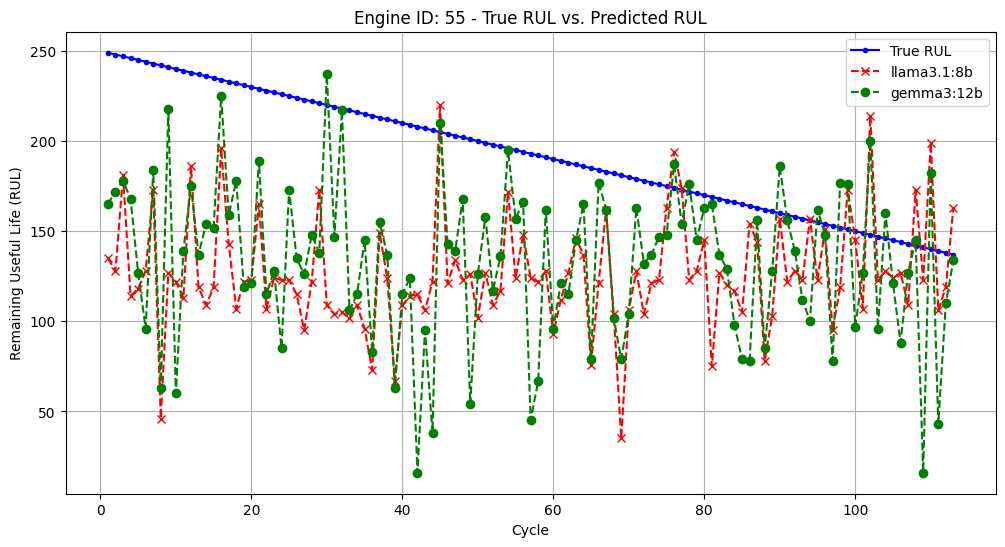

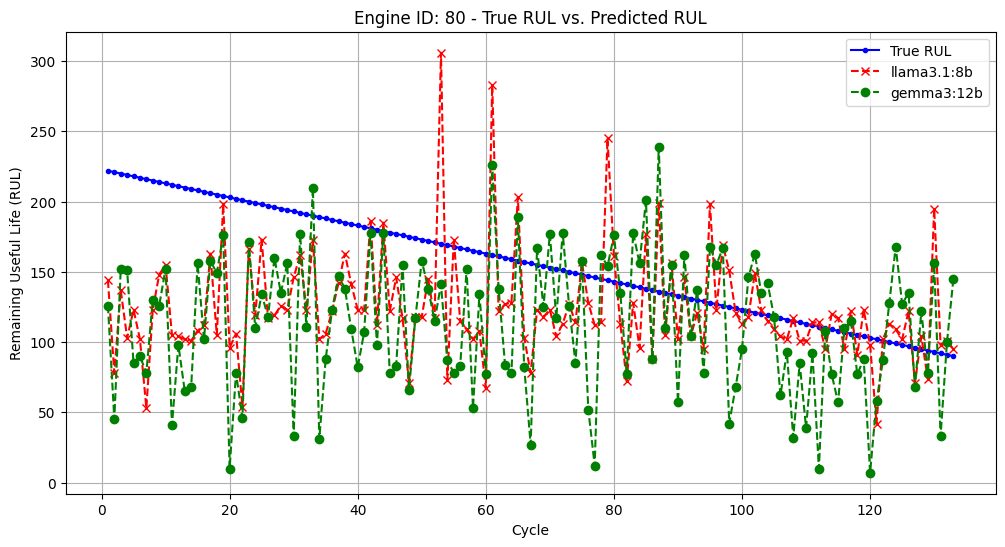

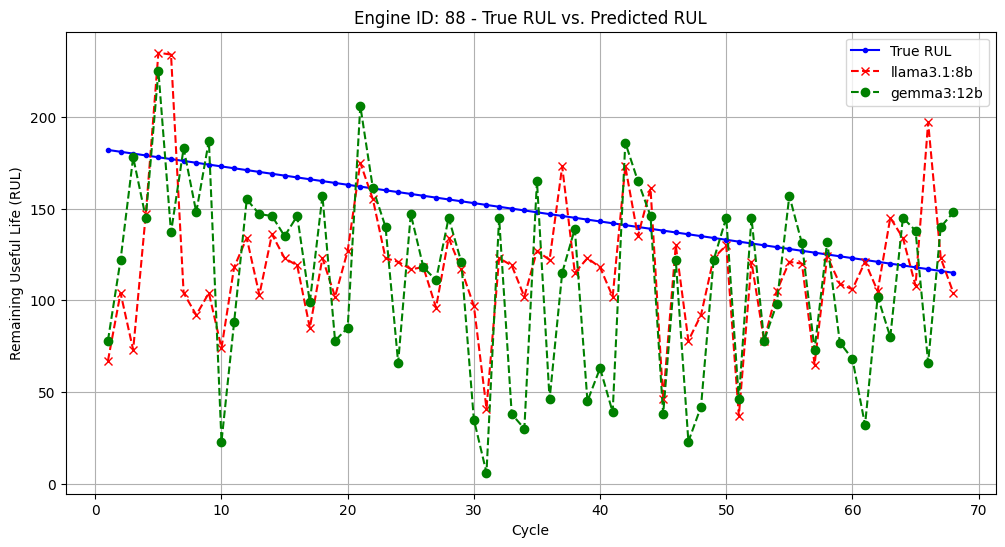

In [41]:
import numpy as np

import matplotlib.pyplot as plt

# Get the unique engine IDs from the evaluation dataframe
unique_engines = llama_df[0].unique()

# Randomly select 3 engine IDs to plot
# Ensure we don't select more engines than are available
num_to_select = min(3, len(unique_engines))
selected_engine_ids = np.random.choice(unique_engines, size=num_to_select, replace=False)

# Plot the results for each selected engine
for engine_id in selected_engine_ids:
    plt.figure(figsize=(12, 6))
    
    # Filter the dataframe for the current engine
    llama_data = llama_df[llama_df[0] == engine_id]
    gemma_data = gemma_df[gemma_df[0] == engine_id]

    # Plot True RUL vs. Predicted RUL over cycles
    plt.plot(llama_data[1], llama_data['RUL'], label='True RUL', marker='.', linestyle='-', color='blue')
    plt.plot(llama_data[1], llama_data['predicted_RUL'], label='llama3.1:8b', marker='x', linestyle='--', color='red')
    plt.plot(gemma_data[1], gemma_data['predicted_RUL'], label='gemma3:12b', marker='o', linestyle='--', color='green')

    # Add plot titles and labels
    plt.title(f'Engine ID: {engine_id} - True RUL vs. Predicted RUL')
    plt.xlabel('Cycle')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.legend()
    plt.grid(True)
    plt.show()